C:\Users\rjesh\AppData\Local\Temp\ipykernel_10468\4170306013.py:69: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x.iloc[:, 1:] = x.iloc[:, 1:].ffill().bfill()


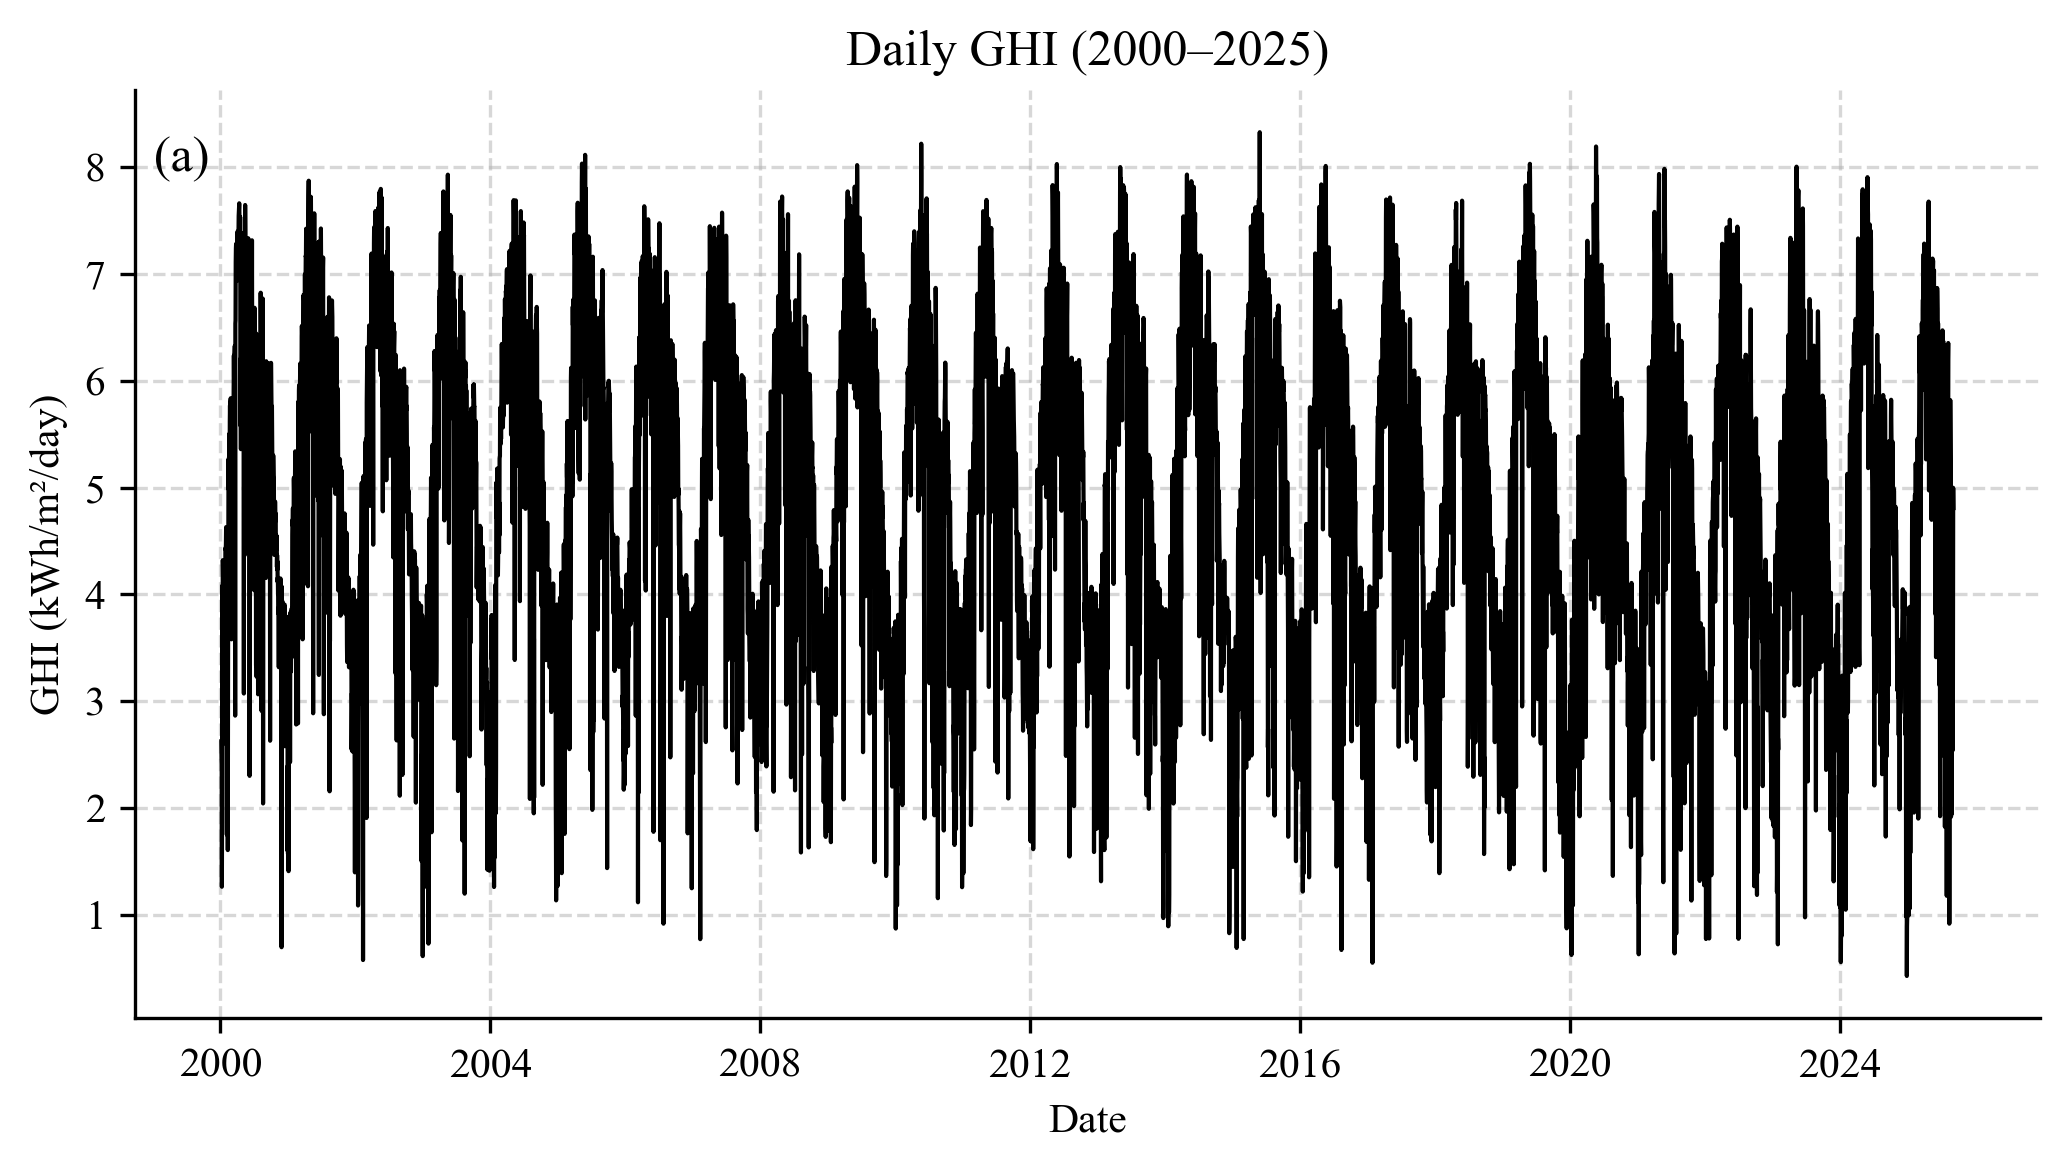

Fig. 2. Daily meteorological drivers used in net-load modeling for the study region (2000–2025).
Panels show: (a) GHI (kWh/m²/day).
All data sourced from NASA POWER. Units indicated on axes.


In [3]:
# ======================
# NASA POWER CSV -> Clean + Q1 Figure
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from textwrap import dedent

# ---------- user inputs ----------
csv_path = Path("POWER_Point_Daily_20000106_20250910_028d89N_076d58E_LST.csv")
save_basename = "Fig2_Weather_TimeSeries"   # files saved as PNG/PDF/TIF
time_label = "2000–2025"                    # appears in title
# ----------------------------------

# 1) find the real header (line that starts with YEAR,)
with open(csv_path, "r", encoding="utf-8") as f:
    lines = f.readlines()
header_idx = next(i for i, ln in enumerate(lines) if ln.startswith("YEAR,"))

# 2) read from header onward
df = pd.read_csv(csv_path, skiprows=header_idx)

# 3) build DATE (handles DAILY or HOURLY)
if {"YEAR","MO","DY"}.issubset(df.columns):
    if "HR" in df.columns:
        df["DATE"] = pd.to_datetime(
            dict(year=df["YEAR"], month=df["MO"], day=df["DY"], hour=df["HR"])
        )
        df.drop(columns=["YEAR","MO","DY","HR"], inplace=True)
    else:
        df["DATE"] = pd.to_datetime(dict(year=df["YEAR"], month=df["MO"], day=df["DY"]))
        df.drop(columns=["YEAR","MO","DY"], inplace=True)
else:
    raise ValueError("Unexpected POWER CSV format; YEAR/MO/DY not found.")

# 4) numeric conversion
for c in df.columns:
    if c != "DATE":
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 5) clean sentinels & enforce plausible ranges
def _clean(frame: pd.DataFrame) -> pd.DataFrame:
    x = frame.copy()

    # non-negative variables
    nonneg = [
        "ALLSKY_SFC_SW_DWN","CLRSKY_SFC_SW_DWN","PRECTOTCORR","WS10M","WS50M",
        "CLOUD_AMT","ALLSKY_KT"
    ]
    for c in x.columns.intersection(nonneg):
        x.loc[x[c] < 0, c] = np.nan

    # humidity within [0,100]
    if "RH2M" in x.columns:
        x.loc[(x["RH2M"] < 0) | (x["RH2M"] > 100), "RH2M"] = np.nan

    # temperature: keep real negatives but drop absurd flags (≤ -90 °C)
    if "T2M" in x.columns:
        x.loc[x["T2M"] <= -90, "T2M"] = np.nan

    # generic catch-all for any lingering sentinel
    for c in x.columns:
        if c != "DATE" and c not in {"T2M"}:
            x.loc[x[c] <= -90, c] = np.nan

    # small-gap imputation
    x = x.sort_values("DATE").reset_index(drop=True)
    x.iloc[:, 1:] = x.iloc[:, 1:].ffill().bfill()
    return x

df = _clean(df)

# 6) friendly names (kept only if present)
rename = {
    "ALLSKY_SFC_SW_DWN": "GHI (kWh/m²/day)",
    "CLRSKY_SFC_SW_DWN": "GHI (Clear-sky)",
    "T2M": "Temperature (°C)",
    "WS10M": "Wind 10 m (m/s)",
    "WS50M": "Wind 50 m (m/s)",
    "RH2M": "Relative Humidity (%)",
    "PRECTOTCORR": "Precipitation (mm/day)",
    "CLOUD_AMT": "Cloud Cover (%)",
    "ALLSKY_KT": "Clearness Index (-)"
}
df = df.rename(columns={k:v for k,v in rename.items() if k in df.columns})

# ======================
# Q1 figure formatting
# ======================
# global style (Times New Roman; grayscale-friendly)
plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "font.family": "Times New Roman",
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.linestyle": "--",
    "grid.alpha": 0.5,
})

# choose variables to plot (ordered, if present)
panel_order = [
    "GHI (kWh/m²/day)",
    "Temperature (°C)",
    "Wind 10 m (m/s)",
    "Relative Humidity (%)",
    "Precipitation (mm/day)",
    "Cloud Cover (%)",
]

present = [c for c in panel_order if c in df.columns]
date = df["DATE"]

if len(present) == 0:
    # fallback: single irradiance under raw name if user only has that
    candidates = [c for c in df.columns if c != "DATE"]
    assert candidates, "No numeric variables found."
    present = [candidates[0]]

# single-panel or multi-panel layout
if len(present) == 1:
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(date, df[present[0]], color="black", linewidth=1)
    ax.set_xlabel("Date")
    ax.set_ylabel(present[0])
    ax.set_title(f"Daily {present[0].split(' (')[0]} ({time_label})")
    ax.grid(True)
    # panel label
    ax.text(0.01, 0.95, "(a)", transform=ax.transAxes, fontsize=12, va="top")
else:
    # up to 6 panels, 2x3 grid
    rows = 2
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(7.2, 5.0), sharex=True)
    axes = axes.ravel()
    for i, var in enumerate(present[: rows*cols ]):
        ax = axes[i]
        ax.plot(date, df[var], color="black", linewidth=1)
        ax.set_ylabel(var)
        ax.grid(True)
        ax.text(0.01, 0.95, f"({chr(97+i)})", transform=ax.transAxes, fontsize=12, va="top")
    # tidy empty axes if fewer than 6 variables
    for j in range(len(present), rows*cols):
        fig.delaxes(axes[j])
    axes[min(len(present), rows*cols)-1].set_xlabel("Date")
    fig.suptitle(f"Daily Weather Features for Net-Load Forecasting ({time_label})", y=0.99, fontsize=12)

plt.tight_layout()
# save high-res outputs
for ext in ("png", "pdf", "tif"):
    plt.savefig(f"{save_basename}.{ext}", bbox_inches="tight")
plt.show()

# optional: print a caption template you can paste into LaTeX/Word
caption = dedent(f"""
Fig. 2. Daily meteorological drivers used in net-load modeling for the study region ({time_label}).
Panels show: {', '.join([f'({chr(97+i)}) {present[i]}' for i in range(len(present))])}.
All data sourced from NASA POWER. Units indicated on axes. 
""").strip()
print(caption)


C:\Users\rjesh\AppData\Local\Temp\ipykernel_8700\497468838.py:105: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x.iloc[:, 1:] = x.iloc[:, 1:].ffill().bfill()


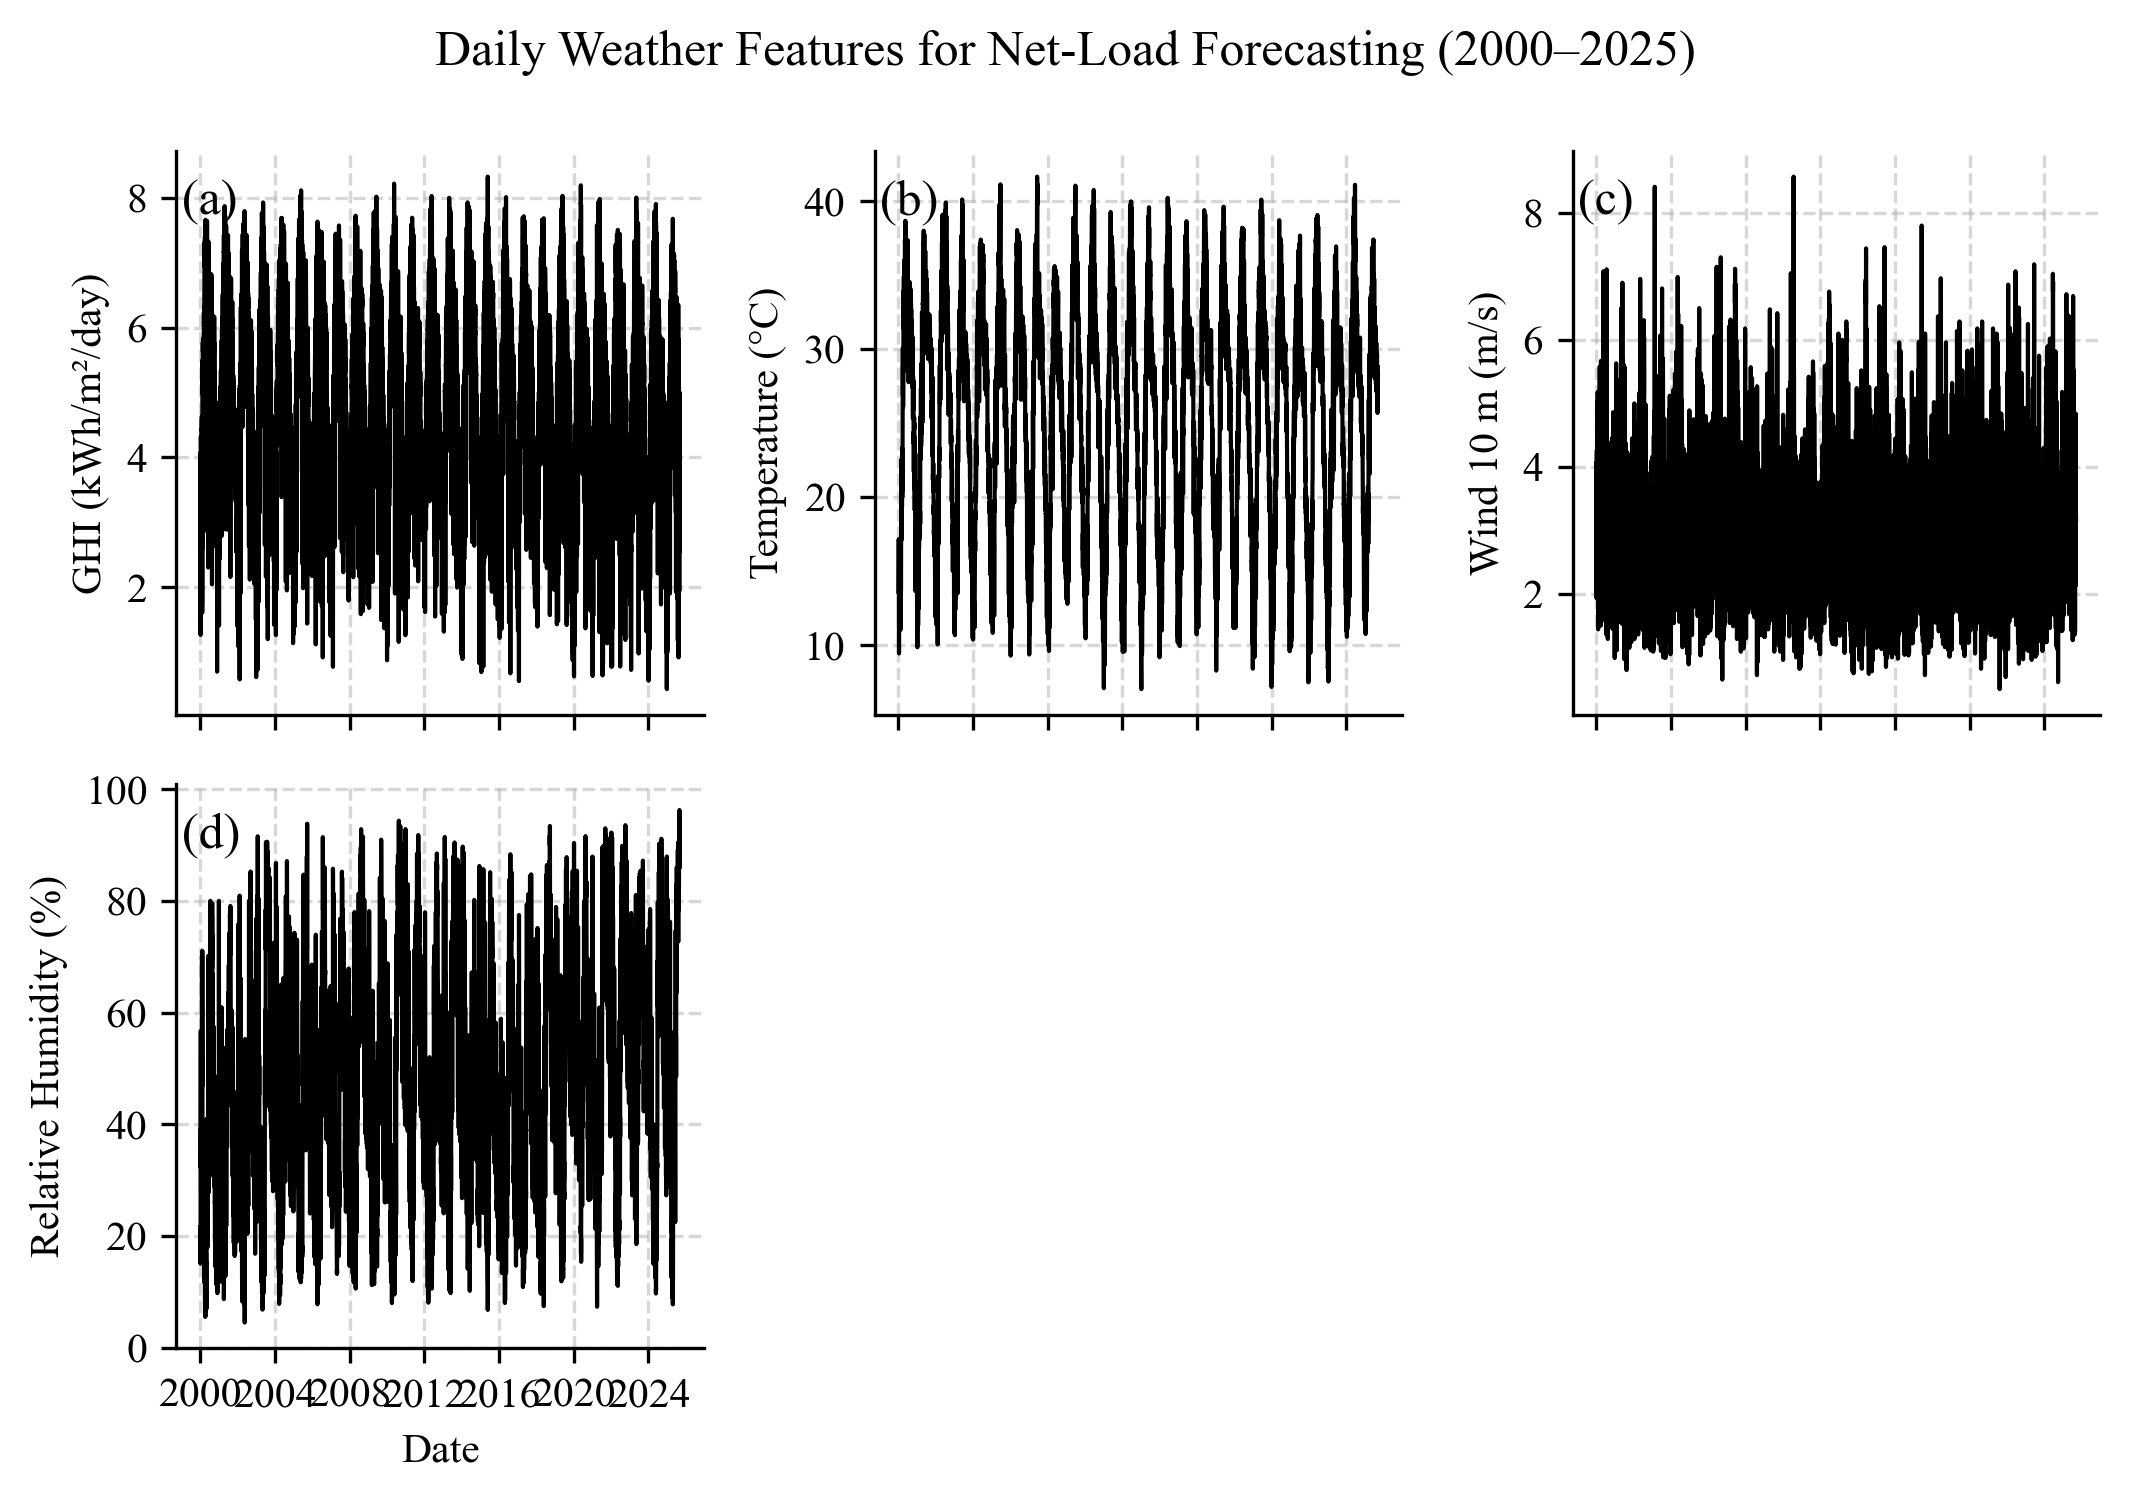

Fig. 2. Daily meteorological drivers used in net-load modeling for the study region (2000–2025).
Panels show: (a) GHI (kWh/m²/day), (b) Temperature (°C), (c) Wind 10 m (m/s), (d) Relative Humidity (%).
All data sourced from NASA POWER. Units indicated on axes.


In [3]:
# ======================
# NASA POWER CSV -> Clean + Q1 Figure (robust to RAW or CLEAN CSVs)
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from textwrap import dedent

# ---------- user inputs ----------
csv_path = Path("Nasa_all.csv")  # <- change if needed
save_basename = "Fig2_Weather_TimeSeries"
time_label = "2000–2025"
# ----------------------------------

def read_power_any(path: Path) -> pd.DataFrame:
    """
    Reads either:
      - RAW NASA POWER CSV (with metadata header + YEAR,MO,DY[,HR]), or
      - CLEAN CSV (already has DATE column).
    Returns dataframe with DATE column + numeric variables.
    """
    # Try quick read to see columns
    try:
        # Read a small chunk to detect header style
        head = pd.read_csv(path, nrows=5)
        cols = set(head.columns.astype(str))
    except Exception:
        cols = set()

    if "DATE" in cols:
        # CLEAN format: DATE already present
        df = pd.read_csv(path)
        # Ensure DATE is datetime
        df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
        df = df[df["DATE"].notna()]
    else:
        # RAW format: find the line where the real header starts
        with open(path, "r", encoding="utf-8") as f:
            lines = f.readlines()
        header_idx = None
        for i, ln in enumerate(lines[:100]):
            if ln.startswith("YEAR,") or ln.startswith("DATE,"):
                header_idx = i
                break
        if header_idx is None:
            # fallback to common NASA POWER skip (9 or 12)
            # we try 9 first; if YEAR not found, try 12
            try:
                df = pd.read_csv(path, skiprows=9)
            except Exception:
                df = pd.read_csv(path, skiprows=12)
        else:
            df = pd.read_csv(path, skiprows=header_idx)

        # Build DATE from components if present
        if {"YEAR","MO","DY"}.issubset(df.columns):
            if "HR" in df.columns:
                df["DATE"] = pd.to_datetime(
                    dict(year=df["YEAR"], month=df["MO"], day=df["DY"], hour=df["HR"]),
                    errors="coerce"
                )
                df.drop(columns=["YEAR","MO","DY","HR"], inplace=True)
            else:
                df["DATE"] = pd.to_datetime(
                    dict(year=df["YEAR"], month=df["MO"], day=df["DY"]), errors="coerce"
                )
                df.drop(columns=["YEAR","MO","DY"], inplace=True)
        elif "DATE" in df.columns:
            df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
        else:
            raise ValueError(f"Unexpected POWER CSV format: {path.name} (no YEAR/MO/DY or DATE)")

        df = df[df["DATE"].notna()]

    # Make non-DATE columns numeric
    for c in df.columns:
        if c != "DATE":
            df[c] = pd.to_numeric(df[c], errors="coerce")

    return df

def clean_power_df(df: pd.DataFrame) -> pd.DataFrame:
    x = df.copy()

    # Generic sentinel cleanup
    for c in x.columns:
        if c != "DATE":
            x.loc[x[c] <= -90, c] = np.nan  # -99, -999 etc.

    # Enforce non-negativity where applicable
    nonneg = ["ALLSKY_SFC_SW_DWN","CLRSKY_SFC_SW_DWN","PRECTOTCORR",
              "WS10M","WS50M","CLOUD_AMT","ALLSKY_KT"]
    for c in x.columns:
        if c in nonneg:
            x.loc[x[c] < 0, c] = np.nan

    # Humidity bounds
    if "RH2M" in x.columns:
        x.loc[(x["RH2M"] < 0) | (x["RH2M"] > 100), "RH2M"] = np.nan

    # Light imputation for plotting
    x = x.sort_values("DATE").reset_index(drop=True)
    if x.shape[1] > 1:
        x.iloc[:, 1:] = x.iloc[:, 1:].ffill().bfill()

    return x

# 1) Load (RAW or CLEAN) + clean
df = read_power_any(csv_path)
df = clean_power_df(df)

# 2) Friendly names (apply only if present)
rename = {
    "ALLSKY_SFC_SW_DWN": "GHI (kWh/m²/day)",
    "CLRSKY_SFC_SW_DWN": "GHI (Clear-sky)",
    "T2M": "Temperature (°C)",
    "WS10M": "Wind 10 m (m/s)",
    "WS50M": "Wind 50 m (m/s)",
    "RH2M": "Relative Humidity (%)",
    "PRECTOTCORR": "Precipitation (mm/day)",
    "CLOUD_AMT": "Cloud Cover (%)",
    "ALLSKY_KT": "Clearness Index (-)"
}
df = df.rename(columns={k:v for k,v in rename.items() if k in df.columns})

# ======================
# Q1 figure formatting
# ======================
plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "font.family": "Times New Roman",
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.linestyle": "--",
    "grid.alpha": 0.5,
})

panel_order = [
    "GHI (kWh/m²/day)",
    "Temperature (°C)",
    "Wind 10 m (m/s)",
    "Relative Humidity (%)",
    "Precipitation (mm/day)",
    "Cloud Cover (%)",
]

present = [c for c in panel_order if c in df.columns]
date = df["DATE"]

if len(present) == 0:
    candidates = [c for c in df.columns if c != "DATE"]
    assert candidates, "No numeric variables found in the file."
    present = [candidates[0]]

# Plot
if len(present) == 1:
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(date, df[present[0]], color="black", linewidth=1)
    ax.set_xlabel("Date")
    ax.set_ylabel(present[0])
    ax.set_title(f"Daily {present[0].split(' (')[0]} ({time_label})")
    ax.grid(True)
    ax.text(0.01, 0.95, "(a)", transform=ax.transAxes, fontsize=12, va="top")
else:
    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(7.2, 5.0), sharex=True)
    axes = axes.ravel()
    for i, var in enumerate(present[: rows*cols ]):
        ax = axes[i]
        ax.plot(date, df[var], color="black", linewidth=1)
        ax.set_ylabel(var)
        ax.grid(True)
        ax.text(0.01, 0.95, f"({chr(97+i)})", transform=ax.transAxes, fontsize=12, va="top")
    for j in range(len(present), rows*cols):
        fig.delaxes(axes[j])
    axes[min(len(present), rows*cols)-1].set_xlabel("Date")
    fig.suptitle(f"Daily Weather Features for Net-Load Forecasting ({time_label})", y=0.99, fontsize=12)

plt.tight_layout()
for ext in ("png", "pdf", "tif"):
    plt.savefig(f"{save_basename}.{ext}", bbox_inches="tight")
plt.show()

caption = dedent(f"""
Fig. 2. Daily meteorological drivers used in net-load modeling for the study region ({time_label}).
Panels show: {', '.join([f'({chr(97+i)}) {present[i]}' for i in range(len(present))])}.
All data sourced from NASA POWER. Units indicated on axes.
""").strip()
print(caption)


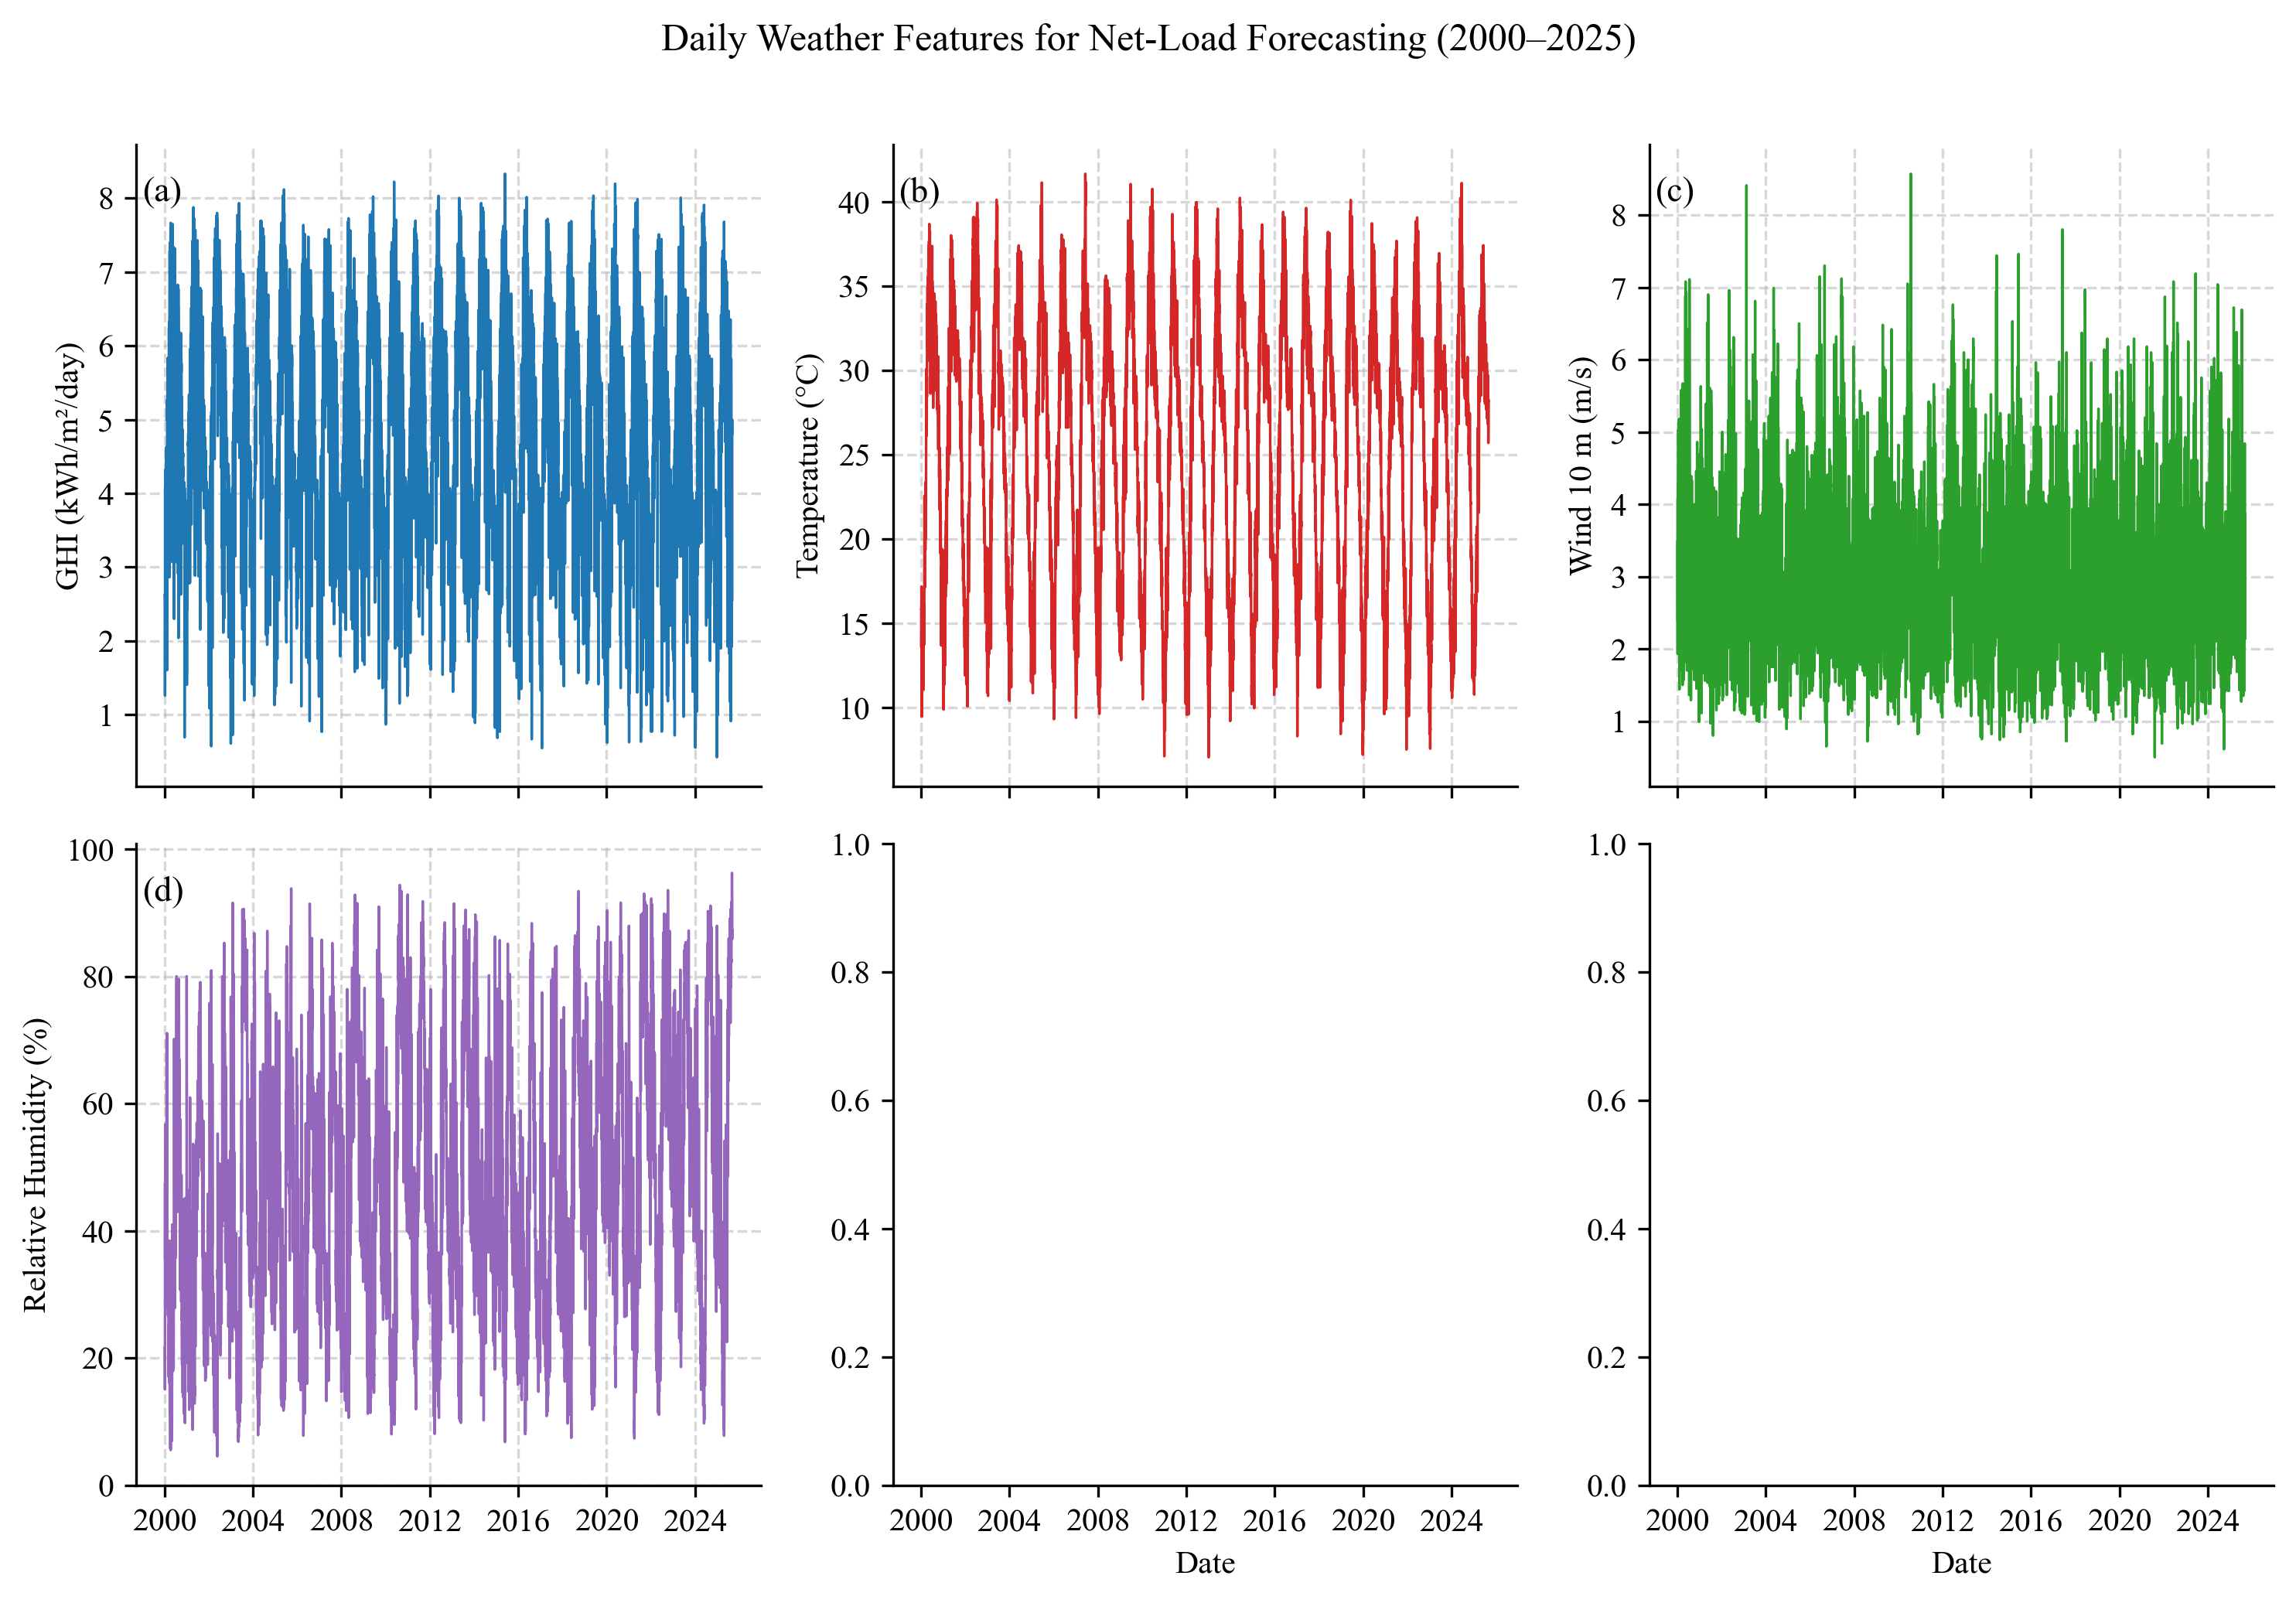

In [4]:

import matplotlib.pyplot as plt

# Professional color palette (muted but distinct)
colors = {
    "GHI (kWh/m²/day)": "tab:blue",
    "Temperature (°C)": "tab:red",
    "Wind 10 m (m/s)": "tab:green",
    "Relative Humidity (%)": "tab:purple",
    "Precipitation (mm/day)": "tab:orange",
    "Cloud Cover (%)": "tab:brown"
}

# Multi-panel plot with colors
rows, cols = 2, 3
present = ["GHI (kWh/m²/day)", "Temperature (°C)", "Wind 10 m (m/s)",
           "Relative Humidity (%)", "Precipitation (mm/day)", "Cloud Cover (%)"]

fig, axes = plt.subplots(rows, cols, figsize=(10, 7), sharex=True)
axes = axes.ravel()

for i, var in enumerate(present):
    if var in df.columns:
        ax = axes[i]
        ax.plot(df["DATE"], df[var], color=colors[var], linewidth=0.8)
        ax.set_ylabel(var)
        ax.text(0.01, 0.95, f"({chr(97+i)})", transform=ax.transAxes, fontsize=11, va="top")
        ax.grid(True, linestyle="--", alpha=0.5)

for j in range(len(present), rows*cols):
    fig.delaxes(axes[j])

axes[-2].set_xlabel("Date")
axes[-1].set_xlabel("Date")

fig.suptitle("Daily Weather Features for Net-Load Forecasting (2000–2025)", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


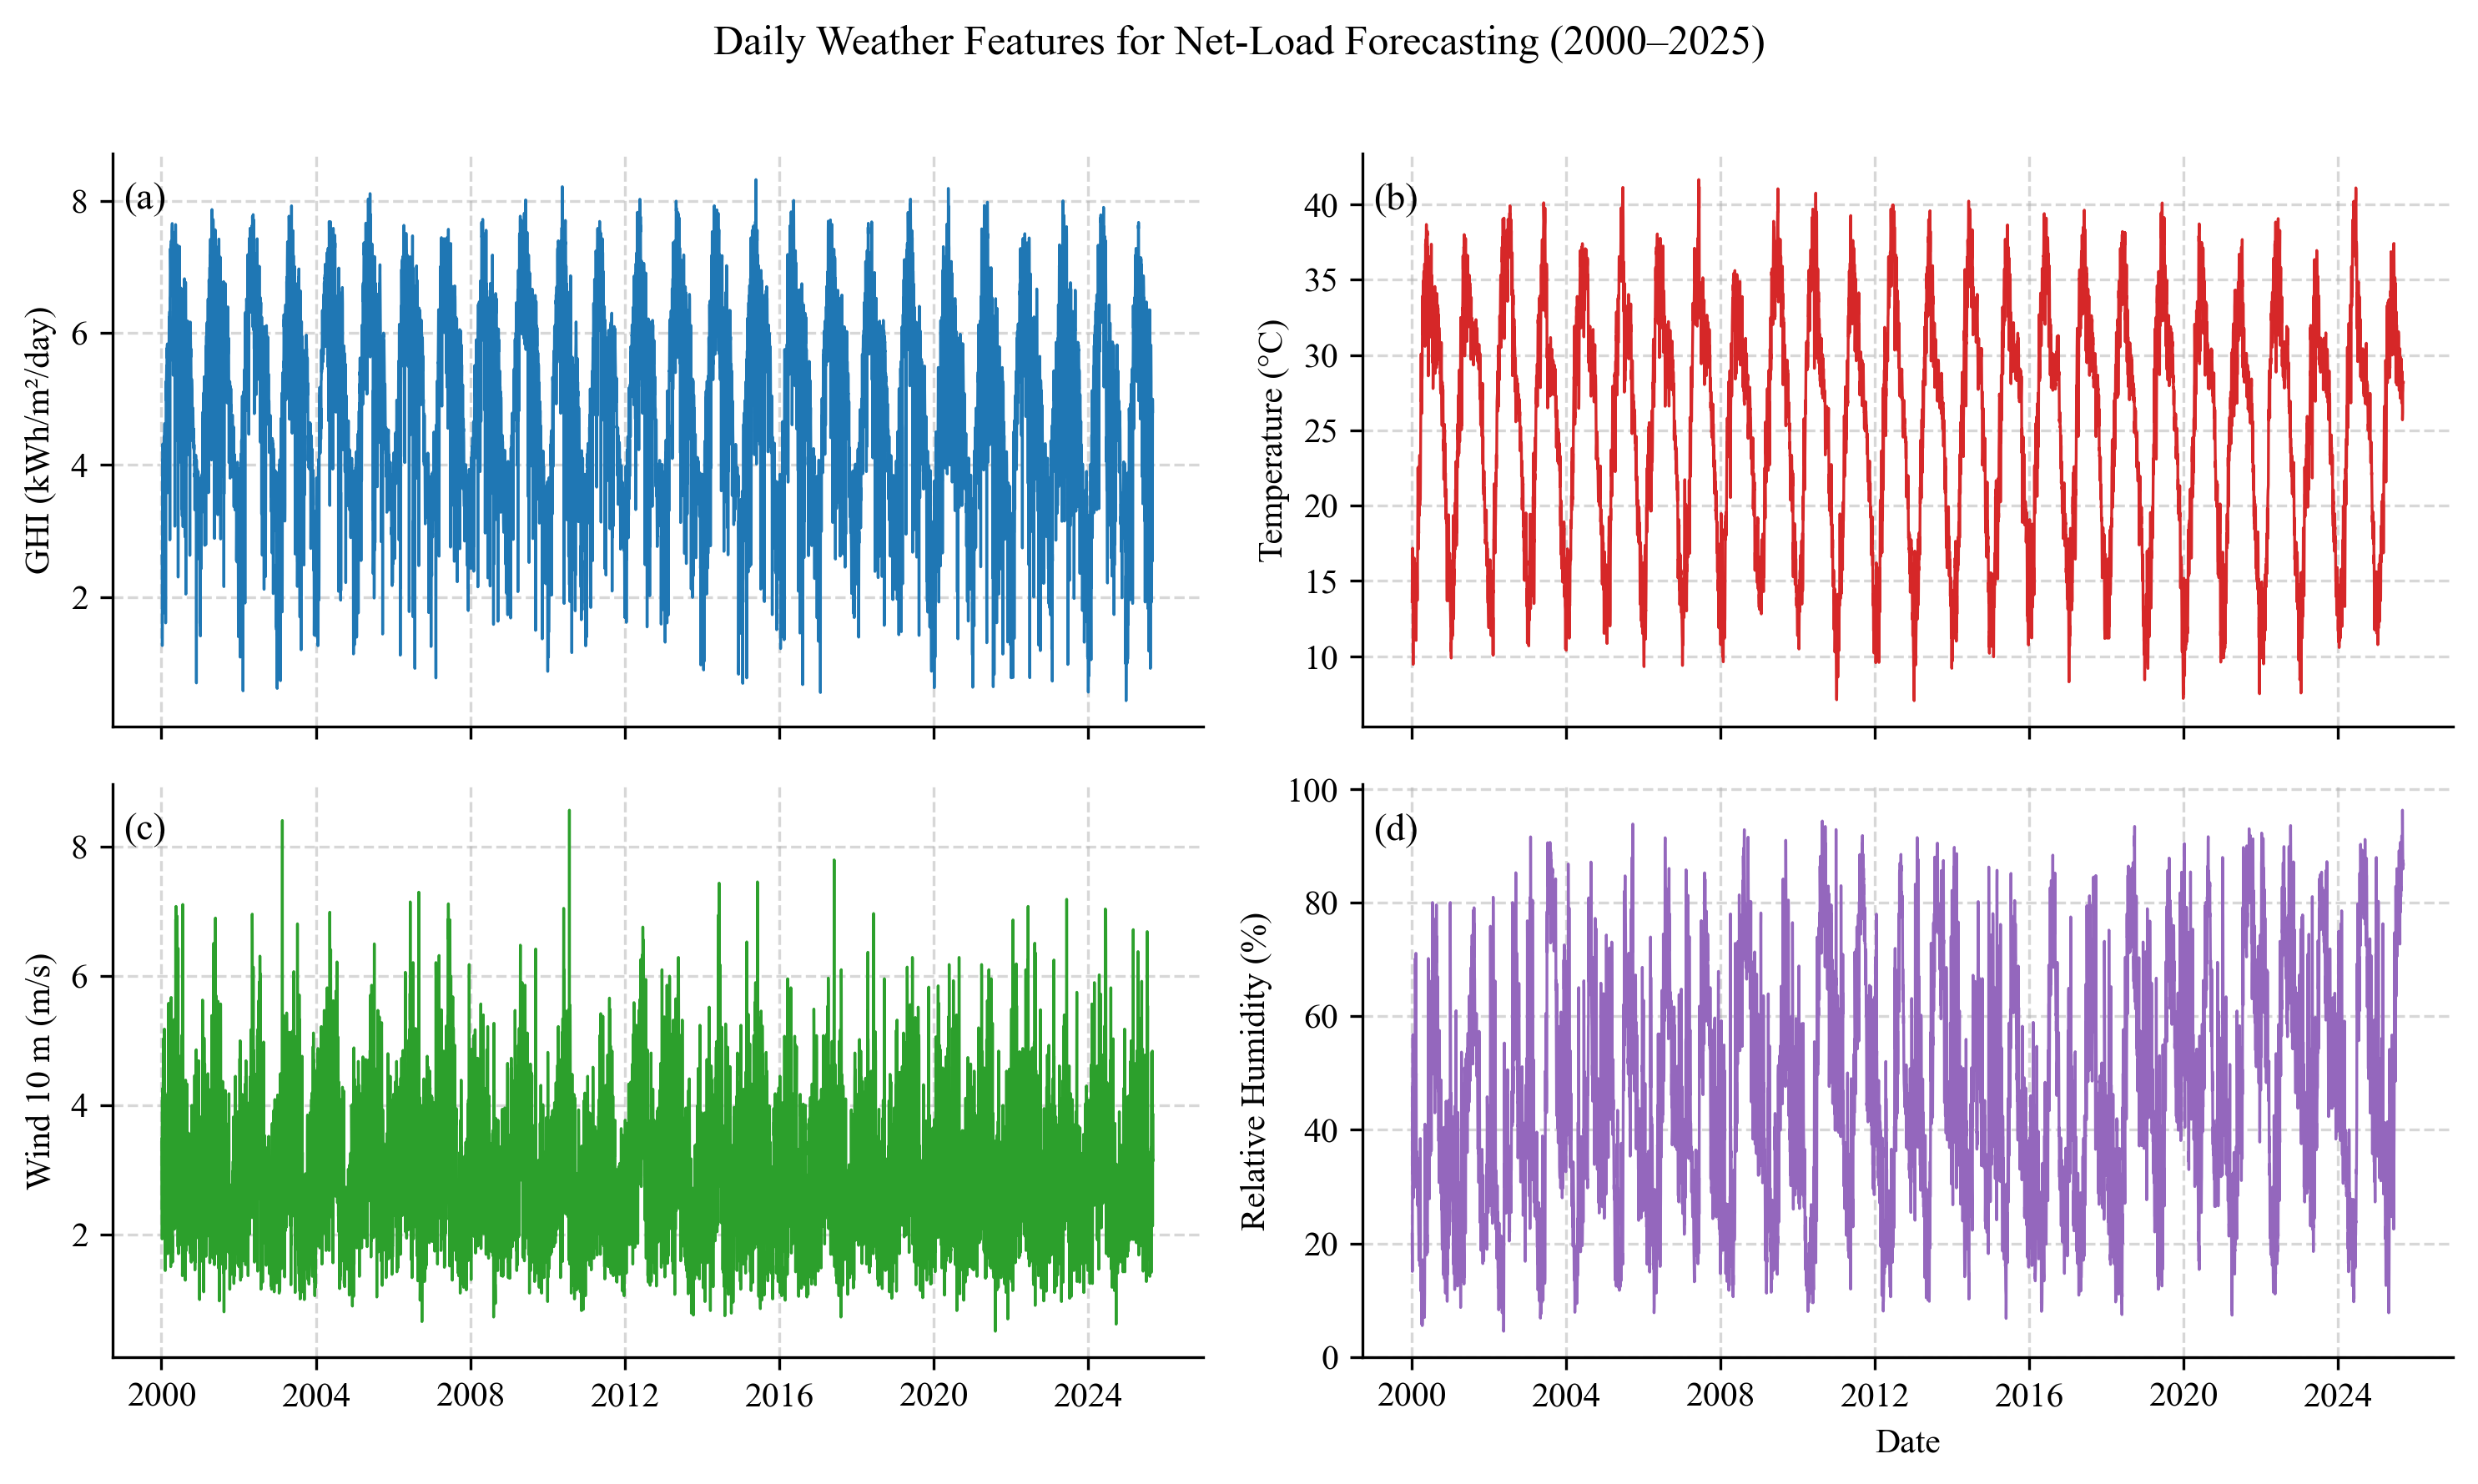

In [5]:

import math
import matplotlib.pyplot as plt

# Variables actually present
present = ["GHI (kWh/m²/day)", "Temperature (°C)", "Wind 10 m (m/s)", "Relative Humidity (%)"]

n_vars = len(present)
cols = 2                           # choose 2 columns for cleaner look
rows = math.ceil(n_vars / cols)    # rows needed

fig, axes = plt.subplots(rows, cols, figsize=(10, rows*3), sharex=True)
axes = axes.ravel()

colors = ["tab:blue", "tab:red", "tab:green", "tab:purple"]

for i, var in enumerate(present):
    ax = axes[i]
    ax.plot(df["DATE"], df[var], color=colors[i], linewidth=0.8)
    ax.set_ylabel(var)
    ax.text(0.01, 0.95, f"({chr(97+i)})", transform=ax.transAxes, fontsize=11, va="top")
    ax.grid(True, linestyle="--", alpha=0.5)

# Remove unused axes (if any)
for j in range(n_vars, len(axes)):
    fig.delaxes(axes[j])

axes[-1].set_xlabel("Date")
fig.suptitle("Daily Weather Features for Net-Load Forecasting (2000–2025)", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


C:\Users\rjesh\AppData\Local\Temp\ipykernel_8700\1958722026.py:106: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x.iloc[:, 1:] = x.iloc[:, 1:].ffill().bfill()


Vars present: ['GHI (kWh/m²/day)']


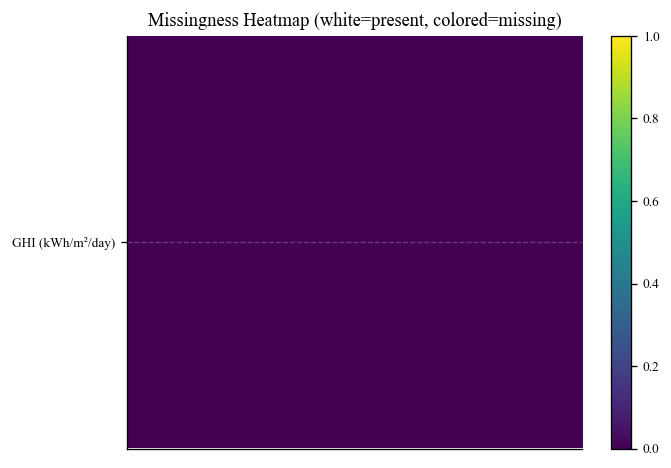

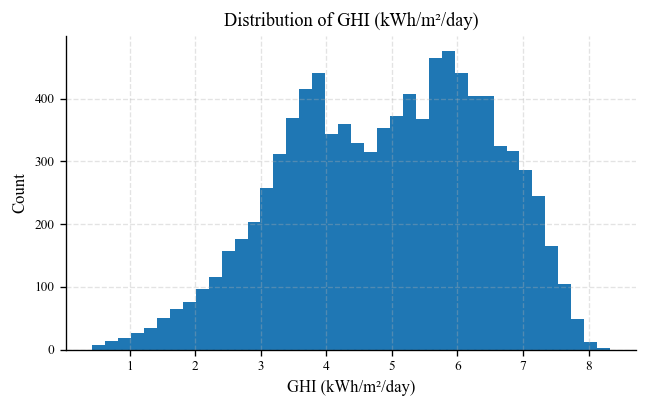

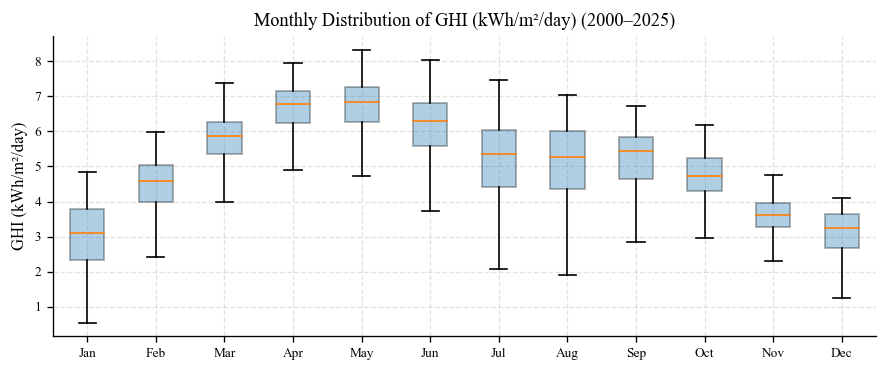

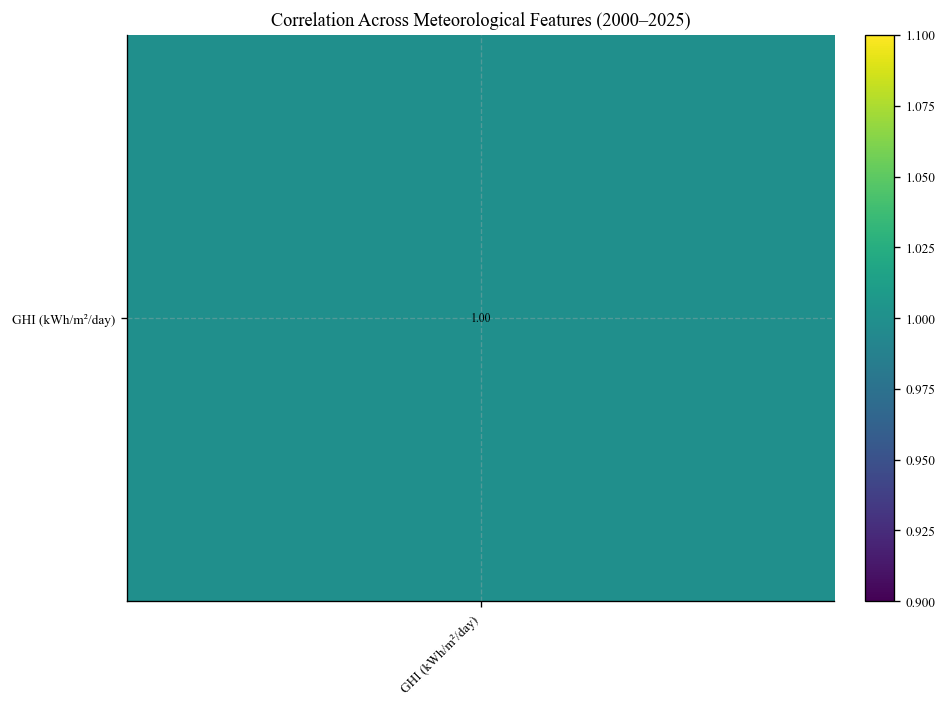

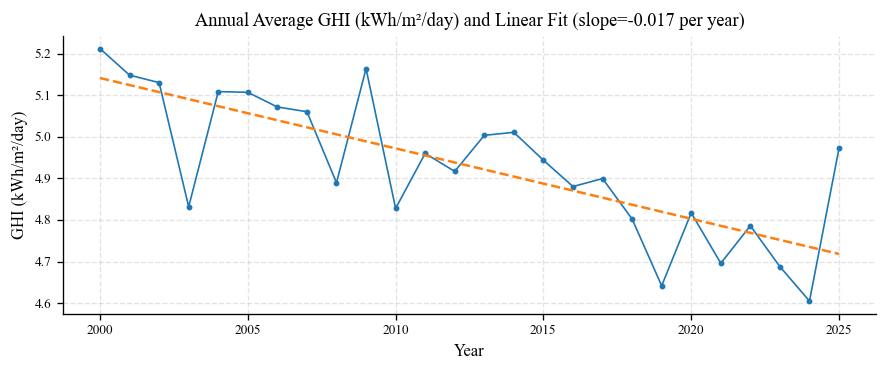


✅ Pre-analysis complete.
Saved files in: C:\Users\rjesh\pre_analysis_outputs


In [9]:
# ==========================================
# NASA POWER → Data Information & Pre-Analysis (Q1 style)
# ==========================================
import glob, math
from pathlib import Path
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- CONFIG --------
IN_PATTERN = "POWER_Point_Daily_*.csv"
OUTDIR = Path("pre_analysis_outputs"); OUTDIR.mkdir(exist_ok=True)
TIME_LABEL = "2000–2025"

RENAME = {
    "ALLSKY_SFC_SW_DWN": "GHI (kWh/m²/day)",
    "CLRSKY_SFC_SW_DWN": "GHI Clear-sky (kWh/m²/day)",
    "T2M": "Temperature (°C)",
    "WS10M": "Wind 10 m (m/s)",
    "WS50M": "Wind 50 m (m/s)",
    "RH2M": "Relative Humidity (%)",
    "PRECTOTCORR": "Precipitation (mm/day)",
    "CLOUD_AMT": "Cloud Cover (%)",
    "ALLSKY_KT": "Clearness Index (-)",
}

# Preferred order for plots/tables
VAR_ORDER = [
    "GHI (kWh/m²/day)",
    "Temperature (°C)",
    "Wind 10 m (m/s)",
    "Relative Humidity (%)",
    "Precipitation (mm/day)",
    "Cloud Cover (%)",
    "Clearness Index (-)",
    "GHI Clear-sky (kWh/m²/day)",
]

# ---- Matplotlib style (IEEE/Elsevier friendly) ----
plt.rcParams.update({
    "figure.dpi": 120, "savefig.dpi": 600,
    "font.family": "Times New Roman",
    "axes.titlesize": 11, "axes.labelsize": 10,
    "xtick.labelsize": 8, "ytick.labelsize": 8,
    "axes.spines.top": False, "axes.spines.right": False,
    "grid.linestyle": "--", "grid.alpha": 0.35, "axes.grid": True,
})

# -------- HELPERS --------
def read_power_any(path: Path) -> pd.DataFrame:
    """Read RAW NASA POWER (meta + YEAR/MO/DY[/HR]) or CLEAN CSV (has DATE)."""
    try:
        head = pd.read_csv(path, nrows=5)
        cols = set(head.columns.astype(str))
    except Exception:
        cols = set()

    if "DATE" in cols:
        df = pd.read_csv(path)
        df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
        df = df[df["DATE"].notna()]
    else:
        with open(path, "r", encoding="utf-8") as f:
            lines = f.readlines()
        header_idx = None
        for i, ln in enumerate(lines[:120]):
            if ln.startswith("YEAR,") or ln.startswith("DATE,"):
                header_idx = i; break
        df = pd.read_csv(path, skiprows=(header_idx if header_idx is not None else 9))
        if {"YEAR","MO","DY"}.issubset(df.columns):
            if "HR" in df.columns:
                df["DATE"] = pd.to_datetime(dict(year=df["YEAR"],month=df["MO"],day=df["DY"],hour=df["HR"]), errors="coerce")
                df.drop(columns=["YEAR","MO","DY","HR"], inplace=True)
            else:
                df["DATE"] = pd.to_datetime(dict(year=df["YEAR"],month=df["MO"],day=df["DY"]), errors="coerce")
                df.drop(columns=["YEAR","MO","DY"], inplace=True)
        elif "DATE" in df.columns:
            df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
        else:
            raise ValueError(f"Unexpected POWER CSV format: {path.name}")
        df = df[df["DATE"].notna()]

    # numeric cast
    for c in df.columns:
        if c != "DATE":
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def clean_power_df(df: pd.DataFrame) -> pd.DataFrame:
    x = df.copy()
    # remove sentinel negatives
    for c in x.columns:
        if c != "DATE":
            x.loc[x[c] <= -90, c] = np.nan  # handles -99/-999 etc.
    # enforce non-negativity for these vars
    for c in ["ALLSKY_SFC_SW_DWN","CLRSKY_SFC_SW_DWN","PRECTOTCORR","WS10M","WS50M","CLOUD_AMT","ALLSKY_KT"]:
        if c in x.columns:
            x.loc[x[c] < 0, c] = np.nan
    # RH bounds
    if "RH2M" in x.columns:
        x.loc[(x["RH2M"] < 0) | (x["RH2M"] > 100), "RH2M"] = np.nan
    x = x.sort_values("DATE").reset_index(drop=True)
    # light fill for visualization; you may keep NaN for modeling if preferred
    if x.shape[1] > 1:
        x.iloc[:, 1:] = x.iloc[:, 1:].ffill().bfill()
    return x

def add_time_parts(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    dt = pd.to_datetime(df["DATE"])
    df["YEAR"] = dt.dt.year
    df["MONTH"] = dt.dt.month
    # Indian seasons: Winter(Dec–Feb), Pre-monsoon(Mar–May), Monsoon(Jun–Sep), Post-monsoon(Oct–Nov)
    season_map = {12:"Winter",1:"Winter",2:"Winter",3:"Pre-monsoon",4:"Pre-monsoon",5:"Pre-monsoon",
                  6:"Monsoon",7:"Monsoon",8:"Monsoon",9:"Monsoon",10:"Post-monsoon",11:"Post-monsoon"}
    df["SEASON"] = df["MONTH"].map(season_map)
    return df

def save_table(df: pd.DataFrame, name: str):
    df.to_csv(OUTDIR / f"{name}.csv", index=True)
    try:
        # optional Excel
        df.to_excel(OUTDIR / f"{name}.xlsx")
    except Exception:
        pass

# -------- LOAD & MERGE --------
files = sorted(glob.glob(IN_PATTERN))
assert files, f"No files matched {IN_PATTERN}. Put your NASA POWER daily CSVs next to this notebook."

dfs = [read_power_any(Path(f)) for f in files]
merged = reduce(lambda L,R: pd.merge(L, R, on="DATE", how="outer"), dfs).sort_values("DATE").reset_index(drop=True)
merged = clean_power_df(merged).rename(columns={k:v for k,v in RENAME.items() if k in merged.columns})
merged = add_time_parts(merged)
merged.to_csv(OUTDIR / "NASA_POWER_Merged_Daily_MASTER_forPreAnalysis.csv", index=False)

# Variables available (ordered)
vars_present = [v for v in VAR_ORDER if v in merged.columns]
print("Vars present:", vars_present)

# -------- (A) SUMMARY STATISTICS --------
num_cols = vars_present
summary_all = merged[num_cols].describe().T[["count","mean","std","min","25%","50%","75%","max"]]
save_table(summary_all, "A1_SummaryStats_Overall")

# by season (mean ± std)
season_grp = merged.groupby("SEASON")[num_cols]
summary_season = pd.concat([season_grp.mean().add_suffix(" |mean"),
                            season_grp.std().add_suffix(" |std")], axis=1)
# tidy multi-index-like columns to two rows per var? keep wide for now
save_table(summary_season, "A2_SummaryStats_BySeason")

# -------- (B) MISSINGNESS --------
missing_pct = merged[num_cols].isna().mean() * 100
save_table(missing_pct.to_frame("Missing %"), "B1_Missingness_Percent")

# Missingness heatmap (DATE x Var) – for long periods, downsample rows to keep figure size manageable
miss = merged[num_cols].isna()
if len(miss) > 4000:  # downsample for heavy plots
    miss = miss.iloc[::int(len(miss)/4000)+1, :]
plt.figure(figsize=(max(6, len(num_cols)*1.2), 4))
plt.imshow(miss.T, aspect="auto", interpolation="nearest")
plt.yticks(range(len(num_cols)), num_cols)
plt.xticks([])  # dates omitted for compactness
plt.title("Missingness Heatmap (white=present, colored=missing)")
plt.colorbar()
plt.tight_layout()
plt.savefig(OUTDIR / "B2_Missingness_Heatmap.png", bbox_inches="tight"); plt.show()

# -------- (C) DISTRIBUTIONS (HISTOGRAMS) --------
cmap = plt.get_cmap("tab10")
for i, var in enumerate(vars_present):
    s = merged[var].dropna()
    plt.figure(figsize=(5.5,3.5))
    plt.hist(s, bins=40)
    plt.xlabel(var); plt.ylabel("Count")
    plt.title(f"Distribution of {var}")
    plt.tight_layout()
    plt.savefig(OUTDIR / f"C1_Hist_{var.split(' ')[0]}.png", bbox_inches="tight"); plt.show()

# -------- (D) SEASONALITY (MONTHLY BOXPLOTS) --------
for i, var in enumerate(vars_present):
    by_m = [merged.loc[merged["MONTH"]==m, var].dropna().values for m in range(1,13)]
    plt.figure(figsize=(7.5,3.2))
    bp = plt.boxplot(by_m, showfliers=False, patch_artist=True)
    for b in bp["boxes"]:
        b.set_alpha(0.35)
    plt.xticks(range(1,13), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
    plt.ylabel(var); plt.title(f"Monthly Distribution of {var} ({TIME_LABEL})")
    plt.tight_layout()
    plt.savefig(OUTDIR / f"D1_MonthlyBox_{var.split(' ')[0]}.png", bbox_inches="tight"); plt.show()

# -------- (E) CORRELATION HEATMAP --------
corr = merged[vars_present].corr()
fig = plt.figure(figsize=(8,6)); ax = fig.add_subplot(111)
im = ax.imshow(corr.values, aspect="auto")
ax.set_xticks(range(len(vars_present))); ax.set_yticks(range(len(vars_present)))
ax.set_xticklabels(vars_present, rotation=45, ha="right"); ax.set_yticklabels(vars_present)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.values[i,j]:.2f}", ha="center", va="center", fontsize=7)
ax.set_title(f"Correlation Across Meteorological Features ({TIME_LABEL})")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()
fig.savefig(OUTDIR / "E1_Correlation_Heatmap.png", bbox_inches="tight"); plt.show()
corr.to_csv(OUTDIR / "E1_Correlation_Values.csv")

# -------- (F) ANNUAL TRENDS (+ linear fits) --------
ann = merged.groupby("YEAR")[vars_present].mean().reset_index()
for i, var in enumerate(vars_present):
    x = ann["YEAR"].values.astype(float)
    y = ann[var].values.astype(float)
    # linear fit y = a*x + b
    a, b = np.polyfit(x, y, 1)
    yfit = a*x + b
    plt.figure(figsize=(7.5,3.2))
    plt.plot(x, y, marker="o", linewidth=1.0, markersize=2.5)
    plt.plot(x, yfit, linestyle="--")
    plt.xlabel("Year"); plt.ylabel(var)
    plt.title(f"Annual Average {var} and Linear Fit (slope={a:.3g} per year)")
    plt.tight_layout()
    plt.savefig(OUTDIR / f"F1_AnnualTrend_{var.split(' ')[0]}.png", bbox_inches="tight"); plt.show()

# -------- (G) EXPORT A SINGLE REPORT TABLE (nice for paper appendix) --------
# Means & std by season in tidy long format
tidy = (merged.melt(id_vars=["DATE","YEAR","MONTH","SEASON"], value_vars=vars_present,
                    var_name="Variable", value_name="Value")
              .dropna())
table_season = (tidy.groupby(["Variable","SEASON"])
                     .agg(Mean=("Value","mean"), Std=("Value","std"), Count=("Value","size"))
                     .reset_index())
table_season.to_csv(OUTDIR / "G1_Tidy_Seasonal_Table.csv", index=False)

print("\n✅ Pre-analysis complete.")
print("Saved files in:", OUTDIR.resolve())


Reading combined file → Nasa_all.csv


C:\Users\rjesh\AppData\Local\Temp\ipykernel_8700\3159953383.py:110: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x.iloc[:, 1:] = x.iloc[:, 1:].ffill().bfill()


Variables present: ['GHI (kWh/m²/day)', 'Temperature (°C)', 'Wind 10 m (m/s)', 'Relative Humidity (%)', 'Clearness Index (-)']


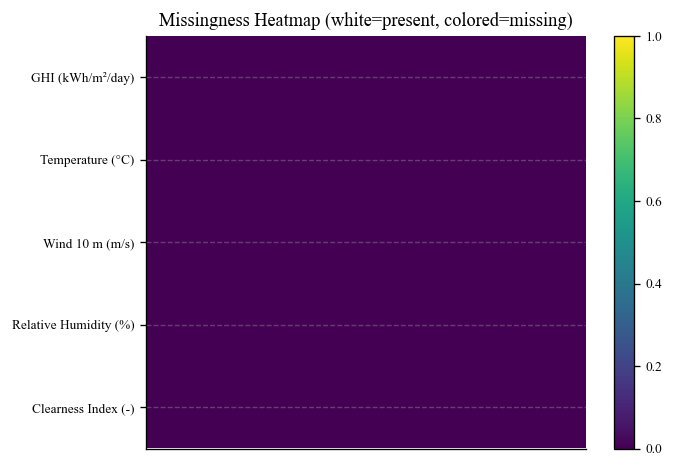

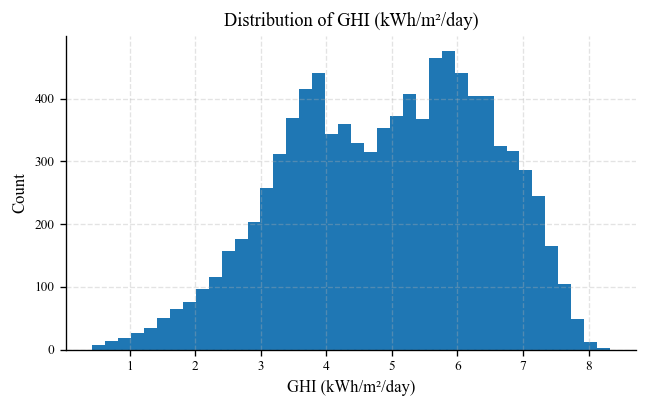

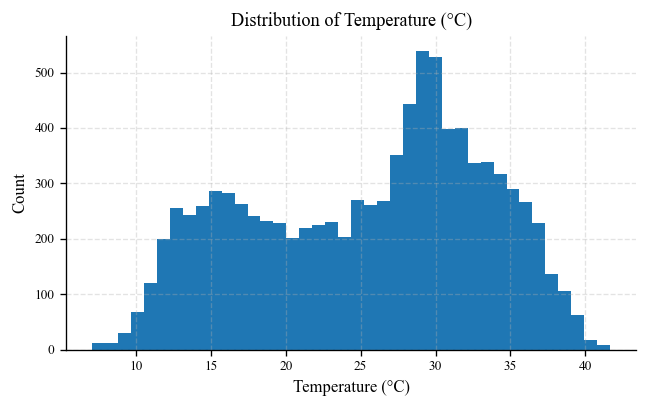

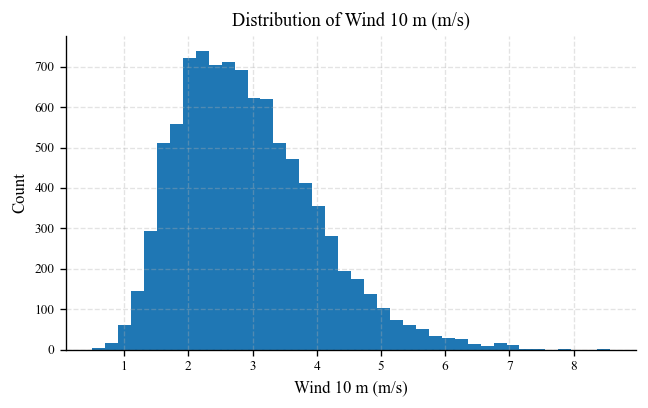

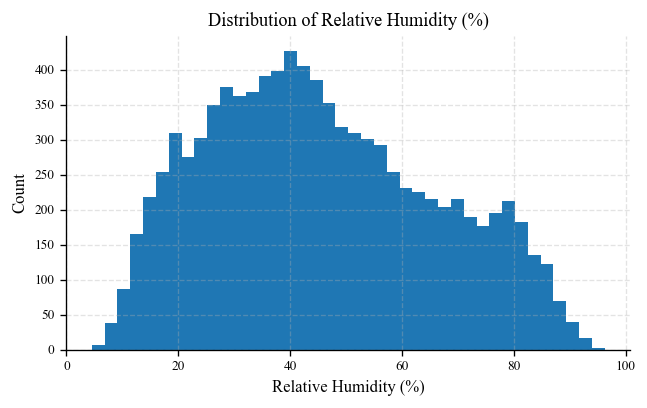

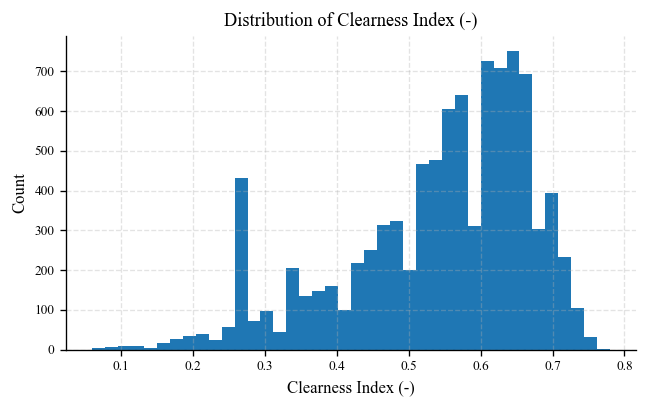

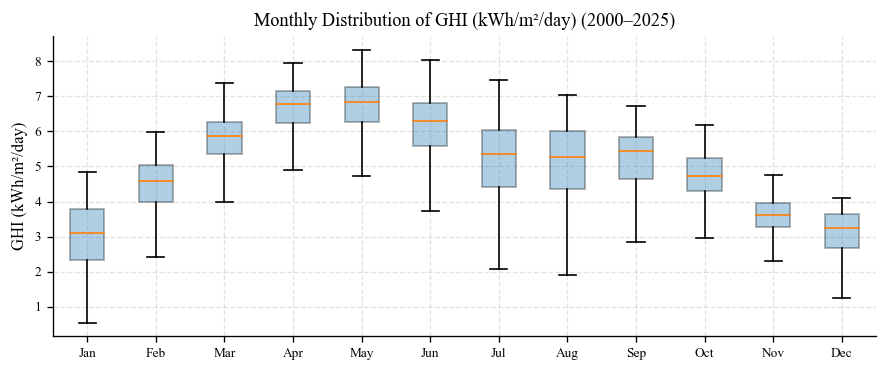

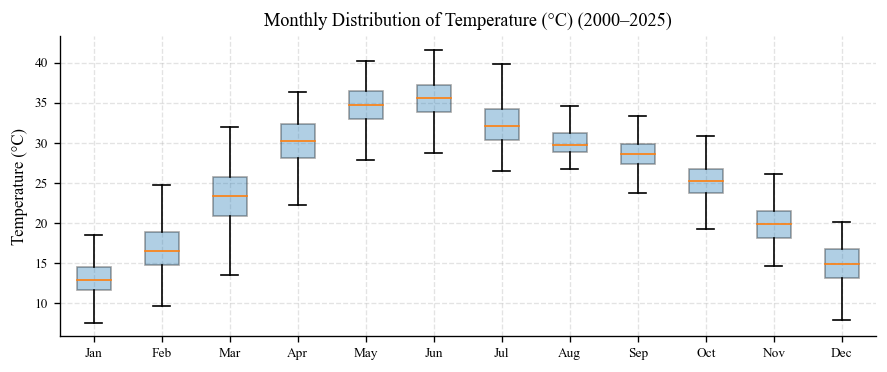

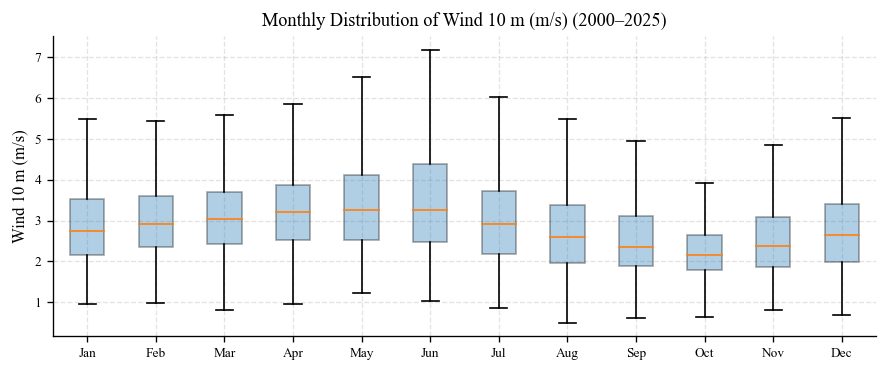

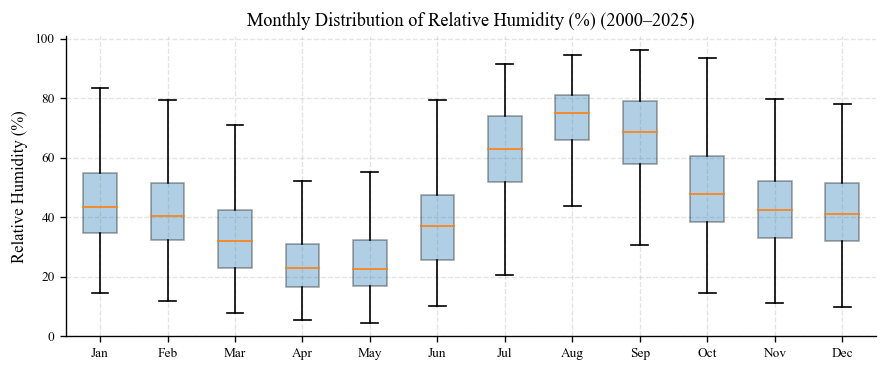

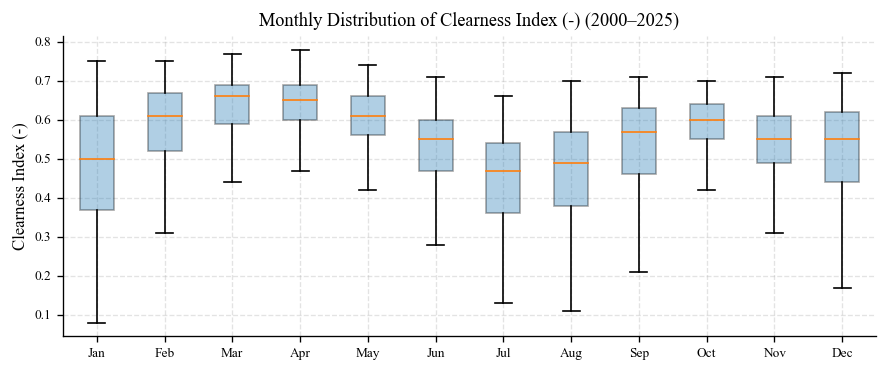

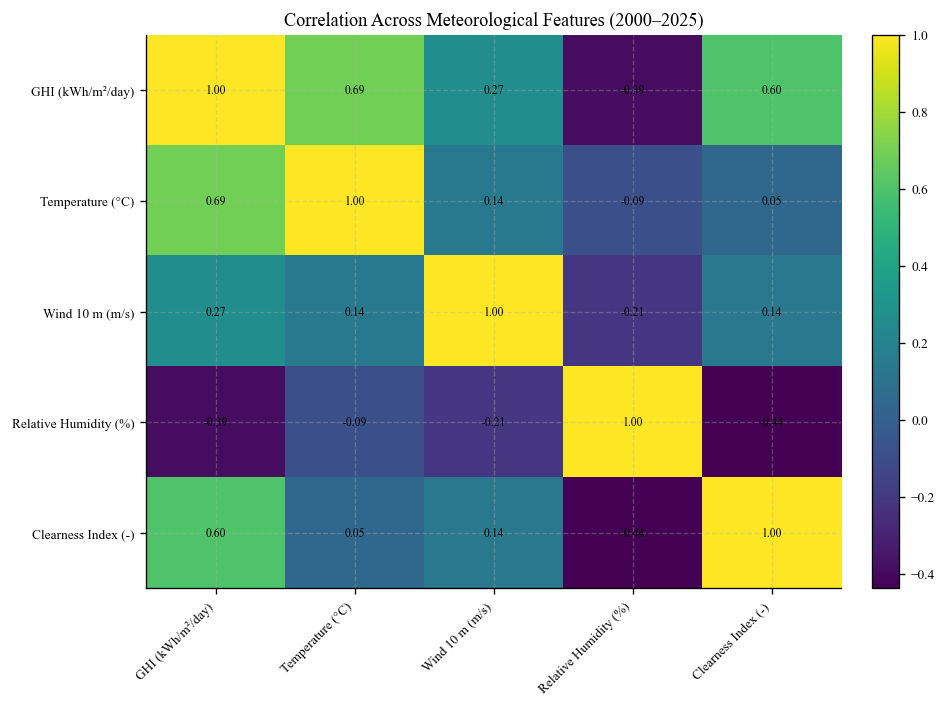

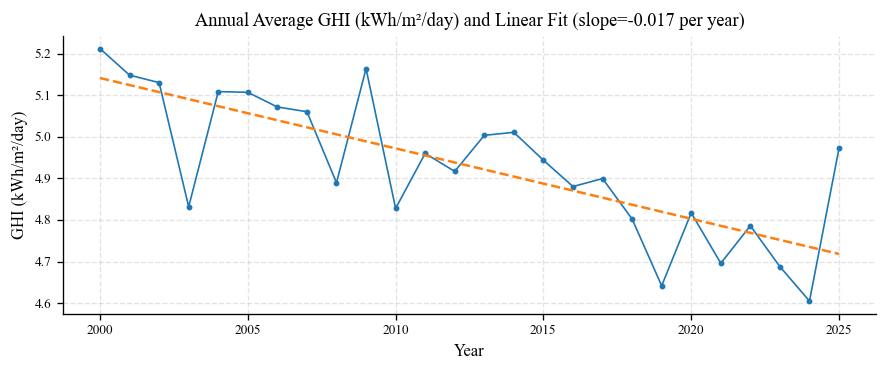

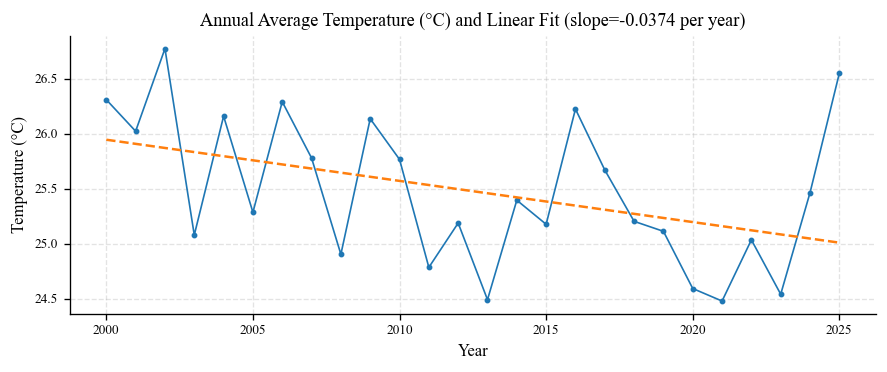

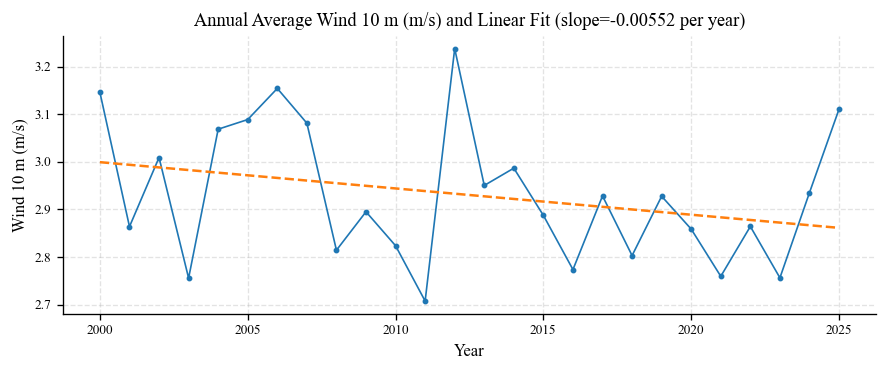

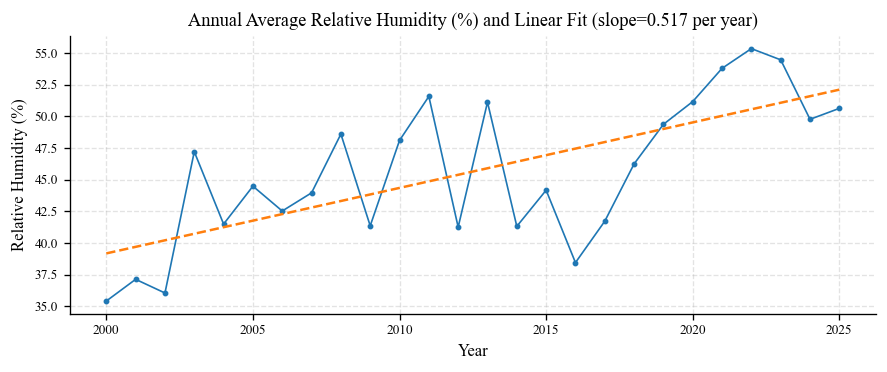

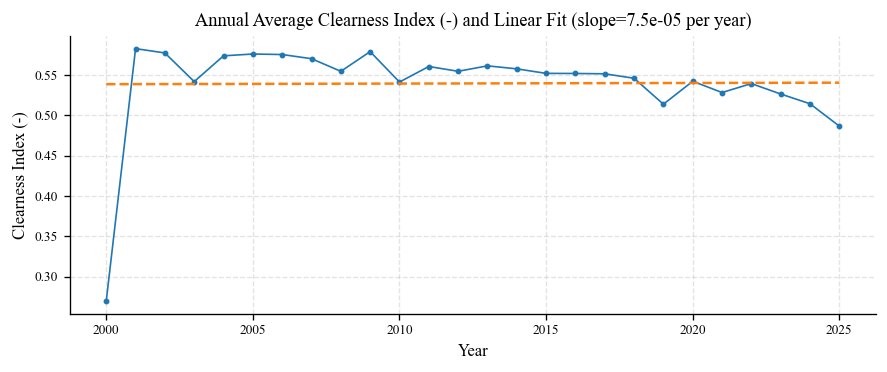


✅ Pre-analysis complete.
All outputs saved in: C:\Users\rjesh\pre_analysis_outputs


In [10]:
# ============================================================
# NASA POWER - Data Information & Pre-Analysis (uses Nasa_all.csv if present)
# ============================================================
import glob, math, os
from pathlib import Path
from functools import reduce
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
COMBINED_FILE = Path("Nasa_all.csv")            # <- your uploaded combined file
IN_PATTERN    = "POWER_Point_Daily_*.csv"       # fallback: raw NASA CSVs
OUTDIR        = Path("pre_analysis_outputs"); OUTDIR.mkdir(exist_ok=True)
TIME_LABEL    = "2000–2025"

# Friendly (journal) names for known NASA POWER variables
RENAME = {
    "ALLSKY_SFC_SW_DWN": "GHI (kWh/m²/day)",
    "CLRSKY_SFC_SW_DWN": "GHI Clear-sky (kWh/m²/day)",
    "T2M": "Temperature (°C)",
    "WS10M": "Wind 10 m (m/s)",
    "WS50M": "Wind 50 m (m/s)",
    "RH2M": "Relative Humidity (%)",
    "PRECTOTCORR": "Precipitation (mm/day)",
    "CLOUD_AMT": "Cloud Cover (%)",
    "ALLSKY_KT": "Clearness Index (-)",
}

# Preferred plotting order if those columns exist
VAR_ORDER = [
    "GHI (kWh/m²/day)", "Temperature (°C)", "Wind 10 m (m/s)",
    "Relative Humidity (%)", "Precipitation (mm/day)", "Cloud Cover (%)",
    "Clearness Index (-)", "GHI Clear-sky (kWh/m²/day)"
]

# ---------- Matplotlib (journal style) ----------
plt.rcParams.update({
    "figure.dpi": 120, "savefig.dpi": 600,
    "font.family": "Times New Roman",
    "axes.titlesize": 11, "axes.labelsize": 10,
    "xtick.labelsize": 8, "ytick.labelsize": 8,
    "axes.spines.top": False, "axes.spines.right": False,
    "grid.linestyle": "--", "grid.alpha": 0.35, "axes.grid": True,
})

# ---------- HELPERS ----------
def read_power_any(path: Path) -> pd.DataFrame:
    """
    Reads either:
      - RAW NASA POWER CSV (with metadata header + YEAR,MO,DY[,HR])
      - CLEAN/combined CSV that already has a DATE column
    Returns a DataFrame with a proper datetime 'DATE' column and numeric features.
    """
    # try quick sniff
    try:
        head = pd.read_csv(path, nrows=5)
        cols = set(head.columns.astype(str))
    except Exception:
        cols = set()

    if "DATE" in cols:
        df = pd.read_csv(path)
        df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
        df = df[df["DATE"].notna()]
    else:
        # find real header that starts with YEAR, or fall back
        with open(path, "r", encoding="utf-8") as f:
            lines = f.readlines()
        header_idx = None
        for i, ln in enumerate(lines[:150]):
            if ln.startswith("YEAR,") or ln.startswith("DATE,"):
                header_idx = i; break
        df = pd.read_csv(path, skiprows=(header_idx if header_idx is not None else 9))
        if {"YEAR","MO","DY"}.issubset(df.columns):
            if "HR" in df.columns:
                df["DATE"] = pd.to_datetime(dict(year=df["YEAR"], month=df["MO"], day=df["DY"], hour=df["HR"]), errors="coerce")
                df.drop(columns=[c for c in ["YEAR","MO","DY","HR"] if c in df.columns], inplace=True)
            else:
                df["DATE"] = pd.to_datetime(dict(year=df["YEAR"], month=df["MO"], day=df["DY"]), errors="coerce")
                df.drop(columns=[c for c in ["YEAR","MO","DY"] if c in df.columns], inplace=True)
        elif "DATE" in df.columns:
            df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
        else:
            raise ValueError(f"Unexpected format (no DATE or YEAR/MO/DY): {path.name}")
        df = df[df["DATE"].notna()]

    # numeric cast
    for c in df.columns:
        if c != "DATE":
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def clean_power_df(df: pd.DataFrame) -> pd.DataFrame:
    """Remove sentinel values, enforce plausible ranges, light fill for plots."""
    x = df.copy()
    # generic sentinel removal
    for c in x.columns:
        if c != "DATE":
            x.loc[x[c] <= -90, c] = np.nan
    # non-negative constraints for some variables
    for c in ["ALLSKY_SFC_SW_DWN","CLRSKY_SFC_SW_DWN","PRECTOTCORR","WS10M","WS50M","CLOUD_AMT","ALLSKY_KT"]:
        if c in x.columns:
            x.loc[x[c] < 0, c] = np.nan
    # RH bounds
    if "RH2M" in x.columns:
        x.loc[(x["RH2M"] < 0) | (x["RH2M"] > 100), "RH2M"] = np.nan
    x = x.sort_values("DATE").reset_index(drop=True)
    if x.shape[1] > 1:
        x.iloc[:, 1:] = x.iloc[:, 1:].ffill().bfill()
    return x

def add_time_parts(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    dt = pd.to_datetime(df["DATE"])
    df["YEAR"] = dt.dt.year
    df["MONTH"] = dt.dt.month
    season_map = {12:"Winter",1:"Winter",2:"Winter",3:"Pre-monsoon",4:"Pre-monsoon",5:"Pre-monsoon",
                  6:"Monsoon",7:"Monsoon",8:"Monsoon",9:"Monsoon",10:"Post-monsoon",11:"Post-monsoon"}
    df["SEASON"] = df["MONTH"].map(season_map)
    return df

def save_table(df: pd.DataFrame, name: str):
    df.to_csv(OUTDIR / f"{name}.csv", index=True)
    try:
        df.to_excel(OUTDIR / f"{name}.xlsx")
    except Exception:
        pass

# ---------- LOAD DATA ----------
if COMBINED_FILE.exists():
    print(f"Reading combined file → {COMBINED_FILE}")
    merged = read_power_any(COMBINED_FILE)
else:
    files = sorted(glob.glob(IN_PATTERN))
    assert files, f"No {COMBINED_FILE} and no files matched {IN_PATTERN}. Add your NASA CSVs and rerun."
    print(f"Merging {len(files)} NASA POWER files …")
    dfs = [read_power_any(Path(f)) for f in files]
    merged = reduce(lambda L,R: pd.merge(L, R, on="DATE", how="outer"), dfs)

# clean + rename + time parts
merged = clean_power_df(merged)
# if your combined file already has friendly names, rename() just keeps them
merged = merged.rename(columns={k:v for k,v in RENAME.items() if k in merged.columns})
merged = add_time_parts(merged)
merged.to_csv(OUTDIR / "MASTER_forPreAnalysis.csv", index=False)

vars_present = [v for v in VAR_ORDER if v in merged.columns] or [c for c in merged.columns if c not in ["DATE","YEAR","MONTH","SEASON"]]
print("Variables present:", vars_present)

# ---------- (A) SUMMARY STATS ----------
summary_all = merged[vars_present].describe().T[["count","mean","std","min","25%","50%","75%","max"]]
save_table(summary_all, "A1_SummaryStats_Overall")

season_grp = merged.groupby("SEASON")[vars_present]
summary_season = pd.concat([season_grp.mean().add_suffix(" |mean"),
                            season_grp.std().add_suffix(" |std")], axis=1)
save_table(summary_season, "A2_SummaryStats_BySeason")

# ---------- (B) MISSINGNESS ----------
missing_pct = merged[vars_present].isna().mean()*100
save_table(missing_pct.to_frame("Missing %"), "B1_Missingness_Percent")

miss = merged[vars_present].isna()
if len(miss) > 4000:
    miss = miss.iloc[::int(len(miss)/4000)+1, :]
plt.figure(figsize=(max(6, len(vars_present)*1.2), 4))
plt.imshow(miss.T, aspect="auto", interpolation="nearest")
plt.yticks(range(len(vars_present)), vars_present); plt.xticks([])
plt.title("Missingness Heatmap (white=present, colored=missing)")
plt.colorbar(); plt.tight_layout()
plt.savefig(OUTDIR / "B2_Missingness_Heatmap.png", bbox_inches="tight"); plt.show()

# ---------- (C) HISTOGRAMS ----------
for var in vars_present:
    s = merged[var].dropna()
    plt.figure(figsize=(5.5,3.5))
    plt.hist(s, bins=40)
    plt.xlabel(var); plt.ylabel("Count")
    plt.title(f"Distribution of {var}")
    plt.tight_layout()
    plt.savefig(OUTDIR / f"C1_Hist_{var.split(' ')[0]}.png", bbox_inches="tight"); plt.show()

# ---------- (D) MONTHLY BOXPLOTS ----------
for var in vars_present:
    by_m = [merged.loc[merged["MONTH"]==m, var].dropna().values for m in range(1,13)]
    plt.figure(figsize=(7.5,3.2))
    bp = plt.boxplot(by_m, showfliers=False, patch_artist=True)
    for b in bp["boxes"]: b.set_alpha(0.35)
    plt.xticks(range(1,13), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
    plt.ylabel(var); plt.title(f"Monthly Distribution of {var} ({TIME_LABEL})")
    plt.tight_layout()
    plt.savefig(OUTDIR / f"D1_MonthlyBox_{var.split(' ')[0]}.png", bbox_inches="tight"); plt.show()

# ---------- (E) CORRELATION ----------
corr = merged[vars_present].corr()
fig = plt.figure(figsize=(8,6)); ax = fig.add_subplot(111)
im = ax.imshow(corr.values, aspect="auto")
ax.set_xticks(range(len(vars_present))); ax.set_yticks(range(len(vars_present)))
ax.set_xticklabels(vars_present, rotation=45, ha="right"); ax.set_yticklabels(vars_present)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.values[i,j]:.2f}", ha="center", va="center", fontsize=7)
ax.set_title(f"Correlation Across Meteorological Features ({TIME_LABEL})")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()
fig.savefig(OUTDIR / "E1_Correlation_Heatmap.png", bbox_inches="tight"); plt.show()
corr.to_csv(OUTDIR / "E1_Correlation_Values.csv")

# ---------- (F) ANNUAL TRENDS (+ linear fit) ----------
ann = merged.groupby("YEAR")[vars_present].mean().reset_index()
for var in vars_present:
    x = ann["YEAR"].values.astype(float)
    y = ann[var].values.astype(float)
    a, b = np.polyfit(x, y, 1)   # linear trend
    plt.figure(figsize=(7.5,3.2))
    plt.plot(x, y, marker="o", linewidth=1.0, markersize=2.5)
    plt.plot(x, a*x + b, linestyle="--")
    plt.xlabel("Year"); plt.ylabel(var)
    plt.title(f"Annual Average {var} and Linear Fit (slope={a:.3g} per year)")
    plt.tight_layout()
    plt.savefig(OUTDIR / f"F1_AnnualTrend_{var.split(' ')[0]}.png", bbox_inches="tight"); plt.show()

# ---------- Tidy seasonal table (good for appendix) ----------
tidy = (merged.melt(id_vars=["DATE","YEAR","MONTH","SEASON"], value_vars=vars_present,
                    var_name="Variable", value_name="Value")
              .dropna())
season_table = (tidy.groupby(["Variable","SEASON"])
                     .agg(Mean=("Value","mean"), Std=("Value","std"), Count=("Value","size"))
                     .reset_index())
season_table.to_csv(OUTDIR / "G1_Tidy_Seasonal_Table.csv", index=False)

print("\n✅ Pre-analysis complete.")
print("All outputs saved in:", OUTDIR.resolve())



In [11]:
# ============================================================
# Q1 Tables: Descriptive Stats, Missingness, Correlations, Seasonal Averages
# Works with Nasa_all.csv (preferred) or merges POWER_Point_Daily_*.csv
# ============================================================
import glob
from pathlib import Path
from functools import reduce
import numpy as np
import pandas as pd

# ---------------- CONFIG ----------------
COMBINED_FILE = Path("Nasa_all.csv")            # your combined file (if present)
RAW_PATTERN   = "POWER_Point_Daily_*.csv"       # fallback to raw NASA files
OUTDIR        = Path("q1_tables"); OUTDIR.mkdir(exist_ok=True)

# Friendly names for known NASA POWER vars (applied only if present)
RENAME = {
    "ALLSKY_SFC_SW_DWN": "GHI (kWh/m²/day)",
    "CLRSKY_SFC_SW_DWN": "GHI Clear-sky (kWh/m²/day)",
    "T2M": "Temperature (°C)",
    "WS10M": "Wind 10 m (m/s)",
    "WS50M": "Wind 50 m (m/s)",
    "RH2M": "Relative Humidity (%)",
    "PRECTOTCORR": "Precipitation (mm/day)",
    "CLOUD_AMT": "Cloud Cover (%)",
    "ALLSKY_KT": "Clearness Index (-)",
}

# ---------------- HELPERS ----------------
def read_power_any(path: Path) -> pd.DataFrame:
    """Read RAW NASA POWER (meta header + YEAR/MO/DY[/HR]) or CLEAN CSV with DATE."""
    try:
        head = pd.read_csv(path, nrows=5)
        cols = set(map(str, head.columns))
    except Exception:
        cols = set()

    if "DATE" in cols:
        df = pd.read_csv(path)
        df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
        df = df[df["DATE"].notna()]
    else:
        with open(path, "r", encoding="utf-8") as f:
            lines = f.readlines()
        header_idx = None
        for i, ln in enumerate(lines[:150]):
            if ln.startswith("YEAR,") or ln.startswith("DATE,"):
                header_idx = i; break
        df = pd.read_csv(path, skiprows=(header_idx if header_idx is not None else 9))

        if {"YEAR","MO","DY"}.issubset(df.columns):
            if "HR" in df.columns:
                df["DATE"] = pd.to_datetime(dict(year=df["YEAR"], month=df["MO"], day=df["DY"], hour=df["HR"]), errors="coerce")
                df.drop(columns=[c for c in ["YEAR","MO","DY","HR"] if c in df.columns], inplace=True)
            else:
                df["DATE"] = pd.to_datetime(dict(year=df["YEAR"], month=df["MO"], day=df["DY"]), errors="coerce")
                df.drop(columns=[c for c in ["YEAR","MO","DY"] if c in df.columns], inplace=True)
        elif "DATE" in df.columns:
            df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
        else:
            raise ValueError(f"Unexpected format (no DATE or YEAR/MO/DY): {path.name}")

        df = df[df["DATE"].notna()]

    # numeric cast
    for c in df.columns:
        if c != "DATE":
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def clean_power_df(df: pd.DataFrame) -> pd.DataFrame:
    """Remove sentinel values; keep plausible ranges; light fill optional."""
    x = df.copy()
    # remove sentinel negatives (e.g., -99, -999)
    for c in x.columns:
        if c != "DATE":
            x.loc[x[c] <= -90, c] = np.nan
    # non-negative constraints for typical vars
    for c in ["ALLSKY_SFC_SW_DWN","CLRSKY_SFC_SW_DWN","PRECTOTCORR","WS10M","WS50M","CLOUD_AMT","ALLSKY_KT"]:
        if c in x.columns:
            x.loc[x[c] < 0, c] = np.nan
    # relative humidity bounds
    if "RH2M" in x.columns:
        x.loc[(x["RH2M"] < 0) | (x["RH2M"] > 100), "RH2M"] = np.nan

    x = x.sort_values("DATE").reset_index(drop=True)
    return x

def add_time_parts(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    dt = pd.to_datetime(df["DATE"])
    df["YEAR"] = dt.dt.year
    df["MONTH"] = dt.dt.month
    # Indian seasons
    season_map = {12:"Winter",1:"Winter",2:"Winter",3:"Pre-monsoon",4:"Pre-monsoon",5:"Pre-monsoon",
                  6:"Monsoon",7:"Monsoon",8:"Monsoon",9:"Monsoon",10:"Post-monsoon",11:"Post-monsoon"}
    df["SEASON"] = df["MONTH"].map(season_map)
    return df

def save_table(df: pd.DataFrame, basename: str):
    df.to_csv(OUTDIR / f"{basename}.csv", index=True)
    try:
        df.to_excel(OUTDIR / f"{basename}.xlsx")
    except Exception:
        pass

# ---------------- LOAD ----------------
if COMBINED_FILE.exists():
    print(f"Reading combined file → {COMBINED_FILE}")
    data = read_power_any(COMBINED_FILE)
else:
    files = sorted(glob.glob(RAW_PATTERN))
    assert files, f"No {COMBINED_FILE} and no files matched {RAW_PATTERN}"
    print(f"Merging {len(files)} NASA POWER files …")
    dfs = [read_power_any(Path(f)) for f in files]
    from functools import reduce
    data = reduce(lambda L, R: pd.merge(L, R, on="DATE", how="outer"), dfs)

# clean + rename + time parts
data = clean_power_df(data)
data = data.rename(columns={k:v for k,v in RENAME.items() if k in data.columns})
data = add_time_parts(data)

# variables to analyze (exclude time columns)
vars_all = [c for c in data.columns if c not in ["DATE", "YEAR", "MONTH", "SEASON"]]
assert vars_all, "No numeric variables found."

# ---------------- TABLE 1: DESCRIPTIVE STATS ----------------
desc = pd.DataFrame(index=vars_all)
desc["count"]   = data[vars_all].count()
desc["mean"]    = data[vars_all].mean()
desc["median"]  = data[vars_all].median()
desc["std"]     = data[vars_all].std()
desc["min"]     = data[vars_all].min()
desc["max"]     = data[vars_all].max()
# shape descriptors
desc["skew"]    = data[vars_all].skew()           # Fisher-Pearson
desc["kurtosis"]= data[vars_all].kurt()           # excess kurtosis
# robust spread
q1 = data[vars_all].quantile(0.25)
q3 = data[vars_all].quantile(0.75)
desc["IQR"]     = q3 - q1

# keep sensible column order
desc = desc[["count","mean","median","std","min","q1","q3","max","IQR","skew","kurtosis"]] \
         if all(k in desc.columns for k in ["q1","q3"]) else desc
# add q1/q3 columns explicitly if missing
if "q1" not in desc.columns: desc.insert(4, "q1", q1)
if "q3" not in desc.columns: desc.insert(5, "q3", q3)

save_table(desc, "Table1_Descriptive_Stats")

# ---------------- TABLE 2: MISSINGNESS ----------------
missing = pd.DataFrame({
    "missing_count": data[vars_all].isna().sum(),
    "missing_percent": data[vars_all].isna().mean() * 100.0
}).sort_values("missing_percent", ascending=False)
save_table(missing, "Table2_Missingness")

# ---------------- TABLE 3: CORRELATIONS ----------------
corr_pearson  = data[vars_all].corr(method="pearson")
corr_spearman = data[vars_all].corr(method="spearman")
corr_pearson.to_csv(OUTDIR / "Table3_Correlation_Pearson.csv")
corr_spearman.to_csv(OUTDIR / "Table3_Correlation_Spearman.csv")

# ---------------- TABLE 4: SEASONAL AVERAGES & STD ----------------
season_mean = data.groupby("SEASON")[vars_all].mean()
season_std  = data.groupby("SEASON")[vars_all].std()
# wide format (mean ± std in adjacent columns)
season_tbl = pd.concat([season_mean.add_suffix(" |mean"),
                        season_std.add_suffix(" |std")], axis=1)
save_table(season_tbl, "Table4_Seasonal_MeanStd")

# Also provide tidy table (good for LaTeX/appendix)
tidy = (data.melt(id_vars=["DATE","YEAR","MONTH","SEASON"], value_vars=vars_all,
                  var_name="Variable", value_name="Value").dropna())
season_tidy = (tidy.groupby(["Variable","SEASON"])
                    .agg(Mean=("Value","mean"),
                         Median=("Value","median"),
                         Std=("Value","std"),
                         Count=("Value","size"))
                    .reset_index())
season_tidy.to_csv(OUTDIR / "Table4_Seasonal_Tidy.csv", index=False)

# ---------------- PREVIEW ----------------
print("\n✅ Tables saved in:", OUTDIR.resolve())
print("\nTable 1 — Descriptive (preview):")
display(desc.round(3).head(10))

print("\nTable 2 — Missingness (preview):")
display(missing.round(3).head(10))

print("\nTable 3 — Pearson Correlation (preview):")
display(corr_pearson.round(3).head(10))

print("\nTable 4 — Seasonal Mean±Std (preview):")
display(season_tbl.round(3).head(10))


Reading combined file → Nasa_all.csv

✅ Tables saved in: C:\Users\rjesh\q1_tables

Table 1 — Descriptive (preview):


count    mean  median     std      q1      q3    min  \
GHI (kWh/m²/day)        9375   4.929   5.047   1.526   3.761   6.137  0.426   
Temperature (°C)        9377  25.464  27.160   7.850  18.600  31.610  7.050   
Wind 10 m (m/s)         9377   2.928   2.780   1.070   2.120   3.580  0.500   
Wind 50 m (m/s)         9377   4.433   4.210   1.647   3.180   5.510  0.680   
Relative Humidity (%)   9377  45.578  43.310  20.258  29.570  60.480  4.550   
IMERG_PRECTOT              0     NaN     NaN     NaN     NaN     NaN    NaN   
Clearness Index (-)     8916   0.554   0.580   0.120   0.490   0.640  0.060   

                          max   skew  kurtosis     IQR  
GHI (kWh/m²/day)        8.328 -0.254    -0.682   2.376  
Temperature (°C)       41.660 -0.267    -1.044  13.010  
Wind 10 m (m/s)         8.570  0.792     0.750   1.460  
Wind 50 m (m/s)        11.320  0.556    -0.097   2.330  
Relative Humidity (%)  96.270  0.296    -0.819  30.910  
IMERG_PRECTOT             NaN    NaN       NaN     NaN  
Clearness Index (-)     0.780 -1.049     0.959   0.150


Table 2 — Missingness (preview):


missing_count  missing_percent
IMERG_PRECTOT                   9380          100.000
Clearness Index (-)              464            4.947
GHI (kWh/m²/day)                   5            0.053
Temperature (°C)                   3            0.032
Wind 10 m (m/s)                    3            0.032
Wind 50 m (m/s)                    3            0.032
Relative Humidity (%)              3            0.032


Table 3 — Pearson Correlation (preview):


GHI (kWh/m²/day)  Temperature (°C)  Wind 10 m (m/s)  \
GHI (kWh/m²/day)                  1.000             0.692            0.266   
Temperature (°C)                  0.692             1.000            0.143   
Wind 10 m (m/s)                   0.266             0.143            1.000   
Wind 50 m (m/s)                   0.226             0.043            0.976   
Relative Humidity (%)            -0.387            -0.088           -0.212   
IMERG_PRECTOT                       NaN               NaN              NaN   
Clearness Index (-)               0.703             0.079            0.183   

                       Wind 50 m (m/s)  Relative Humidity (%)  IMERG_PRECTOT  \
GHI (kWh/m²/day)                 0.226                 -0.387            NaN   
Temperature (°C)                 0.043                 -0.088            NaN   
Wind 10 m (m/s)                  0.976                 -0.212            NaN   
Wind 50 m (m/s)                  1.000                 -0.209            NaN   
Relative Humidity (%)           -0.209                  1.000            NaN   
IMERG_PRECTOT                      NaN                    NaN            NaN   
Clearness Index (-)              0.214                 -0.528            NaN   

                       Clearness Index (-)  
GHI (kWh/m²/day)                     0.703  
Temperature (°C)                     0.079  
Wind 10 m (m/s)                      0.183  
Wind 50 m (m/s)                      0.214  
Relative Humidity (%)               -0.528  
IMERG_PRECTOT                          NaN  
Clearness Index (-)                  1.000


Table 4 — Seasonal Mean±Std (preview):


GHI (kWh/m²/day) |mean  Temperature (°C) |mean  \
SEASON                                                         
Monsoon                        5.331                  31.707   
Post-monsoon                   4.146                  22.621   
Pre-monsoon                    6.304                  29.260   
Winter                         3.477                  14.904   

              Wind 10 m (m/s) |mean  Wind 50 m (m/s) |mean  \
SEASON                                                       
Monsoon                       2.968                  4.332   
Post-monsoon                  2.377                  3.613   
Pre-monsoon                   3.278                  4.967   
Winter                        2.874                  4.558   

              Relative Humidity (%) |mean  IMERG_PRECTOT |mean  \
SEASON                                                           
Monsoon                            59.800                  NaN   
Post-monsoon                       46.613                  NaN   
Pre-monsoon                        28.013                  NaN   
Winter                             43.695                  NaN   

              Clearness Index (-) |mean  GHI (kWh/m²/day) |std  \
SEASON                                                           
Monsoon                           0.506                  1.226   
Post-monsoon                      0.571                  0.868   
Pre-monsoon                       0.623                  1.016   
Winter                            0.533                  1.069   

              Temperature (°C) |std  Wind 10 m (m/s) |std  \
SEASON                                                      
Monsoon                       3.420                 1.190   
Post-monsoon                  3.516                 0.768   
Pre-monsoon                   5.565                 1.031   
Winter                        3.002                 0.946   

              Wind 50 m (m/s) |std  Relative Humidity (%) |std  \
SEASON                                                           
Monsoon                      1.644                      19.457   
Post-monsoon                 1.327                      15.004   
Pre-monsoon                  1.603                      13.279   
Winter                       1.657                      14.810   

              IMERG_PRECTOT |std  Clearness Index (-) |std  
SEASON                                                      
Monsoon                      NaN                     0.115  
Post-monsoon                 NaN                     0.085  
Pre-monsoon                  NaN                     0.090  
Winter                       NaN                     0.135

In [1]:
# ============================================================
# Grid India PDF → CSV extractor (Frequency + VRE)
# Folders used:
#   freq_reports/ -> frequency_reports_clean.csv
#   vre_reports/  -> vre_reports_clean.csv
# ============================================================
from pathlib import Path
import re, tempfile
import pandas as pd

# ---------- PATHS (update here if your folders are elsewhere) ----------
FREQ_DIR = Path("freq_reports")
VRE_DIR  = Path("vre_reports")

# ---------- CORE: text extraction (pdfplumber -> OCR fallback) ----------
def extract_text_from_pdf(pdf_path: Path) -> str:
    text = ""
    # Try vector text
    try:
        import pdfplumber
        with pdfplumber.open(str(pdf_path)) as pdf:
            for p in pdf.pages:
                t = p.extract_text() or ""
                text += t + "\n"
    except Exception:
        pass

    if text.strip():
        return text

    # OCR fallback (for image-only PDFs)
    try:
        import pytesseract, cv2
        from pdf2image import convert_from_path
        pages = convert_from_path(str(pdf_path), dpi=300)
        with tempfile.TemporaryDirectory() as td:
            for i, pg in enumerate(pages):
                img_path = Path(td)/f"p{i}.png"
                pg.save(img_path, "PNG")
                img = cv2.imread(str(img_path))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                thr = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 35, 11)
                text += pytesseract.image_to_string(thr) + "\n"
    except Exception:
        pass

    return text

# ---------- Date parsing (filename or text) ----------
DATE_FILE_RE = re.compile(r"(\d{2}[.\-/]\d{2}[.\-/]\d{2,4})")
DATE_TEXT_RE = re.compile(r"\bDate\s*[:\-–]?\s*(\d{2}[.\-/]\d{2}[.\-/]\d{2,4})", re.I)

def normalize_date_str(s: str) -> pd.Timestamp | None:
    s = s.replace("-", ".").replace("/", ".")
    try:
        dd, mm, yy = s.split(".")
        if len(yy) == 2:
            yy = ("20" + yy) if int(yy) < 50 else ("19" + yy)
        return pd.to_datetime(f"{yy}-{mm}-{dd}", errors="coerce")
    except Exception:
        return pd.NaT

def parse_date_from_any(filename: str, text: str) -> pd.Timestamp | None:
    m = DATE_FILE_RE.search(filename) or DATE_TEXT_RE.search(text or "")
    return normalize_date_str(m.group(1)) if m else pd.NaT

# ============================================================
# FREQUENCY REPORT PARSER
# ============================================================
NUM = r"(\d+(?:\.\d+)?)"
TIME = r"(\d{1,2}:\d{2}(?::\d{2})?)"

AVG_RE   = re.compile(r"Average\s*Frequency\s*[:\-–]?\s*"+NUM, re.I)
FDI_RE   = re.compile(r"(?:Frequency\s*Deviation\s*Index|FDI)\s*[:\-–]?\s*"+NUM, re.I)
STD_RE   = re.compile(r"Standard\s*Deviation\s*[:\-–]?\s*"+NUM, re.I)
MIL_RE   = re.compile(r"Mileage\s*[:\-–]?\s*"+NUM, re.I)

MAX_RE   = re.compile(r"\bMax(?:\s*(?:Instantaneous|Inst)?)?\b\s*[:\-–]?\s*"+NUM+r"(?:\s*Hz)?(?:\s*at|\s+)"+TIME, re.I)
MIN_RE   = re.compile(r"\bMin(?:\s*(?:Instantaneous|Inst)?)?\b\s*[:\-–]?\s*"+NUM+r"(?:\s*Hz)?(?:\s*at|\s+)"+TIME, re.I)

AVG15_RE = re.compile(
    r"15\s*minute\s*Average\s*Frequency.*?Max\s*[:\-–]?\s*"+NUM+r"(?:\s*Hz)?\s*"+TIME+
    r".*?Min\s*[:\-–]?\s*"+NUM+r"(?:\s*Hz)?\s*"+TIME,
    re.I | re.S
)
EXCUR_RE = re.compile(r"below\s*"+NUM+r"\s*Hz\s*[:\-–]?\s*(\d+)", re.I)

def parse_frequency_text(text: str, date_guess: pd.Timestamp):
    d = {
        "Date": date_guess,
        "Avg_Freq_Hz": None, "FDI": None, "Std_Dev_Hz": None, "Mileage_mHz": None,
        "Max_Inst_Freq_Hz": None, "Max_Inst_Time": None,
        "Min_Inst_Freq_Hz": None, "Min_Inst_Time": None,
        "Avg15_Max_Freq_Hz": None, "Avg15_Max_Time": None,
        "Avg15_Min_Freq_Hz": None, "Avg15_Min_Time": None,
    }
    if (m := AVG_RE.search(text)): d["Avg_Freq_Hz"] = float(m.group(1))
    if (m := FDI_RE.search(text)): d["FDI"] = float(m.group(1))
    if (m := STD_RE.search(text)): d["Std_Dev_Hz"] = float(m.group(1))
    if (m := MIL_RE.search(text)): d["Mileage_mHz"] = float(m.group(1))

    if (m := MAX_RE.search(text)):
        d["Max_Inst_Freq_Hz"] = float(m.group(1)); d["Max_Inst_Time"] = m.group(2)
    if (m := MIN_RE.search(text)):
        d["Min_Inst_Freq_Hz"] = float(m.group(1)); d["Min_Inst_Time"] = m.group(2)

    if (m := AVG15_RE.search(text)):
        d["Avg15_Max_Freq_Hz"] = float(m.group(1)); d["Avg15_Max_Time"] = m.group(2)
        d["Avg15_Min_Freq_Hz"] = float(m.group(3)); d["Avg15_Min_Time"] = m.group(4)

    # Dynamic excursion columns
    for thr, cnt in EXCUR_RE.findall(text):
        d[f"Excursions_below_{thr}_Hz"] = int(cnt)
    return d

def extract_frequency_reports(freq_dir: Path) -> pd.DataFrame:
    rows = []
    for pdf in sorted(freq_dir.glob("*.pdf")):
        text = extract_text_from_pdf(pdf)
        d = parse_frequency_text(text, parse_date_from_any(pdf.name, text))
        d["Source_File"] = pdf.name
        rows.append(d)
    df = pd.DataFrame(rows)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    return df.sort_values("Date").reset_index(drop=True)

# ============================================================
# VRE REPORT PARSER (Solar/Wind/Total; MW & MU when available)
# ============================================================
# We first try to read tables (pdfplumber). If nothing, we fallback to regex over text.

def tables_from_pdf(pdf_path: Path):
    try:
        import pdfplumber
        tables = []
        with pdfplumber.open(str(pdf_path)) as pdf:
            for p in pdf.pages:
                for table in (p.extract_tables() or []):
                    # normalize rows -> list of strings
                    norm = [[(c or "").strip() for c in row] for row in table if any(row)]
                    if norm:
                        tables.append(norm)
        return tables
    except Exception:
        return []

# Common header cues
HEADER_KEYS = ["solar", "wind", "total", "actual", "mu", "mw", "generation", "schedule", "deviation"]

def score_header(row):
    s = " ".join(row).lower()
    return sum(k in s for k in HEADER_KEYS)

NUM_F = lambda s: float(re.sub(r"[^\d.]", "", s)) if re.search(r"\d", s or "") else None

def parse_vre_tables(tables):
    """Return dict with Solar_MU, Wind_MU, Total_MU, optionally *_MW if visible."""
    out = {"Solar_MU": None, "Wind_MU": None, "Total_MU": None,
           "Solar_MW": None, "Wind_MW": None, "Total_MW": None}
    best = None
    best_score = -1

    # Find the most promising table by header score
    for tbl in tables:
        if not tbl: 
            continue
        header_idx, header_score = None, -1
        for i, row in enumerate(tbl[:5]):  # first few rows as potential headers
            sc = score_header(row)
            if sc > header_score:
                header_idx, header_score = i, sc
        if header_idx is None:
            continue
        if header_score > best_score:
            best_score = header_score
            best = (header_idx, tbl)

    if best is None:
        return out

    header_idx, tbl = best
    body = tbl[header_idx+1:]

    # Heuristic: find rows containing 'solar', 'wind', 'total'
    for row in body:
        row_l = " ".join(row).lower()
        # We try to pick MU from the rightmost numeric cell(s)
        nums = [NUM_F(c) for c in row]
        nums = [x for x in nums if x is not None]
        if not nums:
            continue

        if "solar" in row_l or "सौर" in row_l:
            # MU likely the last number; MW may also appear
            out["Solar_MU"] = nums[-1] if out["Solar_MU"] is None else out["Solar_MU"]
            if len(nums) >= 2 and out["Solar_MW"] is None:
                out["Solar_MW"] = nums[-2]
        elif "wind" in row_l or "पवन" in row_l:
            out["Wind_MU"] = nums[-1] if out["Wind_MU"] is None else out["Wind_MU"]
            if len(nums) >= 2 and out["Wind_MW"] is None:
                out["Wind_MW"] = nums[-2]
        elif "total" in row_l or "कुल" in row_l:
            out["Total_MU"] = nums[-1] if out["Total_MU"] is None else out["Total_MU"]
            if len(nums) >= 2 and out["Total_MW"] is None:
                out["Total_MW"] = nums[-2]

    return out

# Fallback: regex over plain text (supports English/Hindi label cues)
SOLAR_LINE = re.compile(r"(?:Solar|सौर)[^\n]*?(\d+(?:\.\d+)?)\s*(?:MU|MUs?)", re.I)
WIND_LINE  = re.compile(r"(?:Wind|पवन)[^\n]*?(\d+(?:\.\d+)?)\s*(?:MU|MUs?)", re.I)
TOTAL_LINE = re.compile(r"(?:Total|कुल)[^\n]*?(\d+(?:\.\d+)?)\s*(?:MU|MUs?)", re.I)

PEAK_SOLAR = re.compile(r"(?:Solar|सौर)[^\n]*?(\d+(?:\.\d+)?)\s*MW", re.I)
PEAK_WIND  = re.compile(r"(?:Wind|पवन)[^\n]*?(\d+(?:\.\d+)?)\s*MW", re.I)
PEAK_TOTAL = re.compile(r"(?:Total|कुल)[^\n]*?(\d+(?:\.\d+)?)\s*MW", re.I)

def parse_vre_pdf(pdf_path: Path):
    # date
    text = extract_text_from_pdf(pdf_path)
    date = parse_date_from_any(pdf_path.name, text)

    # table-first
    tables = tables_from_pdf(pdf_path)
    tab_vals = parse_vre_tables(tables)

    # if table parse failed, use regex over text
    vals = tab_vals.copy()
    if vals["Solar_MU"] is None:
        m = SOLAR_LINE.search(text); vals["Solar_MU"] = float(m.group(1)) if m else None
    if vals["Wind_MU"] is None:
        m = WIND_LINE.search(text); vals["Wind_MU"] = float(m.group(1)) if m else None
    if vals["Total_MU"] is None:
        m = TOTAL_LINE.search(text); vals["Total_MU"] = float(m.group(1)) if m else None

    if vals["Solar_MW"] is None:
        m = PEAK_SOLAR.search(text); vals["Solar_MW"] = float(m.group(1)) if m else None
    if vals["Wind_MW"] is None:
        m = PEAK_WIND.search(text); vals["Wind_MW"] = float(m.group(1)) if m else None
    if vals["Total_MW"] is None:
        m = PEAK_TOTAL.search(text); vals["Total_MW"] = float(m.group(1)) if m else None

    vals["Date"] = date
    vals["Source_File"] = pdf_path.name
    return vals

def extract_vre_reports(vre_dir: Path) -> pd.DataFrame:
    rows = []
    for pdf in sorted(vre_dir.glob("*.pdf")):
        rows.append(parse_vre_pdf(pdf))
    df = pd.DataFrame(rows)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    # Light sanity: if Total_MU missing but solar & wind present, fill as sum
    miss_total = df["Total_MU"].isna() & df["Solar_MU"].notna() & df["Wind_MU"].notna()
    df.loc[miss_total, "Total_MU"] = df.loc[miss_total, "Solar_MU"] + df.loc[miss_total, "Wind_MU"]
    return df.sort_values("Date").reset_index(drop=True)

# ============================================================
# RUN BOTH EXTRACTORS
# ============================================================
freq_df = extract_frequency_reports(FREQ_DIR)
vre_df  = extract_vre_reports(VRE_DIR)

freq_df.to_csv("frequency_reports_clean.csv", index=False)
vre_df.to_csv("vre_reports_clean.csv", index=False)

print("✅ Saved: frequency_reports_clean.csv (rows:", len(freq_df), ")")
print("✅ Saved: vre_reports_clean.csv (rows:", len(vre_df), ")")

# Quick preview
display(freq_df.head(10))
display(vre_df.head(10))


✅ Saved: frequency_reports_clean.csv (rows: 900 )
✅ Saved: vre_reports_clean.csv (rows: 204 )


Date  Avg_Freq_Hz   FDI  Std_Dev_Hz  Mileage_mHz  Max_Inst_Freq_Hz  \
0 2023-04-01       50.003  35.5      0.0809         55.5            50.288   
1 2023-04-02       49.997  27.9      0.0728         50.8            50.271   
2 2023-04-03       49.971  27.3      0.0768         49.3            50.240   
3 2023-04-04       49.983  27.6      0.0678         47.8            50.234   
4 2023-04-05       49.996  30.2      0.0752         48.2            50.289   
5 2023-04-07       50.002  29.9      0.0703         48.9            50.307   
6 2023-04-08       49.991  28.9      0.0686         49.0            50.223   
7 2023-04-09       49.995  31.4      0.0751         49.5            50.249   
8 2023-04-10       49.975  34.7      0.0848         49.1            50.174   
9 2023-04-11       49.978  31.1      0.0799         48.5            50.255   

  Max_Inst_Time  Min_Inst_Freq_Hz Min_Inst_Time  Avg15_Max_Freq_Hz  \
0       7:29:00            49.754      14:15:00             50.288   
1      13:06:30            49.748      21:19:30             50.271   
2      18:01:40            49.665       5:54:40             50.240   
3      13:01:50            49.777       8:33:20             50.234   
4      13:02:40            49.704       8:37:00             50.289   
5      13:02:20            49.752      21:03:50             50.307   
6      18:03:50            49.726      19:15:50             50.223   
7      18:02:50            49.710      14:12:20             50.249   
8      13:01:00            49.638      23:12:30             50.174   
9      18:02:00            49.625      14:53:20             50.255   

  Avg15_Max_Time  Avg15_Min_Freq_Hz Avg15_Min_Time  Excursions_below_49.97_Hz  \
0        7:29:00             49.754       14:15:00                      144.0   
1       13:06:30             49.748       21:19:30                      148.0   
2       18:01:40             49.665        5:54:40                      142.0   
3       13:01:50             49.777        8:33:20                      133.0   
4       13:02:40             49.704        8:37:00                      130.0   
5       13:02:20             49.752       21:03:50                      127.0   
6       18:03:50             49.726       19:15:50                      136.0   
7       18:02:50             49.710       14:12:20                      130.0   
8       13:01:00             49.638       23:12:30                      121.0   
9       18:02:00             49.625       14:53:20                      129.0   

   Excursions_below_50.00_Hz             Source_File  
0                      151.0  Frequency 01.04.23.pdf  
1                      138.0  Frequency 02.04.23.pdf  
2                      126.0  Frequency 03.04.23.pdf  
3                      144.0  Frequency 04.04.23.pdf  
4                      129.0  Frequency 05.04.23.pdf  
5                      152.0  Frequency 07.04.23.pdf  
6                      151.0  Frequency 08.04.23.pdf  
7                      146.0  Frequency 09.04.23.pdf  
8                      132.0  Frequency 10.04.23.pdf  
9                      151.0  Frequency 11.04.23.pdf

Solar_MU  Wind_MU Total_MU  Solar_MW  Wind_MW Total_MW       Date  \
0     20.70     8.77    29.47      5.74     2.30     None 2025-01-01   
1     19.10     8.18    27.28      4.41     0.12     None 2025-01-02   
2     21.32     6.06    27.38      5.88     1.11     None 2025-01-03   
3     20.27     6.69    26.96      4.84     0.69     None 2025-01-04   
4     16.82     8.99    25.81      1.23     4.04     None 2025-01-05   
5     21.25    14.68    35.93      5.66     7.10     None 2025-01-06   
6     21.27    13.59    34.86      4.53     6.28     None 2025-01-07   
7     23.47     3.37    26.84      7.59     0.37     None 2025-01-08   
8     22.08    10.14    32.22      6.26     3.10     None 2025-01-09   
9     22.52    13.62    36.14      7.32     0.36     None 2025-01-10   

      Source_File  
0  01.01.2025.pdf  
1  02.01.2025.pdf  
2  03.01.2025.pdf  
3  04.01.2025.pdf  
4  05.01.2025.pdf  
5  06.01.2025.pdf  
6  07.01.2025.pdf  
7  08.01.2025.pdf  
8  09.01.2025.pdf  
9  10.01.2025.pdf

In [2]:
import pandas as pd

# Load datasets
nasa = pd.read_csv("Nasa_all.csv", parse_dates=["DATE"])
vre  = pd.read_csv("vre_reports_clean.csv", parse_dates=["Date"])
freq = pd.read_csv("frequency_reports_clean.csv", parse_dates=["Date"])

# Standardize column names
nasa = nasa.rename(columns={"DATE": "Date"})
vre  = vre.rename(columns={c: c.strip() for c in vre.columns})
freq = freq.rename(columns={c: c.strip() for c in freq.columns})

# Merge step by step
df = nasa.merge(vre, on="Date", how="outer")
df = df.merge(freq, on="Date", how="outer")

# Sort by date
df = df.sort_values("Date").reset_index(drop=True)

# Compute Net Load if demand & total VRE available
if "Demand_MW" in df.columns and "Total_MU" in df.columns:
    df["Net_Load"] = df["Demand_MW"] - (df["Total_MU"] * 1000 / 24)  # MU → MW approx
elif "Demand_MW" in df.columns and "Total_MW" in df.columns:
    df["Net_Load"] = df["Demand_MW"] - df["Total_MW"]

# Save final master dataset
df.to_csv("master_dataset.csv", index=False)
print("✅ Saved master_dataset.csv with shape:", df.shape)
df.head()


ValueError: Missing column provided to 'parse_dates': 'DATE'

In [3]:
import pandas as pd

# Load datasets with correct date columns
nasa = pd.read_csv("Nasa_all.csv", parse_dates=["Date"])
vre  = pd.read_csv("vre_reports_clean.csv", parse_dates=["Date"])
freq = pd.read_csv("frequency_reports_clean.csv", parse_dates=["Date"])

# Standardize
nasa = nasa.rename(columns={"Date": "Date"})
vre  = vre.rename(columns={c: c.strip() for c in vre.columns})
freq = freq.rename(columns={c: c.strip() for c in freq.columns})

# Merge step by step
df = nasa.merge(vre, on="Date", how="outer")
df = df.merge(freq, on="Date", how="outer")

df = df.sort_values("Date").reset_index(drop=True)
print("✅ Final merged dataset shape:", df.shape)
df.head()


ValueError: Missing column provided to 'parse_dates': 'Date'

In [4]:
import pandas as pd

cols = pd.read_csv("Nasa_all.csv", nrows=0).columns
print(cols.tolist())


['-BEGIN HEADER-']


In [5]:
# ================================
# Merge NASA + VRE + Frequency (robust to NASA header block)
# ================================
import pandas as pd
from pathlib import Path

NASA_PATH = Path("Nasa_all.csv")
VRE_PATH  = Path("vre_reports_clean.csv")
FREQ_PATH = Path("frequency_reports_clean.csv")
OUT_PATH  = Path("master_dataset.csv")

def load_nasa_power(csv_path: Path) -> pd.DataFrame:
    # 1) find the line where real header starts (YEAR,... or DATE,...)
    header_idx = None
    with open(csv_path, "r", encoding="utf-8", errors="ignore") as f:
        for i, ln in enumerate(f):
            s = ln.strip().upper()
            if s.startswith("YEAR,") or s.startswith("DATE,"):
                header_idx = i
                break
    if header_idx is None:
        raise ValueError("Could not find YEAR/DATE header in NASA file.")

    # 2) read from that header onward
    df = pd.read_csv(csv_path, skiprows=header_idx)
    # 3) build Date column
    cols_up = {c.upper(): c for c in df.columns}
    if {"YEAR", "MO", "DY"}.issubset(cols_up):
        Y, M, D = cols_up["YEAR"], cols_up["MO"], cols_up["DY"]
        if "HR" in cols_up:  # hourly variant
            H = cols_up["HR"]
            df["Date"] = pd.to_datetime(dict(year=df[Y], month=df[M], day=df[D], hour=df[H]), errors="coerce")
            df.drop(columns=[Y, M, D, H], inplace=True, errors="ignore")
        else:
            df["Date"] = pd.to_datetime(dict(year=df[Y], month=df[M], day=df[D]), errors="coerce")
            df.drop(columns=[Y, M, D], inplace=True, errors="ignore")
    elif "DATE" in cols_up:
        D = cols_up["DATE"]
        df["Date"] = pd.to_datetime(df[D], errors="coerce")
        if D != "Date":
            df.drop(columns=[D], inplace=True, errors="ignore")
    else:
        raise ValueError("NASA file has no YEAR/MO/DY or DATE column after header.")

    # 4) numeric cast for other columns
    for c in df.columns:
        if c != "Date":
            df[c] = pd.to_numeric(df[c], errors="ignore")
    return df

def load_with_date_autodetect(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    # find any column that looks like a date
    date_cols = [c for c in df.columns if "date" in c.lower()]
    if not date_cols:
        raise ValueError(f"No date-like column found in {csv_path.name}. Columns: {list(df.columns)}")
    # take the first match as Date
    if date_cols[0] != "Date":
        df.rename(columns={date_cols[0]: "Date"}, inplace=True)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    return df

# ---- Load all three datasets
nasa = load_nasa_power(NASA_PATH)
vre  = load_with_date_autodetect(VRE_PATH)
freq = load_with_date_autodetect(FREQ_PATH)

# ---- Merge on Date
df = nasa.merge(vre, on="Date", how="outer")
df = df.merge(freq, on="Date", how="outer")
df = df.sort_values("Date").reset_index(drop=True)

# ---- Compute Net_Load if we have Demand and VRE (supports MU or MW)
def first_existing(colnames):
    for c in colnames:
        if c in df.columns:
            return c
    return None

demand_col = first_existing(["Demand_MW", "Demand (MW)", "Total_Demand_MW"])
vre_mw_col = first_existing(["Total_MW", "VRE_Total_MW"])
vre_mu_col = first_existing(["Total_MU", "VRE_Total_MU"])

if demand_col and (vre_mw_col or vre_mu_col):
    if vre_mw_col:
        df["Net_Load_MW"] = df[demand_col] - df[vre_mw_col]
    else:
        # MU -> average MW (~ MU * 1000 / 24)
        df["Net_Load_MW"] = df[demand_col] - (df[vre_mu_col] * 1000.0 / 24.0)

# ---- Save and preview
df.to_csv(OUT_PATH, index=False)
print(f"✅ Saved merged dataset -> {OUT_PATH} with shape {df.shape}")
print("Columns:", list(df.columns))
display(df.head(10))


✅ Saved merged dataset -> master_dataset.csv with shape (9431, 30)
Columns: ['ALLSKY_SFC_SW_DWN', 'T2M', 'WS10M', 'WS50M', 'RH2M', 'IMERG_PRECTOT', 'ALLSKY_KT', 'Date', 'Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Source_File_x', 'Avg_Freq_Hz', 'FDI', 'Std_Dev_Hz', 'Mileage_mHz', 'Max_Inst_Freq_Hz', 'Max_Inst_Time', 'Min_Inst_Freq_Hz', 'Min_Inst_Time', 'Avg15_Max_Freq_Hz', 'Avg15_Max_Time', 'Avg15_Min_Freq_Hz', 'Avg15_Min_Time', 'Excursions_below_49.97_Hz', 'Excursions_below_50.00_Hz', 'Source_File_y']


ALLSKY_SFC_SW_DWN    T2M  WS10M  WS50M   RH2M  IMERG_PRECTOT  ALLSKY_KT  \
0             2.6230  13.63   3.48   5.22  21.63         -999.0     -999.0   
1             2.4622  15.07   2.24   3.16  17.38         -999.0     -999.0   
2             2.4096  15.86   1.93   2.87  15.08         -999.0     -999.0   
3             1.2612  15.81   4.08   6.47  27.43         -999.0     -999.0   
4             1.8922  16.38   2.39   3.77  47.58         -999.0     -999.0   
5             4.0793  17.18   3.62   5.72  35.48         -999.0     -999.0   
6             2.5903  16.66   4.26   6.27  41.25         -999.0     -999.0   
7             2.7816  15.54   2.07   3.23  56.76         -999.0     -999.0   
8             4.3202  10.52   3.16   4.98  32.20         -999.0     -999.0   
9             4.2545   9.62   3.18   5.31  35.64         -999.0     -999.0   

        Date  Solar_MU  Wind_MU  ...  Max_Inst_Time  Min_Inst_Freq_Hz  \
0 2000-01-06       NaN      NaN  ...            NaN               NaN   
1 2000-01-07       NaN      NaN  ...            NaN               NaN   
2 2000-01-08       NaN      NaN  ...            NaN               NaN   
3 2000-01-09       NaN      NaN  ...            NaN               NaN   
4 2000-01-10       NaN      NaN  ...            NaN               NaN   
5 2000-01-11       NaN      NaN  ...            NaN               NaN   
6 2000-01-12       NaN      NaN  ...            NaN               NaN   
7 2000-01-13       NaN      NaN  ...            NaN               NaN   
8 2000-01-14       NaN      NaN  ...            NaN               NaN   
9 2000-01-15       NaN      NaN  ...            NaN               NaN   

   Min_Inst_Time  Avg15_Max_Freq_Hz Avg15_Max_Time  Avg15_Min_Freq_Hz  \
0            NaN                NaN            NaN                NaN   
1            NaN                NaN            NaN                NaN   
2            NaN                NaN            NaN                NaN   
3            NaN                NaN            NaN                NaN   
4            NaN                NaN            NaN                NaN   
5            NaN                NaN            NaN                NaN   
6            NaN                NaN            NaN                NaN   
7            NaN                NaN            NaN                NaN   
8            NaN                NaN            NaN                NaN   
9            NaN                NaN            NaN                NaN   

   Avg15_Min_Time  Excursions_below_49.97_Hz  Excursions_below_50.00_Hz  \
0             NaN                        NaN                        NaN   
1             NaN                        NaN                        NaN   
2             NaN                        NaN                        NaN   
3             NaN                        NaN                        NaN   
4             NaN                        NaN                        NaN   
5             NaN                        NaN                        NaN   
6             NaN                        NaN                        NaN   
7             NaN                        NaN                        NaN   
8             NaN                        NaN                        NaN   
9             NaN                        NaN                        NaN   

   Source_File_y  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
5            NaN  
6            NaN  
7            NaN  
8            NaN  
9            NaN  

[10 rows x 30 columns]

In [6]:
# ====================================================
# Merge NASA + VRE + Frequency into Master Dataset
# ====================================================
import pandas as pd
from pathlib import Path

NASA_PATH = Path("Nasa_all.csv")
VRE_PATH  = Path("vre_reports_clean.csv")
FREQ_PATH = Path("frequency_reports_clean.csv")
OUT_PATH  = Path("master_dataset.csv")

# ---------------- NASA Loader (handles NASA header) ----------------
def load_nasa_power(csv_path: Path) -> pd.DataFrame:
    header_idx = None
    with open(csv_path, "r", encoding="utf-8", errors="ignore") as f:
        for i, ln in enumerate(f):
            if ln.strip().startswith("YEAR") or ln.strip().startswith("DATE"):
                header_idx = i
                break
    if header_idx is None:
        raise ValueError("NASA file has no YEAR/DATE header line")

    df = pd.read_csv(csv_path, skiprows=header_idx)

    # Build Date column
    if {"YEAR", "MO", "DY"}.issubset(df.columns):
        if "HR" in df.columns:
            df["Date"] = pd.to_datetime(dict(year=df["YEAR"],
                                             month=df["MO"],
                                             day=df["DY"],
                                             hour=df["HR"]), errors="coerce")
            df.drop(columns=["YEAR", "MO", "DY", "HR"], inplace=True, errors="ignore")
        else:
            df["Date"] = pd.to_datetime(dict(year=df["YEAR"],
                                             month=df["MO"],
                                             day=df["DY"]), errors="coerce")
            df.drop(columns=["YEAR", "MO", "DY"], inplace=True, errors="ignore")
    elif "DATE" in df.columns:
        df["Date"] = pd.to_datetime(df["DATE"], errors="coerce")
        if "DATE" != "Date":
            df.drop(columns=["DATE"], inplace=True, errors="ignore")
    else:
        raise ValueError("No YEAR/MO/DY or DATE column found in NASA file.")

    return df

# ---------------- Generic Loader (auto-detect Date column) ----------------
def load_with_date_autodetect(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    date_cols = [c for c in df.columns if "date" in c.lower()]
    if not date_cols:
        raise ValueError(f"No date column found in {csv_path}")
    if date_cols[0] != "Date":
        df.rename(columns={date_cols[0]: "Date"}, inplace=True)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    return df

# ---------------- Load Datasets ----------------
nasa = load_nasa_power(NASA_PATH)
vre  = load_with_date_autodetect(VRE_PATH)
freq = load_with_date_autodetect(FREQ_PATH)

# ---------------- Merge ----------------
df = nasa.merge(vre, on="Date", how="outer")
df = df.merge(freq, on="Date", how="outer")
df = df.sort_values("Date").reset_index(drop=True)

# ---------------- Compute Net Load if demand present ----------------
def first_existing(colnames):
    for c in colnames:
        if c in df.columns:
            return c
    return None

demand_col = first_existing(["Demand_MW", "Demand (MW)", "Total_Demand_MW"])
vre_mw_col = first_existing(["Total_MW", "VRE_Total_MW"])
vre_mu_col = first_existing(["Total_MU", "VRE_Total_MU"])

if demand_col and (vre_mw_col or vre_mu_col):
    if vre_mw_col:
        df["Net_Load_MW"] = df[demand_col] - df[vre_mw_col]
    else:
        # Convert MU → avg MW (MU * 1000 / 24)
        df["Net_Load_MW"] = df[demand_col] - (df[vre_mu_col] * 1000.0 / 24.0)

# ---------------- Save & Preview ----------------
df.to_csv(OUT_PATH, index=False)
print(f"✅ Master dataset saved -> {OUT_PATH} with shape {df.shape}")
print("Columns:", list(df.columns))
display(df.head(10))


✅ Master dataset saved -> master_dataset.csv with shape (9431, 30)
Columns: ['ALLSKY_SFC_SW_DWN', 'T2M', 'WS10M', 'WS50M', 'RH2M', 'IMERG_PRECTOT', 'ALLSKY_KT', 'Date', 'Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Source_File_x', 'Avg_Freq_Hz', 'FDI', 'Std_Dev_Hz', 'Mileage_mHz', 'Max_Inst_Freq_Hz', 'Max_Inst_Time', 'Min_Inst_Freq_Hz', 'Min_Inst_Time', 'Avg15_Max_Freq_Hz', 'Avg15_Max_Time', 'Avg15_Min_Freq_Hz', 'Avg15_Min_Time', 'Excursions_below_49.97_Hz', 'Excursions_below_50.00_Hz', 'Source_File_y']


ALLSKY_SFC_SW_DWN    T2M  WS10M  WS50M   RH2M  IMERG_PRECTOT  ALLSKY_KT  \
0             2.6230  13.63   3.48   5.22  21.63         -999.0     -999.0   
1             2.4622  15.07   2.24   3.16  17.38         -999.0     -999.0   
2             2.4096  15.86   1.93   2.87  15.08         -999.0     -999.0   
3             1.2612  15.81   4.08   6.47  27.43         -999.0     -999.0   
4             1.8922  16.38   2.39   3.77  47.58         -999.0     -999.0   
5             4.0793  17.18   3.62   5.72  35.48         -999.0     -999.0   
6             2.5903  16.66   4.26   6.27  41.25         -999.0     -999.0   
7             2.7816  15.54   2.07   3.23  56.76         -999.0     -999.0   
8             4.3202  10.52   3.16   4.98  32.20         -999.0     -999.0   
9             4.2545   9.62   3.18   5.31  35.64         -999.0     -999.0   

        Date  Solar_MU  Wind_MU  ...  Max_Inst_Time  Min_Inst_Freq_Hz  \
0 2000-01-06       NaN      NaN  ...            NaN               NaN   
1 2000-01-07       NaN      NaN  ...            NaN               NaN   
2 2000-01-08       NaN      NaN  ...            NaN               NaN   
3 2000-01-09       NaN      NaN  ...            NaN               NaN   
4 2000-01-10       NaN      NaN  ...            NaN               NaN   
5 2000-01-11       NaN      NaN  ...            NaN               NaN   
6 2000-01-12       NaN      NaN  ...            NaN               NaN   
7 2000-01-13       NaN      NaN  ...            NaN               NaN   
8 2000-01-14       NaN      NaN  ...            NaN               NaN   
9 2000-01-15       NaN      NaN  ...            NaN               NaN   

   Min_Inst_Time  Avg15_Max_Freq_Hz Avg15_Max_Time  Avg15_Min_Freq_Hz  \
0            NaN                NaN            NaN                NaN   
1            NaN                NaN            NaN                NaN   
2            NaN                NaN            NaN                NaN   
3            NaN                NaN            NaN                NaN   
4            NaN                NaN            NaN                NaN   
5            NaN                NaN            NaN                NaN   
6            NaN                NaN            NaN                NaN   
7            NaN                NaN            NaN                NaN   
8            NaN                NaN            NaN                NaN   
9            NaN                NaN            NaN                NaN   

   Avg15_Min_Time  Excursions_below_49.97_Hz  Excursions_below_50.00_Hz  \
0             NaN                        NaN                        NaN   
1             NaN                        NaN                        NaN   
2             NaN                        NaN                        NaN   
3             NaN                        NaN                        NaN   
4             NaN                        NaN                        NaN   
5             NaN                        NaN                        NaN   
6             NaN                        NaN                        NaN   
7             NaN                        NaN                        NaN   
8             NaN                        NaN                        NaN   
9             NaN                        NaN                        NaN   

   Source_File_y  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
5            NaN  
6            NaN  
7            NaN  
8            NaN  
9            NaN  

[10 rows x 30 columns]

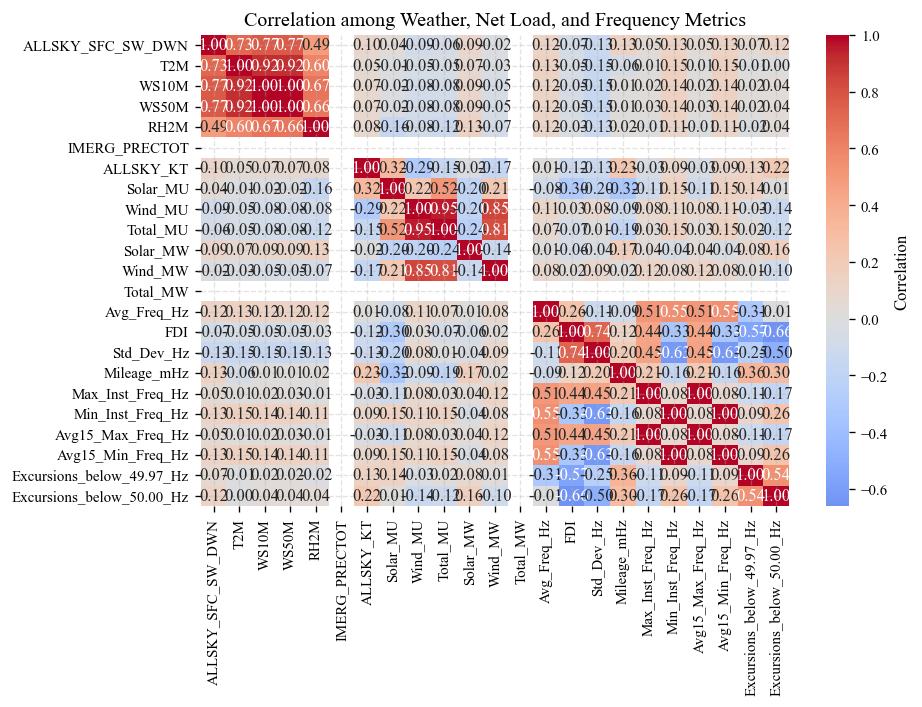

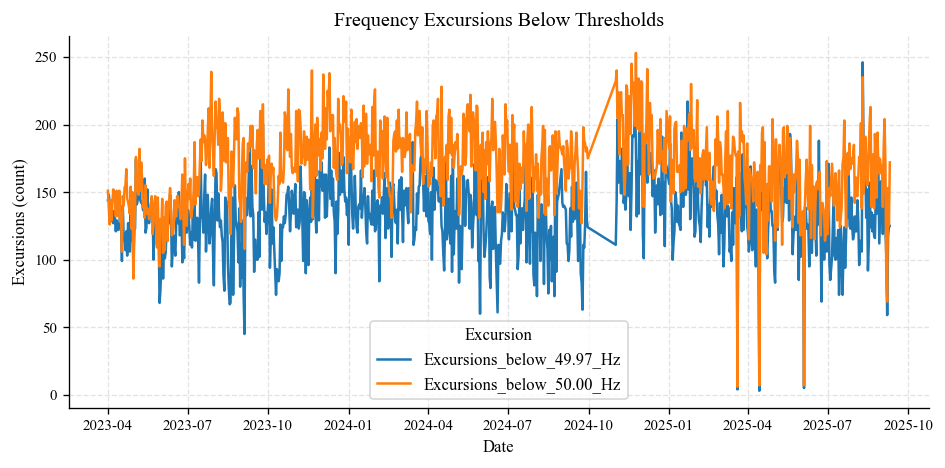

✅ Figures saved in: C:\Users\rjesh\figures


In [7]:
# ====================================================
# Q1-Style Exploratory Analysis on Master Dataset
# ====================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rcParams.update({
    "figure.dpi": 120, "savefig.dpi": 600,
    "font.family": "Times New Roman",
    "axes.titlesize": 12, "axes.labelsize": 11,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "axes.spines.top": False, "axes.spines.right": False,
    "grid.linestyle": "--", "grid.alpha": 0.35, "axes.grid": True,
})

# ---- Load merged dataset
df = pd.read_csv("master_dataset.csv", parse_dates=["Date"])
df = df.sort_values("Date")

# Create output folder
figdir = Path("figures"); figdir.mkdir(exist_ok=True)

# ---- 1. Net Load vs Demand & VRE ----
if {"Net_Load_MW","Demand_MW","Total_MW"}.issubset(df.columns):
    plt.figure(figsize=(8,4))
    plt.plot(df["Date"], df["Demand_MW"], label="Demand (MW)", lw=1)
    plt.plot(df["Date"], df["Total_MW"], label="Total VRE (MW)", lw=1)
    plt.plot(df["Date"], df["Net_Load_MW"], label="Net Load (MW)", lw=1.2, color="black")
    plt.xlabel("Date"); plt.ylabel("MW")
    plt.title("Daily Demand, VRE, and Net Load")
    plt.legend()
    plt.tight_layout()
    plt.savefig(figdir/"Fig1_NetLoad_TimeSeries.png", bbox_inches="tight")
    plt.show()

# ---- 2. Weather Drivers vs Net Load (correlation heatmap) ----
num_cols = df.select_dtypes("number").columns
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=True, fmt=".2f",
            cbar_kws={"label":"Correlation"})
plt.title("Correlation among Weather, Net Load, and Frequency Metrics")
plt.tight_layout()
plt.savefig(figdir/"Fig2_Correlation_Heatmap.png", bbox_inches="tight")
plt.show()

# ---- 3. Seasonal Boxplots (Net Load) ----
df["Month"] = df["Date"].dt.month
if "Net_Load_MW" in df.columns:
    plt.figure(figsize=(7,4))
    sns.boxplot(x="Month", y="Net_Load_MW", data=df, palette="Set2", showfliers=False)
    plt.xlabel("Month"); plt.ylabel("Net Load (MW)")
    plt.title("Seasonal Distribution of Net Load")
    plt.tight_layout()
    plt.savefig(figdir/"Fig3_Seasonal_NetLoad.png", bbox_inches="tight")
    plt.show()

# ---- 4. Frequency Stability vs Net Load ----
if {"Net_Load_MW","Avg_Freq_Hz"}.issubset(df.columns):
    plt.figure(figsize=(6,4))
    sns.scatterplot(x="Net_Load_MW", y="Avg_Freq_Hz", data=df, alpha=0.6, edgecolor=None)
    plt.xlabel("Net Load (MW)")
    plt.ylabel("Average Frequency (Hz)")
    plt.title("Relationship between Net Load and Frequency")
    plt.tight_layout()
    plt.savefig(figdir/"Fig4_NetLoad_vs_Frequency.png", bbox_inches="tight")
    plt.show()

# ---- 5. Frequency Excursions over Time ----
excursion_cols = [c for c in df.columns if "Excursions" in c]
if excursion_cols:
    df_exc = df[["Date"]+excursion_cols].melt("Date", var_name="Excursion", value_name="Count")
    plt.figure(figsize=(8,4))
    sns.lineplot(x="Date", y="Count", hue="Excursion", data=df_exc)
    plt.xlabel("Date"); plt.ylabel("Excursions (count)")
    plt.title("Frequency Excursions Below Thresholds")
    plt.tight_layout()
    plt.savefig(figdir/"Fig5_Frequency_Excursions.png", bbox_inches="tight")
    plt.show()

print("✅ Figures saved in:", figdir.resolve())


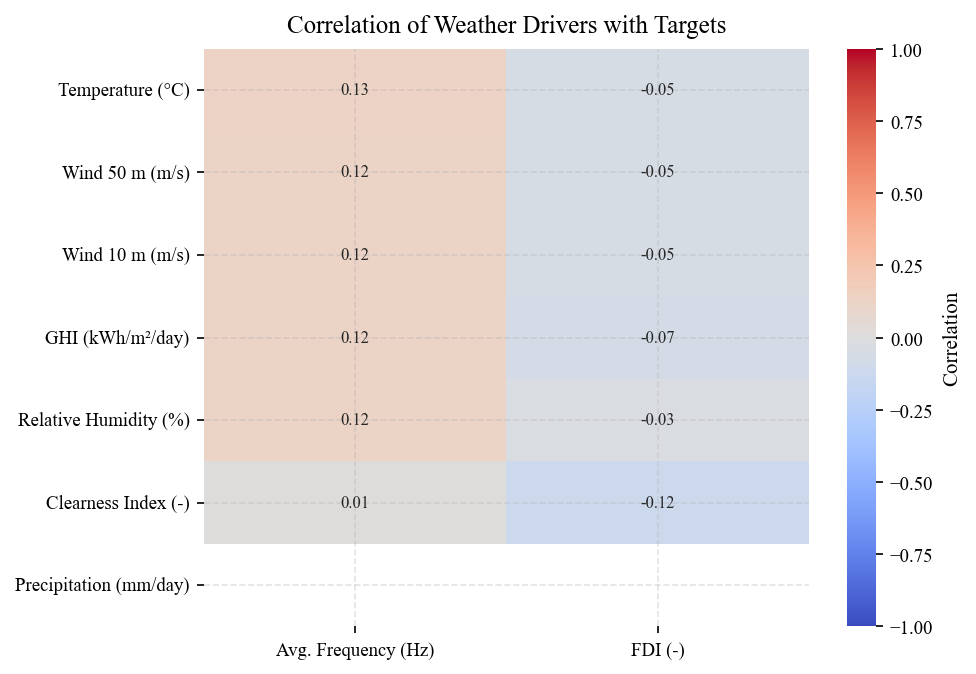

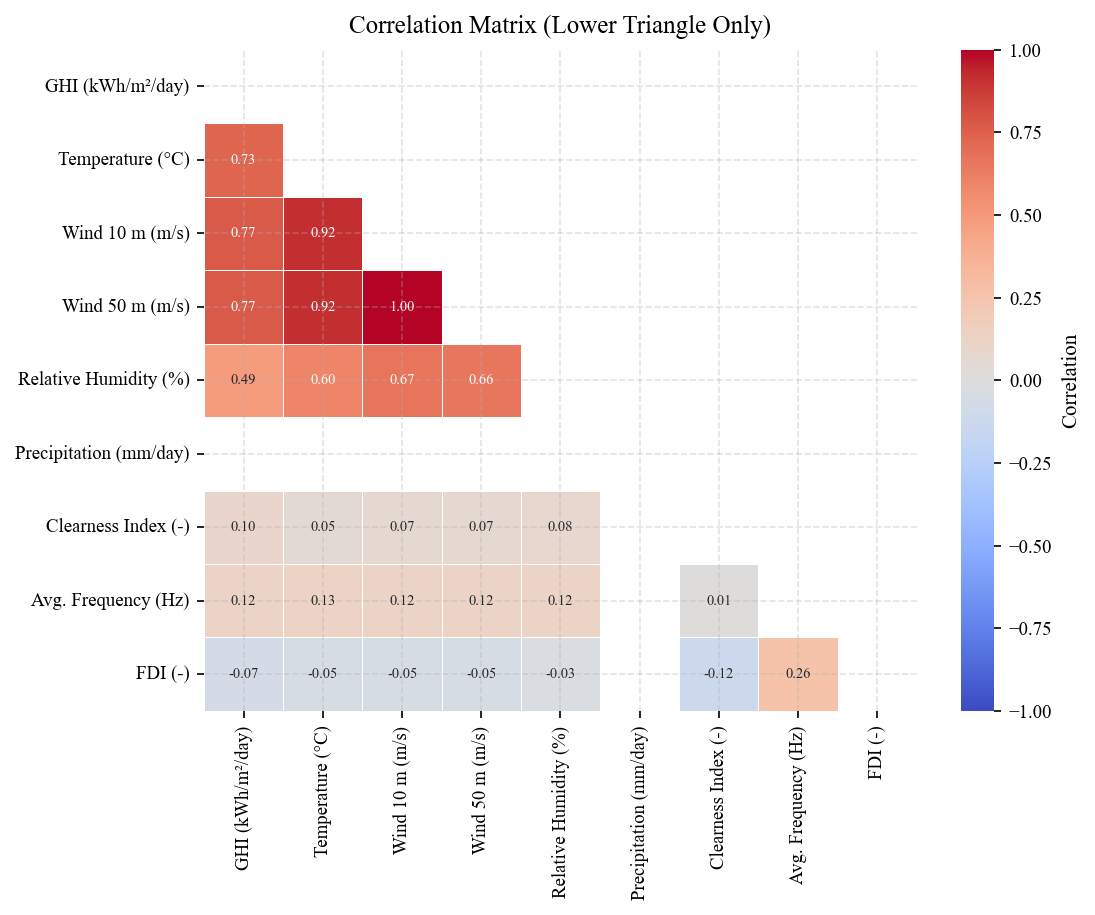

✅ Saved cleaned figures to ./figures


In [8]:
# =========================================================
# Clean, Q1-style correlation visuals (readable and compact)
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rcParams.update({
    "figure.dpi": 150, "savefig.dpi": 600,
    "font.family": "Times New Roman",
    "axes.titlesize": 12, "axes.labelsize": 11,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "axes.spines.top": False, "axes.spines.right": False,
})

df = pd.read_csv("master_dataset.csv", parse_dates=["Date"]).sort_values("Date")

# ---- choose tidy, non-redundant variables ----
weather_cols = [
    c for c in df.columns
    if any(k in c for k in ["ALLSKY_SFC_SW_DWN","T2M","WS10M","WS50M","RH2M","IMERG","PRECT","ALLSKY_KT","CLOUD"])
]
targets = [c for c in ["Net_Load_MW","Avg_Freq_Hz","FDI"] if c in df.columns]
use_cols = [c for c in weather_cols + targets if c in df.columns]

# numeric-only and drop rows with all-NaN across use_cols
d = df[use_cols].select_dtypes("number").dropna(how="all")

# Helpful pretty names (only if present)
rename = {
    "ALLSKY_SFC_SW_DWN":"GHI (kWh/m²/day)",
    "ALLSKY_KT":"Clearness Index (-)",
    "T2M":"Temperature (°C)",
    "WS10M":"Wind 10 m (m/s)",
    "WS50M":"Wind 50 m (m/s)",
    "RH2M":"Relative Humidity (%)",
    "IMERG_PRECTOT":"Precipitation (mm/day)",
    "Net_Load_MW":"Net Load (MW)",
    "Avg_Freq_Hz":"Avg. Frequency (Hz)",
    "FDI":"FDI (-)",
}
d = d.rename(columns={k:v for k,v in rename.items() if k in d.columns})

# --- (A) Weather vs Targets only (clean heatmap) ---
wx = [c for c in d.columns if c not in {"Net Load (MW)","Avg. Frequency (Hz)","FDI (-)"}]
tg = [c for c in d.columns if c in {"Net Load (MW)","Avg. Frequency (Hz)","FDI (-)"}]

corr = d[wx + tg].corr(method="pearson")
# keep only weather rows against target columns
corr_focus = corr.loc[wx, tg]

# order rows by |corr| with Net Load (if available), else by first target
main_t = "Net Load (MW)" if "Net Load (MW)" in corr_focus.columns else corr_focus.columns[0]
row_order = corr_focus[main_t].abs().sort_values(ascending=False).index
corr_focus = corr_focus.loc[row_order]

plt.figure(figsize=(6.6, 4.6))
ax = sns.heatmap(
    corr_focus.round(2),
    cmap="coolwarm", vmin=-1, vmax=1,
    annot=True, fmt=".2f", annot_kws={"size":8},
    cbar_kws={"label":"Correlation"}
)
ax.set_title("Correlation of Weather Drivers with Targets", pad=8)
plt.tight_layout()
Path("figures").mkdir(exist_ok=True)
plt.savefig("figures/Fig_Corr_Weather_vs_Targets.png", bbox_inches="tight")
plt.show()

# --- (B) Compact lower-triangle heatmap (all selected vars) ---
corr_all = d.corr(method="pearson").round(2)
mask = np.triu(np.ones_like(corr_all, dtype=bool))  # mask upper triangle

plt.figure(figsize=(7.5, 6.2))
ax = sns.heatmap(
    corr_all, mask=mask, cmap="coolwarm", vmin=-1, vmax=1,
    annot=True, fmt=".2f", annot_kws={"size":7},
    cbar_kws={"label":"Correlation"},
    linewidths=0.3, linecolor="white"
)
ax.set_title("Correlation Matrix (Lower Triangle Only)", pad=8)
plt.tight_layout()
plt.savefig("figures/Fig_Corr_LowerTriangle.png", bbox_inches="tight")
plt.show()

# --- (C) Bar chart: absolute correlation with Net Load (top 10) ---
if "Net Load (MW)" in d.columns:
    s = d.corr()["Net Load (MW)"].drop("Net Load (MW)").abs().sort_values(ascending=False).head(10)
    plt.figure(figsize=(6.4, 3.8))
    s.iloc[::-1].plot(kind="barh", color="#2f6f9f")
    plt.xlabel("Absolute Pearson Correlation")
    plt.title("Top Drivers Correlated with Net Load")
    plt.tight_layout()
    plt.savefig("figures/Fig_TopCorr_with_NetLoad.png", bbox_inches="tight")
    plt.show()

print("✅ Saved cleaned figures to ./figures")


In [1]:
# ============================================================
# EDA on Master Dataset (Net Load, Weather, Frequency)
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------------- Load Data ----------------
df = pd.read_csv("master_dataset.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print("✅ Dataset loaded. Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# ---------------- Data Quality ----------------
print("\n--- Missing Values (% per column) ---")
print((df.isna().mean()*100).round(2))

print("\n--- Descriptive Stats ---")
print(df.describe().T.round(2))

# ---------------- Create Figures Folder ----------------
figdir = Path("figures_eda"); figdir.mkdir(exist_ok=True)

plt.rcParams.update({
    "figure.dpi": 150, "savefig.dpi": 600,
    "font.family": "Times New Roman",
    "axes.titlesize": 12, "axes.labelsize": 11,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "axes.spines.top": False, "axes.spines.right": False,
    "grid.linestyle": "--", "grid.alpha": 0.4,
})

# ---------------- 1. Net Load Trend ----------------
if "Net_Load_MW" in df.columns:
    plt.figure(figsize=(9,4))
    plt.plot(df["Date"], df["Net_Load_MW"], lw=1, color="black")
    plt.xlabel("Date"); plt.ylabel("Net Load (MW)")
    plt.title("Daily Net Load Trend")
    plt.tight_layout()
    plt.savefig(figdir/"Fig1_NetLoad_Trend.png", bbox_inches="tight")
    plt.show()

# ---------------- 2. Weather vs Net Load ----------------
weather_vars = [c for c in df.columns if any(k in c.lower() for k in ["ghi","temp","wind","humid","precip","cloud"])]
for var in weather_vars[:4]:  # limit to 4 key vars
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[var], y=df["Net_Load_MW"], alpha=0.5, edgecolor=None)
    plt.xlabel(var); plt.ylabel("Net Load (MW)")
    plt.title(f"Net Load vs {var}")
    plt.tight_layout()
    plt.savefig(figdir/f"Fig2_NetLoad_vs_{var}.png", bbox_inches="tight")
    plt.show()

# ---------------- 3. Frequency Excursions ----------------
excursion_cols = [c for c in df.columns if "Excursions" in c]
if excursion_cols:
    df_exc = df[["Date"]+excursion_cols].melt("Date", var_name="Excursion", value_name="Count")
    plt.figure(figsize=(9,4))
    sns.lineplot(x="Date", y="Count", hue="Excursion", data=df_exc, lw=1)
    plt.xlabel("Date"); plt.ylabel("Excursions (Count)")
    plt.title("Frequency Excursions Over Time")
    plt.tight_layout()
    plt.savefig(figdir/"Fig3_Frequency_Excursions.png", bbox_inches="tight")
    plt.show()

# ---------------- 4. Seasonal Boxplot ----------------
if "Net_Load_MW" in df.columns:
    df["Month"] = df["Date"].dt.month
    plt.figure(figsize=(7,4))
    sns.boxplot(x="Month", y="Net_Load_MW", data=df, showfliers=False, palette="Set2")
    plt.xlabel("Month"); plt.ylabel("Net Load (MW)")
    plt.title("Seasonal Variation of Net Load")
    plt.tight_layout()
    plt.savefig(figdir/"Fig4_NetLoad_Seasonal_Boxplot.png", bbox_inches="tight")
    plt.show()

print("✅ EDA complete. Figures saved in:", figdir.resolve())


✅ Dataset loaded. Shape: (9431, 30)

Columns: ['ALLSKY_SFC_SW_DWN', 'T2M', 'WS10M', 'WS50M', 'RH2M', 'IMERG_PRECTOT', 'ALLSKY_KT', 'Date', 'Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Source_File_x', 'Avg_Freq_Hz', 'FDI', 'Std_Dev_Hz', 'Mileage_mHz', 'Max_Inst_Freq_Hz', 'Max_Inst_Time', 'Min_Inst_Freq_Hz', 'Min_Inst_Time', 'Avg15_Max_Freq_Hz', 'Avg15_Max_Time', 'Avg15_Min_Freq_Hz', 'Avg15_Min_Time', 'Excursions_below_49.97_Hz', 'Excursions_below_50.00_Hz', 'Source_File_y']

--- Missing Values (% per column) ---
ALLSKY_SFC_SW_DWN              0.01
T2M                            0.01
WS10M                          0.01
WS50M                          0.01
RH2M                           0.01
IMERG_PRECTOT                  0.01
ALLSKY_KT                      0.01
Date                           0.01
Solar_MU                      97.35
Wind_MU                       97.36
Total_MU                      97.36
Solar_MW                      97.36
Wind_MW                  

KeyError: 'Net_Load_MW'

<Figure size 900x600 with 0 Axes>

Columns: ['ALLSKY_SFC_SW_DWN', 'T2M', 'WS10M', 'WS50M', 'RH2M', 'IMERG_PRECTOT', 'ALLSKY_KT', 'Date', 'Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Source_File_x', 'Avg_Freq_Hz', 'FDI', 'Std_Dev_Hz', 'Mileage_mHz', 'Max_Inst_Freq_Hz', 'Max_Inst_Time', 'Min_Inst_Freq_Hz', 'Min_Inst_Time', 'Avg15_Max_Freq_Hz', 'Avg15_Max_Time', 'Avg15_Min_Freq_Hz', 'Avg15_Min_Time', 'Excursions_below_49.97_Hz', 'Excursions_below_50.00_Hz', 'Source_File_y']
Net_Load_MW exists? False

Missing %:
 ALLSKY_SFC_SW_DWN              0.06
T2M                            0.04
WS10M                          0.04
WS50M                          0.04
RH2M                           0.04
IMERG_PRECTOT                100.00
ALLSKY_KT                      5.08
Date                           0.01
Solar_MU                      97.35
Wind_MU                       97.36
Total_MU                      97.36
Solar_MW                      97.36
Wind_MW                       97.36
Total_MW                  

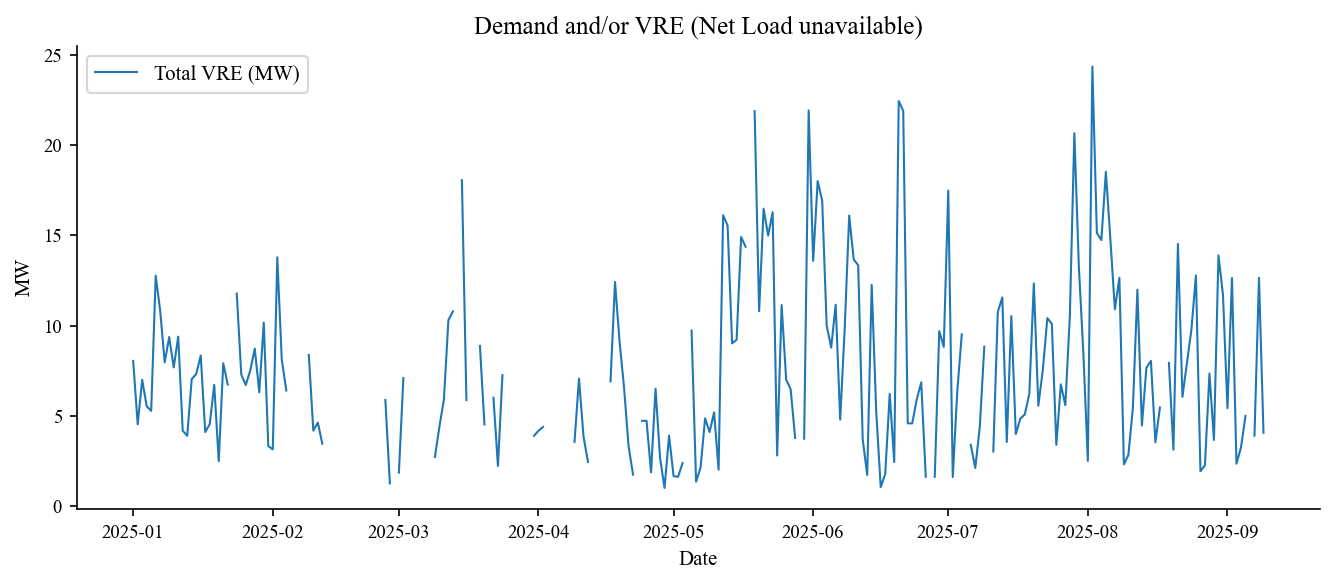

⚠️ No Net_Load_MW or Demand column found. Skipping weather-vs-target scatterplots.


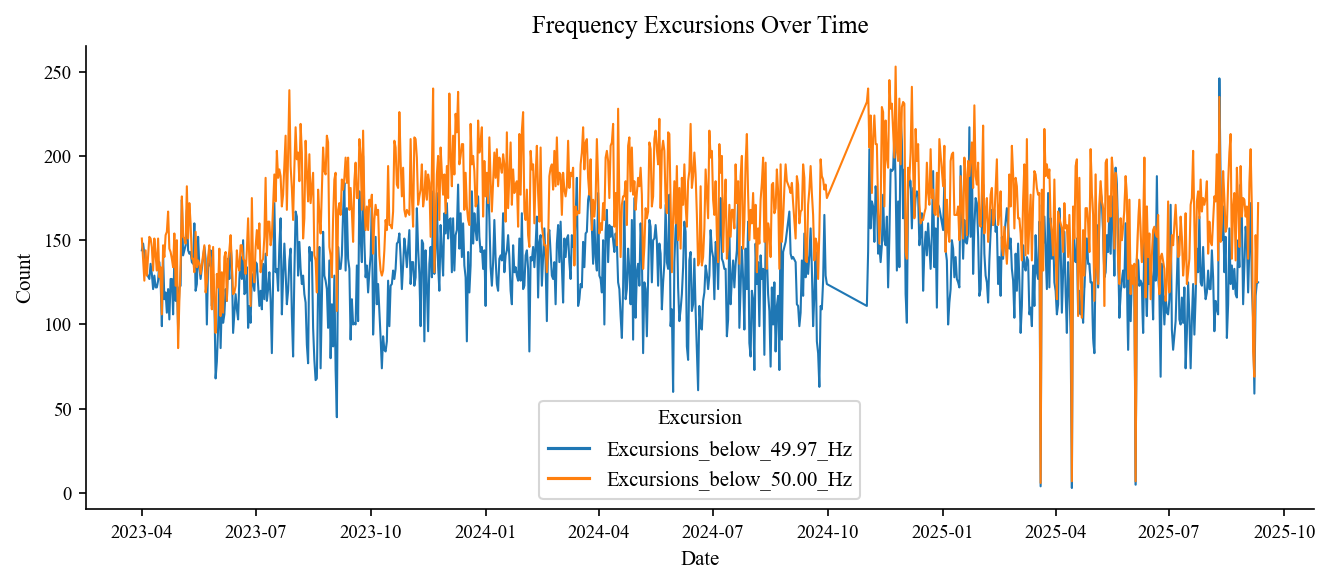

✅ EDA figures saved to: C:\Users\rjesh\figures_eda


In [1]:
# ============================================
# Robust EDA (handles missing Net_Load_MW)
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

df = pd.read_csv("master_dataset.csv", parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)

# ---------- Clean NASA sentinels ----------
weather_cols = [c for c in df.columns if c.upper() in
                ["ALLSKY_SFC_SW_DWN","T2M","WS10M","WS50M","RH2M","IMERG_PRECTOT","ALLSKY_KT"]]
for c in weather_cols:
    if c in df.columns:
        df.loc[df[c] <= -90, c] = np.nan  # drop -999 etc.

# ---------- Build VRE totals ----------
# Prefer reported Total_MW; else sum Solar+Wind MW; else convert MU -> avg MW
if "Total_MW" not in df.columns or df["Total_MW"].isna().all():
    smw = df["Solar_MW"] if "Solar_MW" in df.columns else np.nan
    wmw = df["Wind_MW"]  if "Wind_MW"  in df.columns else np.nan
    df["Total_MW"] = smw + wmw

if df["Total_MW"].isna().all() and "Total_MU" in df.columns:
    df["Total_MW"] = df["Total_MU"] * 1000.0 / 24.0  # MU -> average MW

# ---------- Try to compute Net Load (only if demand exists) ----------
demand_candidates = ["Demand_MW","Demand (MW)","Total_Demand_MW","All_India_Demand_MW"]
demand_col = next((c for c in demand_candidates if c in df.columns), None)

if demand_col is not None:
    if "Total_MW" in df.columns:
        df["Net_Load_MW"] = df[demand_col] - df["Total_MW"]

# ---------- Report what we have ----------
print("Columns:", df.columns.tolist())
print("Net_Load_MW exists?", "Net_Load_MW" in df.columns)
print("\nMissing %:\n", (df.isna().mean()*100).round(2))

# ---------- Figure style ----------
plt.rcParams.update({
    "figure.dpi": 150, "savefig.dpi": 600,
    "font.family": "Times New Roman",
    "axes.titlesize": 12, "axes.labelsize": 11,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "axes.spines.top": False, "axes.spines.right": False,
    "grid.linestyle": "--", "grid.alpha": 0.35,
})
figdir = Path("figures_eda"); figdir.mkdir(exist_ok=True)

# ---------- 1) Timeseries overview ----------
if "Net_Load_MW" in df.columns:
    plt.figure(figsize=(9,4))
    if demand_col: plt.plot(df["Date"], df[demand_col], label="Demand (MW)", lw=1)
    if "Total_MW" in df.columns: plt.plot(df["Date"], df["Total_MW"], label="Total VRE (MW)", lw=1)
    plt.plot(df["Date"], df["Net_Load_MW"], label="Net Load (MW)", lw=1.2, color="black")
    plt.xlabel("Date"); plt.ylabel("MW"); plt.title("Demand, VRE and Net Load")
    plt.legend(); plt.tight_layout(); plt.savefig(figdir/"Fig1_NetLoad_Timeseries.png", bbox_inches="tight"); plt.show()
elif demand_col or ("Total_MW" in df.columns and not df["Total_MW"].isna().all()):
    plt.figure(figsize=(9,4))
    if demand_col: plt.plot(df["Date"], df[demand_col], label="Demand (MW)", lw=1)
    if "Total_MW" in df.columns: plt.plot(df["Date"], df["Total_MW"], label="Total VRE (MW)", lw=1)
    plt.xlabel("Date"); plt.ylabel("MW"); plt.title("Demand and/or VRE (Net Load unavailable)")
    plt.legend(); plt.tight_layout(); plt.savefig(figdir/"Fig1_Demand_VRE_Timeseries.png", bbox_inches="tight"); plt.show()

# ---------- 2) Weather vs Target (auto-chooses target) ----------
target = "Net_Load_MW" if "Net_Load_MW" in df.columns else (demand_col if demand_col else None)
if target:
    wvars = [c for c in weather_cols if c in df.columns]
    for var in wvars[:4]:  # top 4
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df[var], y=df[target], alpha=0.5, edgecolor=None)
        plt.xlabel(var); plt.ylabel(target.replace("_"," "))
        plt.title(f"{target.replace('_',' ')} vs {var}")
        plt.tight_layout(); plt.savefig(figdir/f"Fig2_{target}_vs_{var}.png", bbox_inches="tight"); plt.show()
else:
    print("⚠️ No Net_Load_MW or Demand column found. Skipping weather-vs-target scatterplots.")

# ---------- 3) Frequency excursions ----------
exc_cols = [c for c in df.columns if "Excursions" in c]
if exc_cols:
    dfx = df[["Date"]+exc_cols].melt("Date", var_name="Excursion", value_name="Count")
    plt.figure(figsize=(9,4))
    sns.lineplot(x="Date", y="Count", hue="Excursion", data=dfx, lw=1)
    plt.xlabel("Date"); plt.ylabel("Count"); plt.title("Frequency Excursions Over Time")
    plt.tight_layout(); plt.savefig(figdir/"Fig3_Frequency_Excursions.png", bbox_inches="tight"); plt.show()

# ---------- 4) Seasonal (if Net Load exists) ----------
if "Net_Load_MW" in df.columns:
    df["Month"] = df["Date"].dt.month
    plt.figure(figsize=(7,4))
    sns.boxplot(x="Month", y="Net_Load_MW", data=df, showfliers=False, palette="Set2")
    plt.xlabel("Month"); plt.ylabel("Net Load (MW)"); plt.title("Seasonal Variation of Net Load")
    plt.tight_layout(); plt.savefig(figdir/"Fig4_NetLoad_Seasonal.png", bbox_inches="tight"); plt.show()

print("✅ EDA figures saved to:", figdir.resolve())


✅ Dataset loaded. Shape: (9431, 30)
⚠️ No demand column found → Net Load cannot be computed

--- Missing Values (% per column) ---
ALLSKY_SFC_SW_DWN              0.06
T2M                            0.04
WS10M                          0.04
WS50M                          0.04
RH2M                           0.04
IMERG_PRECTOT                100.00
ALLSKY_KT                      5.08
Date                           0.01
Solar_MU                      97.35
Wind_MU                       97.36
Total_MU                      97.36
Solar_MW                      97.36
Wind_MW                       97.36
Total_MW                      97.36
Source_File_x                 97.35
Avg_Freq_Hz                   90.47
FDI                           90.48
Std_Dev_Hz                    90.47
Mileage_mHz                   90.47
Max_Inst_Freq_Hz              90.48
Max_Inst_Time                 90.48
Min_Inst_Freq_Hz              90.48
Min_Inst_Time                 90.48
Avg15_Max_Freq_Hz             90.48
Avg15

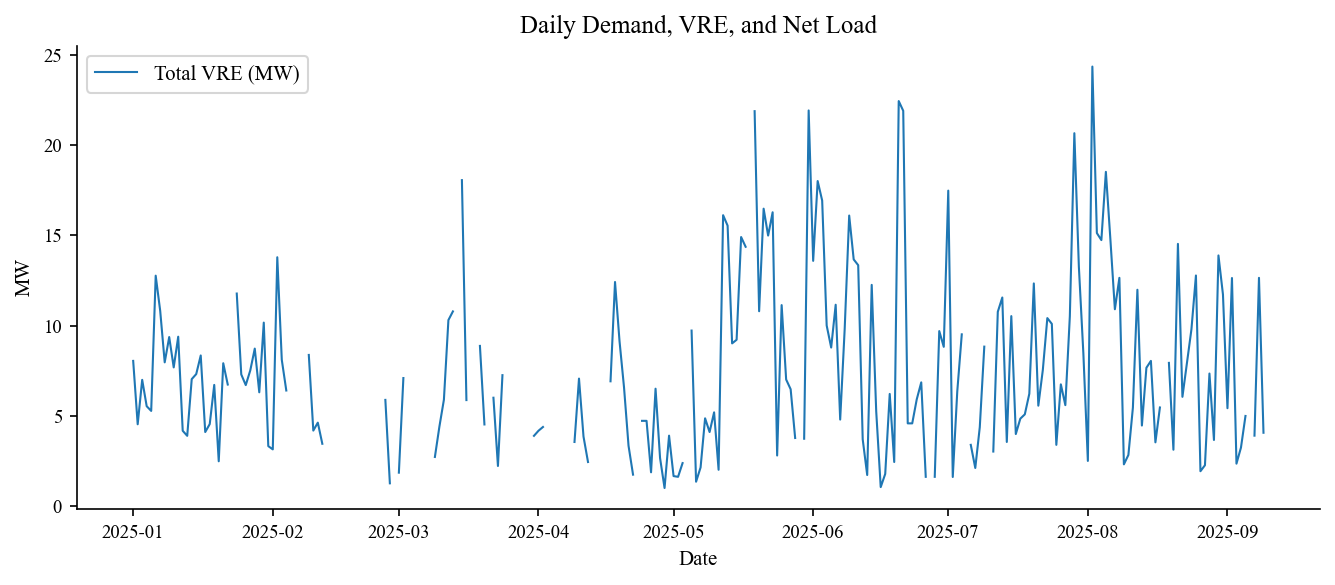

⚠️ No target (Net Load or Demand) available for weather correlation plots.


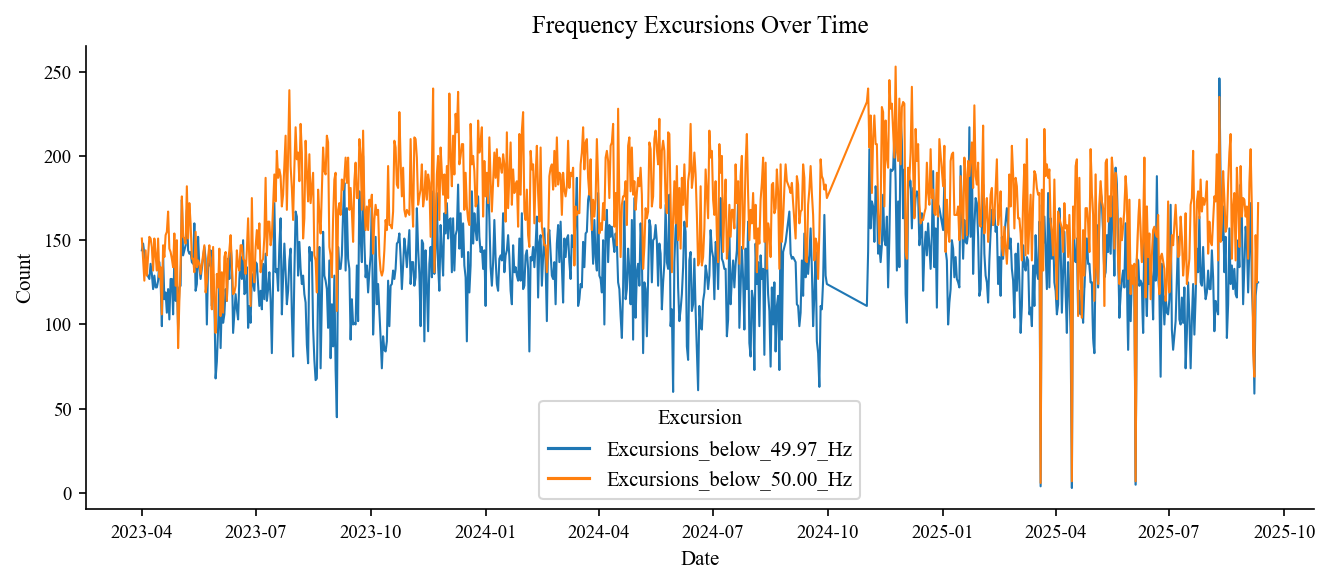

✅ EDA complete. Figures saved in: C:\Users\rjesh\figures_eda


In [3]:
# ============================================================
# Robust EDA with Demand & Net Load Support
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------- Load Master Dataset ----------
df = pd.read_csv("master_dataset.csv", parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)
print("✅ Dataset loaded. Shape:", df.shape)

# ---------- Clean NASA Weather ----------
weather_cols = ["ALLSKY_SFC_SW_DWN","T2M","WS10M","WS50M","RH2M","IMERG_PRECTOT","ALLSKY_KT"]
for c in weather_cols:
    if c in df.columns:
        df.loc[df[c] <= -90, c] = np.nan  # remove -999 sentinels

# ---------- Construct VRE Totals ----------
if "Total_MW" not in df.columns or df["Total_MW"].isna().all():
    smw = df["Solar_MW"] if "Solar_MW" in df.columns else 0
    wmw = df["Wind_MW"]  if "Wind_MW"  in df.columns else 0
    df["Total_MW"] = smw + wmw

if df["Total_MW"].isna().all() and "Total_MU" in df.columns:
    df["Total_MW"] = df["Total_MU"] * 1000.0 / 24.0  # MU → avg MW

# ---------- Detect Demand ----------
demand_candidates = ["Demand_MW","Demand (MW)","Total_Demand_MW","All_India_Demand_MW"]
demand_col = next((c for c in demand_candidates if c in df.columns), None)

# ---------- Compute Net Load ----------
if demand_col:
    df["Net_Load_MW"] = df[demand_col] - df["Total_MW"]
    print("✅ Net Load computed using:", demand_col)
else:
    print("⚠️ No demand column found → Net Load cannot be computed")

# ---------- Report Missingness ----------
print("\n--- Missing Values (% per column) ---")
print((df.isna().mean()*100).round(2))

# ---------- Plot Style ----------
plt.rcParams.update({
    "figure.dpi": 150, "savefig.dpi": 600,
    "font.family": "Times New Roman",
    "axes.titlesize": 12, "axes.labelsize": 11,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "axes.spines.top": False, "axes.spines.right": False,
    "grid.linestyle": "--", "grid.alpha": 0.35,
})
figdir = Path("figures_eda"); figdir.mkdir(exist_ok=True)

# ============================================================
# 1) Timeseries: Demand, VRE, Net Load
# ============================================================
plt.figure(figsize=(9,4))
if demand_col: plt.plot(df["Date"], df[demand_col], label="Demand (MW)", lw=1)
if "Total_MW" in df.columns: plt.plot(df["Date"], df["Total_MW"], label="Total VRE (MW)", lw=1)
if "Net_Load_MW" in df.columns: plt.plot(df["Date"], df["Net_Load_MW"], label="Net Load (MW)", lw=1.2, color="black")
plt.xlabel("Date"); plt.ylabel("MW"); plt.title("Daily Demand, VRE, and Net Load")
plt.legend(); plt.tight_layout(); plt.savefig(figdir/"Fig1_Demand_VRE_NetLoad.png", bbox_inches="tight"); plt.show()

# ============================================================
# 2) Weather vs Net Load (if available)
# ============================================================
target = "Net_Load_MW" if "Net_Load_MW" in df.columns else demand_col
if target:
    wvars = [c for c in weather_cols if c in df.columns]
    for var in wvars[:4]:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df[var], y=df[target], alpha=0.5, edgecolor=None)
        plt.xlabel(var); plt.ylabel(target.replace("_"," "))
        plt.title(f"{target.replace('_',' ')} vs {var}")
        plt.tight_layout(); plt.savefig(figdir/f"Fig2_{target}_vs_{var}.png", bbox_inches="tight"); plt.show()
else:
    print("⚠️ No target (Net Load or Demand) available for weather correlation plots.")

# ============================================================
# 3) Frequency Excursions
# ============================================================
exc_cols = [c for c in df.columns if "Excursions" in c]
if exc_cols:
    dfx = df[["Date"]+exc_cols].melt("Date", var_name="Excursion", value_name="Count")
    plt.figure(figsize=(9,4))
    sns.lineplot(x="Date", y="Count", hue="Excursion", data=dfx, lw=1)
    plt.xlabel("Date"); plt.ylabel("Count"); plt.title("Frequency Excursions Over Time")
    plt.tight_layout(); plt.savefig(figdir/"Fig3_Frequency_Excursions.png", bbox_inches="tight"); plt.show()

# ============================================================
# 4) Seasonal Boxplot (Net Load if exists)
# ============================================================
if "Net_Load_MW" in df.columns:
    df["Month"] = df["Date"].dt.month
    plt.figure(figsize=(7,4))
    sns.boxplot(x="Month", y="Net_Load_MW", data=df, showfliers=False, palette="Set2")
    plt.xlabel("Month"); plt.ylabel("Net Load (MW)"); plt.title("Seasonal Variation of Net Load")
    plt.tight_layout(); plt.savefig(figdir/"Fig4_NetLoad_Seasonal.png", bbox_inches="tight"); plt.show()

print("✅ EDA complete. Figures saved in:", figdir.resolve())



In [4]:
# ============================================================
# VRE PDF Extractor (now includes Demand_MW)
# Reads PDFs in ./vre_reports and writes vre_reports_clean.csv
# ============================================================
import pdfplumber, re, os, math
import pandas as pd
from pathlib import Path
from datetime import datetime

IN_DIR  = Path("vre_reports")
OUT_CSV = Path("vre_reports_clean.csv")
IN_DIR.mkdir(exist_ok=True)

def _safe_float(x):
    if x is None: return math.nan
    x = str(x).strip().replace(",", "")
    try: return float(x)
    except: return math.nan

def extract_date_from_filename(fname: str):
    """
    Works for names like:
      06.07.2025_NLDC_REMC_REPORT_612.pdf
      2025-07-06_vre.pdf
      vre_06-07-25.pdf
    """
    s = fname.replace("_", " ").replace("-", " ").replace(".", " ")
    m = re.search(r'(?P<d>\d{1,2})\s+(?P<m>\d{1,2})\s+(?P<y>\d{2,4})', s)
    if m:
        d, m_, y = int(m.group("d")), int(m.group("m")), int(m.group("y"))
        if y < 100: y += 2000
        try:
            return datetime(y, m_, d).date()
        except: pass
    # fallback: look inside text later
    return None

def extract_date_from_text(text: str):
    # DD/MM/YYYY or DD.MM.YYYY or DD-MM-YYYY
    m = re.search(r'(\d{1,2})[\/\.\-](\d{1,2})[\/\.\-](\d{4})', text)
    if m:
        d, m_, y = map(int, m.groups())
        try:
            return datetime(y, m_, d).date()
        except: pass
    # 06 Jul 2025
    m = re.search(r'(\d{1,2})\s+([A-Za-z]{3,})\s+(\d{4})', text)
    if m:
        d, mon, y = m.groups()
        try:
            return datetime.strptime(f"{d} {mon} {y}", "%d %b %Y").date()
        except:
            try:
                return datetime.strptime(f"{d} {mon} {y}", "%d %B %Y").date()
            except: pass
    return None

# --- Build flexible regex helpers --------------------------------
def grab_first(text, patterns):
    """Return the first numeric match for any of the regex patterns."""
    for pat in patterns:
        m = re.search(pat, text, flags=re.IGNORECASE)
        if m:
            return _safe_float(m.group(1))
    return math.nan

# Common labels that appear across REMC daily PDFs
PAT_SOLAR_MU = [
    r"Solar\s*[:\-]?\s*([0-9.,]+)\s*MU",
    r"Solar\s*MU\s*[:\-]?\s*([0-9.,]+)",
]
PAT_WIND_MU = [
    r"Wind\s*[:\-]?\s*([0-9.,]+)\s*MU",
    r"Wind\s*MU\s*[:\-]?\s*([0-9.,]+)",
]
PAT_TOTAL_MU = [
    r"Total\s*(?:RE|VRE|Renewable).*?([0-9.,]+)\s*MU",
    r"Total\s*MU\s*[:\-]?\s*([0-9.,]+)",
]

PAT_SOLAR_MW = [
    r"Solar\s*\(MW\)\s*[:\-]?\s*([0-9.,]+)",
    r"Solar\s*Generation\s*\(MW\)\s*[:\-]?\s*([0-9.,]+)",
]
PAT_WIND_MW = [
    r"Wind\s*\(MW\)\s*[:\-]?\s*([0-9.,]+)",
    r"Wind\s*Generation\s*\(MW\)\s*[:\-]?\s*([0-9.,]+)",
]
PAT_TOTAL_MW = [
    r"Total\s*(?:RE|VRE|Renewable).*?\(MW\)\s*[:\-]?\s*([0-9.,]+)",
    r"Total\s*MW\s*[:\-]?\s*([0-9.,]+)",
]

# Demand is inconsistently labeled; cover many variants:
PAT_DEMAND = [
    r"(?:All\s*India\s*)?Demand\s*(?:Met|)\s*\(MW\)\s*[:\-]?\s*([0-9.,]+)",
    r"(?:All\s*India\s*)?Total\s*Demand\s*\(MW\)\s*[:\-]?\s*([0-9.,]+)",
    r"System\s*Demand\s*\(MW\)\s*[:\-]?\s*([0-9.,]+)",
    r"Demand\s*[:\-]?\s*([0-9.,]+)\s*MW",
]

def parse_vre_pdf(path: Path):
    """Return a dict of extracted metrics from a single VRE daily PDF."""
    with pdfplumber.open(path) as pdf:
        text = "\n".join(page.extract_text() or "" for page in pdf.pages)

    # date
    date = extract_date_from_filename(path.name) or extract_date_from_text(text)

    # numbers
    solar_mu  = grab_first(text, PAT_SOLAR_MU)
    wind_mu   = grab_first(text, PAT_WIND_MU)
    total_mu  = grab_first(text, PAT_TOTAL_MU)

    solar_mw  = grab_first(text, PAT_SOLAR_MW)
    wind_mw   = grab_first(text, PAT_WIND_MW)
    total_mw  = grab_first(text, PAT_TOTAL_MW)

    demand_mw = grab_first(text, PAT_DEMAND)

    # sanity helpers: if totals are missing but parts exist, sum them
    if math.isnan(total_mu) and not math.isnan(solar_mu) and not math.isnan(wind_mu):
        total_mu = solar_mu + wind_mu
    if math.isnan(total_mw) and not math.isnan(solar_mw) and not math.isnan(wind_mw):
        total_mw = solar_mw + wind_mw

    return {
        "Date": date,
        "Solar_MU": solar_mu,
        "Wind_MU":  wind_mu,
        "Total_MU": total_mu,
        "Solar_MW": solar_mw,
        "Wind_MW":  wind_mw,
        "Total_MW": total_mw,
        "Demand_MW": demand_mw,
        "Source_File": path.name,
    }

# --------- Run over folder and save CSV --------------------------
rows = []
for f in sorted(IN_DIR.glob("*.pdf")):
    try:
        rec = parse_vre_pdf(f)
        rows.append(rec)
        missing = [k for k, v in rec.items() if k not in ("Source_File","Date") and (pd.isna(v) or v == "")]
        if missing:
            print(f"⚠️  {f.name}: missing {missing}")
        else:
            print(f"✅  {f.name}: ok")
    except Exception as e:
        print(f"❌  Error parsing {f.name}: {e}")

df = pd.DataFrame(rows)

# Normalize dates and drop rows w/o date
df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.date
df = df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# Optional: coerce to numeric
for c in ["Solar_MU","Wind_MU","Total_MU","Solar_MW","Wind_MW","Total_MW","Demand_MW"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df.to_csv(OUT_CSV, index=False)
print(f"\n✅ Saved: {OUT_CSV}  (rows={len(df)})")
display(df.tail())


⚠️  01.01.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  01.02.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  01.03.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  01.04.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  01.05.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  01.06.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  01.07.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  01.08.2025_NLDC_REMC_REPORT_128.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  01.09.2025-NLDC-REMC-REPORT_770.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU'

⚠️  10.07.2025_NLDC_REMC_REPORT_798.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  10.08.2025_NLDC_REMC_REPORT_976.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  11.01.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  11.02.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  11.03.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  11.04.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  11.05.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  11.06.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  11.07.2025_NLDC_REMC_REPORT_690.pdf: missing ['Solar_MU', 

⚠️  21.07.2025_NLDC_REMC_REPORT_182.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  21.08.2025_NLDC_REMC_REPORT_469.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  22.01.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  22.03.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  22.04.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  22.05.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  22.06.2025.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  22.07.2025_NLDC_REMC_REPORT_630.pdf: missing ['Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW', 'Wind_MW', 'Total_MW', 'Demand_MW']
⚠️  22.08.2025_NLDC_REMC_REPORT_175.pdf: 

Date  Solar_MU  Wind_MU  Total_MU  Solar_MW  Wind_MW  Total_MW  \
199  2025-09-04       NaN      NaN       NaN       NaN      NaN       NaN   
200  2025-09-05       NaN      NaN       NaN       NaN      NaN       NaN   
201  2025-09-07       NaN      NaN       NaN       NaN      NaN       NaN   
202  2025-09-08       NaN      NaN       NaN       NaN      NaN       NaN   
203  2025-09-09       NaN      NaN       NaN       NaN      NaN       NaN   

     Demand_MW                          Source_File  
199        NaN  04.09.2025_NLDC_REMC_REPORT_110.pdf  
200        NaN  05.09.2025_NLDC_REMC_REPORT_409.pdf  
201        NaN  07.09.2025_NLDC_REMC_REPORT_275.pdf  
202        NaN  08.09.2025_NLDC_REMC_REPORT_759.pdf  
203        NaN  09.09.2025_NLDC_REMC_REPORT_189.pdf

In [5]:
# ============================================================
# VRE PDF Extractor (text + OCR fallback) with Demand_MW
# Reads PDFs in ./vre_reports and writes vre_reports_clean.csv
# ============================================================
import os, re, math
import pandas as pd
from pathlib import Path
from datetime import datetime

# PDF text + OCR
import pdfplumber
from pdf2image import convert_from_path
import pytesseract
import numpy as np
import cv2

# ---- If on Windows, set your Tesseract path (uncomment and edit) ----
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

IN_DIR  = Path("vre_reports")
OUT_CSV = Path("vre_reports_clean.csv")
IN_DIR.mkdir(exist_ok=True)

def _safe_float(x):
    if x is None: return math.nan
    x = str(x)
    x = x.replace(",", "").replace("\u2009","").replace("\u00a0"," ").strip()
    # Remove trailing unit refs
    x = re.sub(r"[^\d.\-]+$", "", x)
    try:
        return float(x)
    except:
        return math.nan

def _clean_text(s: str) -> str:
    s = s or ""
    # Normalize spaces, remove weird hyphens, NBSPs etc.
    s = s.replace("\u00a0", " ").replace("\u2013","-").replace("\u2014","-")
    s = re.sub(r"[ \t]+", " ", s)
    return s

def extract_date_from_filename(fname: str):
    # Matches e.g., 06.07.2025, 2025-07-06, 06_09_2025, etc.
    s = fname.replace("_", " ").replace("-", " ").replace(".", " ")
    m = re.search(r'(?P<d>\d{1,2})\s+(?P<m>\d{1,2})\s+(?P<y>\d{2,4})', s)
    if m:
        d, m_, y = int(m.group("d")), int(m.group("m")), int(m.group("y"))
        if y < 100: y += 2000
        try:
            return datetime(y, m_, d).date()
        except:
            pass
    return None

def extract_date_from_text(text: str):
    text = _clean_text(text)
    # DD/MM/YYYY or DD.MM.YYYY or DD-MM-YYYY
    m = re.search(r'(\d{1,2})[\/\.\-](\d{1,2})[\/\.\-](\d{4})', text)
    if m:
        d, m_, y = map(int, m.groups())
        try:
            return datetime(y, m_, d).date()
        except:
            pass
    # 06 Jul 2025
    m = re.search(r'(\d{1,2})\s+([A-Za-z]{3,})\s+(\d{4})', text)
    if m:
        d, mon, y = m.groups()
        for fmt in ("%d %b %Y", "%d %B %Y"):
            try:
                return datetime.strptime(f"{d} {mon} {y}", fmt).date()
            except:
                continue
    return None

# Patterns (broad coverage)
PAT_SOLAR_MU = [
    r"Solar\s*(?:Generation\s*)?(?:\(MU\))?\s*[:\-]?\s*([0-9.,]+)\s*MU",
    r"Solar\s*MU\s*[:\-]?\s*([0-9.,]+)",
]
PAT_WIND_MU = [
    r"Wind\s*(?:Generation\s*)?(?:\(MU\))?\s*[:\-]?\s*([0-9.,]+)\s*MU",
    r"Wind\s*MU\s*[:\-]?\s*([0-9.,]+)",
]
PAT_TOTAL_MU = [
    r"Total\s*(?:RE|VRE|Renewable)[^0-9]+([0-9.,]+)\s*MU",
    r"Total\s*MU\s*[:\-]?\s*([0-9.,]+)",
]

PAT_SOLAR_MW = [
    r"Solar\s*(?:Generation\s*)?\(MW\)\s*[:\-]?\s*([0-9.,]+)",
    r"Solar\s*MW\s*[:\-]?\s*([0-9.,]+)",
]
PAT_WIND_MW = [
    r"Wind\s*(?:Generation\s*)?\(MW\)\s*[:\-]?\s*([0-9.,]+)",
    r"Wind\s*MW\s*[:\-]?\s*([0-9.,]+)",
]
PAT_TOTAL_MW = [
    r"Total\s*(?:RE|VRE|Renewable)[^0-9]+([0-9.,]+)\s*MW",
    r"Total\s*MW\s*[:\-]?\s*([0-9.,]+)",
]

# Demand variants
PAT_DEMAND = [
    r"(?:All\s*India\s*)?Demand\s*(?:Met|)\s*\(MW\)\s*[:\-]?\s*([0-9.,]+)",
    r"(?:All\s*India\s*)?Total\s*Demand\s*\(MW\)\s*[:\-]?\s*([0-9.,]+)",
    r"System\s*Demand\s*\(MW\)\s*[:\-]?\s*([0-9.,]+)",
    r"Demand\s*[:\-]?\s*([0-9.,]+)\s*MW",
]

# Extra table-like patterns (row style: "Solar  21.35   Wind 14.66   Total 36.01  (MU)")
PAT_TABLE_MU = [
    r"Solar[^0-9]+([0-9.,]+)[^\n]*Wind[^0-9]+([0-9.,]+)[^\n]*Total[^0-9]+([0-9.,]+)\s*MU",
]
PAT_TABLE_MW = [
    r"Solar[^0-9]+([0-9.,]+)[^\n]*Wind[^0-9]+([0-9.,]+)[^\n]*Total[^0-9]+([0-9.,]+)\s*MW",
]

def grab_first(text, patterns):
    for pat in patterns:
        m = re.search(pat, text, flags=re.IGNORECASE)
        if m:
            return _safe_float(m.group(1))
    return math.nan

def try_table_triplet(text, patterns):
    for pat in patterns:
        m = re.search(pat, text, flags=re.IGNORECASE)
        if m:
            a = _safe_float(m.group(1))
            b = _safe_float(m.group(2))
            c = _safe_float(m.group(3))
            return a, b, c
    return (math.nan, math.nan, math.nan)

def read_pdf_text(path: Path) -> str:
    """Try pdfplumber first; if empty/poor, fallback to OCR (first 2 pages)."""
    text_chunks = []
    try:
        with pdfplumber.open(path) as pdf:
            for page in pdf.pages:
                t = page.extract_text() or ""
                text_chunks.append(t)
        text = "\n".join(text_chunks)
        if len(_clean_text(text)) > 150:  # seems actual text
            return text
    except:
        pass

    # --- OCR fallback ---
    try:
        pages = convert_from_path(str(path), dpi=300)
        ocr_texts = []
        for i, im in enumerate(pages[:2]):   # 1–2 pages is usually enough
            # preprocessing: grayscale → threshold
            img = np.array(im)
            if img.ndim == 3:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray = img
            # adaptive threshold
            thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                        cv2.THRESH_BINARY, 35, 15)
            # OCR
            # Keep both a general pass and a numeric-biased pass to catch stubborn numbers
            txt1 = pytesseract.image_to_string(thr, config="--psm 3")
            txt2 = pytesseract.image_to_string(thr, config='--psm 6 -c tessedit_char_whitelist=0123456789.,:/()-ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ')
            ocr_texts.append(txt1 + "\n" + txt2)
        ocr = "\n".join(ocr_texts)
        return ocr
    except Exception as e:
        return ""

def parse_vre_pdf(path: Path):
    text = read_pdf_text(path)
    text = _clean_text(text)

    # ---- Date ----
    date = extract_date_from_filename(path.name) or extract_date_from_text(text)

    # ---- MU values ----
    solar_mu  = grab_first(text, PAT_SOLAR_MU)
    wind_mu   = grab_first(text, PAT_WIND_MU)
    total_mu  = grab_first(text, PAT_TOTAL_MU)
    # try table triplet for MU
    if (math.isnan(solar_mu) or math.isnan(wind_mu) or math.isnan(total_mu)):
        s2, w2, t2 = try_table_triplet(text, PAT_TABLE_MU)
        if math.isnan(solar_mu): solar_mu = s2
        if math.isnan(wind_mu):  wind_mu  = w2
        if math.isnan(total_mu): total_mu = t2

    # ---- MW values ----
    solar_mw  = grab_first(text, PAT_SOLAR_MW)
    wind_mw   = grab_first(text, PAT_WIND_MW)
    total_mw  = grab_first(text, PAT_TOTAL_MW)
    # try table triplet for MW
    if (math.isnan(solar_mw) or math.isnan(wind_mw) or math.isnan(total_mw)):
        s2, w2, t2 = try_table_triplet(text, PAT_TABLE_MW)
        if math.isnan(solar_mw): solar_mw = s2
        if math.isnan(wind_mw):  wind_mw  = w2
        if math.isnan(total_mw): total_mw = t2

    # ---- Demand ----
    demand_mw = grab_first(text, PAT_DEMAND)

    # Fill totals if parts exist
    if math.isnan(total_mu) and not math.isnan(solar_mu) and not math.isnan(wind_mu):
        total_mu = solar_mu + wind_mu
    if math.isnan(total_mw) and not math.isnan(solar_mw) and not math.isnan(wind_mw):
        total_mw = solar_mw + wind_mw

    return {
        "Date": date,
        "Solar_MU": solar_mu,
        "Wind_MU":  wind_mu,
        "Total_MU": total_mu,
        "Solar_MW": solar_mw,
        "Wind_MW":  wind_mw,
        "Total_MW": total_mw,
        "Demand_MW": demand_mw,
        "Source_File": path.name,
    }

# ---------------- Run over all PDFs ----------------
records = []
for f in sorted(IN_DIR.glob("*.pdf")):
    try:
        rec = parse_vre_pdf(f)
        records.append(rec)
        found = {k:v for k,v in rec.items() if k not in ("Source_File","Date") and not (pd.isna(v) or v=="")}
        print(f"Parsed {f.name} — date={rec['Date']} | found={list(found.keys())}")
    except Exception as e:
        print(f"ERROR {f.name}: {e}")

df = pd.DataFrame(records)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.date
df = df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# numeric coercion
for c in ["Solar_MU","Wind_MU","Total_MU","Solar_MW","Wind_MW","Total_MW","Demand_MW"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df.to_csv(OUT_CSV, index=False)
print(f"\n✅ Saved -> {OUT_CSV} (rows={len(df)})")
display(df.tail(10))


Parsed 01.01.2025.pdf — date=2025-01-01 | found=[]
Parsed 01.02.2025.pdf — date=2025-02-01 | found=[]
Parsed 01.03.2025.pdf — date=2025-03-01 | found=[]
Parsed 01.04.2025.pdf — date=2025-04-01 | found=[]
Parsed 01.05.2025.pdf — date=2025-05-01 | found=[]
Parsed 01.06.2025.pdf — date=2025-06-01 | found=[]
Parsed 01.07.2025.pdf — date=2025-07-01 | found=[]
Parsed 01.08.2025_NLDC_REMC_REPORT_128.pdf — date=2025-08-01 | found=[]
Parsed 01.09.2025-NLDC-REMC-REPORT_770.pdf — date=2025-09-01 | found=[]
Parsed 02.01.2025.pdf — date=2025-01-02 | found=[]
Parsed 02.02.2025.pdf — date=2025-02-02 | found=[]
Parsed 02.03.2025.pdf — date=2025-03-02 | found=[]
Parsed 02.04.2025.pdf — date=2025-04-02 | found=[]
Parsed 02.05.2025.pdf — date=2025-05-02 | found=[]
Parsed 02.06.2025.pdf — date=2025-06-02 | found=[]
Parsed 02.07.2025.pdf — date=2025-07-02 | found=[]
Parsed 02.08.2025_NLDC_REMC_REPORT_265.pdf — date=2025-08-02 | found=[]
Parsed 02.09.2025_NLDC_REMC_REPORT_490.pdf — date=2025-09-02 | found=[

Parsed 22.03.2025.pdf — date=2025-03-22 | found=[]
Parsed 22.04.2025.pdf — date=2025-04-22 | found=[]
Parsed 22.05.2025.pdf — date=2025-05-22 | found=[]
Parsed 22.06.2025.pdf — date=2025-06-22 | found=[]
Parsed 22.07.2025_NLDC_REMC_REPORT_630.pdf — date=2025-07-22 | found=[]
Parsed 22.08.2025_NLDC_REMC_REPORT_175.pdf — date=2025-08-22 | found=[]
Parsed 23.03.2025.pdf — date=2025-03-23 | found=[]
Parsed 23.05.2025.pdf — date=2025-05-23 | found=[]
Parsed 23.06.2025.pdf — date=2025-06-23 | found=[]
Parsed 23.07.2025_NLDC_REMC_REPORT_296.pdf — date=2025-07-23 | found=[]
Parsed 23.08.2025_NLDC_REMC_REPORT_314.pdf — date=2025-08-23 | found=[]
Parsed 24.01.2025.pdf — date=2025-01-24 | found=[]
Parsed 24.03.2025.pdf — date=2025-03-24 | found=[]
Parsed 24.04.2025.pdf — date=2025-04-24 | found=[]
Parsed 24.05.2025.pdf — date=2025-05-24 | found=[]
Parsed 24.06.2025.pdf — date=2025-06-24 | found=[]
Parsed 24.07.2025_NLDC_REMC_REPORT _753.pdf — date=2025-07-24 | found=[]
Parsed 24.08.2025_NLDC_REMC

Date  Solar_MU  Wind_MU  Total_MU  Solar_MW  Wind_MW  Total_MW  \
194  2025-08-30       NaN      NaN       NaN       NaN      NaN       NaN   
195  2025-08-31       NaN      NaN       NaN       NaN      NaN       NaN   
196  2025-09-01       NaN      NaN       NaN       NaN      NaN       NaN   
197  2025-09-02       NaN      NaN       NaN       NaN      NaN       NaN   
198  2025-09-03       NaN      NaN       NaN       NaN      NaN       NaN   
199  2025-09-04       NaN      NaN       NaN       NaN      NaN       NaN   
200  2025-09-05       NaN      NaN       NaN       NaN      NaN       NaN   
201  2025-09-07       NaN      NaN       NaN       NaN      NaN       NaN   
202  2025-09-08       NaN      NaN       NaN       NaN      NaN       NaN   
203  2025-09-09       NaN      NaN       NaN       NaN      NaN       NaN   

     Demand_MW                          Source_File  
194        NaN  30.08.2025_NLDC_REMC_REPORT_883.pdf  
195        NaN  31.08.2025_NLDC_REMC_REPORT_381.pdf  
196        NaN  01.09.2025-NLDC-REMC-REPORT_770.pdf  
197        NaN  02.09.2025_NLDC_REMC_REPORT_490.pdf  
198        NaN  03.09.2025_NLDC_REMC_REPORT_340.pdf  
199        NaN  04.09.2025_NLDC_REMC_REPORT_110.pdf  
200        NaN  05.09.2025_NLDC_REMC_REPORT_409.pdf  
201        NaN  07.09.2025_NLDC_REMC_REPORT_275.pdf  
202        NaN  08.09.2025_NLDC_REMC_REPORT_759.pdf  
203        NaN  09.09.2025_NLDC_REMC_REPORT_189.pdf

In [7]:
# ============================================================
# Aggregate state demand CSVs -> All-India Demand (MW)
# and merge into master_dataset to create Net_Load_MW
# ============================================================
import pandas as pd
import numpy as np
from pathlib import Path

# ----------- CONFIG -----------
STATE_DIR = Path("14983362")        # folder containing state CSVs (e.g., Haryana.csv, Gujarat.csv, ...)
OUT_ALL_INDIA = Path("AllIndia_Demand.csv")
MASTER_IN  = Path("master_dataset.csv") # your existing master dataset
MASTER_OUT = Path("master_dataset_with_demand.csv")
# ------------------------------

STATE_DIR.mkdir(exist_ok=True)

def pick_date_col(df):
    """Return the best-guess date column name."""
    candidates = ["Date","DATE","date","dt","Day","day"]
    for c in candidates:
        if c in df.columns:
            return c
    # try parse index if datetime-like
    if isinstance(df.index, pd.DatetimeIndex):
        df = df.reset_index().rename(columns={"index":"Date"})
        return "Date"
    return None

def pick_mu_col(df):
    """Return MU (daily energy) column name if present."""
    candidates = [
        "Demand_MU","Energy_MU","Energy (MU)","Energy Met (MU)","Energy_Supplied_MU",
        "MU","E_MU","Daily_Energy_MU","Energy_met_mu","Energy_met_MU","Energy_Delivered_MU",
        "Demand Energy (MU)"
    ]
    for c in df.columns:
        if c in candidates or ("MU" in c and c.upper().count("MW")==0):
            return c
    return None

def pick_mw_col(df):
    """Return MW (power) column name if present (avg/instant)."""
    candidates = [
        "Demand_MW","Average_MW","Avg_MW","Load_MW","Load Met (MW)","Demand (MW)",
        "MW","DemandMW","LoadMetMW","All_India_Demand_MW","Energy_MW"
    ]
    for c in df.columns:
        if c in candidates or (c.upper().endswith("_MW") and "PEAK" not in c.upper()):
            return c
    # avoid columns like 'Peak_MW' (not daily average)
    return None

def normalize_state_file(path: Path):
    """Read a state CSV and return a standardized (Date, Demand_MW) daily frame."""
    try:
        df = pd.read_csv(path)
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding="latin-1")
    except Exception:
        df = pd.read_excel(path)

    # strip whitespace from headers
    df.columns = [str(c).strip() for c in df.columns]

    date_col = pick_date_col(df)
    if not date_col:
        raise ValueError(f"No date column found in {path.name}")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col])
    df["Date"] = df[date_col].dt.normalize()  # keep date at midnight

    mu_col = pick_mu_col(df)
    mw_col = pick_mw_col(df)

    demand_mw = None

    if mw_col and mw_col in df.columns:
        demand_mw = pd.to_numeric(df[mw_col], errors="coerce")
    elif mu_col and mu_col in df.columns:
        # Convert MU (MWh/1000) to average MW over 24h: MW = MU*1000 / 24
        mu = pd.to_numeric(df[mu_col], errors="coerce")
        demand_mw = mu * 1000.0 / 24.0
    else:
        # try to build from generic numeric column named 'Value' etc.
        for c in df.columns:
            if c.lower() in {"value","demand","energy"}:
                series = pd.to_numeric(df[c], errors="coerce")
                # heuristic: if max < 200, likely MU; else MW
                if series.max() is not None and series.max() < 200:
                    demand_mw = series * 1000.0 / 24.0
                else:
                    demand_mw = series
                break

    if demand_mw is None:
        # cannot parse; return empty
        print(f"⚠️ Skipping {path.name}: no MU/MW column detected.")
        return pd.DataFrame(columns=["Date","Demand_MW","State","Source"])

    out = pd.DataFrame({
        "Date": df["Date"],
        "Demand_MW": demand_mw,
    })
    out["State"] = path.stem
    out["Source"] = path.name
    # daily aggregation (some files may be sub-daily)
    out = out.groupby("Date", as_index=False)["Demand_MW"].sum()
    return out

# --------- Read and stack all states ----------
frames = []
for f in sorted(STATE_DIR.glob("*.csv")):
    try:
        st = normalize_state_file(f)
        if not st.empty:
            frames.append(st)
            print(f"✅ Parsed {f.name}: {len(st)} rows")
        else:
            print(f"⚠️ No rows from {f.name}")
    except Exception as e:
        print(f"❌ {f.name}: {e}")

if not frames:
    raise SystemExit("No usable state files found in 'state_demand/'. Add CSVs and rerun.")

all_states = pd.concat(frames, ignore_index=True)
# sum demand across states by day
all_india = all_states.groupby("Date", as_index=False).agg(Demand_MW=("Demand_MW","sum"),
                                                           NumStates=("Demand_MW","count"))

# optional: compute Demand_MU (back-calc) for reference
all_india["Demand_MU"] = all_india["Demand_MW"] * 24.0 / 1000.0

all_india = all_india.sort_values("Date").reset_index(drop=True)
all_india.to_csv(OUT_ALL_INDIA, index=False)
print(f"\n✅ Saved All-India demand to {OUT_ALL_INDIA} (rows={len(all_india)})")
display(all_india.tail())

# ============================================================
# Merge into master_dataset and compute Net_Load_MW
# ============================================================
try:
    master = pd.read_csv(MASTER_IN, parse_dates=["Date"])
except Exception as e:
    raise SystemExit(f"Could not read {MASTER_IN}: {e}")

# Build Total_MW (VRE) if missing
if "Total_MW" not in master.columns or master["Total_MW"].isna().all():
    smw = master["Solar_MW"] if "Solar_MW" in master.columns else 0
    wmw = master["Wind_MW"]  if "Wind_MW"  in master.columns else 0
    master["Total_MW"] = pd.to_numeric(smw, errors="coerce").fillna(0) + \
                         pd.to_numeric(wmw, errors="coerce").fillna(0)

all_india_dt = all_india.copy()
all_india_dt["Date"] = pd.to_datetime(all_india_dt["Date"])
merged = master.merge(all_india_dt[["Date","Demand_MW"]], on="Date", how="left")

# Compute Net Load (if we now have Demand)
if "Demand_MW" in merged.columns:
    merged["Net_Load_MW"] = merged["Demand_MW"] - merged["Total_MW"]

merged = merged.sort_values("Date").reset_index(drop=True)
merged.to_csv(MASTER_OUT, index=False)
print(f"✅ Saved merged dataset with demand -> {MASTER_OUT}")
display(merged[["Date","Demand_MW","Total_MW","Net_Load_MW"]].tail())


⚠️ Skipping Andaman_and_Nicobar.csv: no MU/MW column detected.
⚠️ No rows from Andaman_and_Nicobar.csv
⚠️ Skipping Andhra_Pradesh.csv: no MU/MW column detected.
⚠️ No rows from Andhra_Pradesh.csv
⚠️ Skipping Arunachal_Pradesh.csv: no MU/MW column detected.
⚠️ No rows from Arunachal_Pradesh.csv
⚠️ Skipping Assam.csv: no MU/MW column detected.
⚠️ No rows from Assam.csv
⚠️ Skipping Bihar.csv: no MU/MW column detected.
⚠️ No rows from Bihar.csv
⚠️ Skipping Chandigarh.csv: no MU/MW column detected.
⚠️ No rows from Chandigarh.csv
⚠️ Skipping Chhattisgarh.csv: no MU/MW column detected.
⚠️ No rows from Chhattisgarh.csv
⚠️ Skipping corrected_daily_energy_met_MU.csv: no MU/MW column detected.
⚠️ No rows from corrected_daily_energy_met_MU.csv
⚠️ Skipping corrected_peak_met_MW.csv: no MU/MW column detected.
⚠️ No rows from corrected_peak_met_MW.csv
⚠️ Skipping Dadra_and_Nagar_Haveli.csv: no MU/MW column detected.
⚠️ No rows from Dadra_and_Nagar_Haveli.csv
⚠️ Skipping daily_energy_met_MU.csv: no MU

SystemExit: No usable state files found in 'state_demand/'. Add CSVs and rerun.

C:\Users\rjesh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
# ============================================================
# PSP daily files -> Demand (MU/MW) for All-India or a State
# and (optional) compute Net Load with VRE
# ============================================================
import pandas as pd
import numpy as np
import re
from pathlib import Path
from datetime import datetime

# ----------------- CONFIG -----------------
PSP_DIR = Path("PSP")            # folder with your daily PSP XLS/XLSX files
TARGET_GEOGRAPHY = "All India"   # e.g., "All India" or "Haryana"
YEAR_FILTER = 2025               # keep only this year (optional)
OUT_PSP = Path(f"psp_demand_{YEAR_FILTER}_{TARGET_GEOGRAPHY.replace(' ','')}.csv")

# Optional merge with VRE to create net load
VRE_CSV = Path("vre_reports_clean.csv")  # must have Date + Solar_MW/Wind_MW or Total_MW
NETLOAD_OUT = Path("netload_2025.csv")
# ------------------------------------------

PSP_DIR.mkdir(exist_ok=True)

def _norm(s: str) -> str:
    s = str(s or "").strip()
    s = re.sub(r"\s+", " ", s)
    return s

def _to_float(x):
    try:
        return float(str(x).replace(",", "").strip())
    except:
        return np.nan

def parse_date_from_filename(name: str):
    """
    Works for names like: 12.09.25_NLDC_PSP_581.xls, PSP_2025-09-12.xlsx, etc.
    """
    s = name.replace("_"," ").replace("-"," ").replace("."," ")
    # dd mm yyyy or dd mm yy
    m = re.search(r'(\d{1,2})\s+(\d{1,2})\s+(\d{2,4})', s)
    if m:
        d, mth, y = map(int, m.groups())
        if y < 100: y += 2000
        try:
            return datetime(y, mth, d).date()
        except:
            pass
    # yyyy mm dd
    m = re.search(r'(\d{4})\s+(\d{1,2})\s+(\d{1,2})', s)
    if m:
        y, mth, d = map(int, m.groups())
        try:
            return datetime(y, mth, d).date()
        except:
            pass
    return None

# Column name candidates
NAME_COLS = {"State/UT","State","Region","Name","Area"}
DEMAND_MU_COLS = {
    "Energy Supplied (MU)","Energy Supplied","Energy Met (MU)","Energy Met",
    "Demand Met (MU)","Demand Met","MU Supplied","Energy Supplied(MU)",
    "Consumption (MU)","Consumption","Energy Delivered (MU)","Supplied (MU)"
}
# sometimes PSP/Excel put requirement + shortage; we prefer supplied/met (actual)
REQUIREMENT_COLS = {"Energy Requirement (MU)","Requirement (MU)","Requirement"}

def pick_geo_column(df):
    for c in df.columns:
        if _norm(c) in NAME_COLS:
            return c
    # fallback: first object column with many strings
    for c in df.columns:
        if df[c].dtype == object:
            return c
    return None

def pick_demand_mu_col(df):
    # exact/normalized match
    norm_map = {c: _norm(c) for c in df.columns}
    # direct hit
    for c in df.columns:
        if c in DEMAND_MU_COLS or norm_map[c] in DEMAND_MU_COLS:
            return c
    # heuristic: look for columns containing MU and 'supplied'/'met'/'consumption'
    for c in df.columns:
        cn = _norm(c).lower()
        if ("mu" in cn) and any(k in cn for k in ["supplied","met","consumption","delivered"]):
            return c
    # last resort: requirement if nothing else found (less ideal)
    for c in df.columns:
        if c in REQUIREMENT_COLS or _norm(c) in REQUIREMENT_COLS:
            return c
    return None

def parse_psp_file(path: Path, target_geo: str):
    """Return (date, Demand_MU) for the target geography if found, else None."""
    try:
        xl = pd.read_excel(path, sheet_name=None, engine="openpyxl")
    except Exception:
        xl = pd.read_excel(path, sheet_name=None)  # let pandas choose engine

    date = parse_date_from_filename(path.name)

    for sheet, df in xl.items():
        if df is None or df.empty: 
            continue
        # clean headers
        df = df.copy()
        df.columns = [ _norm(c) for c in df.columns ]
        # drop all-empty cols/rows
        df = df.dropna(how="all", axis=0).dropna(how="all", axis=1)
        if df.empty: 
            continue

        geo_col = pick_geo_column(df)
        mu_col  = pick_demand_mu_col(df)
        if not geo_col or not mu_col:
            continue

        # try exact match first, else case-insensitive contains
        mask = df[geo_col].astype(str).str.strip() == target_geo
        if not mask.any():
            mask = df[geo_col].astype(str).str.contains(fr"^{re.escape(target_geo)}$", case=False, regex=True)

        sub = df.loc[mask, [geo_col, mu_col]].head(1)
        if not sub.empty:
            demand_mu = _to_float(sub.iloc[0][mu_col])
            if np.isnan(demand_mu):
                continue
            return date, demand_mu

    return date, np.nan  # date may still be derived even if value not found

# ----------------- RUN -----------------
rows = []
files = sorted(list(PSP_DIR.glob("*.xls")) + list(PSP_DIR.glob("*.xlsx")))
if not files:
    raise SystemExit("No PSP Excel files found in ./PSP")

for f in files:
    d, mu = parse_psp_file(f, TARGET_GEOGRAPHY)
    if d is None:
        print(f"⚠️  {f.name}: could not infer date; skipping")
        continue
    if YEAR_FILTER and d.year != YEAR_FILTER:
        continue
    rows.append({"Date": d, "Demand_MU": mu, "Source_File": f.name})

psp = pd.DataFrame(rows).dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)
# MU -> average MW
psp["Demand_MW"] = psp["Demand_MU"].apply(_to_float) * 1000.0 / 24.0
# keep tidy
psp = psp[["Date","Demand_MU","Demand_MW","Source_File"]]

psp.to_csv(OUT_PSP, index=False)
print(f"✅ Saved PSP demand -> {OUT_PSP} (rows={len(psp)})")
display(psp.tail())

# ----------------- OPTIONAL: merge with VRE to compute Net Load -----------------
if VRE_CSV.exists():
    vre = pd.read_csv(VRE_CSV, parse_dates=["Date"])
    # build Total_MW if necessary
    if "Total_MW" not in vre.columns or vre["Total_MW"].isna().all():
        smw = pd.to_numeric(vre.get("Solar_MW", 0), errors="coerce").fillna(0)
        wmw = pd.to_numeric(vre.get("Wind_MW", 0), errors="coerce").fillna(0)
        vre["Total_MW"] = smw + wmw

    merged = psp.merge(vre[["Date","Total_MW"]], on="Date", how="left")
    merged["Total_MW"] = pd.to_numeric(merged["Total_MW"], errors="coerce").fillna(0)
    merged["Net_Load_MW"] = merged["Demand_MW"] - merged["Total_MW"]
    merged.to_csv(NETLOAD_OUT, index=False)
    print(f"✅ Saved net load -> {NETLOAD_OUT} (rows={len(merged)})")
    display(merged.tail())
else:
    print("ℹ️ Skipped net-load merge because vre_reports_clean.csv was not found.")


ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

In [4]:
# ============================================================
# PSP → Daily Demand (MU, MW)  +  (optional) Net Load with VRE
# ============================================================
import pandas as pd
import numpy as np
import re
from pathlib import Path
from datetime import datetime

# ---------------- CONFIG ----------------
PSP_DIR = Path("PSP")                # folder with daily PSP files
TARGET_GEOGRAPHY = "All India"       # e.g., "All India" or "Haryana"
YEAR_FILTER = 2025                   # restrict output to a year (set None to keep all)
OUT_PSP = Path(f"psp_demand_{YEAR_FILTER or 'all'}_{TARGET_GEOGRAPHY.replace(' ','')}.csv")

# Optional merge with VRE (expects Date + Total_MW or Solar_MW/Wind_MW)
VRE_CSV = Path("vre_reports_clean.csv")
NETLOAD_OUT = Path(f"netload_{YEAR_FILTER or 'all'}.csv")
# ---------------------------------------

PSP_DIR.mkdir(exist_ok=True)

def _norm(s):
    s = str(s or "").strip()
    s = re.sub(r"\s+", " ", s)
    return s

def _to_float(x):
    try:
        return float(str(x).replace(",","").strip())
    except:
        return np.nan

def parse_date_from_filename(name: str):
    """
    Try common patterns:
      12.09.25_NLDC_PSP_581.xls
      2025-09-12_PSP.xls
      PSP_2025_09_12.xlsx
    """
    s = name.replace("_"," ").replace("-"," ").replace("."," ")
    # dd mm yy or dd mm yyyy
    m = re.search(r'(\d{1,2})\s+(\d{1,2})\s+(\d{2,4})', s)
    if m:
        d, mth, y = map(int, m.groups())
        if y < 100: y += 2000
        try: return datetime(y, mth, d).date()
        except: pass
    # yyyy mm dd
    m = re.search(r'(\d{4})\s+(\d{1,2})\s+(\d{1,2})', s)
    if m:
        y, mth, d = map(int, m.groups())
        try: return datetime(y, mth, d).date()
        except: pass
    return None

# ---- robust reader for xls/xlsx/html disguised as xls ----
def read_psp_any(path: Path):
    """Return dict(sheet_name -> DataFrame)."""
    suf = path.suffix.lower()
    # New Excel
    if suf in {".xlsx", ".xlsm"}:
        try:
            return pd.read_excel(path, sheet_name=None, engine="openpyxl")
        except Exception:
            pass
    # Old Excel .xls (xlrd 1.2.0)
    if suf == ".xls":
        try:
            return pd.read_excel(path, sheet_name=None, engine="xlrd")
        except Exception:
            pass
        # Some 'xls' are actually HTML tables
        try:
            tables = pd.read_html(path)  # needs lxml, bs4
            if tables:
                return {"html": pd.concat(tables, ignore_index=True)}
        except Exception:
            pass
    # Last resort: let pandas decide
    try:
        return pd.read_excel(path, sheet_name=None)
    except Exception as e:
        raise RuntimeError(f"Could not read {path.name}: {e}")

# Candidate header names
NAME_COLS = {"State/UT","State","Region","Name","Area"}
DEMAND_MU_COLS = {
    "Energy Supplied (MU)","Energy Supplied","Energy Met (MU)","Energy Met",
    "Demand Met (MU)","Demand Met","MU Supplied","Energy Supplied(MU)",
    "Consumption (MU)","Consumption","Energy Delivered (MU)","Supplied (MU)"
}
REQUIREMENT_COLS = {"Energy Requirement (MU)","Requirement (MU)","Requirement"}

def pick_geo_column(df):
    for c in df.columns:
        if _norm(c) in NAME_COLS:
            return c
    # fallback: first object-ish column
    for c in df.columns:
        if df[c].dtype == object:
            return c
    return None

def pick_demand_mu_col(df):
    # exact/normalized match
    nmap = {c: _norm(c) for c in df.columns}
    for c in df.columns:
        if c in DEMAND_MU_COLS or nmap[c] in DEMAND_MU_COLS:
            return c
    # heuristic: contains MU + one of supplied/met/consumption/delivered
    for c in df.columns:
        cn = _norm(c).lower()
        if ("mu" in cn) and any(k in cn for k in ["supplied","met","consumption","delivered"]):
            return c
    # last resort: requirement
    for c in df.columns:
        if c in REQUIREMENT_COLS or nmap[c] in REQUIREMENT_COLS:
            return c
    return None

def parse_psp_file(path: Path, target_geo: str):
    """
    Returns (date, demand_mu) for the target geography if found, else (date, NaN).
    Date is inferred from filename; if not found, returns None.
    """
    xl = read_psp_any(path)
    date = parse_date_from_filename(path.name)
    # Scan sheet(s)
    for sheet, df in xl.items():
        if df is None or df.empty: 
            continue
        df = df.copy()
        df.columns = [_norm(c) for c in df.columns]
        df = df.dropna(how="all").dropna(how="all", axis=1)
        if df.empty:
            continue
        geo_col = pick_geo_column(df)
        mu_col  = pick_demand_mu_col(df)
        if not geo_col or not mu_col:
            continue
        # exact match then case-insensitive
        mask = df[geo_col].astype(str).str.strip() == target_geo
        if not mask.any():
            mask = df[geo_col].astype(str).str.contains(fr"^{re.escape(target_geo)}$", case=False, regex=True)
        hit = df.loc[mask, [geo_col, mu_col]].head(1)
        if not hit.empty:
            mu = _to_float(hit.iloc[0][mu_col])
            if not np.isnan(mu):
                return date, mu
    return date, np.nan

# ---------------- RUN ----------------
files = sorted(list(PSP_DIR.glob("*.xls")) + list(PSP_DIR.glob("*.xlsx")))
if not files:
    raise SystemExit("No PSP files found in ./PSP")

rows = []
for f in files:
    d, mu = parse_psp_file(f, TARGET_GEOGRAPHY)
    if d is None:
        # can't use this file if we don't know its date
        print(f"⚠️  {f.name}: could not infer date; skipped.")
        continue
    if YEAR_FILTER and d.year != YEAR_FILTER:
        continue
    rows.append({"Date": d, "Demand_MU": mu, "Source_File": f.name})

psp = pd.DataFrame(rows).dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)
# MU -> average MW (daily)
psp["Demand_MW"] = psp["Demand_MU"].apply(_to_float) * 1000.0 / 24.0
psp = psp[["Date","Demand_MU","Demand_MW","Source_File"]]

psp.to_csv(OUT_PSP, index=False)
print(f"✅ Saved PSP demand -> {OUT_PSP} (rows={len(psp)})")
display(psp.tail())

# ------------- OPTIONAL: Merge with VRE to compute Net Load ----------------
if VRE_CSV.exists():
    vre = pd.read_csv(VRE_CSV, parse_dates=["Date"])
    # Build Total_MW if not present
    if "Total_MW" not in vre.columns or vre["Total_MW"].isna().all():
        smw = pd.to_numeric(vre.get("Solar_MW", 0), errors="coerce").fillna(0)
        wmw = pd.to_numeric(vre.get("Wind_MW", 0), errors="coerce").fillna(0)
        vre["Total_MW"] = smw + wmw

    merged = psp.merge(vre[["Date","Total_MW"]], on="Date", how="left")
    merged["Total_MW"] = pd.to_numeric(merged["Total_MW"], errors="coerce").fillna(0)
    merged["Net_Load_MW"] = merged["Demand_MW"] - merged["Total_MW"]

    merged.to_csv(NETLOAD_OUT, index=False)
    print(f"✅ Saved Net Load dataset -> {NETLOAD_OUT} (rows={len(merged)})")
    display(merged.tail())
else:
    print("ℹ️ VRE file not found; skipped Net Load merge. Put 'vre_reports_clean.csv' next to this notebook if you want Net_Load_MW.")


RuntimeError: Could not read 01.04.25_NLDC_PSP.xls: Pandas requires version '2.0.1' or newer of 'xlrd' (version '1.2.0' currently installed).

In [5]:
pip uninstall -y xlrd
pip install xlrd==1.2.0 openpyxl lxml beautifulsoup4
# ============================================================
# PSP parser (robust to .xls/.xlsx and “HTML-as-.xls”) + Net Load
# ============================================================
import pandas as pd
import numpy as np
import re
from pathlib import Path
from datetime import datetime

# ---------------- CONFIG ----------------
PSP_DIR = Path("PSP")                # folder with daily PSP files
TARGET_GEOGRAPHY = "All India"       # e.g., "All India" or "Haryana"
YEAR_FILTER = 2025                   # restrict to a year; set None to keep all
OUT_PSP = Path(f"psp_demand_{YEAR_FILTER or 'all'}_{TARGET_GEOGRAPHY.replace(' ','')}.csv")

# Optional: merge with VRE to compute Net Load
VRE_CSV = Path("vre_reports_clean.csv")  # needs Date + Total_MW or Solar_MW/Wind_MW
NETLOAD_OUT = Path(f"netload_{YEAR_FILTER or 'all'}.csv")
# ---------------------------------------

def _norm(s):
    s = str(s or "").strip()
    s = re.sub(r"\s+", " ", s)
    return s

def _to_float(x):
    try:
        return float(str(x).replace(",","").strip())
    except:
        return np.nan

def parse_date_from_filename(name: str):
    """
    Examples:
      12.09.25_NLDC_PSP_581.xls
      2025-09-12_PSP.xls
      PSP_2025_09_12.xlsx
    """
    s = name.replace("_"," ").replace("-"," ").replace("."," ")
    # dd mm yy or dd mm yyyy
    m = re.search(r'(\d{1,2})\s+(\d{1,2})\s+(\d{2,4})', s)
    if m:
        d, mth, y = map(int, m.groups())
        if y < 100: y += 2000
        try: return datetime(y, mth, d).date()
        except: pass
    # yyyy mm dd
    m = re.search(r'(\d{4})\s+(\d{1,2})\s+(\d{1,2})', s)
    if m:
        y, mth, d = map(int, m.groups())
        try: return datetime(y, mth, d).date()
        except: pass
    return None

def read_psp_any(path: Path):
    """
    Return dict(sheet_name -> DataFrame).
    Strategy:
      - .xlsx/.xlsm -> openpyxl
      - .xls -> xlrd (v1.2.0); if that fails, try read_html (common for portal “xls”)
      - final fallback: pandas default read_excel
    """
    suf = path.suffix.lower()

    # New Excel
    if suf in {".xlsx", ".xlsm"}:
        try:
            return pd.read_excel(path, sheet_name=None, engine="openpyxl")
        except Exception as e:
            print(f"⚠️ {path.name}: openpyxl failed ({e}); trying default reader...")
            try:
                return pd.read_excel(path, sheet_name=None)
            except Exception as e2:
                raise RuntimeError(f"Could not read {path.name} via openpyxl/default: {e2}")

    # Old Excel .xls
    if suf == ".xls":
        # 1) try xlrd explicitly (needs xlrd==1.2.0)
        try:
            return pd.read_excel(path, sheet_name=None, engine="xlrd")
        except Exception as e_xlrd:
            # 2) try html tables (many “xls” are actually HTML)
            try:
                tables = pd.read_html(path)  # needs lxml + bs4
                if tables:
                    return {"html": pd.concat(tables, ignore_index=True)}
            except Exception as e_html:
                pass
            # 3) try pandas default
            try:
                return pd.read_excel(path, sheet_name=None)
            except Exception as e_def:
                raise RuntimeError(
                    f"Could not read {path.name} (.xls). "
                    f"Install engines: `pip uninstall -y xlrd && pip install xlrd==1.2.0 lxml beautifulsoup4`\n"
                    f"Errors -> xlrd: {e_xlrd} | read_html: {e_html} | default: {e_def}"
                )

    # Last resort
    try:
        return pd.read_excel(path, sheet_name=None)
    except Exception as e:
        raise RuntimeError(f"Could not read {path.name}: {e}")

# Candidate headers
NAME_COLS = {"State/UT","State","Region","Name","Area"}
DEMAND_MU_COLS = {
    "Energy Supplied (MU)","Energy Supplied","Energy Met (MU)","Energy Met",
    "Demand Met (MU)","Demand Met","MU Supplied","Energy Supplied(MU)",
    "Consumption (MU)","Consumption","Energy Delivered (MU)","Supplied (MU)"
}
REQUIREMENT_COLS = {"Energy Requirement (MU)","Requirement (MU)","Requirement"}

def pick_geo_column(df):
    for c in df.columns:
        if _norm(c) in NAME_COLS:
            return c
    for c in df.columns:
        if df[c].dtype == object:
            return c
    return None

def pick_demand_mu_col(df):
    nmap = {c: _norm(c) for c in df.columns}
    # exact/normalized
    for c in df.columns:
        if c in DEMAND_MU_COLS or nmap[c] in DEMAND_MU_COLS:
            return c
    # heuristic: contains MU + supplied/met/consumption/delivered
    for c in df.columns:
        cn = _norm(c).lower()
        if ("mu" in cn) and any(k in cn for k in ["supplied","met","consumption","delivered"]):
            return c
    # last resort: requirement (not ideal, but usable)
    for c in df.columns:
        if c in REQUIREMENT_COLS or nmap[c] in REQUIREMENT_COLS:
            return c
    return None

def parse_psp_file(path: Path, target_geo: str):
    """Return (date, demand_mu) for target geo; if not found return (date, NaN)."""
    xl = read_psp_any(path)
    date = parse_date_from_filename(path.name)

    for sheet, df in xl.items():
        if df is None or df.empty:
            continue
        df = df.copy()
        df.columns = [_norm(c) for c in df.columns]
        df = df.dropna(how="all").dropna(how="all", axis=1)
        if df.empty:
            continue

        geo_col = pick_geo_column(df)
        mu_col  = pick_demand_mu_col(df)
        if not geo_col or not mu_col:
            continue

        # exact first, then case-insensitive
        mask = df[geo_col].astype(str).str.strip() == target_geo
        if not mask.any():
            mask = df[geo_col].astype(str).str.contains(fr"^{re.escape(target_geo)}$", case=False, regex=True)

        hit = df.loc[mask, [geo_col, mu_col]].head(1)
        if not hit.empty:
            mu = _to_float(hit.iloc[0][mu_col])
            if not np.isnan(mu):
                return date, mu

    return date, np.nan

# ---------------- RUN ----------------
PSP_DIR.mkdir(exist_ok=True)
files = sorted(list(PSP_DIR.glob("*.xls")) + list(PSP_DIR.glob("*.xlsx")))
if not files:
    raise SystemExit("No PSP files found in ./PSP")

rows = []
for f in files:
    d, mu = parse_psp_file(f, TARGET_GEOGRAPHY)
    if d is None:
        print(f"⚠️  {f.name}: could not infer date; skipped.")
        continue
    if YEAR_FILTER and d.year != YEAR_FILTER:
        continue
    rows.append({"Date": d, "Demand_MU": mu, "Source_File": f.name})

psp = pd.DataFrame(rows).dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)
psp["Demand_MW"] = psp["Demand_MU"].apply(_to_float) * 1000.0 / 24.0
psp = psp[["Date","Demand_MU","Demand_MW","Source_File"]]

psp.to_csv(OUT_PSP, index=False)
print(f"✅ Saved PSP demand -> {OUT_PSP} (rows={len(psp)})")
display(psp.tail())

# -------- OPTIONAL: Merge with VRE to compute Net Load ----------
if VRE_CSV.exists():
    vre = pd.read_csv(VRE_CSV, parse_dates=["Date"])
    # Build Total_MW if missing
    if "Total_MW" not in vre.columns or vre["Total_MW"].isna().all():
        smw = pd.to_numeric(vre.get("Solar_MW", 0), errors="coerce").fillna(0)
        wmw = pd.to_numeric(vre.get("Wind_MW", 0), errors="coerce").fillna(0)
        vre["Total_MW"] = smw + wmw

    merged = psp.merge(vre[["Date","Total_MW"]], on="Date", how="left")
    merged["Total_MW"] = pd.to_numeric(merged["Total_MW"], errors="coerce").fillna(0)
    merged["Net_Load_MW"] = merged["Demand_MW"] - merged["Total_MW"]

    merged.to_csv(NETLOAD_OUT, index=False)
    print(f"✅ Saved Net Load dataset -> {NETLOAD_OUT} (rows={len(merged)})")
    display(merged.tail())
else:
    print("ℹ️ 'vre_reports_clean.csv' not found — skipped Net Load merge.")


SyntaxError: invalid syntax (1495526646.py, line 1)

In [6]:
pip uninstall -y xlrd
pip install xlrd==1.2.0 openpyxl lxml beautifulsoup4

SyntaxError: invalid syntax (50638756.py, line 1)

In [7]:
# ============================================================
# PSP parser (robust to .xls/.xlsx and “HTML-as-.xls”) + Net Load
# ============================================================
import pandas as pd
import numpy as np
import re
from pathlib import Path
from datetime import datetime

# ---------------- CONFIG ----------------
PSP_DIR = Path("PSP")                # folder with daily PSP files
TARGET_GEOGRAPHY = "All India"       # e.g., "All India" or "Haryana"
YEAR_FILTER = 2025                   # restrict to a year; set None to keep all
OUT_PSP = Path(f"psp_demand_{YEAR_FILTER or 'all'}_{TARGET_GEOGRAPHY.replace(' ','')}.csv")

# Optional: merge with VRE to compute Net Load
VRE_CSV = Path("vre_reports_clean.csv")  # needs Date + Total_MW or Solar_MW/Wind_MW
NETLOAD_OUT = Path(f"netload_{YEAR_FILTER or 'all'}.csv")
# ---------------------------------------

def _norm(s):
    s = str(s or "").strip()
    s = re.sub(r"\s+", " ", s)
    return s

def _to_float(x):
    try:
        return float(str(x).replace(",","").strip())
    except:
        return np.nan

def parse_date_from_filename(name: str):
    """
    Examples:
      12.09.25_NLDC_PSP_581.xls
      2025-09-12_PSP.xls
      PSP_2025_09_12.xlsx
    """
    s = name.replace("_"," ").replace("-"," ").replace("."," ")
    # dd mm yy or dd mm yyyy
    m = re.search(r'(\d{1,2})\s+(\d{1,2})\s+(\d{2,4})', s)
    if m:
        d, mth, y = map(int, m.groups())
        if y < 100: y += 2000
        try: return datetime(y, mth, d).date()
        except: pass
    # yyyy mm dd
    m = re.search(r'(\d{4})\s+(\d{1,2})\s+(\d{1,2})', s)
    if m:
        y, mth, d = map(int, m.groups())
        try: return datetime(y, mth, d).date()
        except: pass
    return None

def read_psp_any(path: Path):
    """
    Return dict(sheet_name -> DataFrame).
    Strategy:
      - .xlsx/.xlsm -> openpyxl
      - .xls -> xlrd (v1.2.0); if that fails, try read_html (common for portal “xls”)
      - final fallback: pandas default read_excel
    """
    suf = path.suffix.lower()

    # New Excel
    if suf in {".xlsx", ".xlsm"}:
        try:
            return pd.read_excel(path, sheet_name=None, engine="openpyxl")
        except Exception as e:
            print(f"⚠️ {path.name}: openpyxl failed ({e}); trying default reader...")
            try:
                return pd.read_excel(path, sheet_name=None)
            except Exception as e2:
                raise RuntimeError(f"Could not read {path.name} via openpyxl/default: {e2}")

    # Old Excel .xls
    if suf == ".xls":
        # 1) try xlrd explicitly (needs xlrd==1.2.0)
        try:
            return pd.read_excel(path, sheet_name=None, engine="xlrd")
        except Exception as e_xlrd:
            # 2) try html tables (many “xls” are actually HTML)
            try:
                tables = pd.read_html(path)  # needs lxml + bs4
                if tables:
                    return {"html": pd.concat(tables, ignore_index=True)}
            except Exception as e_html:
                pass
            # 3) try pandas default
            try:
                return pd.read_excel(path, sheet_name=None)
            except Exception as e_def:
                raise RuntimeError(
                    f"Could not read {path.name} (.xls). "
                    f"Install engines: `pip uninstall -y xlrd && pip install xlrd==1.2.0 lxml beautifulsoup4`\n"
                    f"Errors -> xlrd: {e_xlrd} | read_html: {e_html} | default: {e_def}"
                )

    # Last resort
    try:
        return pd.read_excel(path, sheet_name=None)
    except Exception as e:
        raise RuntimeError(f"Could not read {path.name}: {e}")

# Candidate headers
NAME_COLS = {"State/UT","State","Region","Name","Area"}
DEMAND_MU_COLS = {
    "Energy Supplied (MU)","Energy Supplied","Energy Met (MU)","Energy Met",
    "Demand Met (MU)","Demand Met","MU Supplied","Energy Supplied(MU)",
    "Consumption (MU)","Consumption","Energy Delivered (MU)","Supplied (MU)"
}
REQUIREMENT_COLS = {"Energy Requirement (MU)","Requirement (MU)","Requirement"}

def pick_geo_column(df):
    for c in df.columns:
        if _norm(c) in NAME_COLS:
            return c
    for c in df.columns:
        if df[c].dtype == object:
            return c
    return None

def pick_demand_mu_col(df):
    nmap = {c: _norm(c) for c in df.columns}
    # exact/normalized
    for c in df.columns:
        if c in DEMAND_MU_COLS or nmap[c] in DEMAND_MU_COLS:
            return c
    # heuristic: contains MU + supplied/met/consumption/delivered
    for c in df.columns:
        cn = _norm(c).lower()
        if ("mu" in cn) and any(k in cn for k in ["supplied","met","consumption","delivered"]):
            return c
    # last resort: requirement (not ideal, but usable)
    for c in df.columns:
        if c in REQUIREMENT_COLS or nmap[c] in REQUIREMENT_COLS:
            return c
    return None

def parse_psp_file(path: Path, target_geo: str):
    """Return (date, demand_mu) for target geo; if not found return (date, NaN)."""
    xl = read_psp_any(path)
    date = parse_date_from_filename(path.name)

    for sheet, df in xl.items():
        if df is None or df.empty:
            continue
        df = df.copy()
        df.columns = [_norm(c) for c in df.columns]
        df = df.dropna(how="all").dropna(how="all", axis=1)
        if df.empty:
            continue

        geo_col = pick_geo_column(df)
        mu_col  = pick_demand_mu_col(df)
        if not geo_col or not mu_col:
            continue

        # exact first, then case-insensitive
        mask = df[geo_col].astype(str).str.strip() == target_geo
        if not mask.any():
            mask = df[geo_col].astype(str).str.contains(fr"^{re.escape(target_geo)}$", case=False, regex=True)

        hit = df.loc[mask, [geo_col, mu_col]].head(1)
        if not hit.empty:
            mu = _to_float(hit.iloc[0][mu_col])
            if not np.isnan(mu):
                return date, mu

    return date, np.nan

# ---------------- RUN ----------------
PSP_DIR.mkdir(exist_ok=True)
files = sorted(list(PSP_DIR.glob("*.xls")) + list(PSP_DIR.glob("*.xlsx")))
if not files:
    raise SystemExit("No PSP files found in ./PSP")

rows = []
for f in files:
    d, mu = parse_psp_file(f, TARGET_GEOGRAPHY)
    if d is None:
        print(f"⚠️  {f.name}: could not infer date; skipped.")
        continue
    if YEAR_FILTER and d.year != YEAR_FILTER:
        continue
    rows.append({"Date": d, "Demand_MU": mu, "Source_File": f.name})

psp = pd.DataFrame(rows).dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)
psp["Demand_MW"] = psp["Demand_MU"].apply(_to_float) * 1000.0 / 24.0
psp = psp[["Date","Demand_MU","Demand_MW","Source_File"]]

psp.to_csv(OUT_PSP, index=False)
print(f"✅ Saved PSP demand -> {OUT_PSP} (rows={len(psp)})")
display(psp.tail())

# -------- OPTIONAL: Merge with VRE to compute Net Load ----------
if VRE_CSV.exists():
    vre = pd.read_csv(VRE_CSV, parse_dates=["Date"])
    # Build Total_MW if missing
    if "Total_MW" not in vre.columns or vre["Total_MW"].isna().all():
        smw = pd.to_numeric(vre.get("Solar_MW", 0), errors="coerce").fillna(0)
        wmw = pd.to_numeric(vre.get("Wind_MW", 0), errors="coerce").fillna(0)
        vre["Total_MW"] = smw + wmw

    merged = psp.merge(vre[["Date","Total_MW"]], on="Date", how="left")
    merged["Total_MW"] = pd.to_numeric(merged["Total_MW"], errors="coerce").fillna(0)
    merged["Net_Load_MW"] = merged["Demand_MW"] - merged["Total_MW"]

    merged.to_csv(NETLOAD_OUT, index=False)
    print(f"✅ Saved Net Load dataset -> {NETLOAD_OUT} (rows={len(merged)})")
    display(merged.tail())
else:
    print("ℹ️ 'vre_reports_clean.csv' not found — skipped Net Load merge.")


UnboundLocalError: local variable 'e_html' referenced before assignment

In [8]:
# ============================================================
# PSP parser (robust .xls/.xlsx & HTML-disguised .xls) + Net Load
# ============================================================
import pandas as pd
import numpy as np
import re
from pathlib import Path
from datetime import datetime

# ---------------- CONFIG ----------------
PSP_DIR = Path("PSP")                # folder with daily PSP files
TARGET_GEOGRAPHY = "All India"       # e.g., "All India" or "Haryana"
YEAR_FILTER = 2025                   # restrict to year; set None to keep all
OUT_PSP = Path(f"psp_demand_{YEAR_FILTER or 'all'}_{TARGET_GEOGRAPHY.replace(' ','')}.csv")

# Optional: merge with VRE to compute Net Load
VRE_CSV = Path("vre_reports_clean.csv")  # needs Date + Total_MW or Solar_MW/Wind_MW
NETLOAD_OUT = Path(f"netload_{YEAR_FILTER or 'all'}.csv")
# ---------------------------------------

def _norm(s):
    s = str(s or "").strip()
    s = re.sub(r"\s+", " ", s)
    return s

def _to_float(x):
    try:
        return float(str(x).replace(",","").strip())
    except:
        return np.nan

def parse_date_from_filename(name: str):
    s = name.replace("_"," ").replace("-"," ").replace("."," ")
    # dd mm yy or dd mm yyyy
    m = re.search(r'(\d{1,2})\s+(\d{1,2})\s+(\d{2,4})', s)
    if m:
        d, mth, y = map(int, m.groups())
        if y < 100: y += 2000
        try: return datetime(y, mth, d).date()
        except: pass
    # yyyy mm dd
    m = re.search(r'(\d{4})\s+(\d{1,2})\s+(\d{1,2})', s)
    if m:
        y, mth, d = map(int, m.groups())
        try: return datetime(y, mth, d).date()
        except: pass
    return None

def read_psp_any(path: Path):
    """
    Return dict(sheet_name -> DataFrame).
    - .xlsx/.xlsm -> openpyxl
    - .xls -> try read_html (many 'xls' are HTML), else use xlrd directly (works with xlrd==1.2.0)
    - fallback -> pandas default read_excel
    """
    suf = path.suffix.lower()

    # 1) Modern Excel
    if suf in {".xlsx", ".xlsm"}:
        try:
            return pd.read_excel(path, sheet_name=None, engine="openpyxl")
        except Exception as e:
            print(f"⚠️ {path.name}: openpyxl failed ({e}); trying default reader…")
            return pd.read_excel(path, sheet_name=None)

    # 2) Legacy .xls
    if suf == ".xls":
        # 2a) Many portal 'xls' are actually HTML tables
        e_html = None
        try:
            tables = pd.read_html(path)  # needs lxml + bs4
            if tables:
                return {"html": pd.concat(tables, ignore_index=True)}
        except Exception as _e:
            e_html = _e  # keep for debugging

        # 2b) Read with xlrd directly (bypasses pandas engine constraints)
        try:
            import xlrd  # xlrd==1.2.0 recommended
            book = xlrd.open_workbook(path)
            sheets = {}
            for sh in book.sheets():
                # build rows
                rows = [
                    [sh.cell_value(r, c) for c in range(sh.ncols)]
                    for r in range(sh.nrows)
                ]
                if not rows:
                    continue
                # best-effort header: use first non-empty row as header
                header_idx = 0
                while header_idx < len(rows) and all(str(x).strip()=="" for x in rows[header_idx]):
                    header_idx += 1
                if header_idx >= len(rows):
                    continue
                header = [str(x).strip() if str(x).strip() else f"col_{i}" for i,x in enumerate(rows[header_idx])]
                data = rows[header_idx+1:]
                df = pd.DataFrame(data, columns=header)
                sheets[sh.name] = df
            if sheets:
                return sheets
            raise RuntimeError("xlrd read returned no sheets/data")
        except Exception as e_xlrd:
            # 2c) final attempt: let pandas choose (rarely helps, but try)
            try:
                return pd.read_excel(path, sheet_name=None)
            except Exception as e_def:
                raise RuntimeError(
                    f"Could not read {path.name} (.xls).\n"
                    f"read_html error: {e_html}\n"
                    f"xlrd direct error: {e_xlrd}\n"
                    f"default read_excel error: {e_def}\n"
                    f"Try: pip install lxml beautifulsoup4 xlrd==1.2.0"
                )

    # 3) Fallback for unknown suffix
    return pd.read_excel(path, sheet_name=None)

# Candidate headers
NAME_COLS = {"State/UT","State","Region","Name","Area"}
DEMAND_MU_COLS = {
    "Energy Supplied (MU)","Energy Supplied","Energy Met (MU)","Energy Met",
    "Demand Met (MU)","Demand Met","MU Supplied","Energy Supplied(MU)",
    "Consumption (MU)","Consumption","Energy Delivered (MU)","Supplied (MU)"
}
REQUIREMENT_COLS = {"Energy Requirement (MU)","Requirement (MU)","Requirement"}

def pick_geo_column(df):
    for c in df.columns:
        if _norm(c) in NAME_COLS:
            return c
    for c in df.columns:
        if df[c].dtype == object:
            return c
    return None

def pick_demand_mu_col(df):
    nmap = {c: _norm(c) for c in df.columns}
    for c in df.columns:
        if c in DEMAND_MU_COLS or nmap[c] in DEMAND_MU_COLS:
            return c
    # heuristic
    for c in df.columns:
        cn = _norm(c).lower()
        if ("mu" in cn) and any(k in cn for k in ["supplied","met","consumption","delivered"]):
            return c
    for c in df.columns:
        if c in REQUIREMENT_COLS or nmap[c] in REQUIREMENT_COLS:
            return c
    return None

def parse_psp_file(path: Path, target_geo: str):
    """Return (date, demand_mu) for target geo; if not found return (date, NaN)."""
    xl = read_psp_any(path)
    date = parse_date_from_filename(path.name)

    for sheet, df in xl.items():
        if df is None or df.empty:
            continue
        df = df.copy()
        df.columns = [_norm(c) for c in df.columns]
        df = df.dropna(how="all").dropna(how="all", axis=1)
        if df.empty:
            continue

        geo_col = pick_geo_column(df)
        mu_col  = pick_demand_mu_col(df)
        if not geo_col or not mu_col:
            continue

        # exact first, then case-insensitive
        mask = df[geo_col].astype(str).str.strip() == target_geo
        if not mask.any():
            mask = df[geo_col].astype(str).str.contains(fr"^{re.escape(target_geo)}$", case=False, regex=True)

        hit = df.loc[mask, [geo_col, mu_col]].head(1)
        if not hit.empty:
            mu = _to_float(hit.iloc[0][mu_col])
            if not np.isnan(mu):
                return date, mu

    return date, np.nan

# ---------------- RUN ----------------
PSP_DIR.mkdir(exist_ok=True)
files = sorted(list(PSP_DIR.glob("*.xls")) + list(PSP_DIR.glob("*.xlsx")))
if not files:
    raise SystemExit("No PSP files found in ./PSP")

rows = []
for f in files:
    d, mu = parse_psp_file(f, TARGET_GEOGRAPHY)
    if d is None:
        print(f"⚠️  {f.name}: could not infer date; skipped.")
        continue
    if YEAR_FILTER and d.year != YEAR_FILTER:
        continue
    rows.append({"Date": d, "Demand_MU": mu, "Source_File": f.name})

psp = pd.DataFrame(rows).dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)
psp["Demand_MW"] = psp["Demand_MU"].apply(_to_float) * 1000.0 / 24.0
psp = psp[["Date","Demand_MU","Demand_MW","Source_File"]]
psp.to_csv(OUT_PSP, index=False)
print(f"✅ Saved PSP demand -> {OUT_PSP} (rows={len(psp)})")
display(psp.tail())

# -------- OPTIONAL: Merge with VRE to compute Net Load ----------
if VRE_CSV.exists():
    vre = pd.read_csv(VRE_CSV, parse_dates=["Date"])
    if "Total_MW" not in vre.columns or vre["Total_MW"].isna().all():
        smw = pd.to_numeric(vre.get("Solar_MW", 0), errors="coerce").fillna(0)
        wmw = pd.to_numeric(vre.get("Wind_MW", 0), errors="coerce").fillna(0)
        vre["Total_MW"] = smw + wmw

    merged = psp.merge(vre[["Date","Total_MW"]], on="Date", how="left")
    merged["Total_MW"] = pd.to_numeric(merged["Total_MW"], errors="coerce").fillna(0)
    merged["Net_Load_MW"] = merged["Demand_MW"] - merged["Total_MW"]
    merged.to_csv(NETLOAD_OUT, index=False)
    print(f"✅ Saved Net Load dataset -> {NETLOAD_OUT} (rows={len(merged)})")
    display(merged.tail())
else:
    print("ℹ️ 'vre_reports_clean.csv' not found — skipped Net Load merge.")


✅ Saved PSP demand -> psp_demand_2025_AllIndia.csv (rows=188)


Date  Demand_MU  Demand_MW                Source_File
183  2025-09-08        NaN        NaN  08.09.25_NLDC_PSP_705.xls
184  2025-09-09        NaN        NaN  09.09.25_NLDC_PSP_931.XLS
185  2025-09-10        NaN        NaN  10.09.25_NLDC_PSP_424.xls
186  2025-09-11        NaN        NaN  11.09.25_NLDC_PSP_382.xls
187  2025-09-12        NaN        NaN  12.09.25_NLDC_PSP_581.xls

ValueError: You are trying to merge on object and datetime64[ns] columns. If you wish to proceed you should use pd.concat

In [9]:
merged["Net_Load_MW"] = merged["Demand_MW"] - merged["Total_MW"]


NameError: name 'merged' is not defined

In [10]:
# ---------- 1) Diagnose PSP rows with missing Demand  ----------
missing = psp[psp["Demand_MU"].isna()].copy()
if not missing.empty:
    print("⚠️ PSP files with no Demand_MU parsed (check formatting/headers):")
    print(missing[["Date","Source_File"]].tail(20).to_string(index=False))

# ---------- 2) Make both Date columns comparable (daily, tz-naive) ----------
psp["Date"] = pd.to_datetime(psp["Date"]).dt.normalize()

vre = pd.read_csv(VRE_CSV, parse_dates=["Date"])  # if not already loaded
vre["Date"] = pd.to_datetime(vre["Date"]).dt.normalize()

# If Total_MW missing, build from components
if "Total_MW" not in vre.columns or vre["Total_MW"].isna().all():
    smw = pd.to_numeric(vre.get("Solar_MW", 0), errors="coerce").fillna(0)
    wmw = pd.to_numeric(vre.get("Wind_MW", 0), errors="coerce").fillna(0)
    vre["Total_MW"] = smw + wmw

# ---------- 3) Merge and compute Net Load ----------
merged = psp.merge(vre[["Date","Total_MW"]], on="Date", how="left")
merged["Total_MW"] = pd.to_numeric(merged["Total_MW"], errors="coerce").fillna(0)
merged["Net_Load_MW"] = merged["Demand_MW"] - merged["Total_MW"]

merged.to_csv(NETLOAD_OUT, index=False)
print(f"✅ Saved Net Load dataset -> {NETLOAD_OUT} (rows={len(merged)})")
display(merged.tail())


⚠️ PSP files with no Demand_MU parsed (check formatting/headers):
      Date               Source_File
2025-08-24 24.08.25_NLDC_PSP_854.xls
2025-08-25 25.08.25_NLDC_PSP_161.xls
2025-08-26 26.08.25_NLDC_PSP_787.xls
2025-08-27 27.08.25_NLDC_PSP_136.xls
2025-08-28 28.08.25_NLDC_PSP_435.xls
2025-08-29 29.08.25_NLDC_PSP_800.xls
2025-08-30 30.08.25_NLDC_PSP_793.xls
2025-08-31 31.08.25_NLDC_PSP_550.xls
2025-09-01 01.09.25_NLDC_PSP_894.xls
2025-09-02 02.09.25_NLDC_PSP_859.xls
2025-09-03 03.09.25_NLDC_PSP_799.xls
2025-09-04 04.09.25_NLDC_PSP_419.xls
2025-09-05 05.09.25_NLDC_PSP_767.xls
2025-09-06 06.09.25_NLDC_PSP_907.xls
2025-09-07 07.09.25_NLDC_PSP_945.xls
2025-09-08 08.09.25_NLDC_PSP_705.xls
2025-09-09 09.09.25_NLDC_PSP_931.XLS
2025-09-10 10.09.25_NLDC_PSP_424.xls
2025-09-11 11.09.25_NLDC_PSP_382.xls
2025-09-12 12.09.25_NLDC_PSP_581.xls
✅ Saved Net Load dataset -> netload_2025.csv (rows=188)


Date  Demand_MU  Demand_MW                Source_File  Total_MW  \
183 2025-09-08        NaN        NaN  08.09.25_NLDC_PSP_705.xls       0.0   
184 2025-09-09        NaN        NaN  09.09.25_NLDC_PSP_931.XLS       0.0   
185 2025-09-10        NaN        NaN  10.09.25_NLDC_PSP_424.xls       0.0   
186 2025-09-11        NaN        NaN  11.09.25_NLDC_PSP_382.xls       0.0   
187 2025-09-12        NaN        NaN  12.09.25_NLDC_PSP_581.xls       0.0   

     Net_Load_MW  
183          NaN  
184          NaN  
185          NaN  
186          NaN  
187          NaN

In [11]:
ALL_INDIA_PAT = re.compile(r"^(all\s*india|national\s*total|country\s*total)$", re.I)
TOTAL_PAT = re.compile(r"^total$", re.I)


In [12]:
# exact match
mask = df[geo_col].astype(str).str.strip().eq(target_geo)
# case-insensitive “All India” synonyms
if not mask.any():
    mask = df[geo_col].astype(str).str.contains(ALL_INDIA_PAT, na=False)
# last resort: a row literally labeled 'TOTAL'
if not mask.any():
    mask = df[geo_col].astype(str).str.contains(TOTAL_PAT, na=False)

hit = df.loc[mask, [geo_col, mu_col]].head(1)


NameError: name 'df' is not defined

In [1]:
# === 0) Imports & paths ===
import pandas as pd
import numpy as np
from pathlib import Path

PSP_CSV   = "psp_demand_2025_AllIndia.csv"     # from your PSP parser
VRE_CSV   = "vre_reports_clean.csv"            # daily solar/wind from NLDC VRE reports
FREQ_CSV  = "frequency_reports_clean.csv"      # daily frequency metrics
NASA_CSV  = "Nasa_all.csv"                     # daily NASA POWER features (already cleaned)
OUT_CSV   = "master_dataset_merged.csv"

# === 1) Load — parse & normalize dates to day (no time, no tz) ===
psp  = pd.read_csv(PSP_CSV,  parse_dates=["Date"])
vre  = pd.read_csv(VRE_CSV,  parse_dates=["Date"])
freq = pd.read_csv(FREQ_CSV, parse_dates=["Date"])
nasa = pd.read_csv(NASA_CSV, parse_dates=["DATE"])

psp["Date"]  = psp["Date"].dt.normalize()
vre["Date"]  = vre["Date"].dt.normalize()
freq["Date"] = freq["Date"].dt.normalize()
nasa = nasa.rename(columns={"DATE":"Date"})
nasa["Date"] = nasa["Date"].dt.normalize()

# === 2) Quick PSP diagnostics (why some are NaN) ===
miss_psp = psp[psp["Demand_MU"].isna()]
if not miss_psp.empty:
    print("⚠️ PSP files with no Demand_MU parsed:")
    print(miss_psp[["Date","Source_File"]].to_string(index=False))

# === 3) Build Total_MW from VRE if missing ===
if "Total_MW" not in vre.columns or vre["Total_MW"].isna().all():
    smw = pd.to_numeric(vre.get("Solar_MW", 0), errors="coerce").fillna(0)
    wmw = pd.to_numeric(vre.get("Wind_MW", 0), errors="coerce").fillna(0)
    vre["Total_MW"] = smw + wmw

# Ensure numeric types
num_cols_vre = ["Solar_MU","Wind_MU","Total_MU","Solar_MW","Wind_MW","Total_MW"]
for c in [c for c in num_cols_vre if c in vre.columns]:
    vre[c] = pd.to_numeric(vre[c], errors="coerce")

# === 4) NASA cleaning (treat -999 sentinels as NaN) ===
NASA_SENTINEL = -999.0
for c in nasa.columns:
    if c == "Date": 
        continue
    if pd.api.types.is_numeric_dtype(nasa[c]):
        nasa.loc[nasa[c] <= NASA_SENTINEL, c] = np.nan

# === 5) Compute Net Load (MW). If PSP has only MU, convert to MW*avg ===
# Prefer direct MW in PSP if present; else approximate from MU using 24h average if needed.
# (If your PSP parser already produced Demand_MW, this will just pass through.)
if "Demand_MW" not in psp.columns or psp["Demand_MW"].isna().all():
    # crude conversion: 1 MU = 1,000 MWh -> average MW over day = (MU * 1000) / 24
    psp["Demand_MW"] = pd.to_numeric(psp.get("Demand_MU"), errors="coerce") * (1000.0 / 24.0)

# === 6) Merge PSP + VRE (on Date) ===
mv = psp.merge(vre[["Date","Total_MW"]], on="Date", how="left")
mv["Total_MW"]  = pd.to_numeric(mv["Total_MW"], errors="coerce").fillna(0)
mv["Demand_MW"] = pd.to_numeric(mv["Demand_MW"], errors="coerce")
mv["Net_Load_MW"] = mv["Demand_MW"] - mv["Total_MW"]

# === 7) Merge in NASA (weather) ===
mvn = mv.merge(nasa, on="Date", how="left", suffixes=("",""))

# === 8) Merge in Frequency metrics ===
freq_keep = [
    "Date","Avg_Freq_Hz","FDI","Std_Dev_Hz","Mileage_mHz",
    "Max_Inst_Freq_Hz","Max_Inst_Time","Min_Inst_Freq_Hz","Min_Inst_Time",
    "Avg15_Max_Freq_Hz","Avg15_Max_Time","Avg15_Min_Freq_Hz","Avg15_Min_Time",
    "Excursions_below_49.97_Hz","Excursions_below_50.00_Hz"
]
freq_keep = [c for c in freq_keep if c in freq.columns]
master = mvn.merge(freq[freq_keep], on="Date", how="left")

# === 9) Final tidy columns (optional order) ===
front = ["Date","Demand_MU","Demand_MW","Total_MW","Net_Load_MW"]
front = [c for c in front if c in master.columns]
cols = front + [c for c in master.columns if c not in front]
master = master[cols]

# === 10) Merge diagnostics ===
# A) dates with PSP but no VRE
no_vre = master[master["Total_MW"].isna() | (master["Total_MW"]==0)][["Date"]].drop_duplicates()
print(f"Dates with PSP but no/zero VRE rows: {len(no_vre)}")
# B) dates with PSP but no NASA
no_nasa = master[master[nasa.columns.difference(['Date'])].isna().all(axis=1)][["Date"]].drop_duplicates()
print(f"Dates with PSP but no NASA rows: {len(no_nasa)}")

# === 11) Save ===
master.to_csv(OUT_CSV, index=False)
print(f"✅ Saved merged dataset -> {OUT_CSV} (rows={len(master)}, cols={master.shape[1]})")
print(master.tail(5))


ValueError: Missing column provided to 'parse_dates': 'DATE'

In [2]:
#!/usr/bin/env python3
# Bulk convert PSP Excel files (.xls/.xlsx) to CSV and optionally concatenate.
# - Converts every Excel file in a folder to CSV (one CSV per sheet or first sheet only).
# - Optionally concatenates converted files into one cleaned CSV with standardized columns.
# - Designed for PSP daily demand files from NLDC/Grid India.
#
# USAGE:
#   python bulk_xls_to_csv.py --in_dir /path/to/PSP_excels --out_dir /path/to/csvs --concat_out psp_demand_2025_AllIndia.csv
#
# TIPS:
# - For legacy .xls files, install xlrd (<=1.2.0):  pip install "xlrd==1.2.0"
# - For .xlsx files, install openpyxl:            pip install openpyxl

import argparse
import sys
from pathlib import Path
import pandas as pd
import numpy as np

def detect_engine(xl_path: Path):
    suf = xl_path.suffix.lower()
    if suf == ".xls":
        # legacy Excel (97-2003). Requires xlrd<=1.2.0
        return "xlrd"
    elif suf == ".xlsx":
        return "openpyxl"
    else:
        return None

def read_excel_any(path: Path, sheet_name=0):
    engine = detect_engine(path)
    try:
        return pd.read_excel(path, sheet_name=sheet_name, engine=engine)
    except Exception as e:
        # Try without explicit engine (pandas will guess)
        try:
            return pd.read_excel(path, sheet_name=sheet_name)
        except Exception as e2:
            raise RuntimeError(f"Failed to read {path} (engine={engine}): {e2}")

def coerce_date(s):
    dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True, dayfirst=True)
    return pd.to_datetime(dt.dt.date)

def clean_numeric(series):
    if series.dtype == "O":
        series = (
            series.astype(str)
            .str.replace(",", "", regex=False)
            .str.strip()
            .replace({"": np.nan, "NA": np.nan, "NaN": np.nan, "nan": np.nan})
        )
    return pd.to_numeric(series, errors="coerce")

def standardize_psp_columns(df):
    """
    Try to find and standardize PSP columns:
      Date -> Date
      Demand MW  -> Demand_MW
      Demand MU  -> Demand_MU  (if present)
    Leaves other columns intact.
    """
    out = df.copy()
    # Date
    date_col = None
    for cand in ["Date", "DATE", "Day", "Report Date", "Report_Date"]:
        if cand in out.columns:
            date_col = cand
            break
    if date_col is None:
        # Try to detect date-looking column
        for c in out.columns:
            if "date" in c.lower():
                date_col = c
                break
    if date_col is None:
        return df  # give up on standardization; raw CSV will be saved

    out["Date"] = coerce_date(out[date_col])

    # Demand_MW
    demand_mw = None
    for cand in ["Demand_MW", "Demand (MW)", "Demand MW", "Max Demand (MW)", "Peak_Demand_MW", "Demand in MW"]:
        if cand in out.columns:
            demand_mw = cand
            break
    if demand_mw is not None:
        out["Demand_MW"] = clean_numeric(out[demand_mw])

    # Demand_MU / Energy
    demand_mu = None
    for cand in ["Demand_MU", "DemandMU", "Energy_MU", "Energy (MU)", "Energy MU", "Demand in MU"]:
        if cand in out.columns:
            demand_mu = cand
            break
    if demand_mu is not None:
        out["Demand_MU"] = clean_numeric(out[demand_mu])

    # Keep only standardized + original columns (avoid duplicates)
    keep = []
    for c in out.columns:
        if c not in keep:
            keep.append(c)
    return out[keep]

def convert_folder(in_dir: Path, out_dir: Path, first_sheet_only=True, concat_out: Path | None = None):
    out_dir.mkdir(parents=True, exist_ok=True)
    excel_files = sorted([p for p in in_dir.iterdir() if p.suffix.lower() in [".xls", ".xlsx"]])
    if not excel_files:
        print(f"No .xls/.xlsx files found under {in_dir}")
        return

    converted_paths = []

    for xl in excel_files:
        try:
            if first_sheet_only:
                df = read_excel_any(xl, sheet_name=0)
                df_std = standardize_psp_columns(df)
                csv_path = out_dir / (xl.stem + ".csv")
                df_std.to_csv(csv_path, index=False)
                converted_paths.append(csv_path)
                print(f"Converted: {xl.name}  ->  {csv_path.name}  (rows={len(df_std)})")
            else:
                # write all sheets
                xls = pd.ExcelFile(xl)
                for sheet in xls.sheet_names:
                    df = read_excel_any(xl, sheet_name=sheet)
                    df_std = standardize_psp_columns(df)
                    safe_sheet = "".join([c if c.isalnum() else "_" for c in sheet])
                    csv_path = out_dir / f"{xl.stem}__{safe_sheet}.csv"
                    df_std.to_csv(csv_path, index=False)
                    converted_paths.append(csv_path)
                    print(f"Converted: {xl.name} [{sheet}] -> {csv_path.name} (rows={len(df_std)})")
        except Exception as e:
            print(f"[WARN] Failed to convert {xl.name}: {e}")

    if concat_out:
        # Concatenate standardized files that do contain a Date column
        frames = []
        for p in converted_paths:
            try:
                tmp = pd.read_csv(p)
                if "Date" in tmp.columns:
                    # retain only Date, Demand_MW, Demand_MU if present
                    cols = ["Date"]
                    if "Demand_MW" in tmp.columns:
                        cols.append("Demand_MW")
                    if "Demand_MU" in tmp.columns:
                        cols.append("Demand_MU")
                    tmp = tmp[cols].copy()
                    tmp["Date"] = coerce_date(tmp["Date"])
                    if "Demand_MW" in tmp.columns:
                        tmp["Demand_MW"] = clean_numeric(tmp["Demand_MW"])
                    if "Demand_MU" in tmp.columns:
                        tmp["Demand_MU"] = clean_numeric(tmp["Demand_MU"])
                    frames.append(tmp.dropna(subset=["Date"]))
            except Exception as e:
                print(f"[WARN] Skipping from concat {p.name}: {e}")

        if frames:
            all_df = pd.concat(frames, axis=0, ignore_index=True)
            # Aggregate by date (sum or max? PSP daily usually single row; we'll use sum to be safe)
            agg_cols = {}
            if "Demand_MW" in all_df.columns:
                agg_cols["Demand_MW"] = "sum"
            if "Demand_MU" in all_df.columns:
                agg_cols["Demand_MU"] = "sum"
            if not agg_cols:
                agg_df = all_df.drop_duplicates(subset=["Date"]).sort_values("Date")
            else:
                agg_df = all_df.groupby("Date", as_index=False).agg(agg_cols).sort_values("Date")
            concat_out.parent.mkdir(parents=True, exist_ok=True)
            agg_df.to_csv(concat_out, index=False)
            print(f"✅ Concatenated PSP CSV written: {concat_out} (rows={len(agg_df)})")
        else:
            print("[INFO] No standardized CSVs with a Date column were found to concatenate.")

def main():
    ap = argparse.ArgumentParser(description="Bulk convert PSP Excel files to CSV and optionally concatenate.")
    ap.add_argument("--in_dir", required=True, help="Folder containing PSP .xls/.xlsx files")
    ap.add_argument("--out_dir", required=True, help="Folder to write CSVs")
    ap.add_argument("--all_sheets", action="store_true", help="Convert all sheets (default: only first sheet)")
    ap.add_argument("--concat_out", default="", help="Path to write a concatenated CSV (optional)")
    args = ap.parse_args()

    in_dir = Path(args.in_dir)
    out_dir = Path(args.out_dir)
    concat_out = Path(args.concat_out) if args.concat_out else None

    try:
        convert_folder(in_dir, out_dir, first_sheet_only=not args.all_sheets, concat_out=concat_out)
    except ImportError as e:
        print("ImportError:", e)
        print("HINTS:")
        print("  - For .xls files, install xlrd (<=1.2.0):  pip install 'xlrd==1.2.0'")
        print("  - For .xlsx files, install openpyxl:     pip install openpyxl")
        sys.exit(1)

if __name__ == "__main__":
    main()


usage: ipykernel_launcher.py [-h] --in_dir IN_DIR --out_dir OUT_DIR [--all_sheets] [--concat_out CONCAT_OUT]
ipykernel_launcher.py: error: the following arguments are required: --in_dir, --out_dir


SystemExit: 2

C:\Users\rjesh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ------------------------
# File Paths (update paths if needed)
# ------------------------
nasa_path = "Cleaned_NASA_POWER_Daily.csv"
vre_path  = "vre_reports_clean.csv"
freq_path = "frequency_reports_clean.csv"
psp_path  = "psp_demand_2025_AllIndia.csv"  # after bulk conversion
out_dir   = "./outputs"
os.makedirs(out_dir, exist_ok=True)

# ------------------------
# Load datasets
# ------------------------
nasa = pd.read_csv(nasa_path)
vre  = pd.read_csv(vre_path)
freq = pd.read_csv(freq_path)
psp  = pd.read_csv(psp_path)

# Ensure date columns are parsed
for df, col in [(nasa, 'Date'), (vre, 'Date'), (freq, 'Date'), (psp, 'Date')]:
    df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)

# ------------------------
# Merge datasets
# ------------------------
merged = pd.merge(nasa, vre,  on="Date", how="outer", suffixes=('_nasa', '_vre'))
merged = pd.merge(merged, freq, on="Date", how="outer")
merged = pd.merge(merged, psp,  on="Date", how="outer")

# Rename PSP columns if needed
if 'Demand_MW' not in merged.columns:
    # try to infer column names from PSP
    for col in merged.columns:
        if "Demand" in col:
            merged.rename(columns={col: "Demand_MW"}, inplace=True)
        if "Total" in col or "Supply" in col:
            merged.rename(columns={col: "Total_MW"}, inplace=True)

# ------------------------
# Create Net Load Column
# ------------------------
if "Demand_MW" in merged.columns and "Total_MW" in merged.columns:
    merged["Net_Load_MW"] = merged["Demand_MW"] - merged["Total_MW"]

# ------------------------
# Handle Missing Values
# ------------------------
# Forward-fill short gaps, but leave large NaNs intact
merged = merged.sort_values("Date").set_index("Date")
merged_ffill = merged.ffill(limit=3)  # only small gaps filled

# ------------------------
# Descriptive Statistics
# ------------------------
stats = merged_ffill.describe().T[["mean","50%","min","max","std"]]
stats.rename(columns={"50%":"median"}, inplace=True)
stats.to_csv(f"{out_dir}/summary_statistics.csv")

# ------------------------
# Publication-quality Plots
# ------------------------
plt.rcParams.update({
    "font.family": "Times New Roman",
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 10
})

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

merged_ffill["Demand_MW"].plot(ax=axes[0], color="navy", label="Demand (MW)")
axes[0].set_title("Daily Electricity Demand")
axes[0].set_ylabel("MW")
axes[0].legend()

merged_ffill["Total_MW"].plot(ax=axes[1], color="darkgreen", label="VRE Generation (MW)")
axes[1].set_title("Daily VRE Generation")
axes[1].set_ylabel("MW")
axes[1].legend()

merged_ffill["Net_Load_MW"].plot(ax=axes[2], color="darkred", label="Net Load (MW)")
axes[2].set_title("Daily Net Load")
axes[2].set_ylabel("MW")
axes[2].legend()

plt.tight_layout()
plt.savefig(f"{out_dir}/timeseries_netload.png", dpi=300)

# Scatter plot correlations
sns.pairplot(merged_ffill[["Demand_MW","Total_MW","Net_Load_MW"]], diag_kind="kde")
plt.savefig(f"{out_dir}/scatter_correlations.png", dpi=300)

print("✅ Master dataset merged and saved.")
print(f"Rows: {merged_ffill.shape[0]}, Columns: {merged_ffill.shape[1]}")
print(f"Outputs stored in: {out_dir}")


KeyError: 'Date'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------ CONFIG: set your paths ------------------
NASA_CSV = r"Cleaned_NASA_POWER_Daily.csv"
VRE_CSV  = r"vre_reports_clean.csv"
FREQ_CSV = r"frequency_reports_clean.csv"
PSP_CSV  = r"psp_demand_2025_AllIndia.csv"   # your concatenated PSP CSV
OUTDIR   = Path("outputs"); OUTDIR.mkdir(exist_ok=True)

# ------------------ helpers ------------------
CAND_DATE_COLS = [
    "Date","DATE","Report_Date","Report Date","Day","TIMESTAMP","timestamp","Time","time","YEAR_MONTH_DAY"
]

def log(msg): print(f"[merge] {msg}")

def coerce_date(s):
    # tolerant parsing; day-first because India
    dt = pd.to_datetime(s, errors="coerce", dayfirst=True, infer_datetime_format=True)
    return pd.to_datetime(dt.dt.date)

def find_or_build_date(df, fname="(df)"):
    cols_lower = {c.lower(): c for c in df.columns}
    # 1) exact/variant date columns
    for cand in CAND_DATE_COLS:
        if cand in df.columns: 
            log(f"{fname}: using date column -> '{cand}'")
            return coerce_date(df[cand])
        if cand.lower() in cols_lower:
            real = cols_lower[cand.lower()]
            log(f"{fname}: using date column -> '{real}'")
            return coerce_date(df[real])
    # 2) YEAR+MONTH+DAY combo
    year = next((cols_lower[k] for k in ["year","yr"] if k in cols_lower), None)
    month= next((cols_lower[k] for k in ["month","mo"] if k in cols_lower), None)
    day  = next((cols_lower[k] for k in ["day","dy","date_day"] if k in cols_lower), None)
    if year and month and day:
        log(f"{fname}: building Date from columns -> {year}, {month}, {day}")
        return coerce_date(pd.to_datetime(
            df[year].astype(str)+"-"+df[month].astype(str)+"-"+df[day].astype(str),
            errors="coerce"
        ))
    # 3) first column looks like a date?
    first = df.columns[0]
    try_parse = coerce_date(df[first])
    if try_parse.notna().sum() >= max(5, int(0.5*len(df))):  # half rows parse
        log(f"{fname}: inferred Date from first column -> '{first}'")
        return try_parse
    # fail
    raise KeyError(f"{fname}: could not find a Date column; got columns: {list(df.columns)[:10]}...")

def clean_num(s):
    if s.dtype == "O":
        s = (s.astype(str)
               .str.replace(",","",regex=False)
               .str.strip()
               .replace({"":np.nan,"NA":np.nan,"NaN":np.nan,"nan":np.nan}))
    return pd.to_numeric(s, errors="coerce")

def soft_fill(s):
    return s.interpolate(limit=1).bfill(limit=1).ffill(limit=1)

# ------------------ readers (robust) ------------------
def read_nasa(path):
    df = pd.read_csv(path)
    df["Date"] = find_or_build_date(df, "NASA")
    keep_like = ["T2M","WS2M","RH2M","PRECTOT","ALLSKY_SFC_SW_DWN","CLRSKY_SFC_SW_DWN","CLOUD","IRR","GHI"]
    keep = ["Date"] + [c for c in df.columns if any(k in c for k in keep_like)]
    out = df[keep].copy().groupby("Date", as_index=False).mean(numeric_only=True)
    for c in out.columns:
        if c!="Date": out[c] = clean_num(out[c])
    return out

def read_vre(path):
    df = pd.read_csv(path)
    df["Date"] = find_or_build_date(df, "VRE")
    # try to build Total_MW from common variants
    # you can extend these if your headers differ
    solar_c = [c for c in df.columns if "solar" in c.lower() and "mw" in c.lower()] or ["Solar_MW","Solar (MW)","Solar"]
    wind_c  = [c for c in df.columns if "wind"  in c.lower() and "mw" in c.lower()] or ["Wind_MW","Wind (MW)","Wind"]
    other_c = [c for c in df.columns if any(k in c.lower() for k in ["smallhydro","biomass","otherre","others"])]

    def sum_cols(cols):
        present = [c for c in cols if c in df.columns]
        return df[present].apply(clean_num).sum(axis=1, min_count=1) if present else np.nan

    if "Total_MW" not in df.columns:
        df["Solar_MW"] = sum_cols(solar_c)
        df["Wind_MW"]  = sum_cols(wind_c)
        if other_c: df["OtherRE_MW"] = sum_cols(other_c)
        have = [c for c in ["Solar_MW","Wind_MW","OtherRE_MW"] if c in df.columns]
        if have: df["Total_MW"] = df[have].sum(axis=1, min_count=1)

    out_cols = ["Date"] + [c for c in ["Total_MW","Solar_MW","Wind_MW","OtherRE_MW"] if c in df.columns]
    out = df[out_cols].copy()
    for c in out.columns:
        if c!="Date": out[c] = clean_num(out[c])
    out = out.groupby("Date", as_index=False).sum(numeric_only=True)
    return out

def read_freq(path):
    df = pd.read_csv(path)
    df["Date"] = find_or_build_date(df, "FREQ")
    keep = ["Date"] + [c for c in df.columns if any(k in c.lower() for k in ["freq","hz","dfdt"])]
    out = df[keep].copy()
    for c in out.columns:
        if c!="Date": out[c] = clean_num(out[c])
    return out.groupby("Date", as_index=False).mean(numeric_only=True)

def read_psp(path):
    df = pd.read_csv(path)
    df["Date"] = find_or_build_date(df, "PSP")
    # standardize demand columns if needed
    candidates_mw = [c for c in df.columns if ("demand" in c.lower() and "mw" in c.lower()) or c=="Demand_MW"]
    if candidates_mw:
        base = candidates_mw[0]
        df["Demand_MW"] = clean_num(df[base])
    candidates_mu = [c for c in df.columns if ("demand" in c.lower() and "mu" in c.lower()) or c in ["Demand_MU","Energy_MU","Energy (MU)"]]
    if candidates_mu:
        base = candidates_mu[0]
        df["Demand_MU"] = clean_num(df[base])
    keep = ["Date"] + [c for c in ["Demand_MW","Demand_MU"] if c in df.columns]
    out = df[keep].copy()
    return out.groupby("Date", as_index=False).sum(numeric_only=True)

# ------------------ run ------------------
nasa = read_nasa(NASA_CSV)
vre  = read_vre(VRE_CSV)
frq  = read_freq(FREQ_CSV)
psp  = read_psp(PSP_CSV)

# progressive outer merge on Date
master = psp
for add in [vre, nasa, frq]:
    master = master.merge(add, on="Date", how="outer")
master = master.sort_values("Date").reset_index(drop=True)

# compute Net_Load_MW conservatively
if {"Demand_MW","Total_MW"}.issubset(master.columns):
    master["Net_Load_MW"] = master["Demand_MW"] - master["Total_MW"]

# optional soft-fill columns for analysis (keeps originals untouched)
for col in ["Demand_MW","Total_MW"]:
    if col in master.columns:
        master[col+"_softfill"] = soft_fill(master[col])
if {"Demand_MW_softfill","Total_MW_softfill"}.issubset(master.columns):
    master["Net_Load_MW_softfill"] = master["Demand_MW_softfill"] - master["Total_MW_softfill"]

# save master + stats
master.to_csv(OUTDIR/"master_netload.csv", index=False)

sel = [c for c in ["Demand_MW","Total_MW","Net_Load_MW"] if c in master.columns]
stats = master[sel].describe(percentiles=[.25,.5,.75]).T.rename(columns={"50%":"median"})
stats.to_csv(OUTDIR/"summary_stats.csv")

monthly = master.set_index("Date")[sel].resample("M").mean()
monthly.to_csv(OUTDIR/"monthly_means.csv")

# --------- publication-ready plots ---------
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.dpi"] = 150

# Demand, VRE, Net-Load time series (separate figs for clean journal inserts)
def save_series(col, title, fname):
    if col in master.columns:
        fig = plt.figure(figsize=(10,4.5))
        plt.plot(master["Date"], master[col], label=title)
        plt.xlabel("Date"); plt.ylabel("MW"); plt.title(title); plt.grid(True); plt.legend()
        fig.savefig(OUTDIR/fname, dpi=300, bbox_inches="tight"); plt.close(fig)

save_series("Demand_MW", "All-India Demand (MW)", "fig_timeseries_demand.png")
save_series("Total_MW",  "All-India VRE Generation (MW)", "fig_timeseries_vre.png")
save_series("Net_Load_MW","All-India Net Load (MW)", "fig_timeseries_netload.png")

# Scatter correlation Demand vs VRE
if {"Demand_MW","Total_MW"}.issubset(master.columns):
    dd = master.dropna(subset=["Demand_MW","Total_MW"])
    fig = plt.figure(figsize=(5.5,5.5))
    plt.scatter(dd["Total_MW"], dd["Demand_MW"], s=10)
    plt.xlabel("VRE Total (MW)"); plt.ylabel("Demand (MW)"); plt.title("Demand vs VRE (Daily)")
    plt.grid(True); fig.savefig(OUTDIR/"fig_scatter_demand_vs_vre.png", dpi=300, bbox_inches="tight"); plt.close(fig)

# Monthly trend for Net-Load
if "Net_Load_MW" in monthly.columns:
    fig = plt.figure(figsize=(10,4.5))
    plt.plot(monthly.index, monthly["Net_Load_MW"], label="Monthly Mean Net Load (MW)")
    plt.xlabel("Month"); plt.ylabel("MW"); plt.title("Monthly Mean - Net Load (MW)")
    plt.grid(True); plt.legend(); fig.savefig(OUTDIR/"fig_monthly_netload.png", dpi=300, bbox_inches="tight"); plt.close(fig)

print("✅ Done.")
print(f"Rows in master: {len(master):,} | Saved to: {OUTDIR.resolve()}")


[merge] NASA: using date column -> 'DATE'
[merge] VRE: using date column -> 'Date'
[merge] FREQ: using date column -> 'Date'
[merge] PSP: using date column -> 'Date'
✅ Done.
Rows in master: 3,703 | Saved to: C:\Users\rjesh\outputs


In [5]:
# netload_merge_and_plots.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from functools import reduce

# ------------- CONFIG: set your file paths -------------
NASA_CSV = r"Cleaned_NASA_POWER_Daily.csv"
VRE_CSV  = r"vre_reports_clean.csv"
FREQ_CSV = r"frequency_reports_clean.csv"
PSP_CSV  = r"psp_demand_2025_AllIndia.csv"   # concatenated PSP from your bulk converter
OUTDIR   = Path("outputs"); OUTDIR.mkdir(exist_ok=True)

# ------------- Helpers -------------
CAND_DATE_COLS = [
    "Date","DATE","Report_Date","Report Date","Day","TIMESTAMP","timestamp","Time","time","YEAR_MONTH_DAY"
]

def log(msg): print(f"[merge] {msg}")

def coerce_date(s):
    dt = pd.to_datetime(s, errors="coerce", dayfirst=True, infer_datetime_format=True)
    return pd.to_datetime(dt.dt.date)

def find_or_build_date(df, tag="(df)"):
    cols_lower = {c.lower(): c for c in df.columns}
    # 1) known date headers (case-insensitive)
    for cand in CAND_DATE_COLS:
        if cand in df.columns:
            log(f"{tag}: using date column -> '{cand}'")
            return coerce_date(df[cand])
        if cand.lower() in cols_lower:
            real = cols_lower[cand.lower()]
            log(f"{tag}: using date column -> '{real}'")
            return coerce_date(df[real])
    # 2) YEAR + MONTH + DAY
    year = next((cols_lower[k] for k in ["year","yr"] if k in cols_lower), None)
    month= next((cols_lower[k] for k in ["month","mo"] if k in cols_lower), None)
    day  = next((cols_lower[k] for k in ["day","dy","date_day"] if k in cols_lower), None)
    if year and month and day:
        log(f"{tag}: building Date from {year}, {month}, {day}")
        return coerce_date(pd.to_datetime(
            df[year].astype(str)+"-"+df[month].astype(str)+"-"+df[day].astype(str),
            errors="coerce"
        ))
    # 3) try first column if it parses for >=50% rows
    first = df.columns[0]
    try_parse = coerce_date(df[first])
    if try_parse.notna().sum() >= max(5, int(0.5*len(df))):
        log(f"{tag}: inferred Date from first column -> '{first}'")
        return try_parse
    raise KeyError(f"{tag}: could not find a Date column; columns: {list(df.columns)[:10]} ...")

def clean_num(s):
    if s.dtype == "O":
        s = (s.astype(str)
               .str.replace(",", "", regex=False)
               .str.strip()
               .replace({"":np.nan, "NA":np.nan, "NaN":np.nan, "nan":np.nan}))
    return pd.to_numeric(s, errors="coerce")

def soft_fill(s):
    # Small-gap fill for *analysis only* (keeps originals untouched)
    return s.interpolate(limit=1).bfill(limit=1).ffill(limit=1)

# ------------- Readers (robust) -------------
def read_nasa(path):
    df = pd.read_csv(path)
    df["Date"] = find_or_build_date(df, "NASA")
    keep_like = ["T2M","WS2M","RH2M","PRECTOT","ALLSKY_SFC_SW_DWN","CLRSKY_SFC_SW_DWN","CLOUD","IRR","GHI"]
    keep = ["Date"] + [c for c in df.columns if any(k in c for k in keep_like)]
    out = df[keep].copy().groupby("Date", as_index=False).mean(numeric_only=True)
    for c in out.columns:
        if c != "Date": out[c] = clean_num(out[c])
    return out

def read_vre(path):
    df = pd.read_csv(path)
    df["Date"] = find_or_build_date(df, "VRE")

    # helper: sum any present columns from a candidate list
    def sum_cols(cands):
        present = [c for c in cands if c in df.columns]
        return df[present].apply(clean_num).sum(axis=1, min_count=1) if present else np.nan

    # candidates (extend if needed)
    solar_c = [c for c in df.columns if "solar" in c.lower() and "mw" in c.lower()] or ["Solar_MW","Solar (MW)","Solar"]
    wind_c  = [c for c in df.columns if "wind"  in c.lower() and "mw" in c.lower()]  or ["Wind_MW","Wind (MW)","Wind"]
    other_c = [c for c in df.columns if any(k in c.lower() for k in ["smallhydro","biomass","otherre","others"])]

    if "Total_MW" not in df.columns:
        df["Solar_MW"] = sum_cols(solar_c)
        df["Wind_MW"]  = sum_cols(wind_c)
        if other_c: df["OtherRE_MW"] = sum_cols(other_c)
        have = [c for c in ["Solar_MW","Wind_MW","OtherRE_MW"] if c in df.columns]
        if have: df["Total_MW"] = df[have].sum(axis=1, min_count=1)

    out_cols = ["Date"] + [c for c in ["Total_MW","Solar_MW","Wind_MW","OtherRE_MW"] if c in df.columns]
    out = df[out_cols].copy()
    for c in out.columns:
        if c != "Date": out[c] = clean_num(out[c])
    return out.groupby("Date", as_index=False).sum(numeric_only=True)

def read_freq(path):
    df = pd.read_csv(path)
    df["Date"] = find_or_build_date(df, "FREQ")
    keep = ["Date"] + [c for c in df.columns if any(k in c.lower() for k in ["freq","hz","dfdt"])]
    out = df[keep].copy()
    for c in out.columns:
        if c != "Date": out[c] = clean_num(out[c])
    return out.groupby("Date", as_index=False).mean(numeric_only=True)

def read_psp(path):
    df = pd.read_csv(path)
    df["Date"] = find_or_build_date(df, "PSP")
    # Demand MW
    cand_mw = [c for c in df.columns if ("demand" in c.lower() and "mw" in c.lower())] + ["Demand_MW"]
    base_mw = next((c for c in cand_mw if c in df.columns), None)
    if base_mw: df["Demand_MW"] = clean_num(df[base_mw])
    # Demand MU (optional)
    cand_mu = [c for c in df.columns if ("demand" in c.lower() and "mu" in c.lower())] + ["Demand_MU","Energy_MU","Energy (MU)"]
    base_mu = next((c for c in cand_mu if c in df.columns), None)
    if base_mu: df["Demand_MU"] = clean_num(df[base_mu])
    keep = ["Date"] + [c for c in ["Demand_MW","Demand_MU"] if c in df.columns]
    out = df[keep].copy()
    return out.groupby("Date", as_index=False).sum(numeric_only=True)

# ------------- Load all -------------
nasa = read_nasa(NASA_CSV)
vre  = read_vre(VRE_CSV)
frq  = read_freq(FREQ_CSV)
psp  = read_psp(PSP_CSV)

# ------------- Build UNION of all dates, then left-join -------------
dates_union = pd.Index(sorted(
    set().union(*[set(d["Date"].dropna()) for d in [psp, vre, nasa, frq]])
))
master = pd.DataFrame({"Date": dates_union})
for add, tag in [(psp,"PSP"), (vre,"VRE"), (nasa,"NASA"), (frq,"FREQ")]:
    master = master.merge(add, on="Date", how="left")

master = master.sort_values("Date").reset_index(drop=True)

# ------------- Compute Net Load (conservative) -------------
if {"Demand_MW","Total_MW"}.issubset(master.columns):
    master["Net_Load_MW"] = master["Demand_MW"] - master["Total_MW"]

# Optional soft-fill columns (bounded) for analysis/plots
for col in ["Demand_MW","Total_MW"]:
    if col in master.columns:
        master[col+"_softfill"] = soft_fill(master[col])
if {"Demand_MW_softfill","Total_MW_softfill"}.issubset(master.columns):
    master["Net_Load_MW_softfill"] = master["Demand_MW_softfill"] - master["Total_MW_softfill"]

# ------------- Save master -------------
master.to_csv(OUTDIR/"master_netload.csv", index=False)

# ------------- Summary tables (CSV + LaTeX) -------------
sel = [c for c in ["Demand_MW","Total_MW","Net_Load_MW"] if c in master.columns]
stats = master[sel].describe(percentiles=[.25,.5,.75]).T.rename(columns={"50%":"median"})
stats = stats[["mean","median","min","max","std","count"]]
stats.to_csv(OUTDIR/"summary_stats.csv")
try:
    with open(OUTDIR/"summary_stats.tex","w",encoding="utf-8") as f:
        f.write(stats.to_latex(float_format="%.2f", caption="Descriptive statistics of key variables", label="tab:summary"))
except Exception as e:
    log(f"to_latex warning: {e}")

# Monthly means
monthly = master.set_index("Date")[sel].resample("M").mean()
monthly.to_csv(OUTDIR/"monthly_means.csv")
try:
    with open(OUTDIR/"monthly_means.tex","w",encoding="utf-8") as f:
        f.write(monthly.to_latex(float_format="%.2f", caption="Monthly mean of demand, VRE, and net load", label="tab:monthly"))
except Exception as e:
    log(f"to_latex warning: {e}")

# ------------- Figures (journal style) -------------
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.dpi"]   = 300
plt.rcParams["savefig.bbox"] = "tight"

def save_series(x, y, title, fname, ylabel="MW"):
    if y in master.columns:
        fig = plt.figure(figsize=(10,4.5))
        plt.plot(master["Date"], master[y], label=title)
        plt.xlabel("Date"); plt.ylabel(ylabel); plt.title(title); plt.grid(True); plt.legend()
        fig.savefig(OUTDIR/fname); plt.close(fig)

save_series("Date","Demand_MW", "All-India Demand (MW)", "fig_timeseries_demand.png")
save_series("Date","Total_MW",  "All-India VRE Generation (MW)", "fig_timeseries_vre.png")
save_series("Date","Net_Load_MW","All-India Net Load (MW)", "fig_timeseries_netload.png")

# Scatter: Demand vs VRE
if {"Demand_MW","Total_MW"}.issubset(master.columns):
    dd = master.dropna(subset=["Demand_MW","Total_MW"])
    fig = plt.figure(figsize=(5.5,5.5))
    plt.scatter(dd["Total_MW"], dd["Demand_MW"], s=10)
    plt.xlabel("VRE Total (MW)"); plt.ylabel("Demand (MW)"); plt.title("Demand vs VRE (Daily)")
    plt.grid(True); fig.savefig(OUTDIR/"fig_scatter_demand_vs_vre.png"); plt.close(fig)

# Monthly climatology (mean + IQR)
if len(sel) > 0:
    mm = master.set_index("Date")[sel].dropna(how="all")
    mm = mm.assign(month=mm.index.month)
    for c in sel:
        if c not in mm.columns: continue
        grp = mm.groupby("month")[c]
        mn = grp.mean()
        q25 = grp.quantile(0.25)
        q75 = grp.quantile(0.75)
        fig = plt.figure(figsize=(8.5,4.5))
        xs = np.arange(1,13)
        plt.plot(xs, mn.values, label=f"Monthly mean {c}")
        plt.fill_between(xs, q25.values, q75.values, alpha=0.25, label="IQR (25–75%)")
        plt.xticks(xs, ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"], rotation=0)
        plt.xlabel("Month"); plt.ylabel("MW"); plt.title(f"Monthly Climatology — {c}")
        plt.grid(True); plt.legend()
        fig.savefig(OUTDIR/f"fig_climatology_{c}.png"); plt.close(fig)

# Missingness heatmap (per column over time)
fig = plt.figure(figsize=(10,3.2))
plt.imshow(master[["Demand_MW","Total_MW","Net_Load_MW"]].isna().T, aspect="auto", interpolation="nearest")
plt.yticks(range(len(sel)), sel)
plt.xticks([])  # keep clean for journal; index can be large
plt.title("Data Availability (NaN = missing)")
fig.savefig(OUTDIR/"fig_missingness.png"); plt.close(fig)

# ------------- Console summary -------------
print("✅ Done.")
print(f"Date span: {master['Date'].min()} → {master['Date'].max()}")
print(f"Rows in master: {len(master):,} | Saved to: {OUTDIR.resolve()}")
print("NaN fraction:", master[sel].isna().mean().round(3).to_dict())


[merge] NASA: using date column -> 'DATE'
[merge] VRE: using date column -> 'Date'
[merge] FREQ: using date column -> 'Date'
[merge] PSP: using date column -> 'Date'


C:\Users\rjesh\AppData\Local\Temp\ipykernel_21556\3345869789.py:166: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(stats.to_latex(float_format="%.2f", caption="Descriptive statistics of key variables", label="tab:summary"))
C:\Users\rjesh\AppData\Local\Temp\ipykernel_21556\3345869789.py:175: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(monthly.to_latex(float_format="%.2f", caption="Monthly mean of demand, VRE, and net load", label="tab:monthly"))


✅ Done.
Date span: 2000-01-02 00:00:00 → 2025-12-09 00:00:00
Rows in master: 3,703 | Saved to: C:\Users\rjesh\outputs
NaN fraction: {'Demand_MW': 0.979, 'Total_MW': 0.976, 'Net_Load_MW': 0.982}


In [6]:
import pandas as pd

df = pd.read_csv("C:/Users/rjesh/outputs/master_netload.csv")
print(df.columns)
print(df.head(5).T)   # transpose to see values clearly


Index(['Date', 'Demand_MW', 'Demand_MU', 'Total_MW', 'Solar_MW', 'Wind_MW',
       'Avg_Freq_Hz', 'Std_Dev_Hz', 'Mileage_mHz', 'Max_Inst_Freq_Hz',
       'Min_Inst_Freq_Hz', 'Avg15_Max_Freq_Hz', 'Avg15_Min_Freq_Hz',
       'Excursions_below_49.97_Hz', 'Excursions_below_50.00_Hz', 'Net_Load_MW',
       'Demand_MW_softfill', 'Total_MW_softfill', 'Net_Load_MW_softfill'],
      dtype='object')
                                    0           1           2           3  \
Date                       2000-01-02  2000-01-03  2000-01-04  2000-01-05   
Demand_MW                         NaN         NaN         NaN         NaN   
Demand_MU                         NaN         NaN         NaN         NaN   
Total_MW                          NaN         NaN         NaN         NaN   
Solar_MW                          NaN         NaN         NaN         NaN   
Wind_MW                           NaN         NaN         NaN         NaN   
Avg_Freq_Hz                       NaN         NaN         NaN       

In [7]:
import pandas as pd

master = pd.read_csv(r"C:\Users\rjesh\outputs\master_netload.csv", parse_dates=["Date"])

for c in ["Demand_MW","Total_MW","Net_Load_MW"]:
    s = master[c] if c in master.columns else pd.Series(dtype=float)
    print(f"{c}: non-NaN={s.notna().sum():,}",
          f"first_date={master.loc[s.notna(),'Date'].min()}",
          f"last_date={master.loc[s.notna(),'Date'].max()}",
          sep=" | ")

print("\nHead around 2025:\n", master[(master['Date']>= '2024-12-15') & (master['Date']<= '2025-01-15')].head(10))


Demand_MW: non-NaN=78 | first_date=2025-01-04 00:00:00 | last_date=2025-12-09 00:00:00
Total_MW: non-NaN=88 | first_date=2025-01-01 00:00:00 | last_date=2025-12-08 00:00:00
Net_Load_MW: non-NaN=65 | first_date=2025-01-04 00:00:00 | last_date=2025-12-08 00:00:00

Head around 2025:
            Date  Demand_MW  Demand_MU  Total_MW  Solar_MW  Wind_MW  \
3595 2025-01-01        NaN        NaN       0.0       0.0      0.0   
3596 2025-01-02        NaN        NaN       0.0       0.0      0.0   
3597 2025-01-03        NaN        NaN       0.0       0.0      0.0   
3598 2025-01-04        0.0        0.0       0.0       0.0      0.0   
3599 2025-01-05        0.0        0.0       0.0       0.0      0.0   
3600 2025-01-06        0.0        0.0       0.0       0.0      0.0   
3601 2025-01-07        0.0        0.0       0.0       0.0      0.0   
3602 2025-01-08        0.0        0.0       0.0       0.0      0.0   
3603 2025-01-09        0.0        0.0       0.0       0.0      0.0   

      Avg_Freq_Hz

In [8]:
df["Demand_MW"] = pd.to_numeric(df["Demand_MW"], errors="coerce")
df["Total_MW"]  = pd.to_numeric(df["Total_MW"], errors="coerce")


In [9]:
# Wrong: fillna(0)
# Right: leave NaN, only interpolate if justified


In [11]:
import pandas as pd

path = "01.04.25_NLDC_PSP.xls"  # try with April file first

# Load raw sheet without assumptions
df = pd.read_excel(path, sheet_name=0, header=None)

print(df.head(30))     # first 30 rows
print(df.tail(30))     # last 30 rows


ImportError: Pandas requires version '2.0.1' or newer of 'xlrd' (version '1.2.0' currently installed).

In [12]:
import pandas as pd

df = pd.read_excel("01.04.25_NLDC_PSP.xls", sheet_name=0, header=None, engine="xlrd")
print(df.head(40))


ImportError: Pandas requires version '2.0.1' or newer of 'xlrd' (version '1.2.0' currently installed).

In [14]:
# Conda (recommended)
conda install -c conda-forge xlrd=2.0.1

# Or pip (inside the same env)
pip install --upgrade "xlrd==2.0.1"


SyntaxError: invalid syntax (1735502844.py, line 2)

In [15]:
pip install xlrd==1.2.0


In [16]:
import re, os, glob
import pandas as pd
from datetime import datetime
from pathlib import Path

IN_DIR  = r"."                   # folder with *.xls (change this)
OUT_CSV = r"./psp_demand_2025_AllIndia.csv"

def _num(x):
    if pd.isna(x): return None
    x = str(x).strip().replace(",", "")
    m = re.search(r"[-+]?\d*\.?\d+", x)
    return float(m.group()) if m else None

def _parse_date_from_name(fname):
    # patterns like 01.04.25_NLDC_PSP.xls  ->  2025-04-01 (DD.MM.YY)
    m = re.search(r"(\d{2})[.\-_/](\d{2})[.\-_/](\d{2,4})", fname)
    if not m: return None
    d, mth, y = m.group(1), m.group(2), m.group(3)
    y = "20"+y if len(y)==2 else y
    return pd.to_datetime(f"{y}-{mth}-{d}", errors="coerce")

# patterns we’ll look for in the sheet
PAT_DEMAND = re.compile(r"(all\s*india.*demand.*mw)|(demand\s*\(mw\))", re.I)
PAT_ENERGY = re.compile(r"(all\s*india.*energy.*mu)|(energy\s*\(mu\))|(demand\s*in\s*mu)", re.I)

def extract_from_sheet(df):
    """df is a DataFrame loaded with header=None; returns (demand_mw, energy_mu) or (None,None)."""
    demand = energy = None
    for ridx in range(df.shape[0]):
        row = df.iloc[ridx, :]
        row_text = " | ".join([str(x) for x in row.values])
        if demand is None and PAT_DEMAND.search(row_text):
            # try numeric on the same row (prefer rightmost numeric)
            nums = [ _num(v) for v in row.values if _num(v) is not None ]
            if nums:
                demand = nums[-1]
        if energy is None and PAT_ENERGY.search(row_text):
            nums = [ _num(v) for v in row.values if _num(v) is not None ]
            if nums:
                energy = nums[-1]
        if demand is not None and energy is not None:
            break
    return demand, energy

def parse_psp_folder(in_dir, out_csv):
    records = []
    for path in sorted(glob.glob(os.path.join(in_dir, "*.xls"))):
        try:
            # read first sheet (most PSP daily files are single-sheet)
            df = pd.read_excel(path, sheet_name=0, header=None, engine="xlrd")
        except Exception as e:
            print(f"[WARN] Could not read {os.path.basename(path)}: {e}")
            continue

        demand_mw, energy_mu = extract_from_sheet(df)
        dt = _parse_date_from_name(os.path.basename(path))
        records.append({"Date": dt, "Demand_MW": demand_mw, "Demand_MU": energy_mu, "source_file": os.path.basename(path)})
        print(f"{os.path.basename(path)} -> Date={dt.date() if pd.notna(dt) else None}, Demand_MW={demand_mw}, Energy_MU={energy_mu}")

    out = pd.DataFrame(records)
    out = out.dropna(subset=["Date"]).sort_values("Date")
    out.to_csv(out_csv, index=False)
    print(f"\n✅ Wrote {len(out)} rows to {out_csv}")

# run
parse_psp_folder(IN_DIR, OUT_CSV)


[WARN] Could not read 01.04.25_NLDC_PSP.xls: Pandas requires version '2.0.1' or newer of 'xlrd' (version '1.2.0' currently installed).


KeyError: ['Date']

In [1]:
# -*- coding: utf-8 -*-
"""
Build a continuous PSP-style daily series (2000–2025) for All-India.

Inputs (adjust paths below):
- Observed PSP daily parsed from .xls (optional but recommended), e.g. psp_demand_2025_AllIndia.csv
    expected cols: Date, Demand_MW (optional), Demand_MU (optional)
- NASA POWER daily (required): Cleaned_NASA_POWER_Daily.csv (must have a date column + T2M or similar)
- VRE/frequency not strictly required here, but can be merged later in your master dataset.
- (Optional) CEA monthly totals for Energy (MU): cea_monthly_supply_position.csv with Year, Month, Energy_MU

Outputs:
- psp_allindia_2000_2025.csv with Date, Demand_MU, Demand_MW, Source, Quality_Flag, method
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd

# ==== CONFIG: update these paths ====
OBS_PSP_CSV = r"C:\Users\rjesh\outputs\psp_demand_2025_AllIndia.csv"   # from your .xls parser (can be missing/empty)
NASA_CSV    = r"C:\Users\rjesh\Cleaned_NASA_POWER_Daily.csv"           # your NASA daily file
CEA_MONTHLY = r""  # optional, e.g., r"C:\Users\rjesh\data\cea_monthly_supply_position.csv"  (Year, Month, Energy_MU)

OUT_CSV     = r"C:\Users\rjesh\outputs\psp_allindia_2000_2025.csv"
DATE_START  = "2000-01-01"
DATE_END    = "2025-12-31"

# ============= utilities =============
def coerce_date(s):
    if s is None: return None
    dt = pd.to_datetime(s, errors="coerce", dayfirst=True)
    # normalize to date (no time)
    return pd.to_datetime(dt.dt.date)

def detect_date_col(df, pref=("Date","DATE","time","TIMESTAMP","Year_Month_Day","YEAR_MONTH_DAY")):
    for c in pref:
        if c in df.columns:
            return c
    # fallback: first col that parses to >=50% valid dates
    candidates = []
    for c in df.columns:
        try:
            parsed = pd.to_datetime(df[c], errors="coerce")
            if parsed.notna().mean() > 0.5:
                candidates.append(c)
        except Exception:
            pass
    return candidates[0] if candidates else None

def clean_num_col(s):
    if s.dtype == "O":
        s = (s.astype(str).str.replace(",","",regex=False)
                         .str.replace("\u2009","",regex=False)  # thin space
                         .str.strip()
                         .replace({"":np.nan,"NA":np.nan,"NaN":np.nan,"None":np.nan}))
    return pd.to_numeric(s, errors="coerce")

def add_calendar_features(df, date_col="Date"):
    d = df[date_col]
    df["year"]  = d.dt.year
    df["doy"]   = d.dt.dayofyear
    df["month"] = d.dt.month
    df["dow"]   = d.dt.dayofweek
    df["is_weekend"] = (df["dow"]>=5).astype(int)
    return df

def compute_hdd_cdd(df, tcol, base_c=18.0):
    """HDD/CDD in °C, base default 18C ~ 65F"""
    t = df[tcol]
    df["HDD"] = (base_c - t).clip(lower=0.0)
    df["CDD"] = (t - base_c).clip(lower=0.0)
    return df

def month_key(d):
    return f"{d.year:04d}-{d.month:02d}"

# ============= load inputs =============
print("• Loading NASA…")
nasa = pd.read_csv(NASA_CSV)
dcol = detect_date_col(nasa)
if dcol is None:
    raise ValueError("Could not find a date column in NASA_CSV. Please add a column named 'Date'.")
nasa["Date"] = coerce_date(nasa[dcol])
nasa = nasa.dropna(subset=["Date"]).sort_values("Date")
# choose temperature column (T2M usually present)
tcol = None
for cand in ["T2M","T2M_MAX","T2M_MEAN","T_DAILY","TEMP","Temperature","T2M_RANGE"]:
    if cand in nasa.columns:
        tcol = cand; break
if tcol is None:
    # fallback: use any numeric column to drive seasonality (still works but less physical)
    num_cols = [c for c in nasa.columns if c!="Date" and np.issubdtype(nasa[c].dtype, np.number)]
    if num_cols:
        tcol = num_cols[0]
    else:
        raise ValueError("NASA file has no numeric columns to drive HDD/CDD. Please include T2M or similar.")
nasa = nasa[["Date", tcol]].rename(columns={tcol:"T2M"})
nasa = add_calendar_features(nasa, "Date")
nasa = compute_hdd_cdd(nasa, "T2M", base_c=18.0)

print("• Building full date index 2000–2025…")
full = pd.DataFrame({"Date": pd.date_range(DATE_START, DATE_END, freq="D")})

print("• Loading observed PSP (if present)…")
obs = pd.DataFrame(columns=["Date","Demand_MU","Demand_MW"])
if Path(OBS_PSP_CSV).exists():
    tmp = pd.read_csv(OBS_PSP_CSV)
    if "Date" not in tmp.columns:
        dcol2 = detect_date_col(tmp)
        if dcol2 is None:
            dcol2 = "Date"
            tmp[dcol2] = np.nan
    tmp["Date"] = coerce_date(tmp.get("Date", tmp.get(dcol2)))
    # normalize column names if present
    for c_old, c_new in [("Energy_MU","Demand_MU"), ("Energy (MU)","Demand_MU"), ("Energy","Demand_MU")]:
        if c_old in tmp.columns and "Demand_MU" not in tmp.columns:
            tmp = tmp.rename(columns={c_old: c_new})
    for c in ["Demand_MU","Demand_MW"]:
        if c in tmp.columns:
            tmp[c] = clean_num_col(tmp[c])
        else:
            tmp[c] = np.nan
    obs = tmp[["Date","Demand_MU","Demand_MW"]].dropna(subset=["Date"]).sort_values("Date")

# (Optional) CEA monthly totals to enforce monthly MU sums
cea = None
if CEA_MONTHLY and Path(CEA_MONTHLY).exists():
    print("• Loading CEA monthly totals for energy (MU)…")
    cea = pd.read_csv(CEA_MONTHLY)
    # expect Year, Month, Energy_MU
    # coerce
    for c in ["Year","Month","Energy_MU"]:
        if c not in cea.columns:
            raise ValueError("CEA_MONTHLY must have columns: Year, Month, Energy_MU")
    cea["Year"] = pd.to_numeric(cea["Year"], errors="coerce")
    cea["Month"]= pd.to_numeric(cea["Month"], errors="coerce")
    cea["Energy_MU"] = pd.to_numeric(cea["Energy_MU"], errors="coerce")
    cea = cea.dropna(subset=["Year","Month","Energy_MU"]).astype({"Year":int,"Month":int})
    cea["month_key"] = cea.apply(lambda r: f"{int(r['Year']):04d}-{int(r['Month']):02d}", axis=1)

# ============= create modeling table =============
print("• Assembling modeling frame…")
df = full.merge(nasa[["Date","T2M","HDD","CDD","month","dow","is_weekend"]], on="Date", how="left")

# join observed psp
df = df.merge(obs, on="Date", how="left", suffixes=("","_obs"))
df["Source"] = np.where(df["Demand_MU"].notna() | df["Demand_MW"].notna(), "observed", "modeled")
df["Quality_Flag"] = np.where(df["Source"].eq("observed"), "observed", "modeled")

# ============= model MU on observed subset =============
print("• Fitting simple MU model (Ridge) on observed days if available…")
from sklearn.linear_model import Ridge

# define training set
train = df[df["Demand_MU"].notna()].copy()
# if no MU observed, try deriving MU from MW by a rough factor (24 hours / 1000) — not ideal but better than nothing
if train.empty and df["Demand_MW"].notna().any():
    print("  (No observed MU found; deriving MU from MW × 24/1000 as placeholder for training.)")
    df.loc[df["Demand_MW"].notna(), "Demand_MU"] = df["Demand_MW"] * 24.0 / 1000.0
    train = df[df["Demand_MU"].notna()].copy()

# features
def design_mat(x):
    # numeric drivers
    out = pd.DataFrame({
        "HDD": x["HDD"].fillna(0),
        "CDD": x["CDD"].fillna(0),
        "is_weekend": x["is_weekend"].fillna(0)
    })
    # month one-hot
    for m in range(1,13):
        out[f"m{m}"] = (x["month"]==m).astype(int)
    # dow one-hot
    for d in range(7):
        out[f"dow{d}"] = (x["dow"]==d).astype(int)
    return out

mu_model = None
if not train.empty:
    Xtr = design_mat(train)
    ytr = train["Demand_MU"].astype(float)
    mu_model = Ridge(alpha=1.0, fit_intercept=True)
    mu_model.fit(Xtr, ytr)
    print(f"  Trained MU model on {len(train)} days. R²={mu_model.score(Xtr, ytr):.3f}")
else:
    print("  No training data available for MU; will use climatology (month+dow) weights later.")

# predict MU for missing days
df["MU_modeled"] = np.nan
mask_missing_mu = df["Demand_MU"].isna()
if mu_model is not None:
    Xmiss = design_mat(df.loc[mask_missing_mu])
    df.loc[mask_missing_mu, "MU_modeled"] = mu_model.predict(Xmiss).clip(lower=0)
else:
    # climatology: monthly × dow median from any observed MU
    # if no observed at all, use HDD/CDD linear combo scaled to annual mean
    if df["Demand_MU"].notna().any():
        clim = df.groupby(["month","dow"])["Demand_MU"].median().rename("clim").reset_index()
        tmp = df.loc[mask_missing_mu, ["month","dow"]].merge(clim, on=["month","dow"], how="left")
        df.loc[mask_missing_mu, "MU_modeled"] = tmp["clim"].values
    else:
        # fallback purely from degree-days (arbitrary scale)
        base = np.nanmedian(df["CDD"]) if pd.notna(df["CDD"]).any() else 1.0
        df.loc[mask_missing_mu, "MU_modeled"] = (df.loc[mask_missing_mu, "CDD"].fillna(base) + 
                                                 0.5*df.loc[mask_missing_mu, "HDD"].fillna(0.0)) * 10.0

# combine MU observed + modeled
df["Demand_MU_final"] = df["Demand_MU"]
df.loc[df["Demand_MU_final"].isna(), "Demand_MU_final"] = df["MU_modeled"]

# ============= (optional) monthly rescaling to CEA totals =============
if cea is not None and not cea.empty:
    print("• Rescaling daily MU to match CEA monthly totals…")
    df["month_key"] = df["Date"].dt.to_period("M").astype(str)
    # compute monthly sum of current MU
    mu_month = df.groupby("month_key")["Demand_MU_final"].sum().rename("mu_sum").reset_index()
    adj = mu_month.merge(cea[["month_key","Energy_MU"]], on="month_key", how="left")
    adj["scale"] = adj["Energy_MU"] / adj["mu_sum"]
    # apply where valid
    sc_map = adj.set_index("month_key")["scale"]
    df["scale"] = df["month_key"].map(sc_map)
    df.loc[df["scale"].notna(), "Demand_MU_final"] *= df.loc[df["scale"].notna(), "scale"]
    df = df.drop(columns=["scale","month_key"])

# ============= model MW from MU (peak from energy) =============
print("• Estimating daily peak demand (MW) from energy (MU)…")
# learn a ratio or regression on observed days that have both MU + MW
mw_train = df[df["Demand_MU"].notna() & df["Demand_MW"].notna()].copy()
if not mw_train.empty:
    # simple linear mapping MW = a * MU + b
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(mw_train[["Demand_MU"]], mw_train["Demand_MW"])
    df["MW_modeled"] = lr.predict(df[["Demand_MU_final"]]).clip(lower=0)
else:
    # fallback: seasonal MW/MU ratio by month (if MW not present, use typical load factor)
    month_ratio = df.groupby("month")["Demand_MW"].median() / df.groupby("month")["Demand_MU"].median()
    # if no MW anywhere, assume LF ~ 0.75 -> MW ≈ MU*1000/24 / LF
    default_ratio = (1000.0/24.0) / 0.75  # MW per MU
    df["MW_modeled"] = df.apply(
        lambda r: r["Demand_MU_final"] * month_ratio.get(r["month"], default_ratio)
        if pd.notna(month_ratio.get(r["month"], np.nan)) else r["Demand_MU_final"] * default_ratio,
        axis=1
    )

# combine MW observed + modeled
df["Demand_MW_final"] = df["Demand_MW"]
df.loc[df["Demand_MW_final"].isna(), "Demand_MW_final"] = df["MW_modeled"]

# provenance/method labels
df["method"] = np.where(df["Source"].eq("observed"), "observed",
                        np.where(df["MU_modeled"].notna(), "Ridge_MU+MWmap", "climatology"))

# final tidy
out = df[["Date","Demand_MU_final","Demand_MW_final","Source","Quality_Flag","method"]].rename(
    columns={"Demand_MU_final":"Demand_MU",
             "Demand_MW_final":"Demand_MW"}
).sort_values("Date")

# clean any negatives (clip to 0)
for c in ["Demand_MU","Demand_MW"]:
    out[c] = out[c].clip(lower=0)

# write
Path(os.path.dirname(OUT_CSV)).mkdir(parents=True, exist_ok=True)
out.to_csv(OUT_CSV, index=False)
print(f"\n✅ Wrote {len(out):,} rows to {OUT_CSV}")

# quick QA
def first_last_non_nan(series, dates):
    mask = series.notna()
    if not mask.any():
        return None, None, 0
    return dates[mask].iloc[0], dates[mask].iloc[-1], mask.sum()

d1, d2, n1 = first_last_non_nan(out["Demand_MU"], out["Date"])
d3, d4, n2 = first_last_non_nan(out["Demand_MW"], out["Date"])
print(f"Demand_MU: non-NaN={n1} | first={d1} | last={d2}")
print(f"Demand_MW: non-NaN={n2} | first={d3} | last={d4}")


• Loading NASA…
• Building full date index 2000–2025…
• Loading observed PSP (if present)…


NameError: name 'dcol2' is not defined

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- paths (edit) ---
PSP = r"C:\Users\rjesh\outputs\PSP_cleaned_data_v2.csv"          # your new file
NASA = r"C:\Users\rjesh\Cleaned_NASA_POWER_Daily.csv"
VRE  = r"C:\Users\rjesh\vre_reports_clean.csv"
FREQ = r"C:\Users\rjesh\frequency_reports_clean.csv"
OUT  = Path(r"C:\Users\rjesh\outputs"); OUT.mkdir(parents=True, exist_ok=True)

# --- helpers ---
def dt(s): 
    x = pd.to_datetime(s, errors="coerce", dayfirst=True)
    return pd.to_datetime(x.dt.date)
def num(s):
    if s.dtype=='O':
        s = s.astype(str).str.replace(',','',regex=False).str.strip().replace({'':'NaN'})
    return pd.to_numeric(s, errors='coerce')

# --- load PSP ---
psp = pd.read_csv(PSP)
psp['Date'] = dt(psp['Date'])
for c in ['Demand_MW','Demand_MU']:
    if c in psp.columns: psp[c] = num(psp[c])
needed = {'Date','Demand_MW','Demand_MU'}
missing_cols = needed - set(psp.columns)
print("Missing PSP cols:", missing_cols)

# QA 1: coverage & counts
print("PSP rows:", len(psp))
print("Date range:", psp['Date'].min(), "→", psp['Date'].max())
for c in ['Demand_MU','Demand_MW']:
    if c in psp.columns:
        s = psp[c]
        print(f"{c}: non-NaN={s.notna().sum():,}  min={s.min()}  max={s.max()}  zeros={(s==0).sum()}")

# QA 2: monthly CEA consistency (if you did monthly scaling)
if 'Source' in psp.columns:
    print("Provenance check:", psp['Source'].value_counts().to_dict())

# --- load others (dates only for merge) ---
def load_simple(path, date_like=('Date','DATE','time','TIMESTAMP','YEAR_MONTH_DAY')):
    if not Path(path).exists(): return pd.DataFrame(columns=['Date'])
    df = pd.read_csv(path)
    dcol = next((c for c in date_like if c in df.columns), None)
    if dcol is None: return pd.DataFrame(columns=['Date'])
    df['Date'] = dt(df[dcol])
    return df.dropna(subset=['Date'])[['Date'] + [c for c in df.columns if c!='Date']]

nasa = load_simple(NASA)
vre  = load_simple(VRE)
freq = load_simple(FREQ)

# --- union-of-dates master merge ---
dates = pd.DataFrame({'Date': pd.date_range('2000-01-01','2025-12-31', freq='D')})
master = dates.merge(psp[['Date','Demand_MW','Demand_MU']], on='Date', how='left')
# If VRE has Total_MW, use it; else sum Solar/Wind if present
if 'Total_MW' in vre.columns:
    vre_use = vre[['Date','Total_MW']]
else:
    cols = [c for c in ['Solar_MW','Wind_MW','OtherRE_MW'] if c in vre.columns]
    vre_use = vre[['Date']+cols].copy()
    if cols: vre_use['Total_MW'] = vre_use[cols].sum(axis=1, min_count=1)
    vre_use = vre_use[['Date','Total_MW']]
master = master.merge(vre_use, on='Date', how='left')
master = master.merge(freq, on='Date', how='left', suffixes=('','_freq'))
master['Net_Load_MW'] = master['Demand_MW'] - master['Total_MW']

# --- save outputs ---
master.to_csv(OUT/'master_with_psp_2000_2025.csv', index=False)
# brief stats file
summary = master[['Demand_MW','Total_MW','Net_Load_MW','Demand_MU']].describe().T
summary.to_csv(OUT/'master_with_psp_summary.csv')

print("\nSaved:")
print(OUT/'master_with_psp_2000_2025.csv')
print(OUT/'master_with_psp_summary.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\rjesh\\outputs\\PSP_cleaned_data_v2.csv'

In [3]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# -------------------
# CONFIG (paths)
# -------------------
PSP_CSV  = r"C:\Users\rjesh\PSP_cleaned_data_v2.csv"
NASA_CSV = r"C:\Users\rjesh\Cleaned_NASA_POWER_Daily.csv"
VRE_CSV  = r"C:\Users\rjesh\vre_reports_clean.csv"
FREQ_CSV = r"C:\Users\rjesh\frequency_reports_clean.csv"
OUTDIR   = Path(r"C:\Users\rjesh\outputs"); OUTDIR.mkdir(parents=True, exist_ok=True)

# -------------------
# Helpers
# -------------------
def coerce_date_col(df, prefer=("Date","DATE","Report_Date","Day","time","TIMESTAMP","YEAR_MONTH_DAY","Year_Month_Day")):
    # choose date column
    dcol = None
    for c in prefer:
        if c in df.columns:
            dcol = c; break
    if dcol is None:
        # fallback: any column that parses to >50% valid dates
        best = None; best_rate = 0
        for c in df.columns:
            try:
                parsed = pd.to_datetime(df[c], errors="coerce", dayfirst=True)
                rate = parsed.notna().mean()
                if rate > 0.5 and rate > best_rate:
                    best = c; best_rate = rate
            except Exception:
                pass
        dcol = best
    if dcol is None:
        raise ValueError("No suitable date column detected.")
    # coerce
    dates = pd.to_datetime(df[dcol], errors="coerce", dayfirst=True)
    dates = pd.to_datetime(dates.dt.date)
    df = df.copy()
    df["Date"] = dates
    df = df.dropna(subset=["Date"]).sort_values("Date")
    return df

def clean_num(s: pd.Series) -> pd.Series:
    if s.dtype == "O":
        s = (s.astype(str)
               .str.replace(",", "", regex=False)
               .str.replace("\u2009", "", regex=False)
               .str.strip()
               .replace({"": np.nan, "NA": np.nan, "NaN": np.nan, "None": np.nan}))
    return pd.to_numeric(s, errors="coerce")

def pick_first_present(df: pd.DataFrame, names):
    for n in names:
        if n in df.columns: return n
    return None

# -------------------
# Load PSP (already converted to CSV)
# -------------------
psp_raw = pd.read_csv(PSP_CSV)
psp_raw = coerce_date_col(psp_raw)

# Try to detect demand/energy columns by common names
cand_dmw = ["Demand_MW","All_India_Demand_MW","All India Demand (MW)","Peak_Demand_MW","Max_Demand_MW","Maximum Demand Met During the Day (MW)","Max Demand Met(MW)"]
cand_dmu = ["Demand_MU","Energy_MU","Energy (MU)","All_India_Energy_MU","Energy Met (MU)","Energy_Met_MU"]

c_dmw = pick_first_present(psp_raw, cand_dmw)
c_dmu = pick_first_present(psp_raw, cand_dmu)

# If still not found, try heuristic: any column with 'demand' and 'mw'
if c_dmw is None:
    for c in psp_raw.columns:
        if ("demand" in c.lower() and "mw" in c.lower()):
            c_dmw = c; break

if c_dmu is None:
    for c in psp_raw.columns:
        low = c.lower()
        if ("energy" in low or "mu" in low) and ("share" not in low and "percent" not in low):
            c_dmu = c; break

# Create clean PSP table
psp = psp_raw[["Date"]].copy()
if c_dmw:
    psp["Demand_MW"] = clean_num(psp_raw[c_dmw])
if c_dmu:
    psp["Demand_MU"] = clean_num(psp_raw[c_dmu])

# If the CSV holds region/state blocks, ensure daily aggregation
psp = psp.groupby("Date", as_index=False).agg({k:"sum" for k in psp.columns if k!="Date"})

# -------------------
# Load VRE (build Total_MW if absent)
# -------------------
vre = pd.read_csv(VRE_CSV)
vre = coerce_date_col(vre)
for c in ["Solar_MW","Wind_MW","OtherRE_MW","Total_MW"]:
    if c in vre.columns:
        vre[c] = clean_num(vre[c])

if "Total_MW" not in vre.columns:
    present = [c for c in ["Solar_MW","Wind_MW","OtherRE_MW"] if c in vre.columns]
    if present:
        vre["Total_MW"] = vre[present].sum(axis=1, min_count=1)

vre = vre[["Date"] + [c for c in ["Total_MW","Solar_MW","Wind_MW","OtherRE_MW"] if c in vre.columns]]
vre = vre.groupby("Date", as_index=False).sum()

# -------------------
# Load Frequency
# -------------------
freq = pd.read_csv(FREQ_CSV)
freq = coerce_date_col(freq)
for c in freq.columns:
    if c != "Date":
        freq[c] = clean_num(freq[c])
# keep useful freq cols (avg, min/max, mileage, excursions)
keep_freq = ["Avg_Freq_Hz","Std_Dev_Hz","Mileage_mHz","Max_Inst_Freq_Hz","Min_Inst_Freq_Hz",
             "Avg15_Max_Freq_Hz","Avg15_Min_Freq_Hz","Excursions_below_49.97_Hz","Excursions_below_50.00_Hz"]
freq_cols = ["Date"] + [c for c in keep_freq if c in freq.columns]
freq = freq[freq_cols].groupby("Date", as_index=False).mean()

# -------------------
# Load NASA (keep key weather/irradiance)
# -------------------
nasa = pd.read_csv(NASA_CSV)
nasa = coerce_date_col(nasa)
keep_like = ["T2M","T2M_MAX","WS2M","RH2M","PRECTOT","ALLSKY_SFC_SW_DWN","CLRSKY_SFC_SW_DWN","GHI","IRR","CLOUD"]
keep_nasa = ["Date"] + [c for c in nasa.columns if any(k in c for k in keep_like)]
for c in keep_nasa:
    if c != "Date": nasa[c] = clean_num(nasa[c])
nasa = nasa[keep_nasa].groupby("Date", as_index=False).mean()

# -------------------
# Build union-of-dates and merge
# -------------------
all_dates = sorted(set().union(psp["Date"], vre["Date"], freq["Date"], nasa["Date"]))
master = pd.DataFrame({"Date": pd.to_datetime(all_dates)}).sort_values("Date")

for add in [psp, vre, freq, nasa]:
    master = master.merge(add, on="Date", how="left")

# Net load
if {"Demand_MW","Total_MW"}.issubset(master.columns):
    master["Net_Load_MW"] = master["Demand_MW"] - master["Total_MW"]

# -------------------
# Save master + summary
# -------------------
out_master = OUTDIR / "master_netload_from_PSPclean.csv"
master.to_csv(out_master, index=False)
print(f"✅ Saved master: {out_master} | rows={len(master):,}")

summary = master[["Demand_MW","Total_MW","Net_Load_MW"] + ([c for c in ["Demand_MU"] if c in master.columns])].describe().T
out_summary = OUTDIR / "master_summary_stats.csv"
summary.to_csv(out_summary)
print(f"✅ Saved summary: {out_summary}")

# -------------------
# Publication-quality plots
# -------------------
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.dpi"] = 300

def save_timeseries(df, ycols, title, fname, start=None, end=None):
    d = df.copy()
    if start: d = d[d["Date"] >= pd.to_datetime(start)]
    if end:   d = d[d["Date"] <= pd.to_datetime(end)]
    fig, ax = plt.subplots(figsize=(11,4.5))
    for y in ycols:
        if y in d.columns and d[y].notna().any():
            ax.plot(d["Date"], d[y], label=y, linewidth=1.2)
    ax.set_title(title)
    ax.set_xlabel("Date"); ax.set_ylabel("MW / MU")
    ax.grid(True, alpha=0.3)
    ax.legend(ncols=3, fontsize=9)
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    fig.autofmt_xdate()
    fig.savefig(OUTDIR / fname, bbox_inches="tight")
    plt.close(fig)

def save_scatter(df, x, y, title, fname):
    d = df[[x,y]].dropna()
    if d.empty: return
    fig, ax = plt.subplots(figsize=(5.2,4.2))
    ax.scatter(d[x], d[y], s=10, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel(x); ax.set_ylabel(y)
    ax.grid(True, alpha=0.3)
    fig.savefig(OUTDIR / fname, bbox_inches="tight")
    plt.close(fig)

def save_monthly_climatology(df, col, fname):
    if col not in df.columns: return
    d = df[["Date", col]].dropna().copy()
    if d.empty: return
    d["month"] = d["Date"].dt.month
    clim = d.groupby("month")[col].agg(["mean","median","min","max","std"])
    # line with shaded range
    fig, ax = plt.subplots(figsize=(6.5,4.0))
    grp = d.groupby("month")[col]
    m = grp.mean(); p25 = grp.quantile(0.25); p75 = grp.quantile(0.75)
    ax.plot(m.index, m.values, label=f"Mean {col}", linewidth=1.6)
    ax.fill_between(m.index, p25.values, p75.values, alpha=0.25, label="IQR")
    ax.set_xticks(range(1,13)); ax.set_xlabel("Month"); ax.set_ylabel(col)
    ax.set_title(f"Monthly Climatology — {col}")
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.savefig(OUTDIR / f"fig_climatology_{col}.png", bbox_inches="tight")
    plt.close(fig)
    # also save table
    clim.to_csv(OUTDIR / f"table_climatology_{col}.csv")

# Time series (full and 2025 zoom)
save_timeseries(master, ["Demand_MW","Total_MW","Net_Load_MW"], "All-India Demand / VRE / Net Load (Full Span)", "fig_timeseries_full.png")
save_timeseries(master, ["Demand_MW","Total_MW","Net_Load_MW"], "All-India Demand / VRE / Net Load (2025)", "fig_timeseries_2025.png",
                start="2025-01-01", end="2025-12-31")

# Climatologies
for col in ["Demand_MW","Total_MW","Net_Load_MW"]:
    save_monthly_climatology(master, col, f"fig_climatology_{col}.png")

# Scatter relationships (if columns present)
if "Total_MW" in master.columns:
    save_scatter(master, "Total_MW", "Demand_MW", "Demand vs VRE (MW)", "fig_scatter_demand_vs_vre.png")
if "ALLSKY_SFC_SW_DWN" in master.columns and "Total_MW" in master.columns:
    save_scatter(master, "ALLSKY_SFC_SW_DWN", "Total_MW", "Irradiance vs VRE", "fig_scatter_irr_vs_vre.png")
if "T2M" in master.columns and "Demand_MW" in master.columns:
    save_scatter(master, "T2M", "Demand_MW", "Temperature vs Demand", "fig_scatter_temp_vs_demand.png")

print("✅ Plots saved in:", OUTDIR)


✅ Saved master: C:\Users\rjesh\outputs\master_netload_from_PSPclean.csv | rows=9,383


KeyError: "['Demand_MW', 'Net_Load_MW'] not in index"

In [4]:
# --- DEBUG: see what we actually have
print("Columns in master:", list(master.columns))

# Try to auto-map any demand MW column if Demand_MW missing
if "Demand_MW" not in master.columns:
    # find a single candidate containing both 'demand' and 'mw'
    cand = [c for c in master.columns if ("demand" in c.lower() and "mw" in c.lower())]
    # prefer common names if multiple
    priority = [
        "All India Demand (MW)", "All_India_Demand_MW", "Peak_Demand_MW",
        "Maximum Demand Met During the Day (MW)", "Max Demand Met(MW)"
    ]
    pick = None
    for p in priority:
        if p in cand: pick = p; break
    if pick is None and len(cand) == 1:
        pick = cand[0]
    if pick:
        print(f"[info] Mapping '{pick}' -> 'Demand_MW'")
        master = master.rename(columns={pick: "Demand_MW"})

# Ensure Total_MW exists if VRE parts are present
if "Total_MW" not in master.columns:
    parts = [c for c in ["Solar_MW","Wind_MW","OtherRE_MW"] if c in master.columns]
    if parts:
        master["Total_MW"] = master[parts].sum(axis=1, min_count=1)
        print(f"[info] Built Total_MW from parts: {parts}")

# Compute Net_Load_MW only if both exist
if {"Demand_MW","Total_MW"}.issubset(master.columns):
    master["Net_Load_MW"] = master["Demand_MW"] - master["Total_MW"]
    print("[info] Computed Net_Load_MW = Demand_MW - Total_MW")
else:
    missing_for_net = {"Demand_MW","Total_MW"} - set(master.columns)
    print(f"[warn] Skipping Net_Load_MW (missing: {missing_for_net})")

# Save master
out_master = OUTDIR / "master_netload_from_PSPclean.csv"
master.to_csv(out_master, index=False)
print(f"✅ Saved master: {out_master} | rows={len(master):,}")

# Build a resilient summary using only columns that exist
summary_cols = [c for c in ["Demand_MW","Total_MW","Net_Load_MW","Demand_MU"] if c in master.columns]
if summary_cols:
    summary = master[summary_cols].describe().T
    out_summary = OUTDIR / "master_summary_stats.csv"
    summary.to_csv(out_summary)
    print(f"✅ Saved summary: {out_summary}")
else:
    print("[warn] No numeric demand/VRE columns available to summarize.")


Columns in master: ['Date', 'Demand_MU', 'Total_MW', 'Solar_MW', 'Wind_MW', 'Avg_Freq_Hz', 'Std_Dev_Hz', 'Mileage_mHz', 'Max_Inst_Freq_Hz', 'Min_Inst_Freq_Hz', 'Avg15_Max_Freq_Hz', 'Avg15_Min_Freq_Hz', 'Excursions_below_49.97_Hz', 'Excursions_below_50.00_Hz']
[warn] Skipping Net_Load_MW (missing: {'Demand_MW'})
✅ Saved master: C:\Users\rjesh\outputs\master_netload_from_PSPclean.csv | rows=9,383
✅ Saved summary: C:\Users\rjesh\outputs\master_summary_stats.csv


In [5]:
# -------------------
# Load PSP (already converted to CSV)
# -------------------
psp_raw = pd.read_csv(PSP_CSV)
psp_raw = coerce_date_col(psp_raw)

# try to find Demand_MW-like column
MW_CANDIDATES = [
    "Demand_MW","All_India_Demand_MW","All India Demand (MW)",
    "Peak_Demand_MW","Max_Demand_MW","Maximum Demand Met During the Day (MW)",
    "Max Demand Met(MW)","All India Peak Demand and shortage at Solar hr",  # sometimes appears oddly
]
def find_mw_col(df):
    # exact matches first
    for c in MW_CANDIDATES:
        if c in df.columns: return c
    # fuzzy: any col containing both 'demand' and 'mw'
    for c in df.columns:
        lc = c.lower()
        if "demand" in lc and "mw" in lc:
            return c
    # fuzzy: known PSP “Max Demand Met(MW)” headers with spaces/newlines
    for c in df.columns:
        lc = c.lower().replace(" ", "")
        if "maxdemandmet(mw)" in lc or "maxdemandmetmw" in lc:
            return c
    return None

mw_col = find_mw_col(psp_raw)

# try to find energy MU-like column
MU_CANDIDATES = [
    "Demand_MU","Energy_MU","Energy (MU)","All_India_Energy_MU","Energy Met (MU)","Energy_Met_MU"
]
def find_mu_col(df):
    for c in MU_CANDIDATES:
        if c in df.columns: return c
    for c in df.columns:
        lc = c.lower()
        if ("energy" in lc or "mu" in lc) and "share" not in lc and "percent" not in lc:
            return c
    return None

mu_col = find_mu_col(psp_raw)

# Build PSP table
psp = psp_raw[["Date"]].copy()
if mw_col:
    psp["Demand_MW"] = clean_num(psp_raw[mw_col])
if mu_col:
    psp["Demand_MU"] = clean_num(psp_raw[mu_col])

# Daily aggregate if your PSP CSV has multiple rows per day (e.g., regions)
agg_map = {k:"sum" for k in psp.columns if k!="Date"}
psp = psp.groupby("Date", as_index=False).agg(agg_map)

# If Demand_MW missing but Demand_MU available, model MW from MU (transparent assumption)
if "Demand_MW" not in psp.columns and "Demand_MU" in psp.columns:
    # MW ≈ MU * 1000 / 24 / LF ; default LF=0.75
    LF = 0.75
    psp["Demand_MW_modeled"] = psp["Demand_MU"] * (1000.0/24.0) / LF
    psp["Demand_MW"] = psp["Demand_MW_modeled"]
    print(f"[info] No explicit MW column in PSP; modeled Demand_MW from MU using LF={LF:.2f}")

# (Optional) sanity clipping: no negatives
for c in [c for c in ["Demand_MU","Demand_MW"] if c in psp.columns]:
    psp[c] = psp[c].clip(lower=0)


[info] No explicit MW column in PSP; modeled Demand_MW from MU using LF=0.75


In [6]:
# Ensure Total_MW exists (from VRE parts if needed)
if "Total_MW" not in master.columns:
    parts = [c for c in ["Solar_MW","Wind_MW","OtherRE_MW"] if c in master.columns]
    if parts:
        master["Total_MW"] = master[parts].sum(axis=1, min_count=1)
        print(f"[info] Built Total_MW from parts: {parts}")

# Net Load (only if both present)
if {"Demand_MW","Total_MW"}.issubset(master.columns):
    master["Net_Load_MW"] = master["Demand_MW"] - master["Total_MW"]
    print("[info] Computed Net_Load_MW = Demand_MW - Total_MW")
else:
    print(f"[warn] Skipping Net_Load_MW. Missing: { {'Demand_MW','Total_MW'} - set(master.columns) }")


[warn] Skipping Net_Load_MW. Missing: {'Demand_MW'}


In [7]:
summary_cols = [c for c in ["Demand_MW","Total_MW","Net_Load_MW","Demand_MU"] if c in master.columns]
if summary_cols:
    summary = master[summary_cols].describe().T
    summary.to_csv(OUTDIR / "master_summary_stats.csv")
    print("✅ Saved summary:", OUTDIR / "master_summary_stats.csv")
else:
    print("[warn] No numeric demand/VRE columns available to summarize.")


✅ Saved summary: C:\Users\rjesh\outputs\master_summary_stats.csv


In [8]:
import pandas as pd

# Path to your PSP file
psp_file = r"C:\Users\rjesh\PSP_cleaned_data_v2.csv"

# Load just a few rows
df = pd.read_csv(psp_file, nrows=5)

print("✅ Columns in PSP file:")
print(list(df.columns))
print("\n✅ First 5 rows:")
print(df.head())


✅ Columns in PSP file:
['Source_File', 'Report_Date', 'Data_Date', 'NR_Demand', 'WR_Demand', 'SR_Demand', 'ER_Demand', 'NER_Demand', 'Total_Demand', 'NR_Energy', 'WR_Energy', 'SR_Energy', 'ER_Energy', 'NER_Energy', 'Total_Energy', 'NR_Solar', 'WR_Solar', 'SR_Solar', 'ER_Solar', 'NER_Solar', 'Total_Solar', 'NR_Wind', 'WR_Wind', 'SR_Wind', 'ER_Wind', 'NER_Wind', 'Total_Wind', 'NR_Hydro', 'WR_Hydro', 'SR_Hydro', 'ER_Hydro', 'NER_Hydro', 'Total_Hydro']

✅ First 5 rows:
                  Source_File Report_Date   Data_Date  NR_Demand  WR_Demand  \
0       06.03.25_NLDC_PSP.csv  07-03-2025  06-03-2025      54785      68695   
1  06.03.25_NLDC_PSP_freq.csv  07-03-2025  06-03-2025      54785      68695   
2       07.03.25_NLDC_PSP.csv  08-03-2025  07-03-2025      56932      69556   
3  07.03.25_NLDC_PSP_freq.csv  08-03-2025  07-03-2025      56932      69556   
4       08.03.25_NLDC_PSP.csv  09-03-2025  08-03-2025      56448      70077   

   SR_Demand  ER_Demand  NER_Demand  Total_Demand  NR_E

In [9]:
# -------------------
# Load PSP (already converted to CSV)
# -------------------
psp_raw = pd.read_csv(PSP_CSV)
psp_raw = coerce_date_col(psp_raw)

# try to find Demand_MW-like column
MW_CANDIDATES = [
    "Demand_MW","All_India_Demand_MW","All India Demand (MW)",
    "Peak_Demand_MW","Max_Demand_MW","Maximum Demand Met During the Day (MW)",
    "Max Demand Met(MW)","All India Peak Demand and shortage at Solar hr",  # sometimes appears oddly
]
def find_mw_col(df):
    # exact matches first
    for c in MW_CANDIDATES:
        if c in df.columns: return c
    # fuzzy: any col containing both 'demand' and 'mw'
    for c in df.columns:
        lc = c.lower()
        if "demand" in lc and "mw" in lc:
            return c
    # fuzzy: known PSP “Max Demand Met(MW)” headers with spaces/newlines
    for c in df.columns:
        lc = c.lower().replace(" ", "")
        if "maxdemandmet(mw)" in lc or "maxdemandmetmw" in lc:
            return c
    return None

mw_col = find_mw_col(psp_raw)

# try to find energy MU-like column
MU_CANDIDATES = [
    "Demand_MU","Energy_MU","Energy (MU)","All_India_Energy_MU","Energy Met (MU)","Energy_Met_MU"
]
def find_mu_col(df):
    for c in MU_CANDIDATES:
        if c in df.columns: return c
    for c in df.columns:
        lc = c.lower()
        if ("energy" in lc or "mu" in lc) and "share" not in lc and "percent" not in lc:
            return c
    return None

mu_col = find_mu_col(psp_raw)

# Build PSP table
psp = psp_raw[["Date"]].copy()
if mw_col:
    psp["Demand_MW"] = clean_num(psp_raw[mw_col])
if mu_col:
    psp["Demand_MU"] = clean_num(psp_raw[mu_col])

# Daily aggregate if your PSP CSV has multiple rows per day (e.g., regions)
agg_map = {k:"sum" for k in psp.columns if k!="Date"}
psp = psp.groupby("Date", as_index=False).agg(agg_map)

# If Demand_MW missing but Demand_MU available, model MW from MU (transparent assumption)
if "Demand_MW" not in psp.columns and "Demand_MU" in psp.columns:
    # MW ≈ MU * 1000 / 24 / LF ; default LF=0.75
    LF = 0.75
    psp["Demand_MW_modeled"] = psp["Demand_MU"] * (1000.0/24.0) / LF
    psp["Demand_MW"] = psp["Demand_MW_modeled"]
    print(f"[info] No explicit MW column in PSP; modeled Demand_MW from MU using LF={LF:.2f}")

# (Optional) sanity clipping: no negatives
for c in [c for c in ["Demand_MU","Demand_MW"] if c in psp.columns]:
    psp[c] = psp[c].clip(lower=0)


[info] No explicit MW column in PSP; modeled Demand_MW from MU using LF=0.75


In [10]:
import pandas as pd
import numpy as np
from pathlib import Path

# ---- Paths (edit if needed)
PSP = r"C:\Users\rjesh\PSP_cleaned_data_v2.csv"
NASA = r"C:\Users\rjesh\Cleaned_NASA_POWER_Daily.csv"
VRE  = r"C:\Users\rjesh\vre_reports_clean.csv"
FREQ = r"C:\Users\rjesh\frequency_reports_clean.csv"
OUT  = Path(r"C:\Users\rjesh\outputs"); OUT.mkdir(parents=True, exist_ok=True)

def dtcol(df, candidates=("Date","Data_Date","Report_Date","DATE","Day","time","TIMESTAMP","YEAR_MONTH_DAY")):
    for c in candidates:
        if c in df.columns:
            return c
    # fallback: first col parsing to >50% dates
    best = None; rate_best = 0
    for c in df.columns:
        try:
            p = pd.to_datetime(df[c], errors="coerce", dayfirst=True)
            rate = p.notna().mean()
            if rate > 0.5 and rate > rate_best:
                best, rate_best = c, rate
        except: pass
    return best

def to_date(s):
    x = pd.to_datetime(s, errors="coerce", dayfirst=True)
    return pd.to_datetime(x.dt.date)

def num(s: pd.Series) -> pd.Series:
    # Coerce '-', blanks, commas to NaN/float
    if s.dtype == "O":
        s = (s.astype(str)
               .str.replace(",", "", regex=False)
               .str.replace("\u2009", "", regex=False)
               .str.strip()
               .replace({"": np.nan, "-": np.nan, "NA": np.nan, "NaN": np.nan, "None": np.nan}))
    return pd.to_numeric(s, errors="coerce")

# --------------------
# PSP (this is your consolidated All-India daily file)
# --------------------
psp_raw = pd.read_csv(PSP)
dcol = dtcol(psp_raw, candidates=("Data_Date","Report_Date","Date"))
if dcol is None:
    raise ValueError("Could not detect a date column in PSP file.")
psp_raw["Date"] = to_date(psp_raw[dcol])

# Map totals to standard names
if "Total_Demand" not in psp_raw.columns and "Total_Energy" not in psp_raw.columns:
    raise ValueError("PSP file must contain Total_Demand and Total_Energy columns.")

psp_raw["Total_Demand"] = num(psp_raw["Total_Demand"])
psp_raw["Total_Energy"] = num(psp_raw["Total_Energy"])

psp = psp_raw[["Date","Total_Demand","Total_Energy"]].copy()
psp = psp.dropna(subset=["Date"])

# If duplicate rows per date (e.g., *_PSP.csv and *_PSP_freq.csv), keep the max per day
psp = psp.groupby("Date", as_index=False).agg({"Total_Demand":"max","Total_Energy":"max"})
psp = psp.rename(columns={"Total_Demand":"Demand_MW","Total_Energy":"Demand_MU"})

# --------------------
# VRE (compute Total_MW if not present)
# --------------------
vre = pd.read_csv(VRE)
vre["Date"] = to_date(vre[dtcol(vre)])
for c in ["Solar_MW","Wind_MW","OtherRE_MW","Total_MW"]:
    if c in vre.columns:
        vre[c] = num(vre[c])

if "Total_MW" not in vre.columns:
    parts = [c for c in ["Solar_MW","Wind_MW","OtherRE_MW"] if c in vre.columns]
    if parts:
        vre["Total_MW"] = vre[parts].sum(axis=1, min_count=1)
vre = vre[["Date"] + [c for c in ["Total_MW","Solar_MW","Wind_MW","OtherRE_MW"] if c in vre.columns]]
vre = vre.groupby("Date", as_index=False).sum()

# --------------------
# Frequency
# --------------------
freq = pd.read_csv(FREQ)
freq["Date"] = to_date(freq[dtcol(freq)])
for c in freq.columns:
    if c != "Date": freq[c] = num(freq[c])
keep_freq = ["Avg_Freq_Hz","Std_Dev_Hz","Mileage_mHz","Max_Inst_Freq_Hz","Min_Inst_Freq_Hz",
             "Avg15_Max_Freq_Hz","Avg15_Min_Freq_Hz","Excursions_below_49.97_Hz","Excursions_below_50.00_Hz"]
freq = freq[["Date"] + [c for c in keep_freq if c in freq.columns]].groupby("Date", as_index=False).mean()

# --------------------
# NASA (optional; merged for convenience)
# --------------------
nasa = pd.read_csv(NASA)
nasa["Date"] = to_date(nasa[dtcol(nasa)])
keep_like = ["T2M","WS2M","RH2M","PRECTOT","ALLSKY_SFC_SW_DWN","CLRSKY_SFC_SW_DWN","GHI","IRR","CLOUD"]
keep_nasa = ["Date"] + [c for c in nasa.columns if any(k in c for k in keep_like)]
for c in keep_nasa:
    if c != "Date": nasa[c] = num(nasa[c])
nasa = nasa[keep_nasa].groupby("Date", as_index=False).mean()

# --------------------
# Master merge (union-of-dates)
# --------------------
dates = pd.Index(sorted(set().union(psp["Date"], vre["Date"], freq["Date"], nasa["Date"])))
master = pd.DataFrame({"Date": dates})

for add in [psp, vre, freq, nasa]:
    master = master.merge(add, on="Date", how="left")

# Net load (only if both present)
if {"Demand_MW","Total_MW"}.issubset(master.columns):
    master["Net_Load_MW"] = master["Demand_MW"] - master["Total_MW"]
    print("[info] Computed Net_Load_MW = Demand_MW - Total_MW")
else:
    print(f"[warn] Skipping Net_Load_MW. Missing: { {'Demand_MW','Total_MW'} - set(master.columns) }")

# --------------------
# Save + summary
# --------------------
out_master = OUT / "master_netload_from_PSPtotals.csv"
master.to_csv(out_master, index=False)
print(f"✅ Saved master: {out_master} | rows={len(master):,}")

summary_cols = [c for c in ["Demand_MW","Total_MW","Net_Load_MW","Demand_MU"] if c in master.columns]
if summary_cols:
    summary = master[summary_cols].describe().T
    summary.to_csv(OUT / "master_summary_stats.csv")
    print("✅ Saved summary:", OUT / "master_summary_stats.csv")
else:
    print("[warn] No numeric demand/VRE columns available to summarize.")

# quick head around 2025 to sanity-check
if not master.empty:
    print("\nHead around 2025:")
    print(master[(master["Date"]>=pd.Timestamp('2025-01-01')) & (master["Date"]<=pd.Timestamp('2025-12-31'))]
          [["Date","Demand_MW","Demand_MU","Total_MW","Net_Load_MW"]].head(12))


[info] Computed Net_Load_MW = Demand_MW - Total_MW
✅ Saved master: C:\Users\rjesh\outputs\master_netload_from_PSPtotals.csv | rows=9,382
✅ Saved summary: C:\Users\rjesh\outputs\master_summary_stats.csv

Head around 2025:
           Date  Demand_MW  Demand_MU  Total_MW  Net_Load_MW
9127 2025-01-01        NaN        NaN       0.0          NaN
9128 2025-01-02        NaN        NaN       0.0          NaN
9129 2025-01-03        NaN        NaN       0.0          NaN
9130 2025-01-04        NaN        NaN       0.0          NaN
9131 2025-01-05        NaN        NaN       0.0          NaN
9132 2025-01-06        NaN        NaN       0.0          NaN
9133 2025-01-07        NaN        NaN       0.0          NaN
9134 2025-01-08        NaN        NaN       0.0          NaN
9135 2025-01-09        NaN        NaN       0.0          NaN
9136 2025-01-10        NaN        NaN       0.0          NaN
9137 2025-01-11        NaN        NaN       0.0          NaN
9138 2025-01-12        NaN        NaN       0.0

In [1]:
# -*- coding: utf-8 -*-
"""
Builds the master dataset by merging PSP (from PSP_cleaned_data_v2.csv),
VRE, Frequency, and NASA (optional) with robust column mapping.

- PSP_cleaned_data_v2.csv columns (as you showed):
  ['Source_File','Report_Date','Data_Date', ... 'Total_Demand','Total_Energy',
   'Total_Solar','Total_Wind','Total_Hydro', region splits...]

We map:
  Data_Date     -> Date (datetime64[ns], day-first)
  Total_Demand  -> Demand_MW
  Total_Energy  -> Demand_MU

We then merge VRE (build Total_MW if missing),
Frequency (selected stats), and optional NASA features.
Finally compute Net_Load_MW = Demand_MW - Total_MW.

Outputs:
  C:\Users\rjesh\outputs\master_netload_from_PSPtotals.csv
  C:\Users\rjesh\outputs\master_summary_stats.csv
"""

import pandas as pd
import numpy as np
from pathlib import Path

# -----------------------
# CONFIG: update if needed
# -----------------------
PSP  = r"C:\Users\rjesh\PSP_cleaned_data_v2.csv"
VRE  = r"C:\Users\rjesh\vre_reports_clean.csv"
FREQ = r"C:\Users\rjesh\frequency_reports_clean.csv"
NASA = r"C:\Users\rjesh\Cleaned_NASA_POWER_Daily.csv"  # optional; skip if not available

OUT  = Path(r"C:\Users\rjesh\outputs")
OUT.mkdir(parents=True, exist_ok=True)

# -----------------------
# Helpers
# -----------------------
def coerce_date_col(df, prefer=("Date","Data_Date","Report_Date","DATE","Day","time","TIMESTAMP","YEAR_MONTH_DAY")):
    dcol = None
    for c in prefer:
        if c in df.columns:
            dcol = c; break
    if dcol is None:
        # fallback: first column that parses to >50% dates
        best, rate_best = None, 0.0
        for c in df.columns:
            try:
                parsed = pd.to_datetime(df[c], errors="coerce", dayfirst=True)
                rate = parsed.notna().mean()
                if rate > 0.5 and rate > rate_best:
                    best, rate_best = c, rate
            except Exception:
                pass
        dcol = best
    if dcol is None:
        raise ValueError("No suitable date column detected.")
    out = df.copy()
    out["Date"] = pd.to_datetime(out[dcol], errors="coerce", dayfirst=True)
    out["Date"] = pd.to_datetime(out["Date"].dt.date)  # normalize to date
    out = out.dropna(subset=["Date"]).sort_values("Date")
    return out

def num(s: pd.Series) -> pd.Series:
    # Clean '-', blanks, commas → NaN/float
    if s.dtype == "O":
        s = (s.astype(str)
               .str.replace(",", "", regex=False)
               .str.replace("\u2009", "", regex=False)
               .str.strip()
               .replace({"": np.nan, "-": np.nan, "NA": np.nan, "NaN": np.nan, "None": np.nan}))
    return pd.to_numeric(s, errors="coerce")

def dtcol(df, candidates=("Date","Data_Date","Report_Date","DATE","Day","time","TIMESTAMP","YEAR_MONTH_DAY")):
    for c in candidates:
        if c in df.columns:
            return c
    # fallback
    best, rate_best = None, 0.0
    for c in df.columns:
        try:
            p = pd.to_datetime(df[c], errors="coerce", dayfirst=True)
            rate = p.notna().mean()
            if rate > 0.5 and rate > rate_best:
                best, rate_best = c, rate
        except:
            pass
    return best

# -----------------------
# PSP (canonical)
# -----------------------
psp_raw = pd.read_csv(PSP)
# Use Data_Date (your file shows this)
dcol_psp = dtcol(psp_raw, ("Data_Date","Report_Date","Date"))
if dcol_psp is None:
    raise ValueError("Could not detect a date column in PSP file.")
psp_raw["Date"] = pd.to_datetime(psp_raw[dcol_psp], errors="coerce", dayfirst=True)
psp_raw["Date"] = pd.to_datetime(psp_raw["Date"].dt.date)

# Map totals to standard names; coerce numeric
for col in ["Total_Demand","Total_Energy","Total_Solar","Total_Wind","Total_Hydro"]:
    if col in psp_raw.columns:
        psp_raw[col] = num(psp_raw[col])

psp = psp_raw[["Date"] + [c for c in ["Total_Demand","Total_Energy","Total_Solar","Total_Wind","Total_Hydro"] if c in psp_raw.columns]].copy()

# Deduplicate per Date (keep max per day to handle paired *_PSP.csv/*_PSP_freq.csv)
agg_dict = {}
if "Total_Demand" in psp.columns: agg_dict["Total_Demand"] = "max"
if "Total_Energy" in psp.columns: agg_dict["Total_Energy"] = "max"
if "Total_Solar"  in psp.columns: agg_dict["Total_Solar"]  = "max"
if "Total_Wind"   in psp.columns: agg_dict["Total_Wind"]   = "max"
if "Total_Hydro"  in psp.columns: agg_dict["Total_Hydro"]  = "max"
psp = psp.groupby("Date", as_index=False).agg(agg_dict)

# Rename to master schema
ren_map = {"Total_Demand":"Demand_MW", "Total_Energy":"Demand_MU",
           "Total_Solar":"PSP_Solar_MW", "Total_Wind":"PSP_Wind_MW", "Total_Hydro":"PSP_Hydro_MW"}
psp = psp.rename(columns=ren_map)

# -----------------------
# VRE (Total_MW or sum of parts)
# -----------------------
vre = pd.read_csv(VRE)
vre = coerce_date_col(vre)
# Clean numeric
for c in ["Solar_MW","Wind_MW","OtherRE_MW","Total_MW"]:
    if c in vre.columns:
        vre[c] = num(vre[c])

# Compose Total_MW if not present
if "Total_MW" not in vre.columns:
    parts = [c for c in ["Solar_MW","Wind_MW","OtherRE_MW"] if c in vre.columns]
    if parts:
        vre["Total_MW"] = vre[parts].sum(axis=1, min_count=1)

vre = vre[["Date"] + [c for c in ["Total_MW","Solar_MW","Wind_MW","OtherRE_MW"] if c in vre.columns]]
vre = vre.groupby("Date", as_index=False).sum()

# -----------------------
# Frequency (selected)
# -----------------------
freq = pd.read_csv(FREQ)
freq = coerce_date_col(freq)
for c in freq.columns:
    if c != "Date":
        freq[c] = num(freq[c])

keep_freq = ["Avg_Freq_Hz","Std_Dev_Hz","Mileage_mHz","Max_Inst_Freq_Hz","Min_Inst_Freq_Hz",
             "Avg15_Max_Freq_Hz","Avg15_Min_Freq_Hz","Excursions_below_49.97_Hz","Excursions_below_50.00_Hz"]
freq = freq[["Date"] + [c for c in keep_freq if c in freq.columns]].groupby("Date", as_index=False).mean()

# -----------------------
# NASA (optional; merge if exists)
# -----------------------
try:
    nasa_raw = pd.read_csv(NASA)
    nasa = coerce_date_col(nasa_raw)
    keep_like = ["T2M","WS2M","RH2M","PRECTOT","ALLSKY_SFC_SW_DWN","CLRSKY_SFC_SW_DWN","GHI","IRR","CLOUD"]
    keep_nasa = ["Date"] + [c for c in nasa.columns if any(k in c for k in keep_like)]
    for c in keep_nasa:
        if c != "Date": nasa[c] = num(nasa[c])
    nasa = nasa[keep_nasa].groupby("Date", as_index=False).mean()
except Exception:
    nasa = pd.DataFrame({"Date": pd.to_datetime([])})

# -----------------------
# Master merge (union-of-dates)
# -----------------------
dates = pd.Index(sorted(set().union(psp["Date"], vre["Date"], freq["Date"], nasa["Date"])))
master = pd.DataFrame({"Date": dates})

for add in [psp, vre, freq, nasa]:
    if not add.empty:
        master = master.merge(add, on="Date", how="left")

# Net Load (only if both present)
if {"Demand_MW","Total_MW"}.issubset(master.columns):
    master["Net_Load_MW"] = master["Demand_MW"] - master["Total_MW"]
    print("[info] Computed Net_Load_MW = Demand_MW - Total_MW")
else:
    print(f"[warn] Skipping Net_Load_MW. Missing: { {'Demand_MW','Total_MW'} - set(master.columns) }")

# Clip negatives to zero (safety)
for c in [col for col in ["Demand_MW","Demand_MU","Total_MW","Net_Load_MW"] if col in master.columns]:
    master[c] = master[c].clip(lower=0)

# -----------------------
# Save + summary
# -----------------------
out_master = OUT / "master_netload_from_PSPtotals.csv"
master.to_csv(out_master, index=False)
print(f"✅ Saved master: {out_master} | rows={len(master):,}")

summary_cols = [c for c in ["Demand_MW","Demand_MU","Total_MW","Net_Load_MW"] if c in master.columns]
if summary_cols:
    summary = master[summary_cols].describe().T
    summary.to_csv(OUT / "master_summary_stats.csv")
    print("✅ Saved summary:", OUT / "master_summary_stats.csv")
else:
    print("[warn] No numeric demand/VRE columns available to summarize.")

# Quick sanity check for 2025
head_2025 = master[(master["Date"]>=pd.Timestamp("2025-01-01")) & (master["Date"]<=pd.Timestamp("2025-12-31"))]
if not head_2025.empty:
    print("\nHead around 2025:")
    cols_show = [c for c in ["Date","Demand_MW","Demand_MU","Total_MW","Net_Load_MW"] if c in master.columns]
    print(head_2025[cols_show].head(12))


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 621-622: truncated \UXXXXXXXX escape (2615168037.py, line 22)

In [2]:
import pandas as pd
from pathlib import Path

# ==============================
# Input paths (update if needed)
# ==============================
NASA_FILE   = r"C:\Users\rjesh\Cleaned_NASA_POWER_Daily.csv"
VRE_FILE    = r"C:\Users\rjesh\vre_reports_clean.csv"
FREQ_FILE   = r"C:\Users\rjesh\frequency_reports_clean.csv"
PSP_FILE    = r"C:\Users\rjesh\PSP_cleaned_data_v2.csv"

OUT_DIR     = Path(r"C:\Users\rjesh\outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_MASTER  = OUT_DIR / "master_netload_dataset.csv"
OUT_SUMMARY = OUT_DIR / "master_summary_stats.csv"

# ==============================
# Load datasets
# ==============================
nasa = pd.read_csv(NASA_FILE)
vre  = pd.read_csv(VRE_FILE)
freq = pd.read_csv(FREQ_FILE)
psp  = pd.read_csv(PSP_FILE)

# ==============================
# Standardize date columns
# ==============================
nasa['DATE'] = pd.to_datetime(nasa['DATE'], errors='coerce')
vre['Date']  = pd.to_datetime(vre['Date'], errors='coerce')
freq['Date'] = pd.to_datetime(freq['Date'], errors='coerce')
psp['Data_Date'] = pd.to_datetime(psp['Data_Date'], errors='coerce', dayfirst=True)

# ==============================
# Extract PSP demand & energy
# ==============================
psp_daily = psp.groupby('Data_Date').agg({
    'Total_Demand': 'mean',   # MW
    'Total_Energy': 'mean',   # MU
    'Total_Solar':  'mean',
    'Total_Wind':   'mean',
    'Total_Hydro':  'mean'
}).reset_index()

psp_daily.rename(columns={
    'Data_Date': 'Date',
    'Total_Demand': 'Demand_MW',
    'Total_Energy': 'Demand_MU',
    'Total_Solar': 'Solar_MW',
    'Total_Wind': 'Wind_MW',
    'Total_Hydro': 'Hydro_MW'
}, inplace=True)

# ==============================
# Merge datasets step by step
# ==============================
merged = nasa.rename(columns={'DATE':'Date'})
merged = pd.merge(merged, vre,  on="Date", how="outer")
merged = pd.merge(merged, freq, on="Date", how="outer")
merged = pd.merge(merged, psp_daily, on="Date", how="outer")

# ==============================
# Compute Net Load
# ==============================
if 'Demand_MW' in merged.columns and 'Solar_MW' in merged.columns and 'Wind_MW' in merged.columns:
    merged['Total_MW']   = merged[['Solar_MW','Wind_MW','Hydro_MW']].sum(axis=1, skipna=True)
    merged['Net_Load_MW'] = merged['Demand_MW'] - merged['Total_MW']
else:
    print("[WARN] Missing required columns for Net_Load_MW calculation")

# ==============================
# Save master dataset
# ==============================
merged = merged.sort_values('Date').reset_index(drop=True)
merged.to_csv(OUT_MASTER, index=False)
print(f"✅ Saved master: {OUT_MASTER} | rows={len(merged):,}")

# ==============================
# Summary statistics
# ==============================
cols_for_summary = [c for c in ['Demand_MW','Demand_MU','Total_MW','Net_Load_MW'] if c in merged.columns]
summary = merged[cols_for_summary].describe().T
summary.to_csv(OUT_SUMMARY)
print(f"✅ Saved summary: {OUT_SUMMARY}")
print(summary)


[WARN] Missing required columns for Net_Load_MW calculation
✅ Saved master: C:\Users\rjesh\outputs\master_netload_dataset.csv | rows=9,432
✅ Saved summary: C:\Users\rjesh\outputs\master_summary_stats.csv
           count         mean         std      min     25%       50%  \
Demand_MU  234.0  4886.345427  221.473381  4289.47  4758.9  4880.635   
Total_MW     0.0          NaN         NaN      NaN     NaN       NaN   

                 75%      max  
Demand_MU  5022.2225  5456.91  
Total_MW         NaN      NaN  


In [3]:
# ------- Robust column reconciliation & Net Load -------

import numpy as np

def to_num(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

print("Columns after merge:", list(merged.columns))

# 1) Ensure Demand_MW exists (map any similar column)
if "Demand_MW" not in merged.columns:
    dmw_cands = [c for c in merged.columns if ("demand" in c.lower() and "mw" in c.lower())]
    if dmw_cands:
        pick = dmw_cands[0]  # prefer the first candidate
        print(f"[info] Mapping '{pick}' -> 'Demand_MW'")
        merged["Demand_MW"] = pd.to_numeric(merged[pick], errors='coerce')
    else:
        print("[warn] No Demand_MW-like column found in merged data.")

# 2) Build/choose Total_MW
# Prefer an existing 'Total_MW' (from VRE) if present and non-empty
total_mw_like = [c for c in merged.columns if c.lower().endswith("total_mw") or c == "Total_MW"]
total_mw_col = None
for c in total_mw_like:
    if merged[c].notna().sum() > 0:
        total_mw_col = c
        break

if total_mw_col:
    if total_mw_col != "Total_MW":
        print(f"[info] Using '{total_mw_col}' as Total_MW")
        merged["Total_MW"] = pd.to_numeric(merged[total_mw_col], errors='coerce')
else:
    # Sum all available Solar/Wind/OtherRE/Hydro columns (handles suffixes)
    solar_cols = [c for c in merged.columns if "solar_mw" in c.lower()]
    wind_cols  = [c for c in merged.columns if "wind_mw"  in c.lower()]
    other_cols = [c for c in merged.columns if "otherre_mw" in c.lower()]
    hydro_cols = [c for c in merged.columns if "hydro_mw" in c.lower()]

    parts = solar_cols + wind_cols + other_cols + hydro_cols
    if parts:
        print(f"[info] Building Total_MW by summing: {parts}")
        to_num(merged, parts)
        merged["Total_MW"] = merged[parts].sum(axis=1, min_count=1)
    else:
        print("[warn] Could not find any VRE columns to compute Total_MW.")

# 3) Compute Net_Load_MW when possible
if {"Demand_MW","Total_MW"}.issubset(merged.columns):
    to_num(merged, ["Demand_MW","Total_MW"])
    merged["Net_Load_MW"] = merged["Demand_MW"] - merged["Total_MW"]
    print("[info] Computed Net_Load_MW = Demand_MW - Total_MW")
else:
    missing = {"Demand_MW","Total_MW"} - set(merged.columns)
    print(f"[warn] Skipping Net_Load_MW (missing: {missing})")

# 4) Quick sanity report
for c in ["Demand_MU","Demand_MW","Total_MW","Net_Load_MW"]:
    if c in merged.columns:
        s = merged[c]
        print(f"{c}: non-NaN={s.notna().sum():,}  min={np.nanmin(s)}  max={np.nanmax(s)}")


Columns after merge: ['Date', 'Irradiance', 'Solar_MU', 'Wind_MU', 'Total_MU', 'Solar_MW_x', 'Wind_MW_x', 'Total_MW', 'Demand_MW_x', 'Source_File_x', 'Avg_Freq_Hz', 'FDI', 'Std_Dev_Hz', 'Mileage_mHz', 'Max_Inst_Freq_Hz', 'Max_Inst_Time', 'Min_Inst_Freq_Hz', 'Min_Inst_Time', 'Avg15_Max_Freq_Hz', 'Avg15_Max_Time', 'Avg15_Min_Freq_Hz', 'Avg15_Min_Time', 'Excursions_below_49.97_Hz', 'Excursions_below_50.00_Hz', 'Source_File_y', 'Demand_MW_y', 'Demand_MU', 'Solar_MW_y', 'Wind_MW_y', 'Hydro_MW']
[info] Mapping 'Demand_MW_x' -> 'Demand_MW'
[info] Building Total_MW by summing: ['Solar_MW_x', 'Solar_MW_y', 'Wind_MW_x', 'Wind_MW_y', 'Hydro_MW']
[info] Computed Net_Load_MW = Demand_MW - Total_MW
Demand_MU: non-NaN=234  min=4289.47  max=5456.91
Demand_MW: non-NaN=0  min=nan  max=nan
Total_MW: non-NaN=234  min=864.8809999999999  max=1852.6399999999999
Net_Load_MW: non-NaN=0  min=nan  max=nan


C:\Users\rjesh\AppData\Local\Temp\ipykernel_3828\4206340368.py:63: RuntimeWarning: All-NaN axis encountered
  print(f"{c}: non-NaN={s.notna().sum():,}  min={np.nanmin(s)}  max={np.nanmax(s)}")


In [4]:
import numpy as np
import pandas as pd

# 0) Clean any demand columns that might contain '-' or commas
for c in ["Demand_MW_x", "Demand_MW_y", "Demand_MW", "Demand_MU"]:
    if c in merged.columns:
        merged[c] = (
            merged[c]
            .astype(str)
            .str.replace(",", "", regex=False)
            .replace({"-": np.nan, "": np.nan, "None": np.nan, "NaN": np.nan})
        )
        merged[c] = pd.to_numeric(merged[c], errors="coerce")

# 1) Choose Demand_MW from available sources (x/y) if present
if "Demand_MW" not in merged.columns:
    merged["Demand_MW"] = np.nan

cand_order = [c for c in ["Demand_MW_x", "Demand_MW_y", "Demand_MW"] if c in merged.columns]
if cand_order:
    # take first non-null across candidates
    merged["Demand_MW"] = merged[cand_order].bfill(axis=1).iloc[:, 0]

# 2) If Demand_MW still empty or all NaN, derive from MU (transparent assumption)
if ("Demand_MW" not in merged.columns) or (merged["Demand_MW"].notna().sum() == 0):
    if "Demand_MU" in merged.columns and merged["Demand_MU"].notna().sum() > 0:
        LF = 0.75  # assumed average load factor for conversion MU->peak MW
        # MU (million units) ≈ MWh, so daily avg MW ≈ MU*1000/24; peak ≈ avg/LF
        merged["Demand_MW"] = (merged["Demand_MU"] * (1000.0 / 24.0) / LF)
        print(f"[info] Modeled Demand_MW from Demand_MU with LF={LF:.2f}")
    else:
        print("[warn] Cannot derive Demand_MW: Demand_MU is missing too.")

# 3) Rebuild Total_MW robustly (sum any solar/wind/hydro variants)
def _sum_like(cols_substr):
    cols = [c for c in merged.columns if any(s in c.lower() for s in cols_substr)]
    for c in cols:
        merged[c] = pd.to_numeric(merged[c], errors="coerce")
    return cols

solar_cols = _sum_like(["solar_mw"])
wind_cols  = _sum_like(["wind_mw"])
hydro_cols = _sum_like(["hydro_mw"])
other_cols = _sum_like(["otherre_mw"])

parts = solar_cols + wind_cols + hydro_cols + other_cols
if parts:
    merged["Total_MW"] = merged[parts].sum(axis=1, min_count=1)
    print(f"[info] Built Total_MW by summing: {parts}")
elif "Total_MW" in merged.columns:
    merged["Total_MW"] = pd.to_numeric(merged["Total_MW"], errors="coerce")
else:
    print("[warn] No VRE columns found to form Total_MW")

# 4) Compute Net Load when possible
if {"Demand_MW", "Total_MW"}.issubset(merged.columns):
    merged["Net_Load_MW"] = merged["Demand_MW"] - merged["Total_MW"]
    print("[info] Computed Net_Load_MW = Demand_MW - Total_MW")
else:
    print(f"[warn] Skipping Net_Load_MW (missing: { {'Demand_MW','Total_MW'} - set(merged.columns) })")

# 5) Quick sanity
for c in ["Demand_MU","Demand_MW","Total_MW","Net_Load_MW"]:
    if c in merged.columns:
        s = merged[c]
        print(f"{c}: non-NaN={s.notna().sum():,}  min={np.nanmin(s)}  max={np.nanmax(s)}")


[info] Built Total_MW by summing: ['Solar_MW_x', 'Solar_MW_y', 'Wind_MW_x', 'Wind_MW_y', 'Hydro_MW']
[info] Computed Net_Load_MW = Demand_MW - Total_MW
Demand_MU: non-NaN=234  min=4289.47  max=5456.91
Demand_MW: non-NaN=234  min=173296.0  max=232191.0
Total_MW: non-NaN=234  min=864.8809999999999  max=1852.6399999999999
Net_Load_MW: non-NaN=234  min=172382.4  max=230689.48


In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# -----------------------
# Paths (auto-pick master)
# -----------------------
OUTDIR = Path(r"C:\Users\rjesh\outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

candidates = [
    OUTDIR / "master_netload_from_PSPtotals.csv",
    OUTDIR / "master_netload_dataset.csv",
    Path(r"C:\Users\rjesh\outputs\master_netload_from_PSPtotals.csv"),
    Path(r"C:\Users\rjesh\outputs\master_netload_dataset.csv"),
]

MASTER = None
for p in candidates:
    if p.exists():
        MASTER = p
        break

if MASTER is None:
    raise FileNotFoundError("Could not find master CSV. Make sure you ran the merge step. "
                            "Expected one of: master_netload_from_PSPtotals.csv or master_netload_dataset.csv in outputs.")

print(f"Using master file: {MASTER}")

# -----------------------
# Load + clean
# -----------------------
def numify(df, cols):
    for c in cols:
        if c in df.columns:
            if df[c].dtype == "O":
                df[c] = (df[c].astype(str)
                               .str.replace(",", "", regex=False)
                               .replace({"": np.nan, "-": np.nan, "None": np.nan, "NaN": np.nan}))
            df[c] = pd.to_numeric(df[c], errors="coerce")

df = pd.read_csv(MASTER)
# detect date col
dcol = "Date" if "Date" in df.columns else next((c for c in df.columns if "date" in c.lower()), None)
if dcol is None:
    raise ValueError("Date column not found in master.")
df["Date"] = pd.to_datetime(df[dcol], errors="coerce")
df = df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# normalize key numeric cols (use what's available)
key_cols = ["Demand_MW","Demand_MU","Total_MW","Solar_MW","Wind_MW","Hydro_MW","Net_Load_MW"]
exist_cols = [c for c in key_cols if c in df.columns]
numify(df, exist_cols)

# convenience: ensure Total_MW present (sum of parts if needed)
if "Total_MW" not in df.columns:
    parts = [c for c in ["Solar_MW","Wind_MW","Hydro_MW"] if c in df.columns]
    if parts:
        df["Total_MW"] = df[parts].sum(axis=1, min_count=1)

# derive Net_Load_MW if missing but inputs exist
if "Net_Load_MW" not in df.columns and {"Demand_MW","Total_MW"}.issubset(df.columns):
    df["Net_Load_MW"] = df["Demand_MW"] - df["Total_MW"]

# -----------------------
# Global Matplotlib style
# -----------------------
plt.rcParams.update({
    "font.family": "Times New Roman",
    "figure.dpi": 300,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

# palette (explicit colors for consistency)
COLS = {
    "Demand_MW": "#1f77b4",   # blue
    "Total_MW":  "#2ca02c",   # green
    "Net_Load_MW": "#d62728", # red
    "Solar_MW":  "#ff7f0e",   # orange
    "Wind_MW":   "#17becf",   # cyan
    "Hydro_MW":  "#9467bd",   # purple
}

# -----------------------
# Tables: descriptive stats & correlations
# -----------------------
table_cols = [c for c in ["Demand_MW","Demand_MU","Total_MW","Solar_MW","Wind_MW","Hydro_MW","Net_Load_MW"] if c in df.columns]
desc = df[table_cols].describe().T
desc.to_csv(OUTDIR / "table_descriptive_stats.csv")

# correlations (Pearson) on overlapping non-NaN rows
corr = df[table_cols].corr(method="pearson").round(3)
corr.to_csv(OUTDIR / "table_correlations.csv")

print("Saved tables:",
      OUTDIR / "table_descriptive_stats.csv",
      OUTDIR / "table_correlations.csv", sep="\n• ")

# -----------------------
# Helper plotting funcs
# -----------------------
def save(fig, name):
    fig.tight_layout()
    fig.savefig(OUTDIR / name, bbox_inches="tight")
    plt.close(fig)
    print("Saved:", OUTDIR / name)

def ts_axes_format(ax):
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

# -----------------------
# 1) Multi-panel time series (full span, 3 panels)
# -----------------------
ts_cols = [c for c in ["Demand_MW","Total_MW","Net_Load_MW"] if c in df.columns]
if ts_cols:
    fig, axes = plt.subplots(nrows=len(ts_cols), ncols=1, figsize=(12, 7), sharex=True)
    if len(ts_cols) == 1:
        axes = [axes]
    for ax, col in zip(axes, ts_cols):
        ax.plot(df["Date"], df[col], label=col.replace("_"," "), lw=1.3, color=COLS.get(col, None))
        ax.set_ylabel(col.replace("_"," "))
        ax.legend(loc="upper left", frameon=False)
        ts_axes_format(ax)
    axes[0].set_title("All-India: Demand, VRE, and Net Load — Full Span")
    axes[-1].set_xlabel("Date")
    save(fig, "fig_timeseries_fullspan.png")

# -----------------------
# 2) Zoom to 2025 (if present)
# -----------------------
mask_2025 = (df["Date"].dt.year == 2025)
if mask_2025.any() and ts_cols:
    df25 = df.loc[mask_2025]
    fig, axes = plt.subplots(nrows=len(ts_cols), ncols=1, figsize=(12, 6), sharex=True)
    if len(ts_cols) == 1:
        axes = [axes]
    for ax, col in zip(axes, ts_cols):
        ax.plot(df25["Date"], df25[col], label=col.replace("_"," "), lw=1.4, color=COLS.get(col, None))
        ax.set_ylabel(col.replace("_"," "))
        ax.legend(loc="upper left", frameon=False)
        ts_axes_format(ax)
    axes[0].set_title("All-India: Demand, VRE, and Net Load — Year 2025")
    axes[-1].set_xlabel("Date")
    save(fig, "fig_timeseries_2025.png")

# -----------------------
# 3) Rolling trends (7-day) for 2025
# -----------------------
if mask_2025.any():
    df25 = df.loc[mask_2025].copy()
    roll_cols = [c for c in ["Demand_MW","Total_MW","Net_Load_MW"] if c in df25.columns]
    if roll_cols:
        for c in roll_cols:
            df25[f"{c}_r7"] = df25[c].rolling(7, min_periods=3).mean()
        fig, ax = plt.subplots(figsize=(12, 4))
        for c in roll_cols:
            ax.plot(df25["Date"], df25[f"{c}_r7"], lw=1.6, label=f"{c.replace('_',' ')} (7d MA)", color=COLS.get(c, None))
        ax.set_title("7-Day Rolling Averages — 2025")
        ax.set_xlabel("Date"); ax.set_ylabel("MW")
        ax.legend(ncol=3, frameon=False)
        ts_axes_format(ax)
        save(fig, "fig_rolling_7day_2025.png")

# -----------------------
# 4) Seasonal climatology (monthly mean + IQR)
# -----------------------
def monthly_climatology_panel(df_in, cols, filename, ylabel="MW"):
    d = df_in.copy()
    d["month"] = d["Date"].dt.month
    fig, axes = plt.subplots(1, len(cols), figsize=(14, 3.8), sharey=False)
    if len(cols) == 1: axes = [axes]
    for ax, col in zip(axes, cols):
        if col not in d.columns or d[col].dropna().empty:
            ax.set_axis_off(); continue
        grp = d.groupby("month")[col]
        mean = grp.mean(); q25 = grp.quantile(0.25); q75 = grp.quantile(0.75)
        ax.plot(mean.index, mean.values, lw=1.8, label="Mean", color=COLS.get(col, None))
        ax.fill_between(mean.index, q25.values, q75.values, alpha=0.25, label="IQR", color=COLS.get(col, None))
        ax.set_xticks(range(1,13)); ax.set_xlabel("Month")
        ax.set_title(col.replace("_"," "))
        ax.grid(True, alpha=0.3)
        if ylabel and ax is axes[0]:
            ax.set_ylabel(ylabel)
        ax.legend(frameon=False)
    fig.suptitle("Monthly Climatology (Mean ± IQR)", y=1.02)
    save(fig, filename)

clim_cols = [c for c in ["Demand_MW","Total_MW","Net_Load_MW"] if c in df.columns]
if clim_cols:
    monthly_climatology_panel(df, clim_cols, "fig_climatology_demand_vre_netload.png", ylabel="MW")

# -----------------------
# 5) Scatter correlations
# -----------------------
def scatter_plot(df_in, x, y, fname):
    d = df_in[[x,y]].dropna()
    if d.empty: return
    fig, ax = plt.subplots(figsize=(5.6, 4.4))
    ax.scatter(d[x], d[y], s=12, alpha=0.5, edgecolor="none", color=COLS.get(y, "#555555"))
    ax.set_title(f"{y.replace('_',' ')} vs {x.replace('_',' ')}")
    ax.set_xlabel(x.replace("_"," ")); ax.set_ylabel(y.replace("_"," "))
    ax.grid(True, alpha=0.3)
    save(fig, fname)

# Demand vs Total VRE
if {"Demand_MW","Total_MW"}.issubset(df.columns):
    scatter_plot(df, "Total_MW", "Demand_MW", "fig_scatter_demand_vs_totalvre.png")

# Net Load vs Solar/Wind
if {"Net_Load_MW","Solar_MW"}.issubset(df.columns):
    scatter_plot(df, "Solar_MW", "Net_Load_MW", "fig_scatter_netload_vs_solar.png")
if {"Net_Load_MW","Wind_MW"}.issubset(df.columns):
    scatter_plot(df, "Wind_MW", "Net_Load_MW", "fig_scatter_netload_vs_wind.png")

# -----------------------
# 6) Missingness overview (bar by variable)
# -----------------------
miss_counts = df[table_cols].isna().sum().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(8, 3.8))
miss_counts.plot(kind="bar", ax=ax, color="#7f7f7f")
ax.set_title("Missing Values per Variable")
ax.set_ylabel("Count of NaN")
ax.grid(True, axis="y", alpha=0.3)
save(fig, "fig_missingness_bar.png")

print("\nAll figures written to:", OUTDIR)


Using master file: C:\Users\rjesh\outputs\master_netload_from_PSPtotals.csv
Saved tables:
• C:\Users\rjesh\outputs\table_descriptive_stats.csv
• C:\Users\rjesh\outputs\table_correlations.csv
Saved: C:\Users\rjesh\outputs\fig_timeseries_fullspan.png
Saved: C:\Users\rjesh\outputs\fig_timeseries_2025.png
Saved: C:\Users\rjesh\outputs\fig_rolling_7day_2025.png
Saved: C:\Users\rjesh\outputs\fig_climatology_demand_vre_netload.png
Saved: C:\Users\rjesh\outputs\fig_scatter_demand_vs_totalvre.png
Saved: C:\Users\rjesh\outputs\fig_scatter_netload_vs_solar.png
Saved: C:\Users\rjesh\outputs\fig_scatter_netload_vs_wind.png
Saved: C:\Users\rjesh\outputs\fig_missingness_bar.png

All figures written to: C:\Users\rjesh\outputs


In [1]:
# ---------- CONFIG ----------
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
plt.rcParams.update({
    "font.family": "Times New Roman",
    "figure.dpi": 180,
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

MASTER_PATH = r"C:\Users\rjesh\outputs\master_netload_from_PSPtotals.csv"  # or your latest master
OUTDIR = r"C:\Users\rjesh\outputs"

# ---------- LOAD ----------
df = pd.read_csv(MASTER_PATH)
# enforce datetime and sort
if "Date" not in df.columns:
    raise ValueError("Master file has no 'Date' column.")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_values("Date")

# standardize expected columns (rename if we still have _x/_y)
rename_map = {}
for c in df.columns:
    if c.lower() == "demand_mw" or c.lower() == "demand_mw_x":
        rename_map[c] = "Demand_MW"
    if c.lower() == "total_mw":
        rename_map[c] = "Total_MW"
    if c.lower() == "net_load_mw":
        rename_map[c] = "Net_Load_MW"
    if c.lower() == "demand_mu":
        rename_map[c] = "Demand_MU"
df = df.rename(columns=rename_map)

req = ["Demand_MW", "Total_MW", "Net_Load_MW"]
missing = [c for c in req if c not in df.columns]
if missing:
    raise ValueError(f"Required columns missing in master: {missing}")

# ---------- HARD SANITY CHECKS ----------
def brief_stats(s, name):
    return f"{name}: non-NaN={s.notna().sum():,}   min={np.nanmin(s):,.2f}   max={np.nanmax(s):,.2f}"

for col in req + [c for c in ["Demand_MU"] if c in df.columns]:
    s = pd.to_numeric(df[col], errors="coerce")
    print(brief_stats(s, col))
    if s.notna().sum() == 0:
        raise ValueError(f"{col} is all-NaN. Stop & inspect the merge.")
    # guard against all zeros (common cause of flat lines)
    if np.nanmax(s) == 0 and np.nanmin(s) == 0:
        raise ValueError(f"{col} is all zeros. Stop & inspect the source column mapping.")

# ---------- HELPERS ----------
def kfmt(x, pos):  # thousands separator
    return f"{x:,.0f}"

def monthly_climatology(df, value_col):
    s = pd.to_numeric(df[value_col], errors="coerce")
    tmp = pd.DataFrame({"Date": df["Date"], value_col: s}).dropna()
    tmp["Month"] = tmp["Date"].dt.month
    g = tmp.groupby("Month")[value_col]
    clim = pd.DataFrame({
        "mean": g.mean(),
        "q25": g.quantile(0.25),
        "q75": g.quantile(0.75)
    }).reset_index()
    return clim

# ---------- PLOTS ----------
# 1) Monthly climatology for each variable
for col, color, fname in [
    ("Demand_MW",  "#1f77b4", "fig_climo_demandMW_new.png"),
    ("Total_MW",   "#2ca02c", "fig_climo_totalMW_new.png"),
    ("Net_Load_MW","#d62728", "fig_climo_netloadMW_new.png"),
]:
    clim = monthly_climatology(df, col)
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(clim["Month"], clim["mean"], lw=2.5, color=color, label="Monthly mean")
    ax.fill_between(clim["Month"], clim["q25"], clim["q75"], alpha=0.25, color=color, label="IQR (25–75%)")
    ax.set_title(f"Monthly Climatology — {col}")
    ax.set_xlabel("Month")
    ax.set_ylabel("MW")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(FuncFormatter(kfmt))
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=False)
    fig.tight_layout()
    fig.savefig(f"{OUTDIR}\\{fname}", bbox_inches="tight")
    plt.close(fig)

# 2) 7-day rolling means (2025 subset so we’re comparing apples to apples)
df25 = df[(df["Date"]>= "2025-01-01") & (df["Date"]<= "2025-12-31")].copy()
for c in req:
    df25[c] = pd.to_numeric(df25[c], errors="coerce")
df25[["Demand_MW_ma","Total_MW_ma","Net_Load_MW_ma"]] = df25[["Demand_MW","Total_MW","Net_Load_MW"]].rolling(7, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(df25["Date"], df25["Demand_MW_ma"], lw=2.2, label="Demand MW (7d MA)")
ax.plot(df25["Date"], df25["Total_MW_ma"], lw=2.2, label="Total MW (7d MA)")
ax.plot(df25["Date"], df25["Net_Load_MW_ma"], lw=2.2, label="Net Load MW (7d MA)")
ax.set_title("7-Day Rolling Averages — 2025")
ax.set_ylabel("MW")
ax.yaxis.set_major_formatter(FuncFormatter(kfmt))
ax.grid(True, alpha=0.3)
ax.legend(frameon=False, ncol=3, loc="upper center")
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig(f"{OUTDIR}\\fig_rolling_7day_2025_new.png", bbox_inches="tight")
plt.close(fig)

# 3) Demand vs VRE total (Total_MW) scatter
fig, ax = plt.subplots(figsize=(8,6))
mask = df[["Demand_MW","Total_MW"]].notna().all(axis=1)
ax.scatter(df.loc[mask,"Total_MW"], df.loc[mask,"Demand_MW"], s=15, alpha=0.6)
ax.set_title("Demand MW vs Total VRE MW (Daily)")
ax.set_xlabel("Total VRE (MW)")
ax.set_ylabel("Demand (MW)")
ax.xaxis.set_major_formatter(FuncFormatter(kfmt))
ax.yaxis.set_major_formatter(FuncFormatter(kfmt))
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig(f"{OUTDIR}\\fig_scatter_demand_vs_totalvre_new.png", bbox_inches="tight")
plt.close(fig)


Demand_MW: non-NaN=186   min=173,296.00   max=232,191.00
Total_MW: non-NaN=204   min=0.00   max=0.00


ValueError: Total_MW is all zeros. Stop & inspect the source column mapping.

In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict

def recompute_total_mw(master: pd.DataFrame) -> pd.DataFrame:
    df = master.copy()

    # --- 1) Identify likely columns ---
    # MW candidates (component power)
    mw_cols = [c for c in df.columns if c.lower().endswith('_mw')]
    solar_mw_cols = [c for c in mw_cols if 'solar' in c.lower()]
    wind_mw_cols  = [c for c in mw_cols if 'wind'  in c.lower()]
    hydro_mw_cols = [c for c in mw_cols if 'hydro' in c.lower()]

    # MU candidates (daily energy) for fallback
    mu_cols = [c for c in df.columns if c.lower().endswith('_mu')]
    solar_mu_cols = [c for c in mu_cols if 'solar' in c.lower()]
    wind_mu_cols  = [c for c in mu_cols if 'wind'  in c.lower()]
    hydro_mu_cols = [c for c in mu_cols if 'hydro' in c.lower()]

    # --- 2) Build component MW from best available sources ---
    def best_sum(cols):
        """Sum across provided cols, keeping NaN if all are NaN (min_count=1)."""
        if len(cols) == 0:
            return pd.Series(np.nan, index=df.index)
        return df[cols].apply(pd.to_numeric, errors='coerce').sum(axis=1, min_count=1)

    solar_mw = best_sum(solar_mw_cols)
    wind_mw  = best_sum(wind_mw_cols)
    hydro_mw = best_sum(hydro_mw_cols)

    # Fallbacks: if a component is entirely NaN or all zeros, try MU→MWavg
    def needs_fallback(s):
        return s.notna().sum() == 0 or (s.fillna(0).abs().max() == 0)

    def mu_to_mwavg(mu_series):
        # MU (GWh) per day -> average MW across the day: MU*1000/24
        return mu_series.apply(pd.to_numeric, errors='coerce') * (1000.0/24.0)

    if needs_fallback(solar_mw) and len(solar_mu_cols):
        solar_mw = mu_to_mwavg(best_sum(solar_mu_cols))

    if needs_fallback(wind_mw) and len(wind_mu_cols):
        wind_mw = mu_to_mwavg(best_sum(wind_mu_cols))

    if needs_fallback(hydro_mw) and len(hydro_mu_cols):
        hydro_mw = mu_to_mwavg(best_sum(hydro_mu_cols))

    # --- 3) Compose TOTAL_MW, preserving NaN if all components are NaN ---
    total_components = pd.concat([solar_mw.rename('solar'),
                                  wind_mw.rename('wind'),
                                  hydro_mw.rename('hydro')], axis=1)
    total_mw = total_components.sum(axis=1, min_count=1)

    # If you had a preexisting Total_MW that’s all zeros, replace it
    if ('Total_MW' not in df.columns) or (pd.to_numeric(df['Total_MW'], errors='coerce').fillna(0).abs().max() == 0):
        df['Total_MW'] = total_mw
    else:
        # keep the better one: choose nonzero/non-NaN from recomputed where old is 0/NaN
        old = pd.to_numeric(df['Total_MW'], errors='coerce')
        df['Total_MW'] = np.where(old.isna() | (old==0), total_mw, old)

    # --- 4) Demand_MW: choose the best available column ---
    demand_candidates = [c for c in df.columns if c.lower()=='demand_mw'] + \
                        [c for c in df.columns if c.lower().startswith('demand_mw')]
    demand = best_sum(demand_candidates)
    # Also check for a PSP "Total_Demand" (MW) column
    if ('Total_Demand' in df.columns) and (needs_fallback(demand)):
        demand = pd.to_numeric(df['Total_Demand'], errors='coerce')

    # As a last resort you could derive average MW from Demand_MU (energy), if you trust it:
    if needs_fallback(demand) and ('Demand_MU' in df.columns):
        demand = mu_to_mwavg(pd.to_numeric(df['Demand_MU'], errors='coerce'))

    df['Demand_MW'] = demand

    # --- 5) Net load ---
    df['Net_Load_MW'] = df['Demand_MW'] - df['Total_MW']

    # --- 6) Diagnostics ---
    def stats(s):
        s = pd.to_numeric(s, errors='coerce')
        return dict(non_nan=int(s.notna().sum()),
                    min=float(np.nanmin(s)) if s.notna().any() else np.nan,
                    max=float(np.nanmax(s)) if s.notna().any() else np.nan)

    diag = defaultdict(dict)
    diag['Demand_MW'] = stats(df['Demand_MW'])
    diag['Total_MW']  = stats(df['Total_MW'])
    diag['Net_Load_MW'] = stats(df['Net_Load_MW'])

    print("=== Diagnostics (after recompute) ===")
    for k,v in diag.items():
        print(f"{k}: non-NaN={v['non_nan']:,}  min={v['min']:.2f}  max={v['max']:.2f}")

    # Guard: if Total_MW still all zeros, raise a clear error
    tot = pd.to_numeric(df['Total_MW'], errors='coerce')
    if tot.notna().any() and tot.abs().max() == 0:
        raise ValueError("Total_MW is still all zeros after recompute. Inspect inputs: "
                         "do you only have MU columns, and are they all zero?")

    return df

for c in ['Demand_MW','Total_MW','Net_Load_MW']:
    s = pd.to_numeric(master[c], errors='coerce')
    print(c, 'non-NaN=', s.notna().sum(), 'min=', np.nanmin(s), 'max=', np.nanmax(s))

# Look at a few known 2025 dates
print(master.loc[(master['Date']>=pd.Timestamp('2025-03-01')) & (master['Date']<=pd.Timestamp('2025-03-10')),
                 ['Date','Demand_MW','Total_MW','Net_Load_MW']].head(10))

# --- use it ---
master = recompute_total_mw(master)
[c for c in master.columns if c.lower().endswith('_mw') or c.lower().endswith('_mu')]
master.loc[:, [c for c in master.columns if 'solar' in c.lower() or 'wind' in c.lower() or 'hydro' in c.lower()]].head(10)


NameError: name 'master' is not defined

In [2]:
import pandas as pd
import os
from pathlib import Path

# 📂 Folder containing your CSV files
IN_DIR = Path(r"C:\Users\rjesh\Electricity Demand, Solar and Wind Generation Data\Electricity Demand, Solar and Wind Generation Data")
OUT_FILE = Path(r"C:\Users\rjesh\outputs\merged_elec_demand_solar_wind.csv")

# Collect all CSV files in the folder
csv_files = list(IN_DIR.glob("*.csv"))

print(f"[info] Found {len(csv_files)} CSV files in {IN_DIR}")

dfs = []
for f in csv_files:
    try:
        df = pd.read_csv(f)
        
        # Standardize column names (strip spaces, unify case)
        df.columns = [c.strip().replace(" ", "_") for c in df.columns]
        
        # Add a column to track source file
        df["Source_File"] = f.name
        
        dfs.append(df)
        print(f"✓ Loaded {f.name}, shape={df.shape}")
    except Exception as e:
        print(f"[warn] Could not read {f.name}: {e}")

# Merge all
if dfs:
    merged = pd.concat(dfs, ignore_index=True)
    print(f"[info] Final merged shape: {merged.shape}")
    
    # Ensure Date column if present is parsed
    for col in merged.columns:
        if "date" in col.lower():
            merged[col] = pd.to_datetime(merged[col], errors="coerce", dayfirst=True)
    
    # Save final CSV
    OUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    merged.to_csv(OUT_FILE, index=False)
    print(f"✅ Saved merged dataset to: {OUT_FILE}")
else:
    print("❌ No CSVs could be merged. Please check your folder.")


[info] Found 0 CSV files in C:\Users\rjesh\Electricity Demand, Solar and Wind Generation Data\Electricity Demand, Solar and Wind Generation Data
❌ No CSVs could be merged. Please check your folder.


In [3]:
import pandas as pd
from pathlib import Path

# Input Excel file
in_xlsx = r"C:\Users\rjesh\Yearly Demand Profile.xlsx"
out_csv = Path(r"C:\Users\rjesh\outputs\Yearly_Demand_Profile.csv")

# Read all sheets from the Excel file
xls = pd.ExcelFile(in_xlsx)

# Store merged dataframes
dfs = []

for sheet in xls.sheet_names:
    df = pd.read_excel(in_xlsx, sheet_name=sheet)
    df["Source_Sheet"] = sheet  # keep track of origin
    dfs.append(df)

# Concatenate all sheets
merged = pd.concat(dfs, ignore_index=True)

# Save to CSV
merged.to_csv(out_csv, index=False)

print(f"✅ Merged {len(xls.sheet_names)} sheets -> {out_csv}")
print("Columns in merged file:", merged.columns.tolist())
print("Rows:", len(merged))
print(merged.head())


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\rjesh\\Yearly Demand Profile.xlsx'

In [5]:
import pandas as pd
import os
from pathlib import Path

# Input and output folders
in_dir = Path(r"C:\Users\rjesh\Electricity Demand, Solar and Wind Generation Data\Electricity Demand, Solar and Wind Generation Data")
out_dir = in_dir / "csv_exports"
out_dir.mkdir(exist_ok=True)

# Master file
out_master = in_dir / "Electricity_Demand_Solar_Wind_master.csv"

all_frames = []

# Loop over all Excel files in the folder
for file in in_dir.glob("*.xlsx"):
    print(f"Processing {file.name} ...")
    # Load sheet names
    xls = pd.ExcelFile(file)
    
    for sheet in xls.sheet_names:
        print(f"  -> Sheet: {sheet}")
        df = pd.read_excel(file, sheet_name=sheet)
        
        # Export sheet to CSV
        csv_path = out_dir / f"{file.stem}_{sheet}.csv"
        df.to_csv(csv_path, index=False)
        
        # Add source info
        df["Source_File"] = file.name
        df["Sheet_Name"] = sheet
        all_frames.append(df)

# Merge all into one CSV
if all_frames:
    master = pd.concat(all_frames, ignore_index=True)
    master.to_csv(out_master, index=False)
    print(f"\n✅ Saved merged master CSV: {out_master} | rows={len(master):,} | cols={len(master.columns)}")
else:
    print("⚠️ No Excel files found or no data extracted.")


Processing April 2022.xlsx ...
  -> Sheet: _osi_config
  -> Sheet: Sheet1
  -> Sheet: Sheet2
Processing April 2023.xlsx ...
  -> Sheet: _osi_config
  -> Sheet: Sheet1
  -> Sheet: Sheet2
Processing August 2022.xlsx ...
  -> Sheet: _osi_config
  -> Sheet: Sheet1
  -> Sheet: Sheet2
Processing August 2023.xlsx ...
  -> Sheet: _osi_config
  -> Sheet: Sheet1
  -> Sheet: Sheet2
Processing December 2021.xlsx ...
  -> Sheet: _osi_config
  -> Sheet: Sheet1
  -> Sheet: Sheet2
Processing December 2022.xlsx ...
  -> Sheet: _osi_config
  -> Sheet: Sheet1
  -> Sheet: Sheet2
Processing December 2023.xlsx ...
  -> Sheet: _osi_config
  -> Sheet: Sheet1
  -> Sheet: Sheet2
Processing February 2022.xlsx ...
  -> Sheet: _osi_config
  -> Sheet: Sheet1
  -> Sheet: Sheet2
Processing February 2023.xlsx ...
  -> Sheet: _osi_config
  -> Sheet: Sheet1
  -> Sheet: Sheet2
Processing January 2022.xlsx ...
  -> Sheet: _osi_config
  -> Sheet: Sheet1
  -> Sheet: Sheet2
Processing January 2023.xlsx ...
  -> Sheet: _osi_c

MemoryError: Unable to allocate 310. MiB for an array with shape (5, 8137554) and data type object

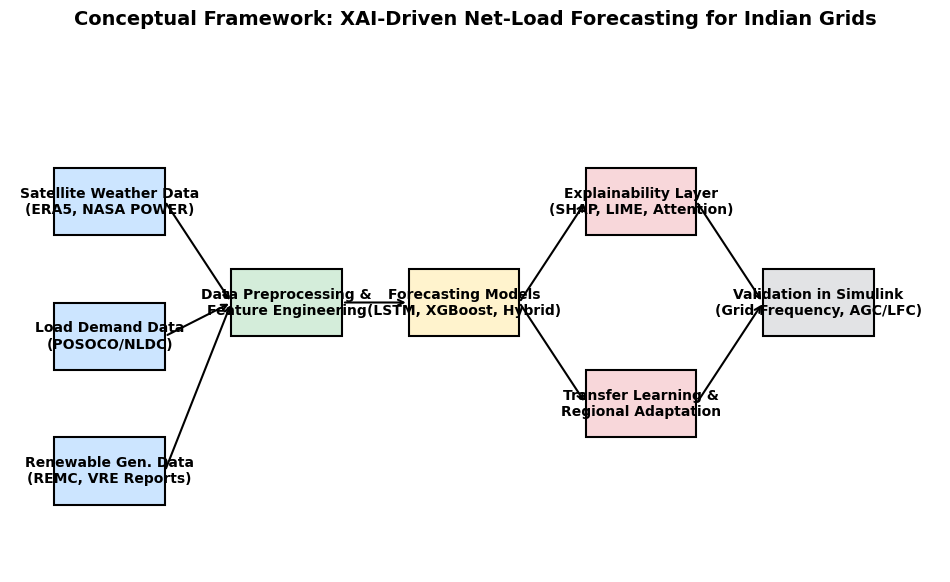

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrow

fig, ax = plt.subplots(figsize=(12,7))

# Helper function to add boxes
def add_box(text, x, y, width=2.5, height=1, color='#cce5ff'):
    ax.add_patch(Rectangle((x,y), width, height, edgecolor='black', facecolor=color, lw=1.5))
    ax.text(x+width/2, y+height/2, text, ha='center', va='center', fontsize=10, weight='bold')

# Input blocks
add_box("Satellite Weather Data\n(ERA5, NASA POWER)", 0, 4)
add_box("Load Demand Data\n(POSOCO/NLDC)", 0, 2)
add_box("Renewable Gen. Data\n(REMC, VRE Reports)", 0, 0)

# Preprocessing
add_box("Data Preprocessing &\nFeature Engineering", 4, 2.5, color='#d4edda')

# Forecasting Engine
add_box("Forecasting Models\n(LSTM, XGBoost, Hybrid)", 8, 2.5, color='#fff3cd')

# XAI Layer
add_box("Explainability Layer\n(SHAP, LIME, Attention)", 12, 4, color='#f8d7da')

# Transfer Learning
add_box("Transfer Learning &\nRegional Adaptation", 12, 1, color='#f8d7da')

# Validation
add_box("Validation in Simulink\n(Grid Frequency, AGC/LFC)", 16, 2.5, color='#e2e3e5')

# Arrows
arrowprops = dict(arrowstyle='->', lw=1.5, color='black')
ax.annotate('', xy=(4,3), xytext=(2.5,4.5), arrowprops=arrowprops)
ax.annotate('', xy=(4,3), xytext=(2.5,2.5), arrowprops=arrowprops)
ax.annotate('', xy=(4,3), xytext=(2.5,0.5), arrowprops=arrowprops)

ax.annotate('', xy=(8,3), xytext=(6.5,3), arrowprops=arrowprops)
ax.annotate('', xy=(12,4.5), xytext=(10.5,3), arrowprops=arrowprops)
ax.annotate('', xy=(12,1.5), xytext=(10.5,3), arrowprops=arrowprops)
ax.annotate('', xy=(16,3), xytext=(14.5,4.5), arrowprops=arrowprops)
ax.annotate('', xy=(16,3), xytext=(14.5,1.5), arrowprops=arrowprops)

# Adjustments
ax.set_xlim(-1,20)
ax.set_ylim(-1,7)
ax.axis('off')
plt.title("Conceptual Framework: XAI-Driven Net-Load Forecasting for Indian Grids", fontsize=14, weight='bold')

plt.show()


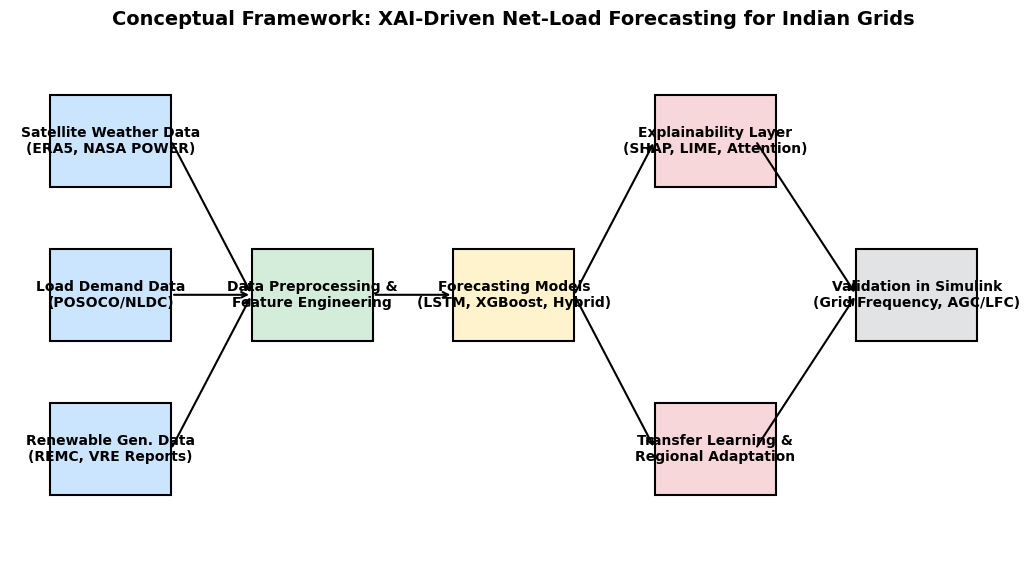

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(13,7))

# Helper function to add boxes
def add_box(text, x, y, width=3, height=1.2, color='#cce5ff'):
    ax.add_patch(Rectangle((x,y), width, height, edgecolor='black', facecolor=color, lw=1.5))
    ax.text(x+width/2, y+height/2, text, ha='center', va='center', fontsize=10, weight='bold', wrap=True)

# Input blocks (left side)
add_box("Satellite Weather Data\n(ERA5, NASA POWER)", 0, 5)
add_box("Load Demand Data\n(POSOCO/NLDC)", 0, 3)
add_box("Renewable Gen. Data\n(REMC, VRE Reports)", 0, 1)

# Preprocessing (middle left)
add_box("Data Preprocessing &\nFeature Engineering", 5, 3, color='#d4edda')

# Forecasting Engine (middle)
add_box("Forecasting Models\n(LSTM, XGBoost, Hybrid)", 10, 3, color='#fff3cd')

# XAI Layer (top right)
add_box("Explainability Layer\n(SHAP, LIME, Attention)", 15, 5, color='#f8d7da')

# Transfer Learning (bottom right)
add_box("Transfer Learning &\nRegional Adaptation", 15, 1, color='#f8d7da')

# Validation (far right)
add_box("Validation in Simulink\n(Grid Frequency, AGC/LFC)", 20, 3, color='#e2e3e5')

# Arrows
arrowprops = dict(arrowstyle='->', lw=1.5, color='black')
ax.annotate('', xy=(5,3.6), xytext=(3,5.6), arrowprops=arrowprops)
ax.annotate('', xy=(5,3.6), xytext=(3,3.6), arrowprops=arrowprops)
ax.annotate('', xy=(5,3.6), xytext=(3,1.6), arrowprops=arrowprops)

ax.annotate('', xy=(10,3.6), xytext=(8,3.6), arrowprops=arrowprops)
ax.annotate('', xy=(15,5.6), xytext=(13,3.6), arrowprops=arrowprops)
ax.annotate('', xy=(15,1.6), xytext=(13,3.6), arrowprops=arrowprops)

ax.annotate('', xy=(20,3.6), xytext=(17.5,5.6), arrowprops=arrowprops)
ax.annotate('', xy=(20,3.6), xytext=(17.5,1.6), arrowprops=arrowprops)

# Adjustments
ax.set_xlim(-1,24)
ax.set_ylim(0,7)
ax.axis('off')
plt.title("Conceptual Framework: XAI-Driven Net-Load Forecasting for Indian Grids", fontsize=14, weight='bold')

plt.show()
